# Position Reconstruction for XeBRA - Comparison Performance

**Status:** August 2019

Position reconstruction for XeBRA using Centroids, LRFs and NNs as well as comparison performance.

In [1]:
## Imports:

import sys
import glob

import numpy as np
from numpy import exp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import pandas as pd
import math

from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import griddata
from scipy.stats import chisquare
from scipy.stats import power_divergence

## General Definitions and Parameters

In [2]:
## General function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
## PMT properties
R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.
PMT_ID = np.array([1,2,3,4,5,6,7])
PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates
PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})

## Imports and Data Processing

### Centroids

In [4]:
!ls /media/alex/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_LRF/*_ReconstructedPosition_Deviations_Centroids.pkl
!ls /media/alex/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_LRF/*_Goodness_fiducialisation_Centroids.pkl
!ls /media/ab602/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_LRF/*_ReconstructedPosition_Deviations_Centroids.pkl
!ls /media/ab602/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_LRF/*_Goodness_fiducialisation_Centroids.pkl

'/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Centroids.pkl'
'/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Centroids.pkl'
ls: cannot access '/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/*_ReconstructedPosition_Deviations_Centroids.pkl': No such file or directory
ls: cannot access '/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/*_Goodness_fiducialisation_Centroids.pkl': No such file or directory


In [5]:
try:
    df_Deviations_Centroids = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Centroids.pkl")
except:
    df_Deviations_Centroids = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Centroids.pkl")
df_Deviations_Centroids.head()

fid   sigma_x   sigma_y  delta_mean  delta_50_percentile  \
0  10.0  2.554830  2.593365    3.508386             3.770898   
1  12.5  2.818982  2.819910    3.854391             4.026342   
2  15.0  3.263587  3.094432    4.325498             4.283963   
3  17.5  6.611887  4.491451    6.851389             5.262925   
4  20.0  7.113105  6.289050    8.446103             7.423195   

   delta_68.27_percentile  delta_95_percentile  delta_95.45_percentile  \
0                4.033042             4.766188                4.778404   
1                4.289271             5.327869                5.366961   
2                4.721932             6.457556                6.541541   
3                6.847796            16.649045               16.767817   
4               10.508964            16.425312               16.489260   

   delta_99.73_percentile  
0                5.079318  
1                5.805444  
2                7.616104  
3               18.759106  
4               18.671607

In [6]:
try:
    df_Fiducialisation_Centroids = pd.read_pickle("/media/ab602/TOSHIBA EXT/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Centroids.pkl")
except:
    df_Fiducialisation_Centroids = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Centroids.pkl")
df_Fiducialisation_Centroids.head()

fid  true_negative  false_negative  true_positive  false_positive   total  \
0   5.0         3633.0             0.0           80.0           139.0  3852.0   
1   7.5         3436.0             0.0          172.0           244.0  3852.0   
2  10.0         3193.0             0.0          316.0           343.0  3852.0   
3  12.5         2916.0             0.0          484.0           452.0  3852.0   
4  15.0         2503.0             0.0          716.0           633.0  3852.0   

   true_inside  true_outside  
0         80.0        3772.0  
1        172.0        3680.0  
2        316.0        3536.0  
3        484.0        3368.0  
4        716.0        3136.0

### NN

In [7]:
!ls /media/alex/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_NN/*_ReconstructedPosition_Deviations_NN.pkl
!ls /media/alex/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_NN/*_Goodness_fiducialisation_NN.pkl
!ls /media/ab602/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_NN/*_ReconstructedPosition_Deviations_NN.pkl
!ls /media/ab602/TOSHIBA\ EXT/Simulation_Outputs/Position_Reconstruction_NN/*_Goodness_fiducialisation_NN.pkl

'/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_NN.pkl'
'/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_NN.pkl'
ls: cannot access '/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/*_ReconstructedPosition_Deviations_NN.pkl': No such file or directory
ls: cannot access '/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/*_Goodness_fiducialisation_NN.pkl': No such file or directory


In [8]:
try:
    df_Deviations_NN = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_NN.pkl")
except:
    df_Deviations_NN = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_NN.pkl")
df_Deviations_NN.head()

fid   sigma_x   sigma_y  delta_mean  delta_50_percentile  \
0  10.0  0.608703  0.647177    0.787549             0.740412   
1  12.5  0.579735  0.635484    0.758229             0.709664   
2  15.0  0.566855  0.604378    0.727302             0.679322   
3  17.5  0.551490  0.591503    0.708373             0.653613   
4  20.0  0.563127  0.594661    0.714386             0.660743   

   delta_68.27_percentile  delta_95_percentile  delta_95.45_percentile  \
0                0.932126             1.619374                1.637801   
1                0.898093             1.566476                1.590790   
2                0.877476             1.497944                1.533000   
3                0.851911             1.437029                1.491868   
4                0.855280             1.474834                1.515403   

   delta_99.73_percentile  
0                2.286665  
1                2.289979  
2                2.237210  
3                2.279922  
4                2.292867

In [9]:
try:
    df_Fiducialisation_NN = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_NN.pkl")
except:
    df_Fiducialisation_NN = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_NN.pkl")
df_Fiducialisation_NN.head()

fid  true_negative  false_negative  true_positive  false_positive  \
0  10.0         9119.0            50.0          794.0            37.0   
1  12.5         8601.0            28.0         1311.0            60.0   
2  15.0         8021.0            37.0         1874.0            68.0   
3  17.5         7357.0            42.0         2546.0            55.0   
4  20.0         6545.0            73.0         3288.0            94.0   

     total  true_inside  true_outside  
0  10000.0        844.0        9156.0  
1  10000.0       1339.0        8661.0  
2  10000.0       1911.0        8089.0  
3  10000.0       2588.0        7412.0  
4  10000.0       3361.0        6639.0

### LRF

In [10]:
try:
    df_Deviations_LRF_iteration_1 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_1_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Deviations_LRF_iteration_1 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_1_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Deviations_LRF_iteration_1.head()

fid   sigma_x   sigma_y  delta_mean  delta_50_percentile  \
0  10.0  0.718057  0.219635    0.697235             0.756095   
1  12.5  0.700457  0.224861    0.683744             0.765111   
2  15.0  0.662676  0.236938    0.649315             0.713912   
3  17.5  0.609395  0.241052    0.593088             0.627525   
4  20.0  0.555826  0.241010    0.535360             0.550139   

   delta_68.27_percentile  delta_95_percentile  delta_95.45_percentile  \
0                0.913229             1.049610                1.052538   
1                0.880908             1.036635                1.037352   
2                0.824683             1.024408                1.027624   
3                0.773804             1.009213                1.012127   
4                0.710301             0.971242                0.989502   

   delta_99.73_percentile  
0                1.131810  
1                1.130707  
2                1.129766  
3                1.119724  
4                1.111325

In [11]:
try:
    df_Deviations_LRF_iteration_2 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_2_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Deviations_LRF_iteration_2 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_2_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Deviations_LRF_iteration_2.head()

fid   sigma_x   sigma_y  delta_mean  delta_50_percentile  \
0  10.0  0.695873  0.216810    0.672805             0.687156   
1  12.5  0.713913  0.252355    0.703090             0.730005   
2  15.0  0.713716  0.293979    0.722144             0.789049   
3  17.5  0.685673  0.321565    0.708838             0.769096   
4  20.0  0.656569  0.351410    0.702165             0.744135   

   delta_68.27_percentile  delta_95_percentile  delta_95.45_percentile  \
0                0.873686             1.061828                1.064174   
1                0.911832             1.071897                1.079946   
2                0.930954             1.060996                1.063477   
3                0.904001             1.054034                1.055475   
4                0.873804             1.046665                1.049640   

   delta_99.73_percentile  
0                1.129100  
1                1.131221  
2                1.128910  
3                1.128749  
4                1.125443

In [12]:
try:
    df_Deviations_LRF_iteration_3 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_3_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Deviations_LRF_iteration_3 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_3_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Deviations_LRF_iteration_3.head()

fid   sigma_x   sigma_y  delta_mean  delta_50_percentile  \
0  10.0  0.719543  0.250134    0.707477             0.715051   
1  12.5  0.745853  0.312038    0.756983             0.786082   
2  15.0  0.767557  0.372737    0.805490             0.869131   
3  17.5  0.763406  0.440371    0.836908             0.902294   
4  20.0  0.759216  0.506810    0.873751             0.936718   

   delta_68.27_percentile  delta_95_percentile  delta_95.45_percentile  \
0                0.902166             1.105540                1.107226   
1                0.970130             1.137619                1.141357   
2                1.023938             1.159834                1.163010   
3                1.038954             1.189508                1.191339   
4                1.049125             1.215878                1.220500   

   delta_99.73_percentile  
0                1.156904  
1                1.196320  
2                1.208284  
3                1.271802  
4                1.323889

In [13]:
try:
    df_Deviations_LRF_iteration_4 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_4_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Deviations_LRF_iteration_4 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_4_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Deviations_LRF_iteration_4.head()

fid   sigma_x   sigma_y  delta_mean  delta_50_percentile  \
0  10.0  0.746231  0.318552    0.763983             0.781101   
1  12.5  0.784141  0.395445    0.833330             0.876790   
2  15.0  0.809566  0.482801    0.898778             0.951041   
3  17.5  0.828857  0.568333    0.961892             1.020127   
4  20.0  0.860537  0.673211    1.047135             1.095321   

   delta_68.27_percentile  delta_95_percentile  delta_95.45_percentile  \
0                0.961562             1.133179                1.137569   
1                1.043859             1.193895                1.196522   
2                1.098077             1.285466                1.293812   
3                1.129416             1.393653                1.402043   
4                1.206401             1.524515                1.532113   

   delta_99.73_percentile  
0                1.180532  
1                1.275603  
2                1.413387  
3                1.529829  
4                1.714300

In [14]:
try:
    df_Deviations_LRF_iteration_5 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_5_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Deviations_LRF_iteration_5 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_ReconstructedPosition_Deviations_Iterative_Reconstruciton_iteration_5_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Deviations_LRF_iteration_5.head()

fid   sigma_x   sigma_y  delta_mean  delta_50_percentile  \
0  10.0  0.781226  0.377138    0.822388             0.848519   
1  12.5  0.830923  0.469698    0.911857             0.957713   
2  15.0  0.866837  0.581669    0.999798             1.050486   
3  17.5  0.906022  0.696477    1.095337             1.139619   
4  20.0  0.951553  0.821193    1.203309             1.216294   

   delta_68.27_percentile  delta_95_percentile  delta_95.45_percentile  \
0                1.034416             1.191893                1.193607   
1                1.119339             1.265734                1.271157   
2                1.183328             1.453318                1.462647   
3                1.237808             1.621494                1.634842   
4                1.378651             1.771076                1.780196   

   delta_99.73_percentile  
0                1.227575  
1                1.395951  
2                1.597689  
3                1.784684  
4                2.003181

In [15]:
try:
    df_Fiducialisation_LRF_iteration_1 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_1_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Fiducialisation_LRF_iteration_1 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_1_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Fiducialisation_LRF_iteration_1.head()

fid  true_negative  false_negative  true_positive  false_positive   total  \
0  10.0         3496.0             0.0          316.0            40.0  3852.0   
1  12.5         3312.0             0.0          484.0            56.0  3852.0   
2  15.0         3104.0             0.0          716.0            32.0  3852.0   
3  17.5         2855.0             0.0          952.0            45.0  3852.0   
4  20.0         2557.0             0.0         1264.0            31.0  3852.0   

   true_inside  true_outside  
0        316.0        3536.0  
1        484.0        3368.0  
2        716.0        3136.0  
3        952.0        2900.0  
4       1264.0        2588.0

In [16]:
try:
    df_Fiducialisation_LRF_iteration_2 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_2_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Fiducialisation_LRF_iteration_2 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_2_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Fiducialisation_LRF_iteration_2.head()

fid  true_negative  false_negative  true_positive  false_positive   total  \
0  10.0         3495.0             0.0          316.0            41.0  3852.0   
1  12.5         3308.0             0.0          484.0            60.0  3852.0   
2  15.0         3073.0             0.0          716.0            63.0  3852.0   
3  17.5         2814.0             0.0          952.0            86.0  3852.0   
4  20.0         2519.0             0.0         1264.0            69.0  3852.0   

   true_inside  true_outside  
0        316.0        3536.0  
1        484.0        3368.0  
2        716.0        3136.0  
3        952.0        2900.0  
4       1264.0        2588.0

In [17]:
try:
    df_Fiducialisation_LRF_iteration_3 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_3_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Fiducialisation_LRF_iteration_3 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_3_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Fiducialisation_LRF_iteration_3.head()

fid  true_negative  false_negative  true_positive  false_positive   total  \
0  10.0         3483.0             0.0          316.0            53.0  3852.0   
1  12.5         3290.0             0.0          484.0            78.0  3852.0   
2  15.0         3064.0             0.0          716.0            72.0  3852.0   
3  17.5         2781.0             0.0          952.0           119.0  3852.0   
4  20.0         2463.0             0.0         1264.0           125.0  3852.0   

   true_inside  true_outside  
0        316.0        3536.0  
1        484.0        3368.0  
2        716.0        3136.0  
3        952.0        2900.0  
4       1264.0        2588.0

In [18]:
try:
    df_Fiducialisation_LRF_iteration_4 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_4_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Fiducialisation_LRF_iteration_4 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_4_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Fiducialisation_LRF_iteration_4.head()

fid  true_negative  false_negative  true_positive  false_positive   total  \
0  10.0         3479.0             0.0          316.0            57.0  3852.0   
1  12.5         3276.0             0.0          484.0            92.0  3852.0   
2  15.0         3037.0             0.0          716.0            99.0  3852.0   
3  17.5         2754.0             0.0          952.0           146.0  3852.0   
4  20.0         2415.0             0.0         1264.0           173.0  3852.0   

   true_inside  true_outside  
0        316.0        3536.0  
1        484.0        3368.0  
2        716.0        3136.0  
3        952.0        2900.0  
4       1264.0        2588.0

In [19]:
try:
    df_Fiducialisation_LRF_iteration_5 = pd.read_pickle("/media/ab602/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_5_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
except:
    df_Fiducialisation_LRF_iteration_5 = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Goodness_fiducialisation_Iterative_Reconstruciton_iteration_5_rfiducial_20_rfiducial_under_15_eta_v2_overSum_Chi2_normalization_to_sum_True.pkl")
df_Fiducialisation_LRF_iteration_5.head()

fid  true_negative  false_negative  true_positive  false_positive   total  \
0  10.0         3473.0             0.0          316.0            63.0  3852.0   
1  12.5         3268.0             0.0          484.0           100.0  3852.0   
2  15.0         3016.0             0.0          716.0           120.0  3852.0   
3  17.5         2715.0             0.0          952.0           185.0  3852.0   
4  20.0         2384.0             0.0         1264.0           204.0  3852.0   

   true_inside  true_outside  
0        316.0        3536.0  
1        484.0        3368.0  
2        716.0        3136.0  
3        952.0        2900.0  
4       1264.0        2588.0

## Evaluation

### Deviations Percentiles

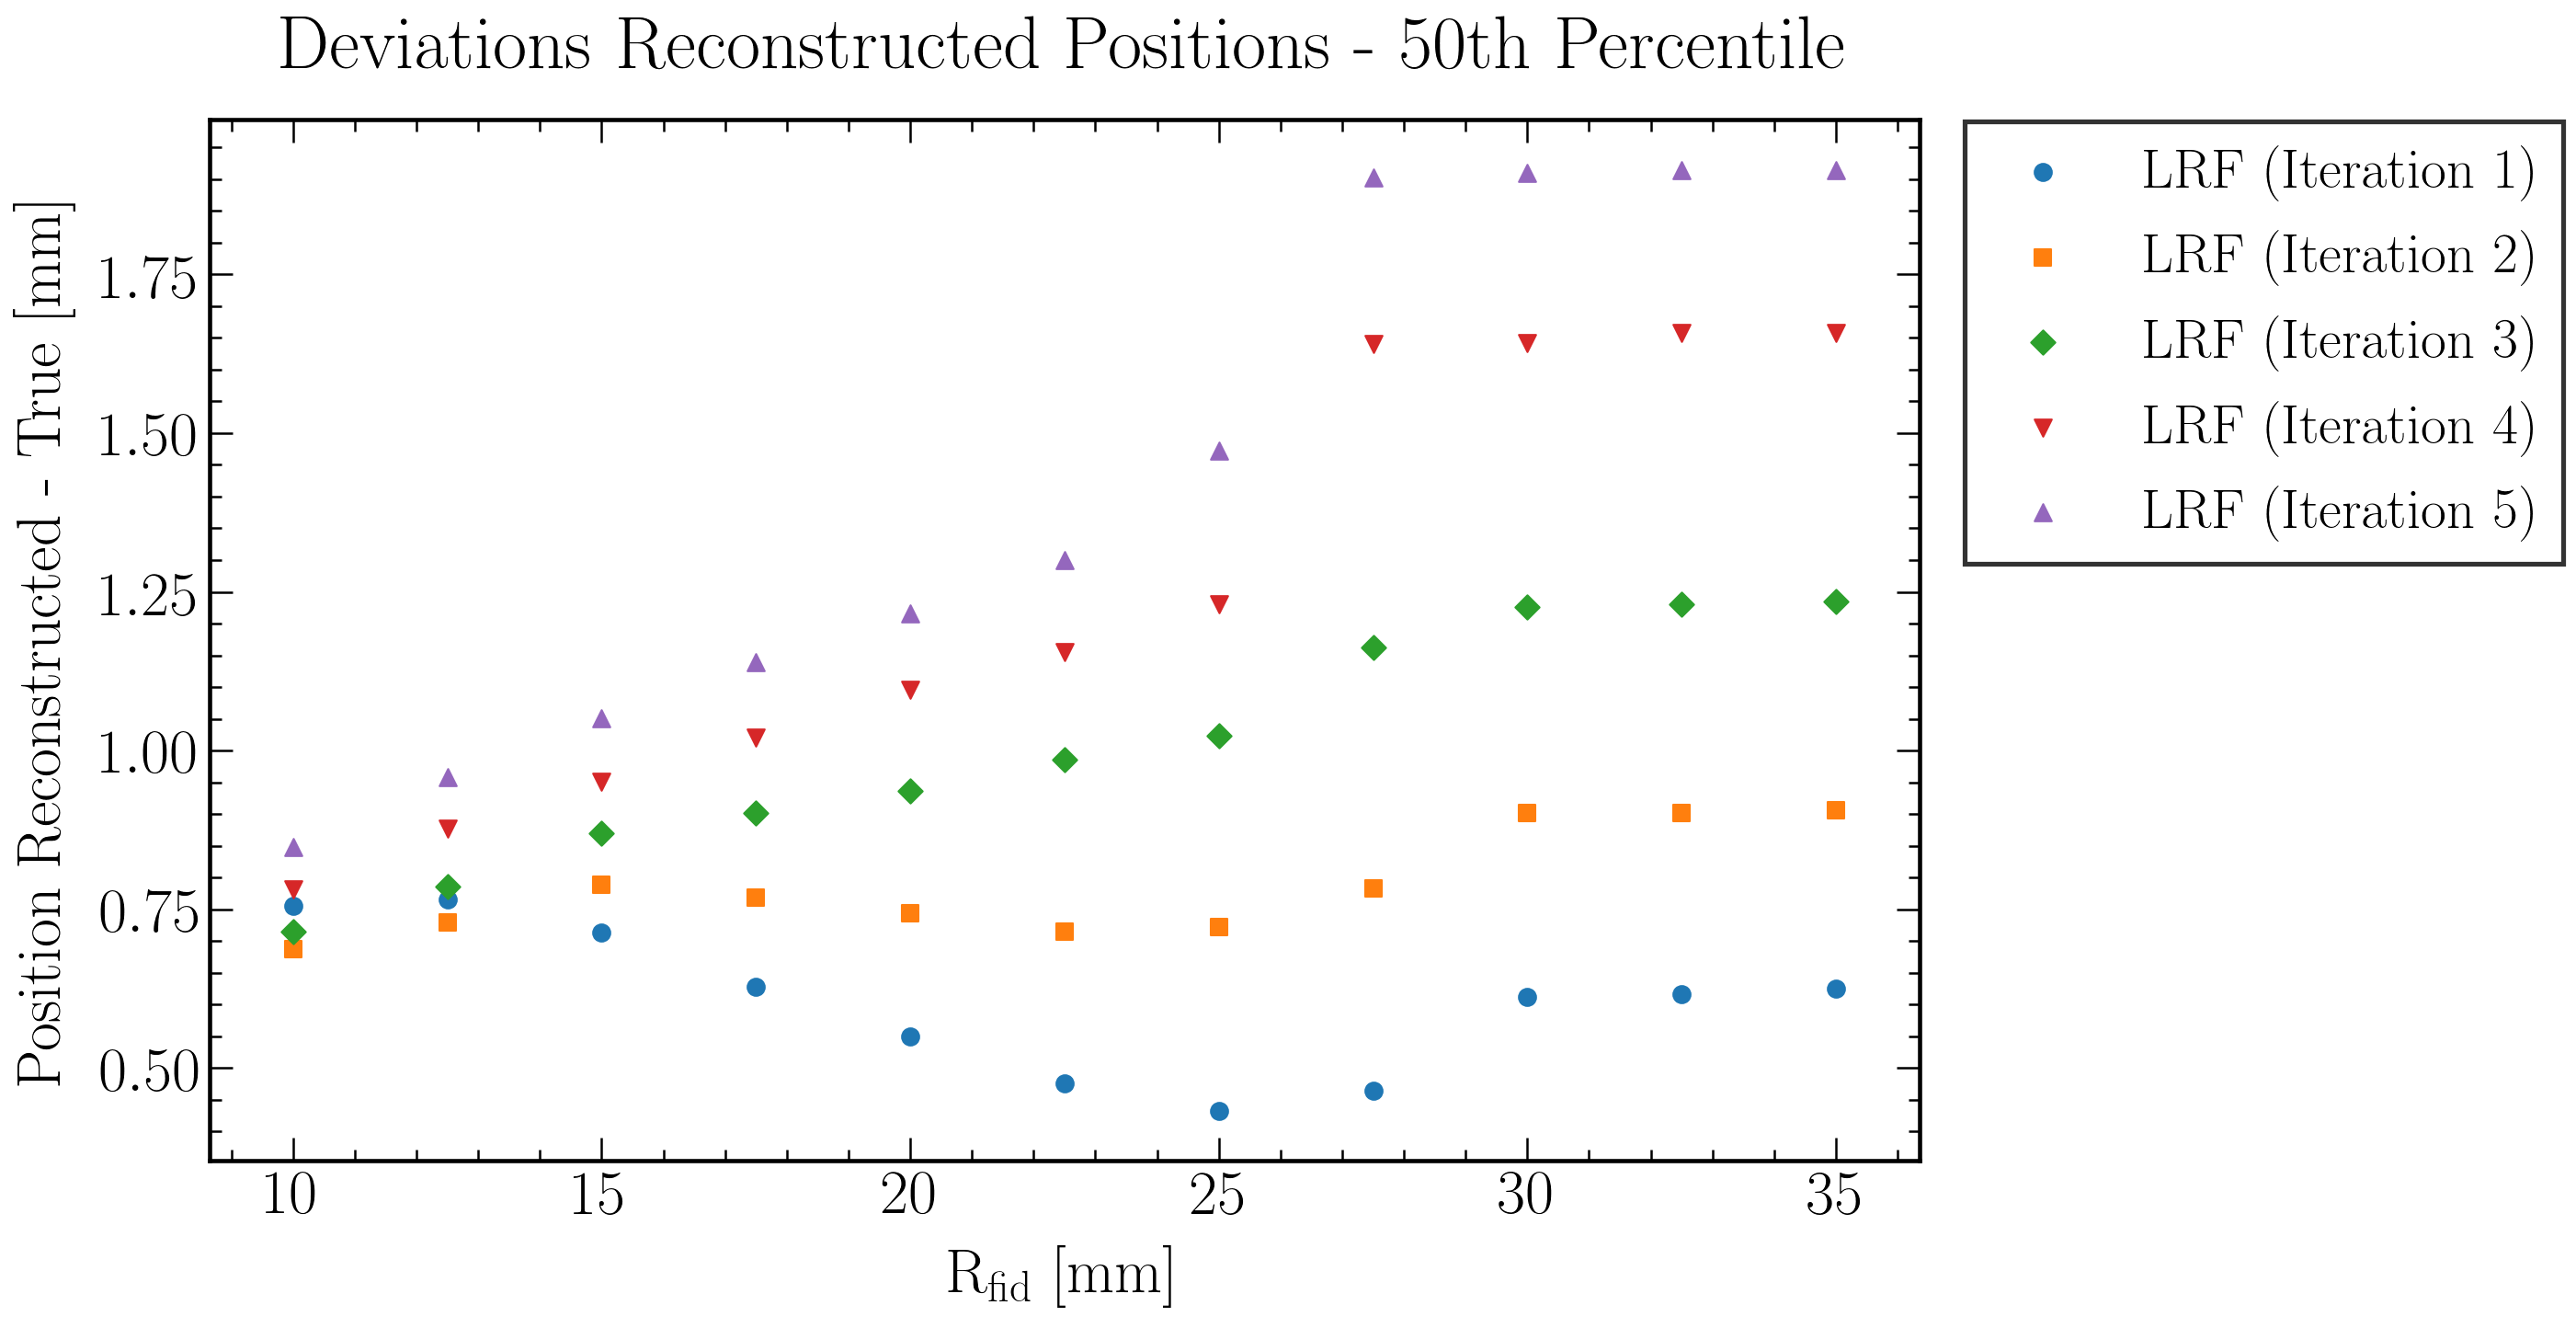

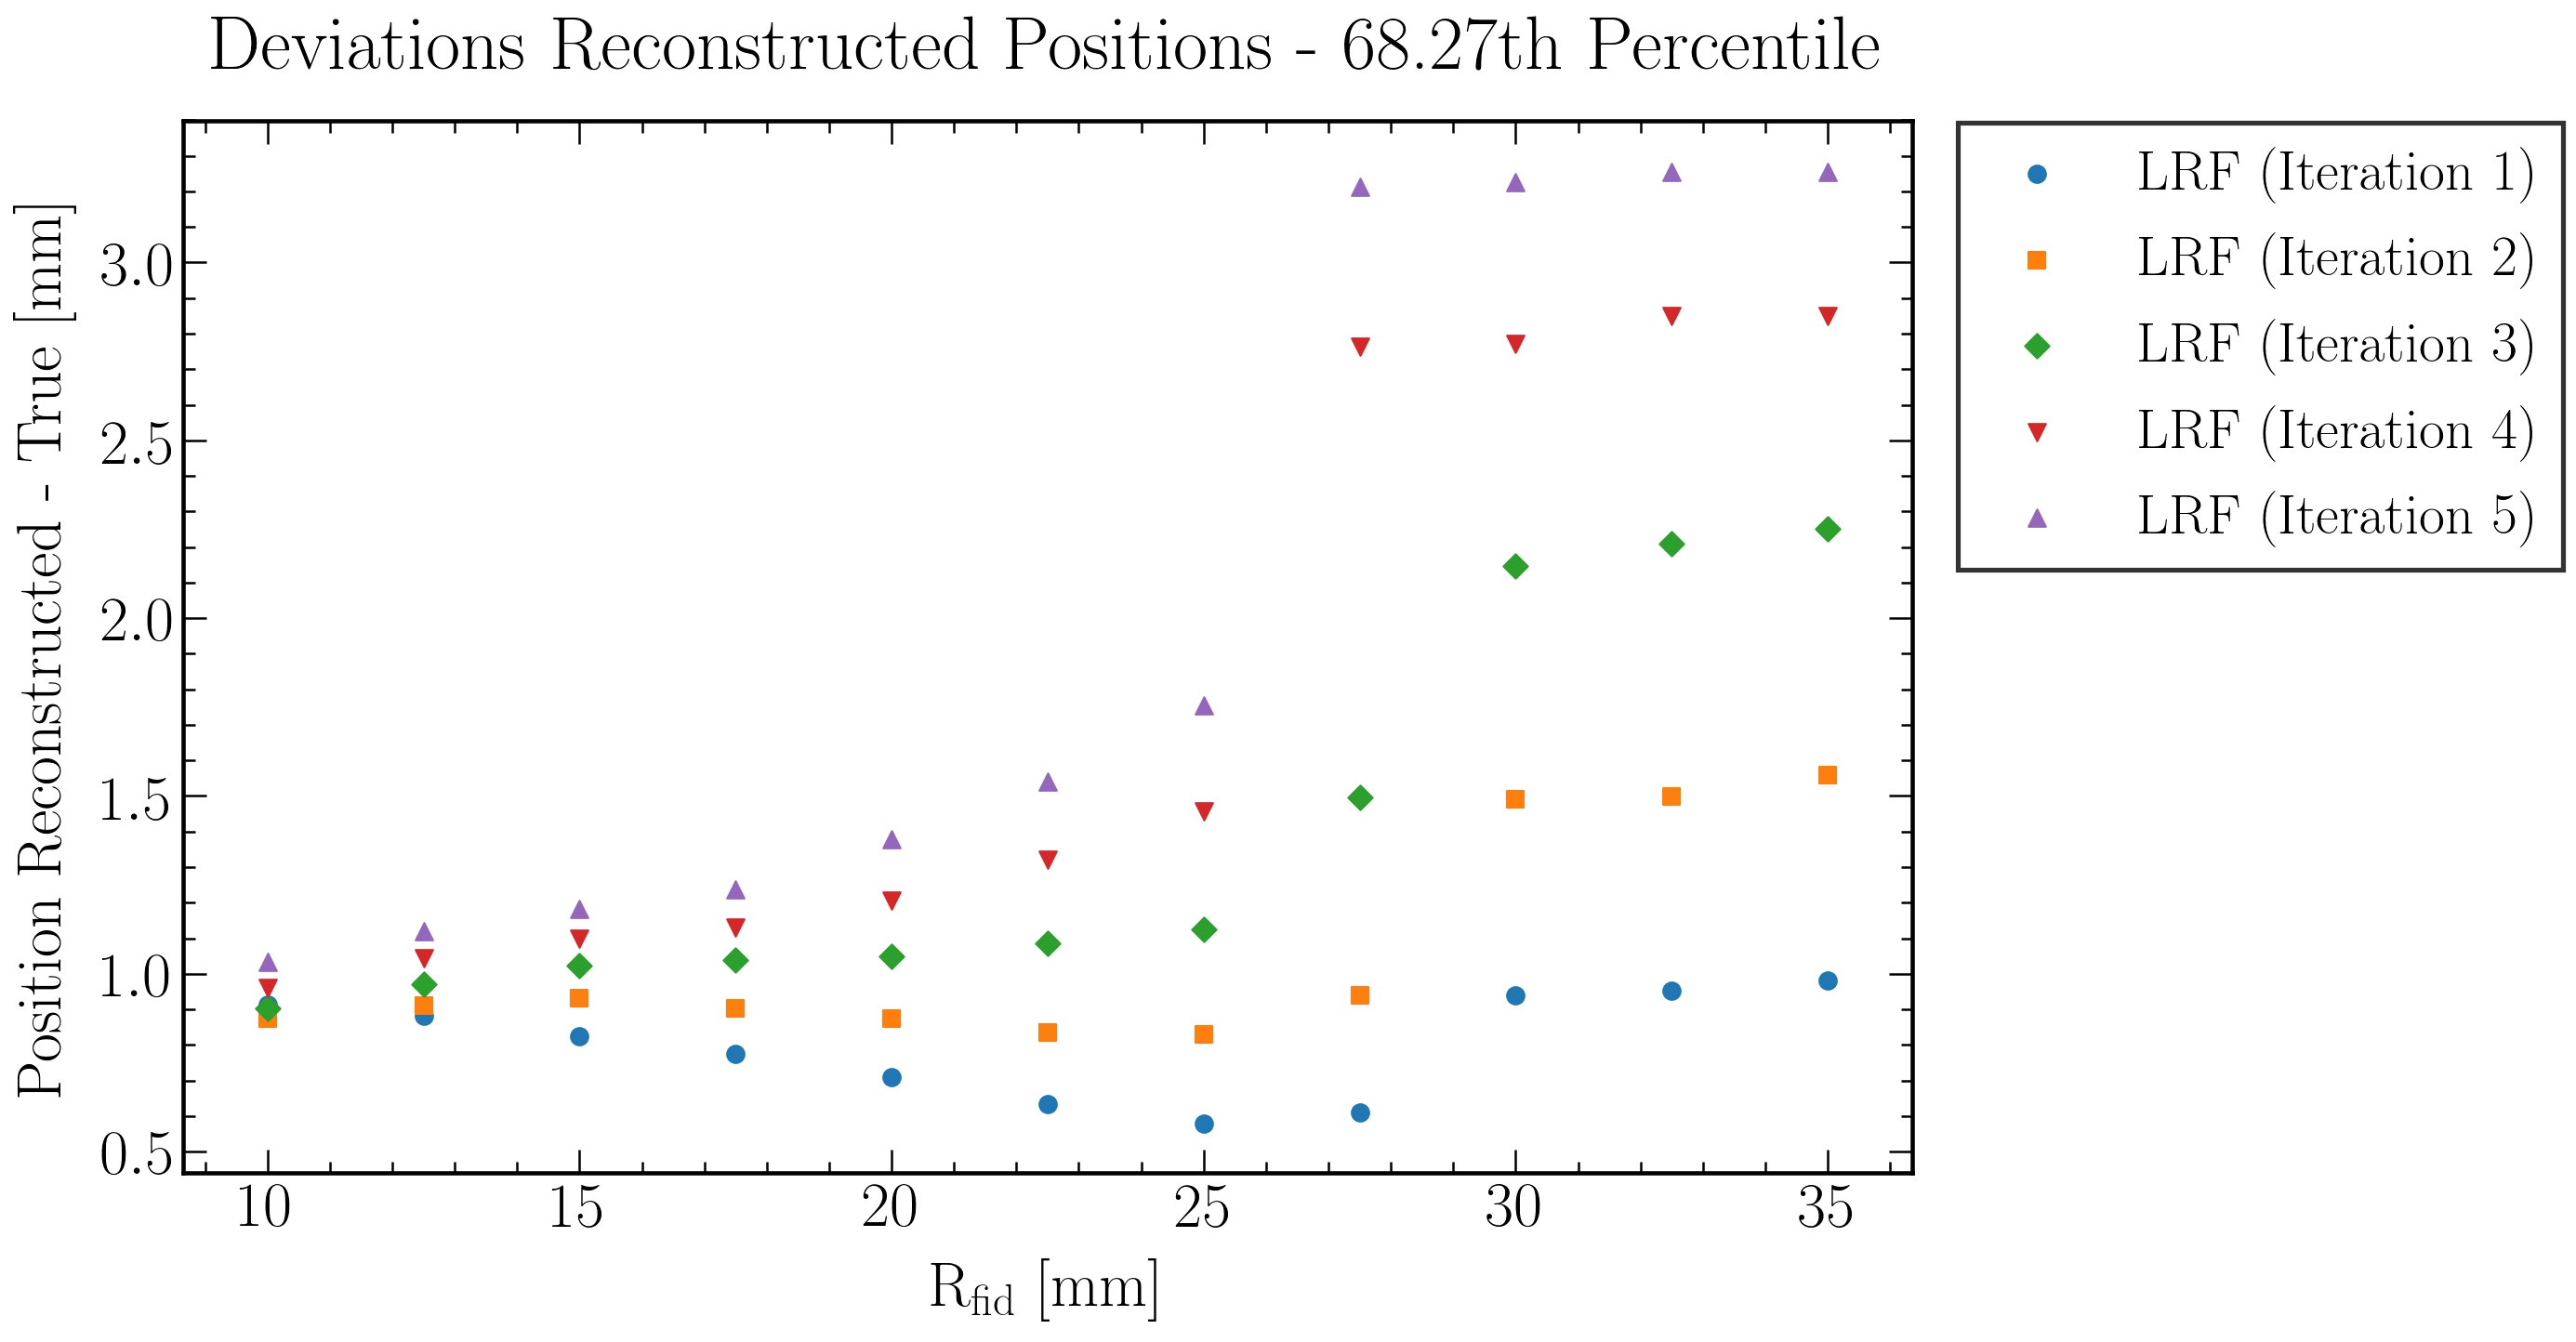

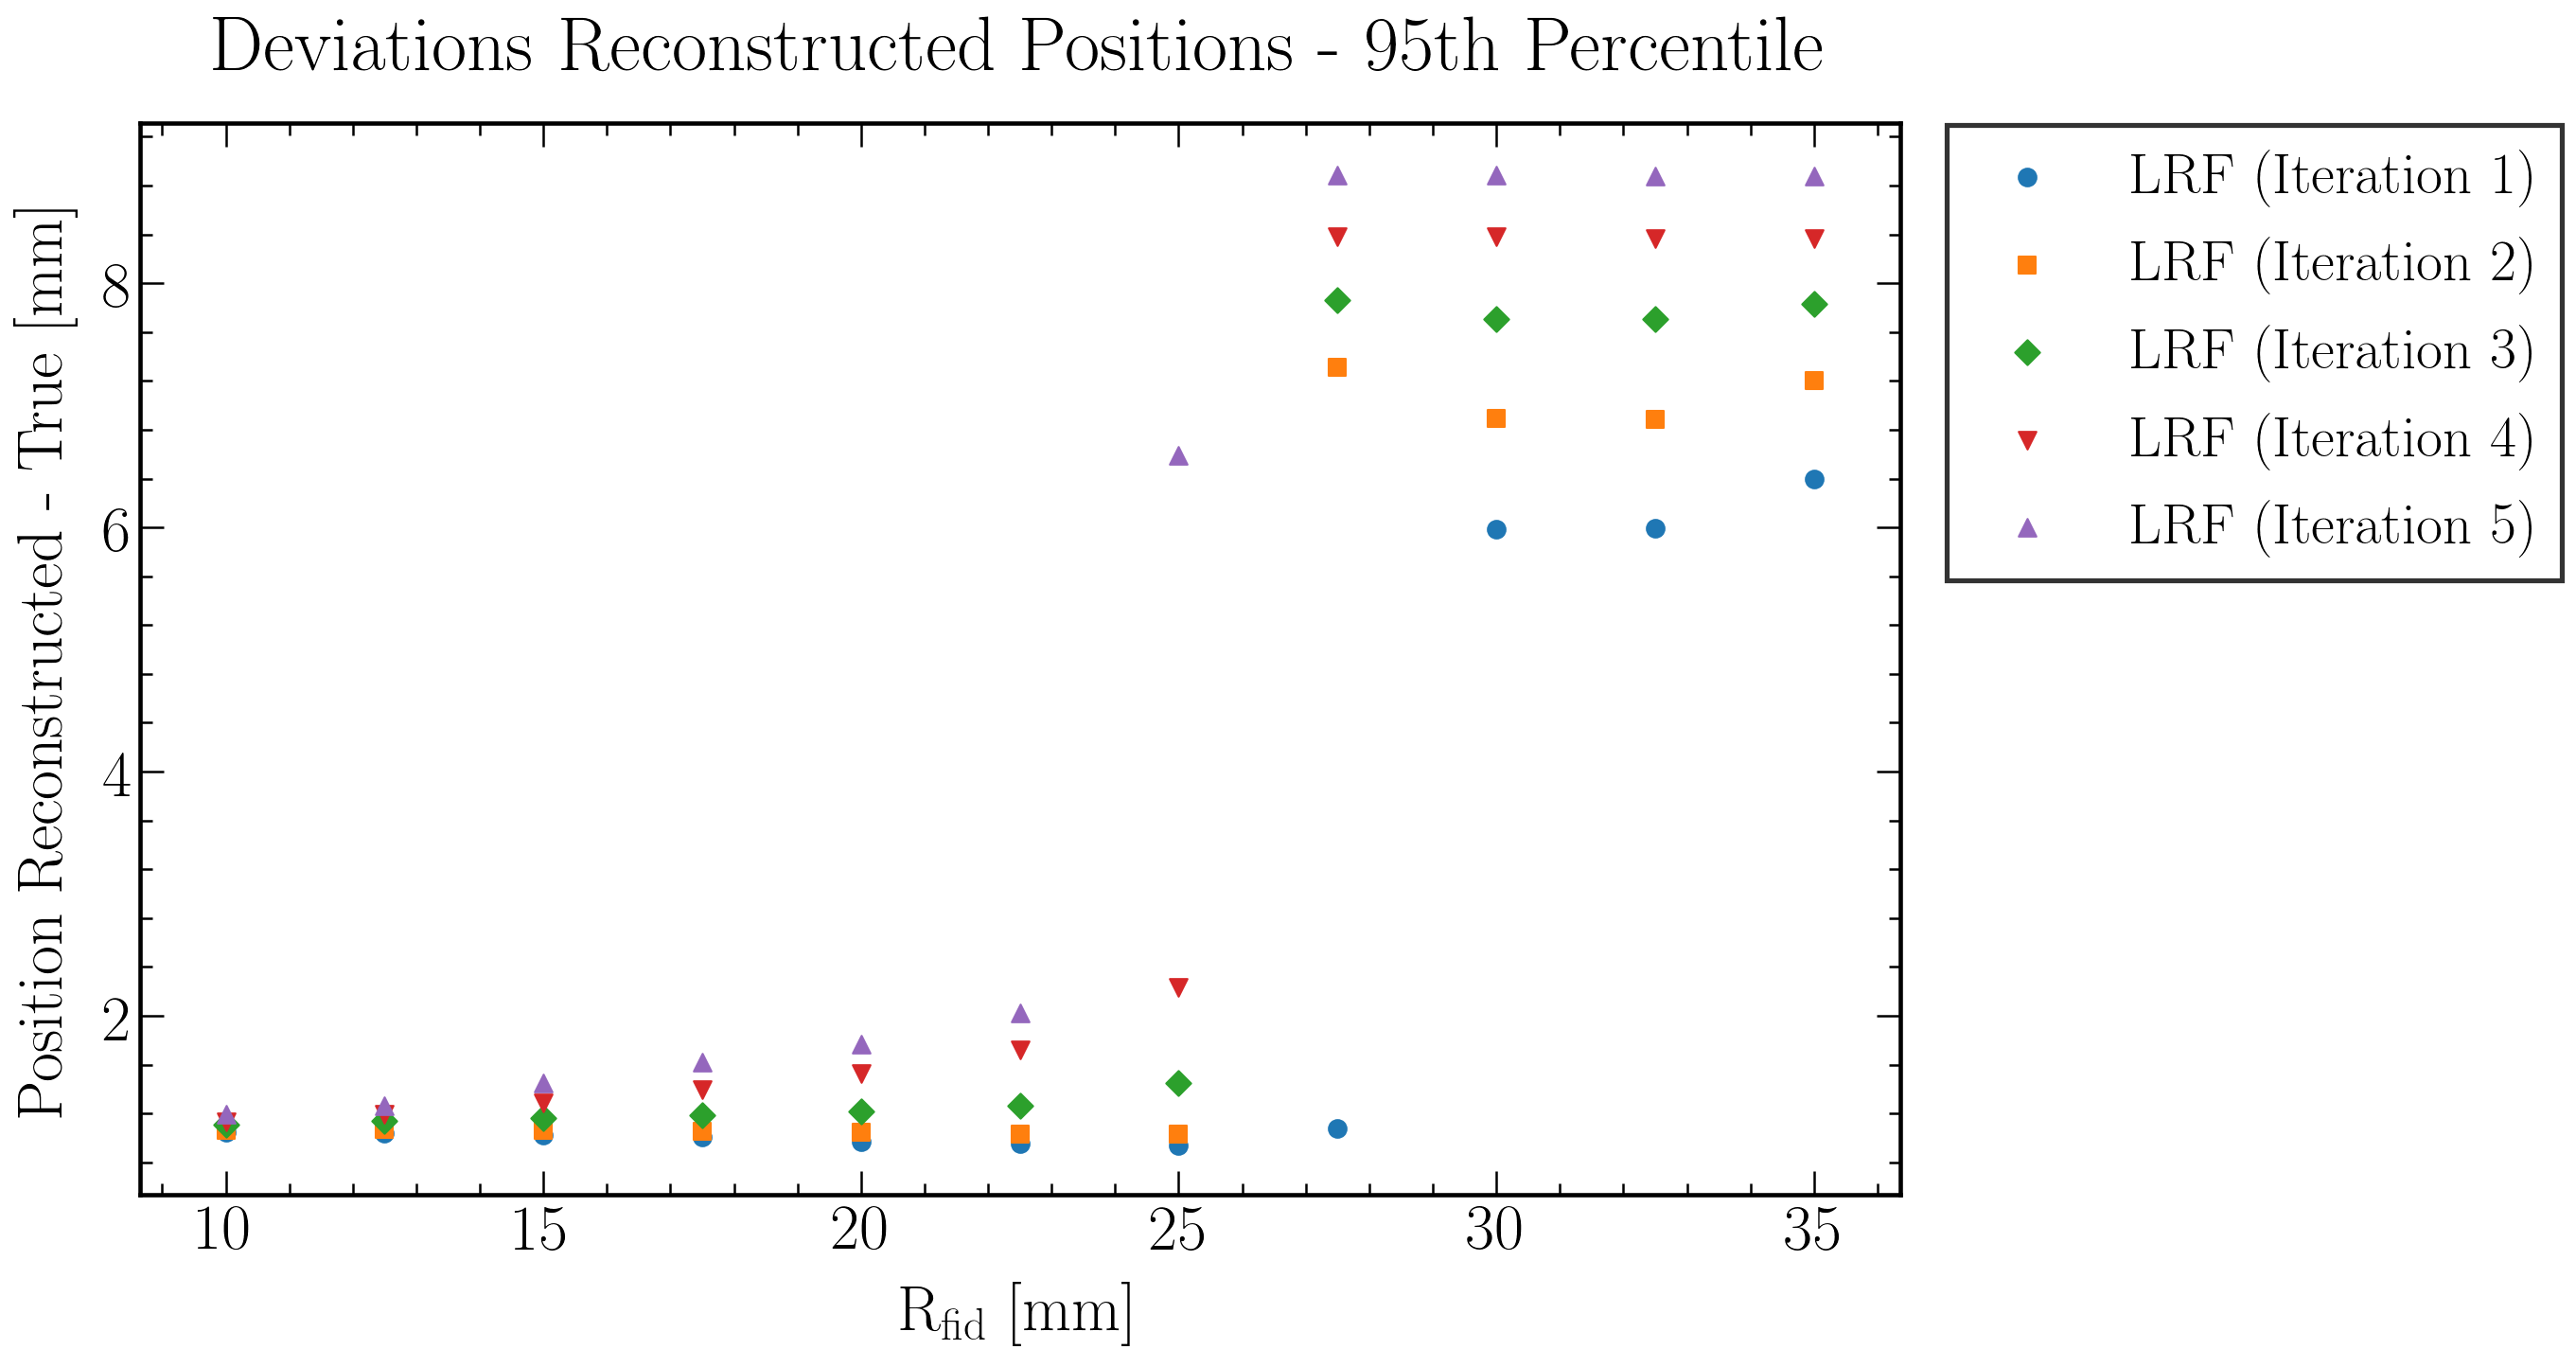

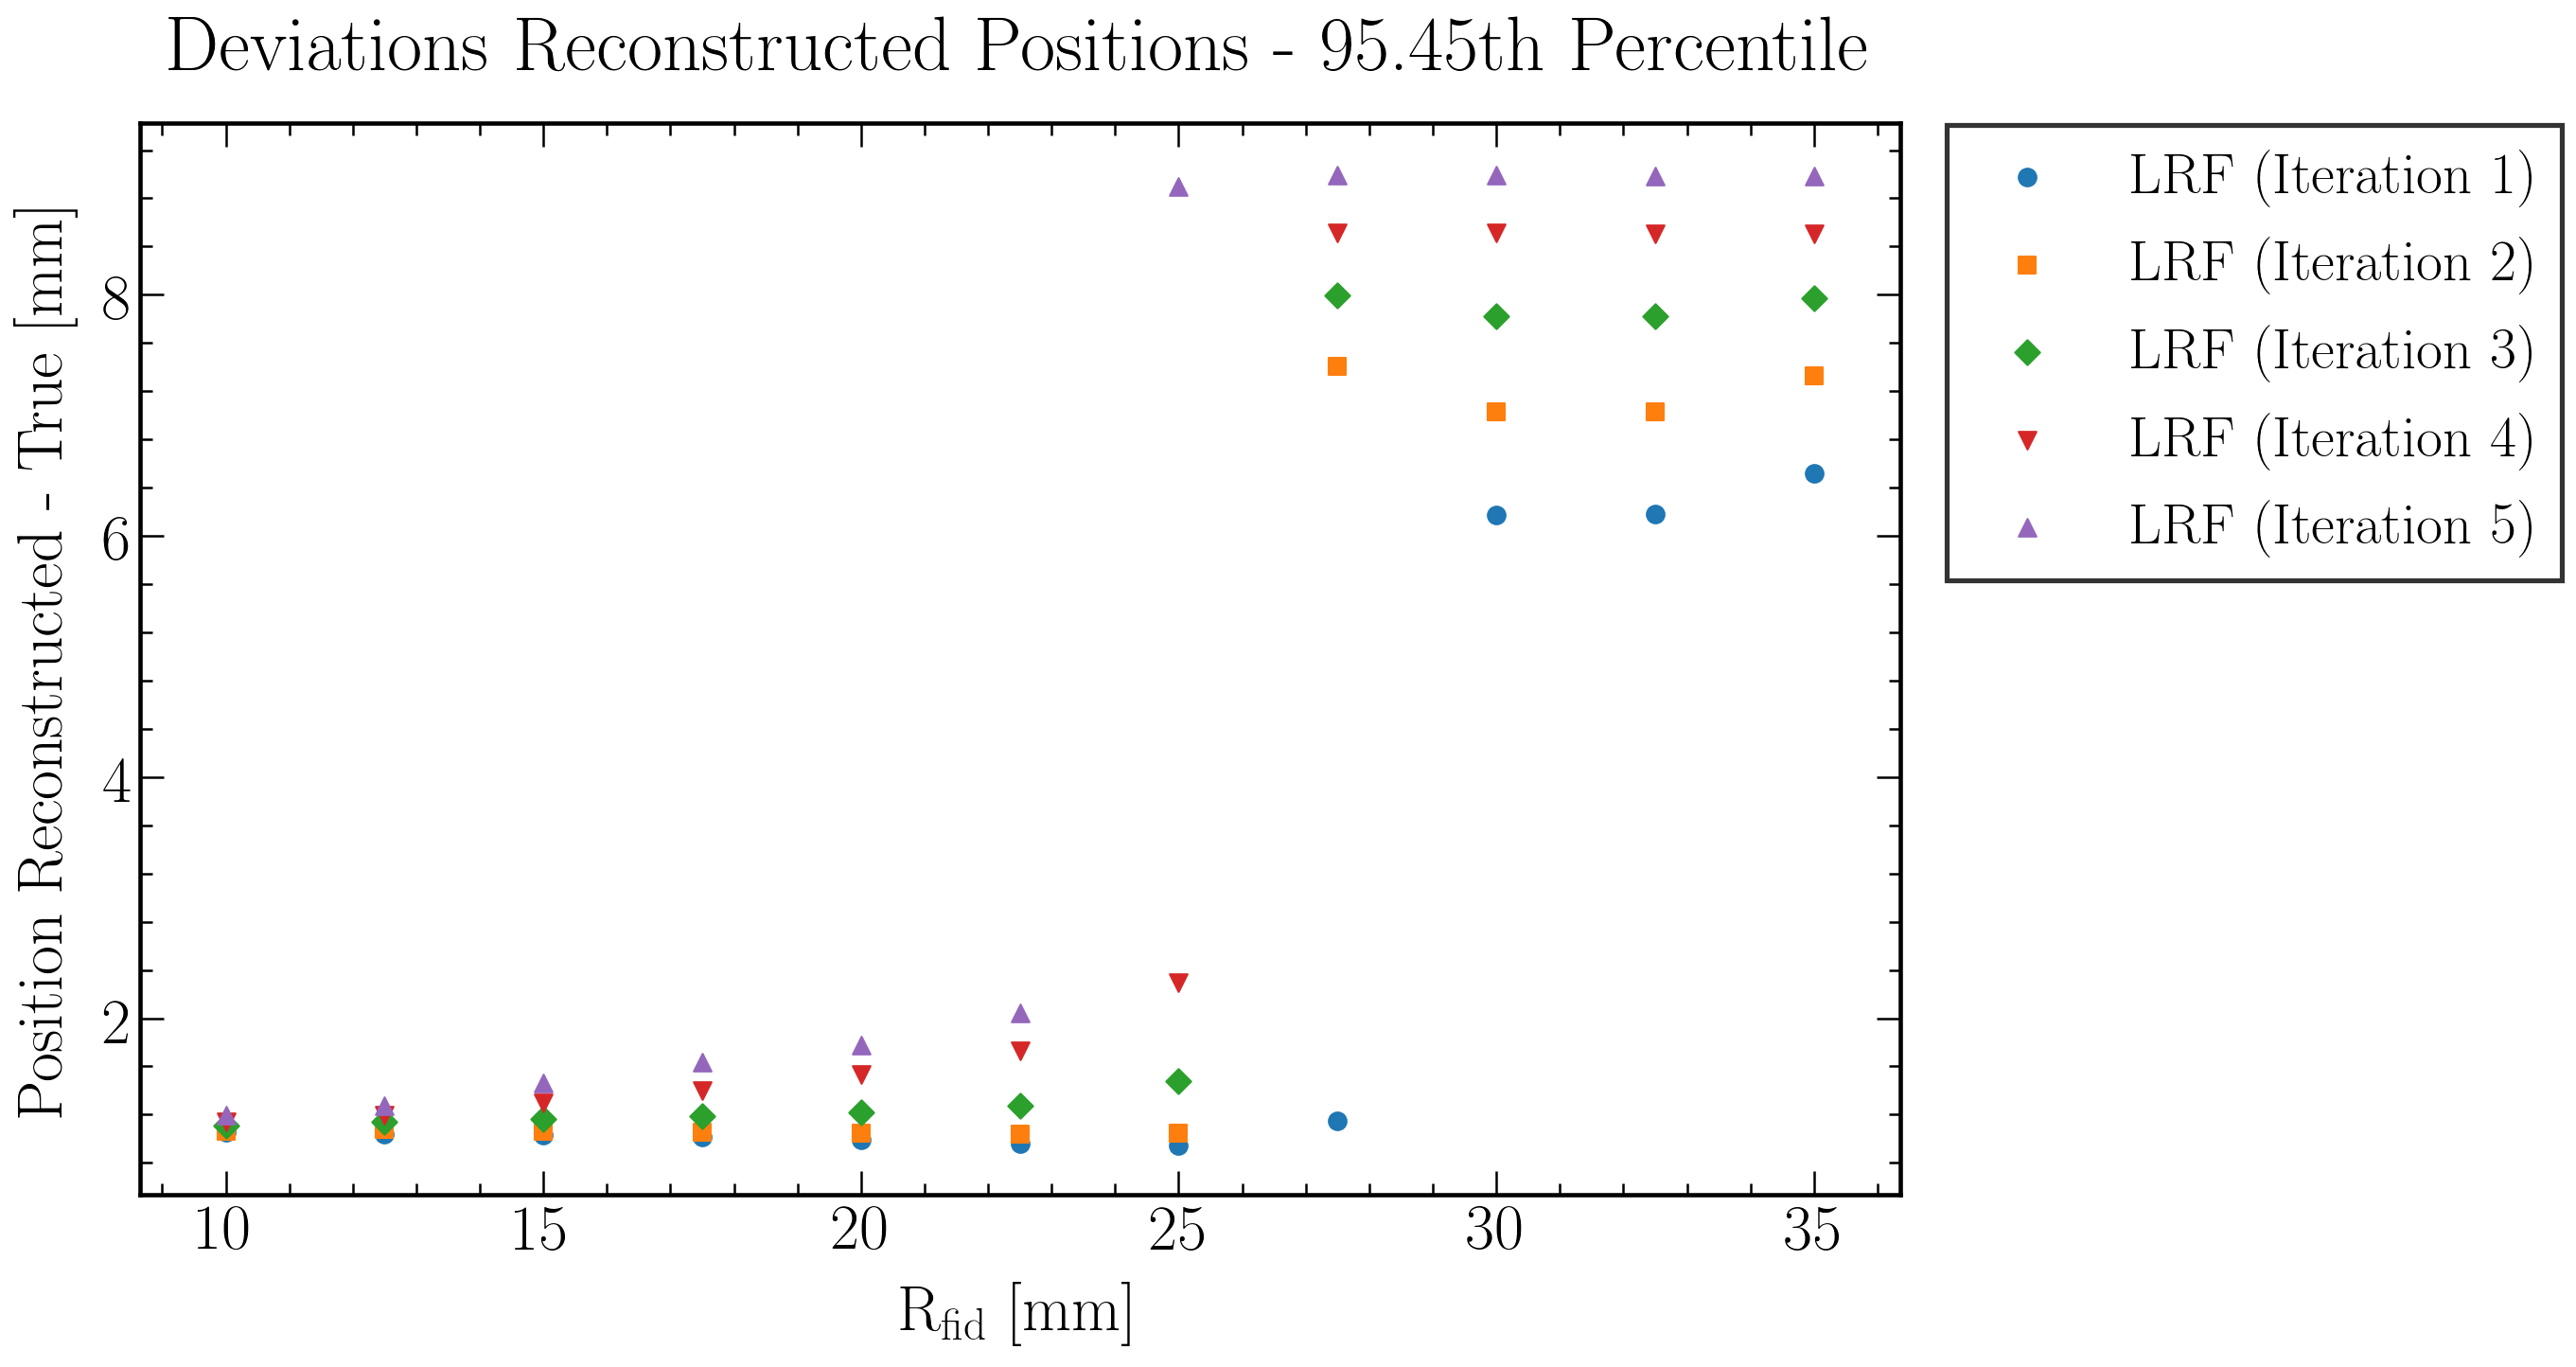

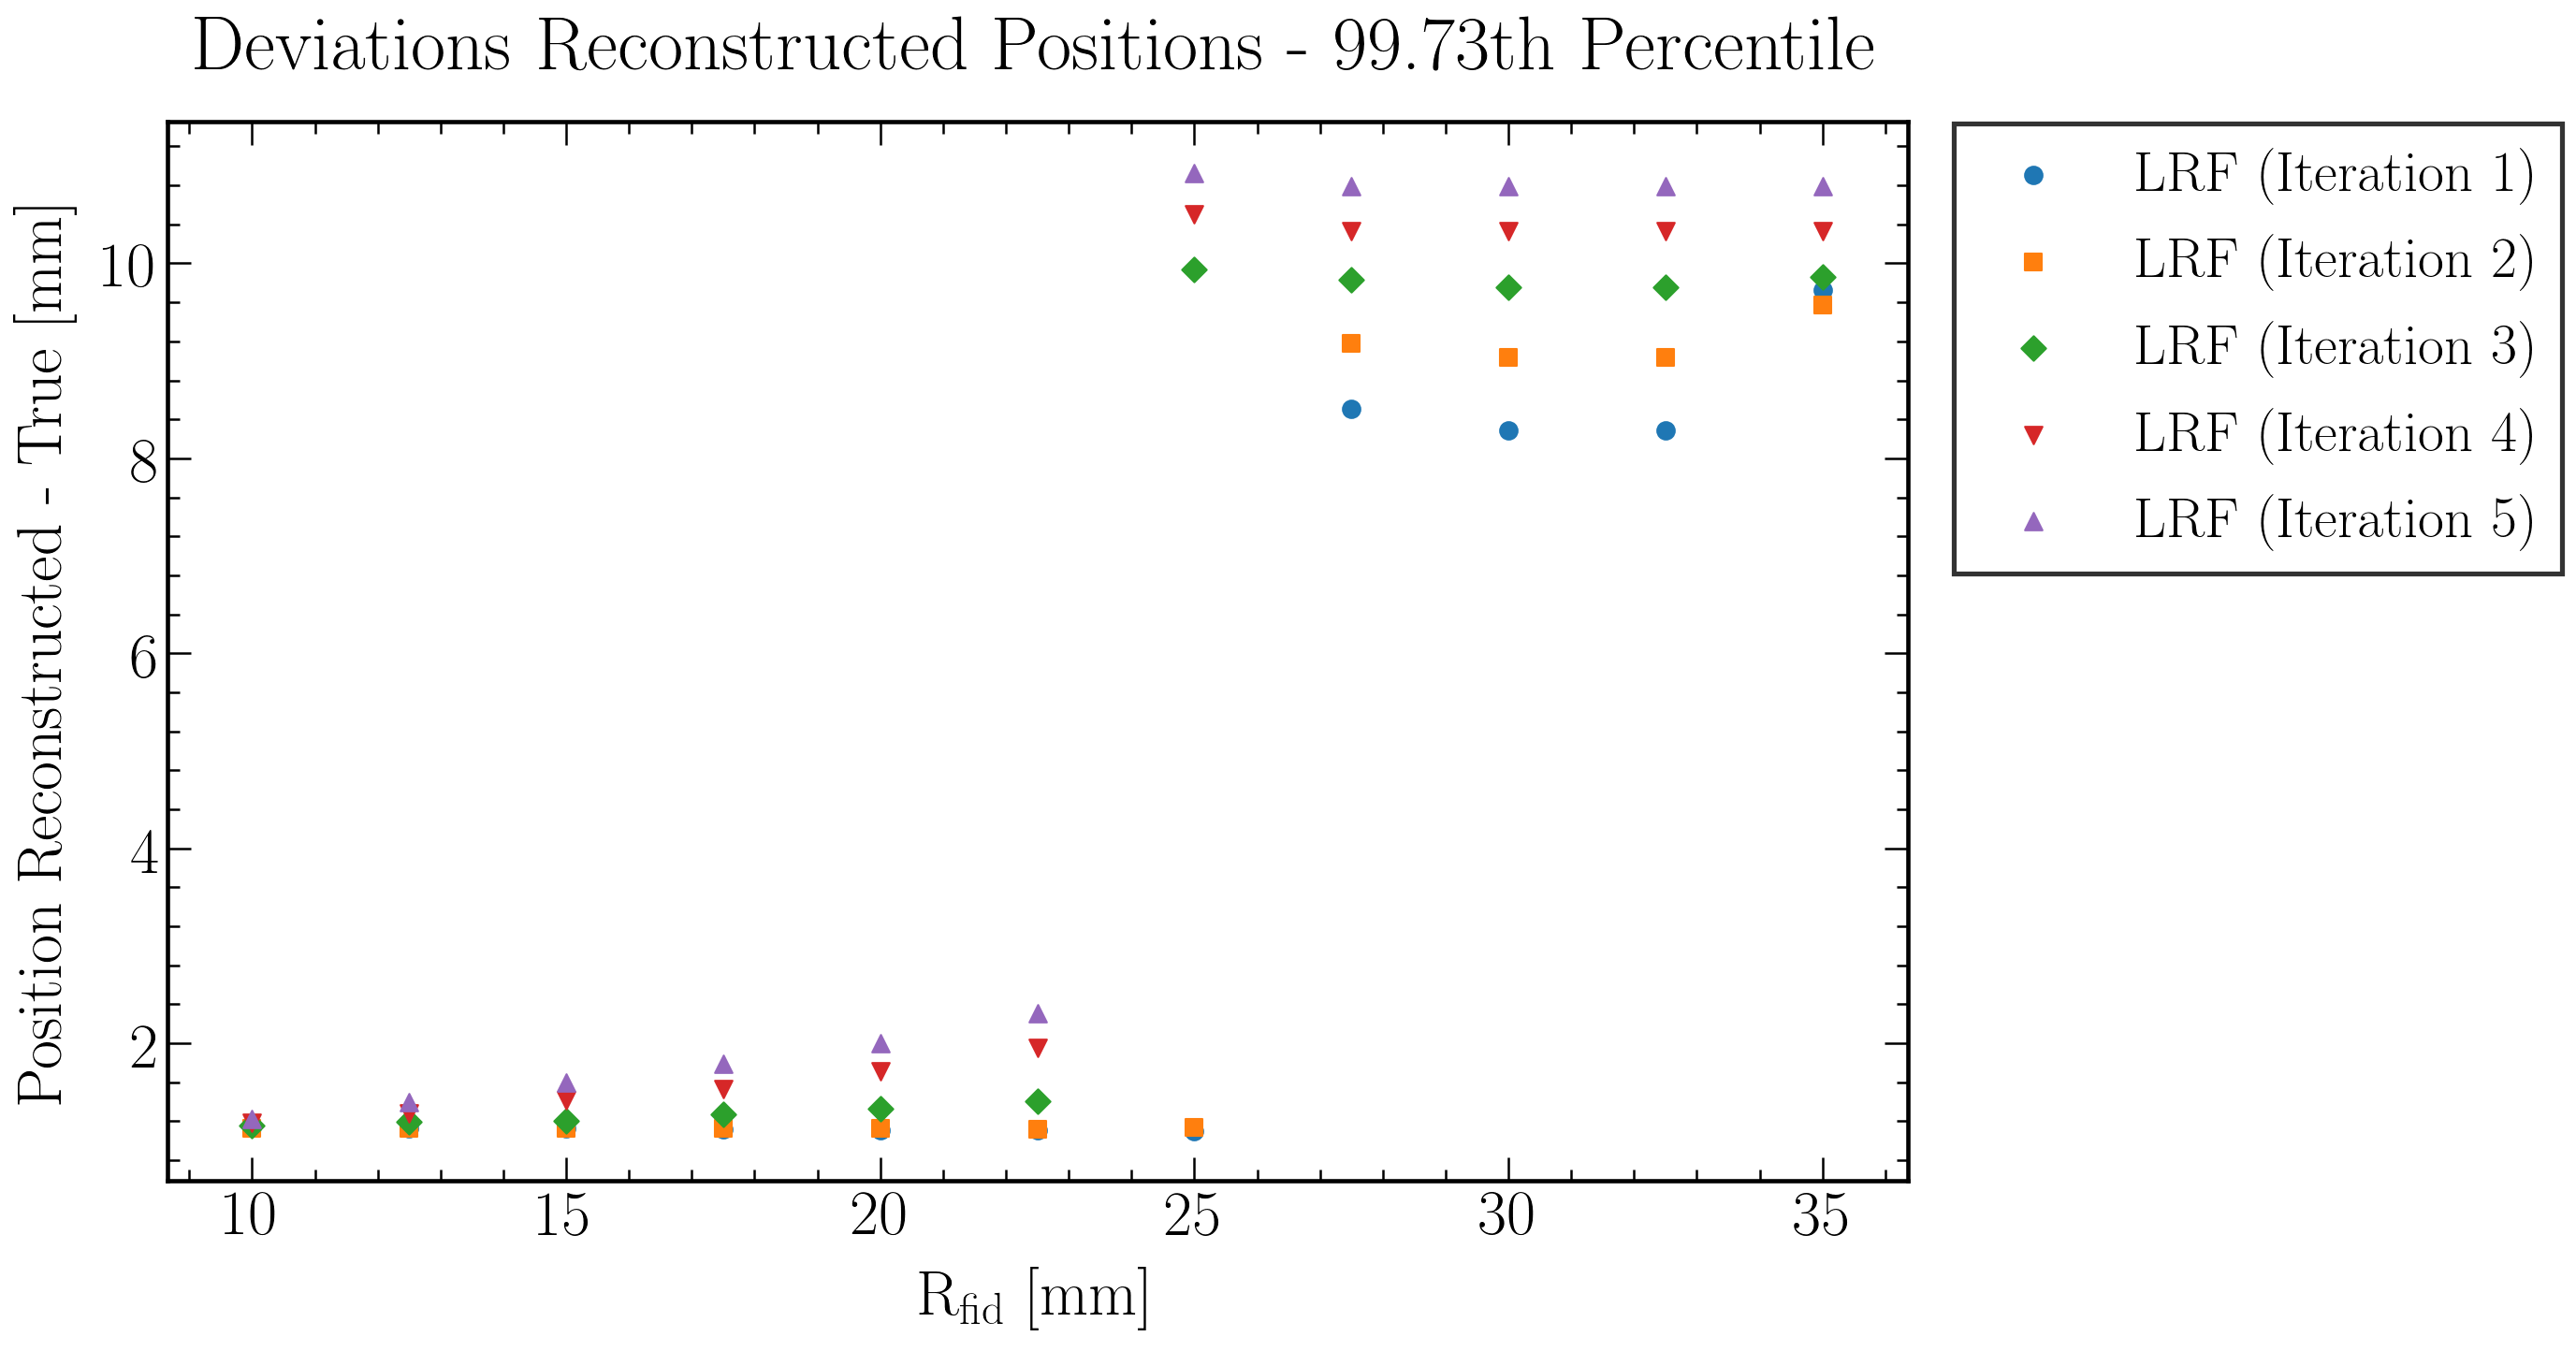

In [20]:
percentile_value_list = [50, 68.27, 95, 95.45, 99.73]

for percentile_value in percentile_value_list:

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Deviations_LRF_iteration_1['fid']
    y = df_Deviations_LRF_iteration_1['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C0', marker = 'o', s = 80)

    x = df_Deviations_LRF_iteration_2['fid']
    y = df_Deviations_LRF_iteration_2['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C1', marker = 's', s = 80)

    x = df_Deviations_LRF_iteration_3['fid']
    y = df_Deviations_LRF_iteration_3['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C2', marker = 'D', s = 80)

    x = df_Deviations_LRF_iteration_4['fid']
    y = df_Deviations_LRF_iteration_4['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C3', marker = 'v', s = 80)

    x = df_Deviations_LRF_iteration_5['fid']
    y = df_Deviations_LRF_iteration_5['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C4', marker = '^', s = 80)

    plt.ylabel('Position Reconstructed - True [mm]', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Deviations Reconstructed Positions - '+str(percentile_value)+'th Percentile', fontsize = title_size, pad = title_pad)

    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_LRF_ReconstructedPosition_Deviations_"+str(percentile_value)+"Percentiles.png", bbox_inches = "tight")
    plt.show()

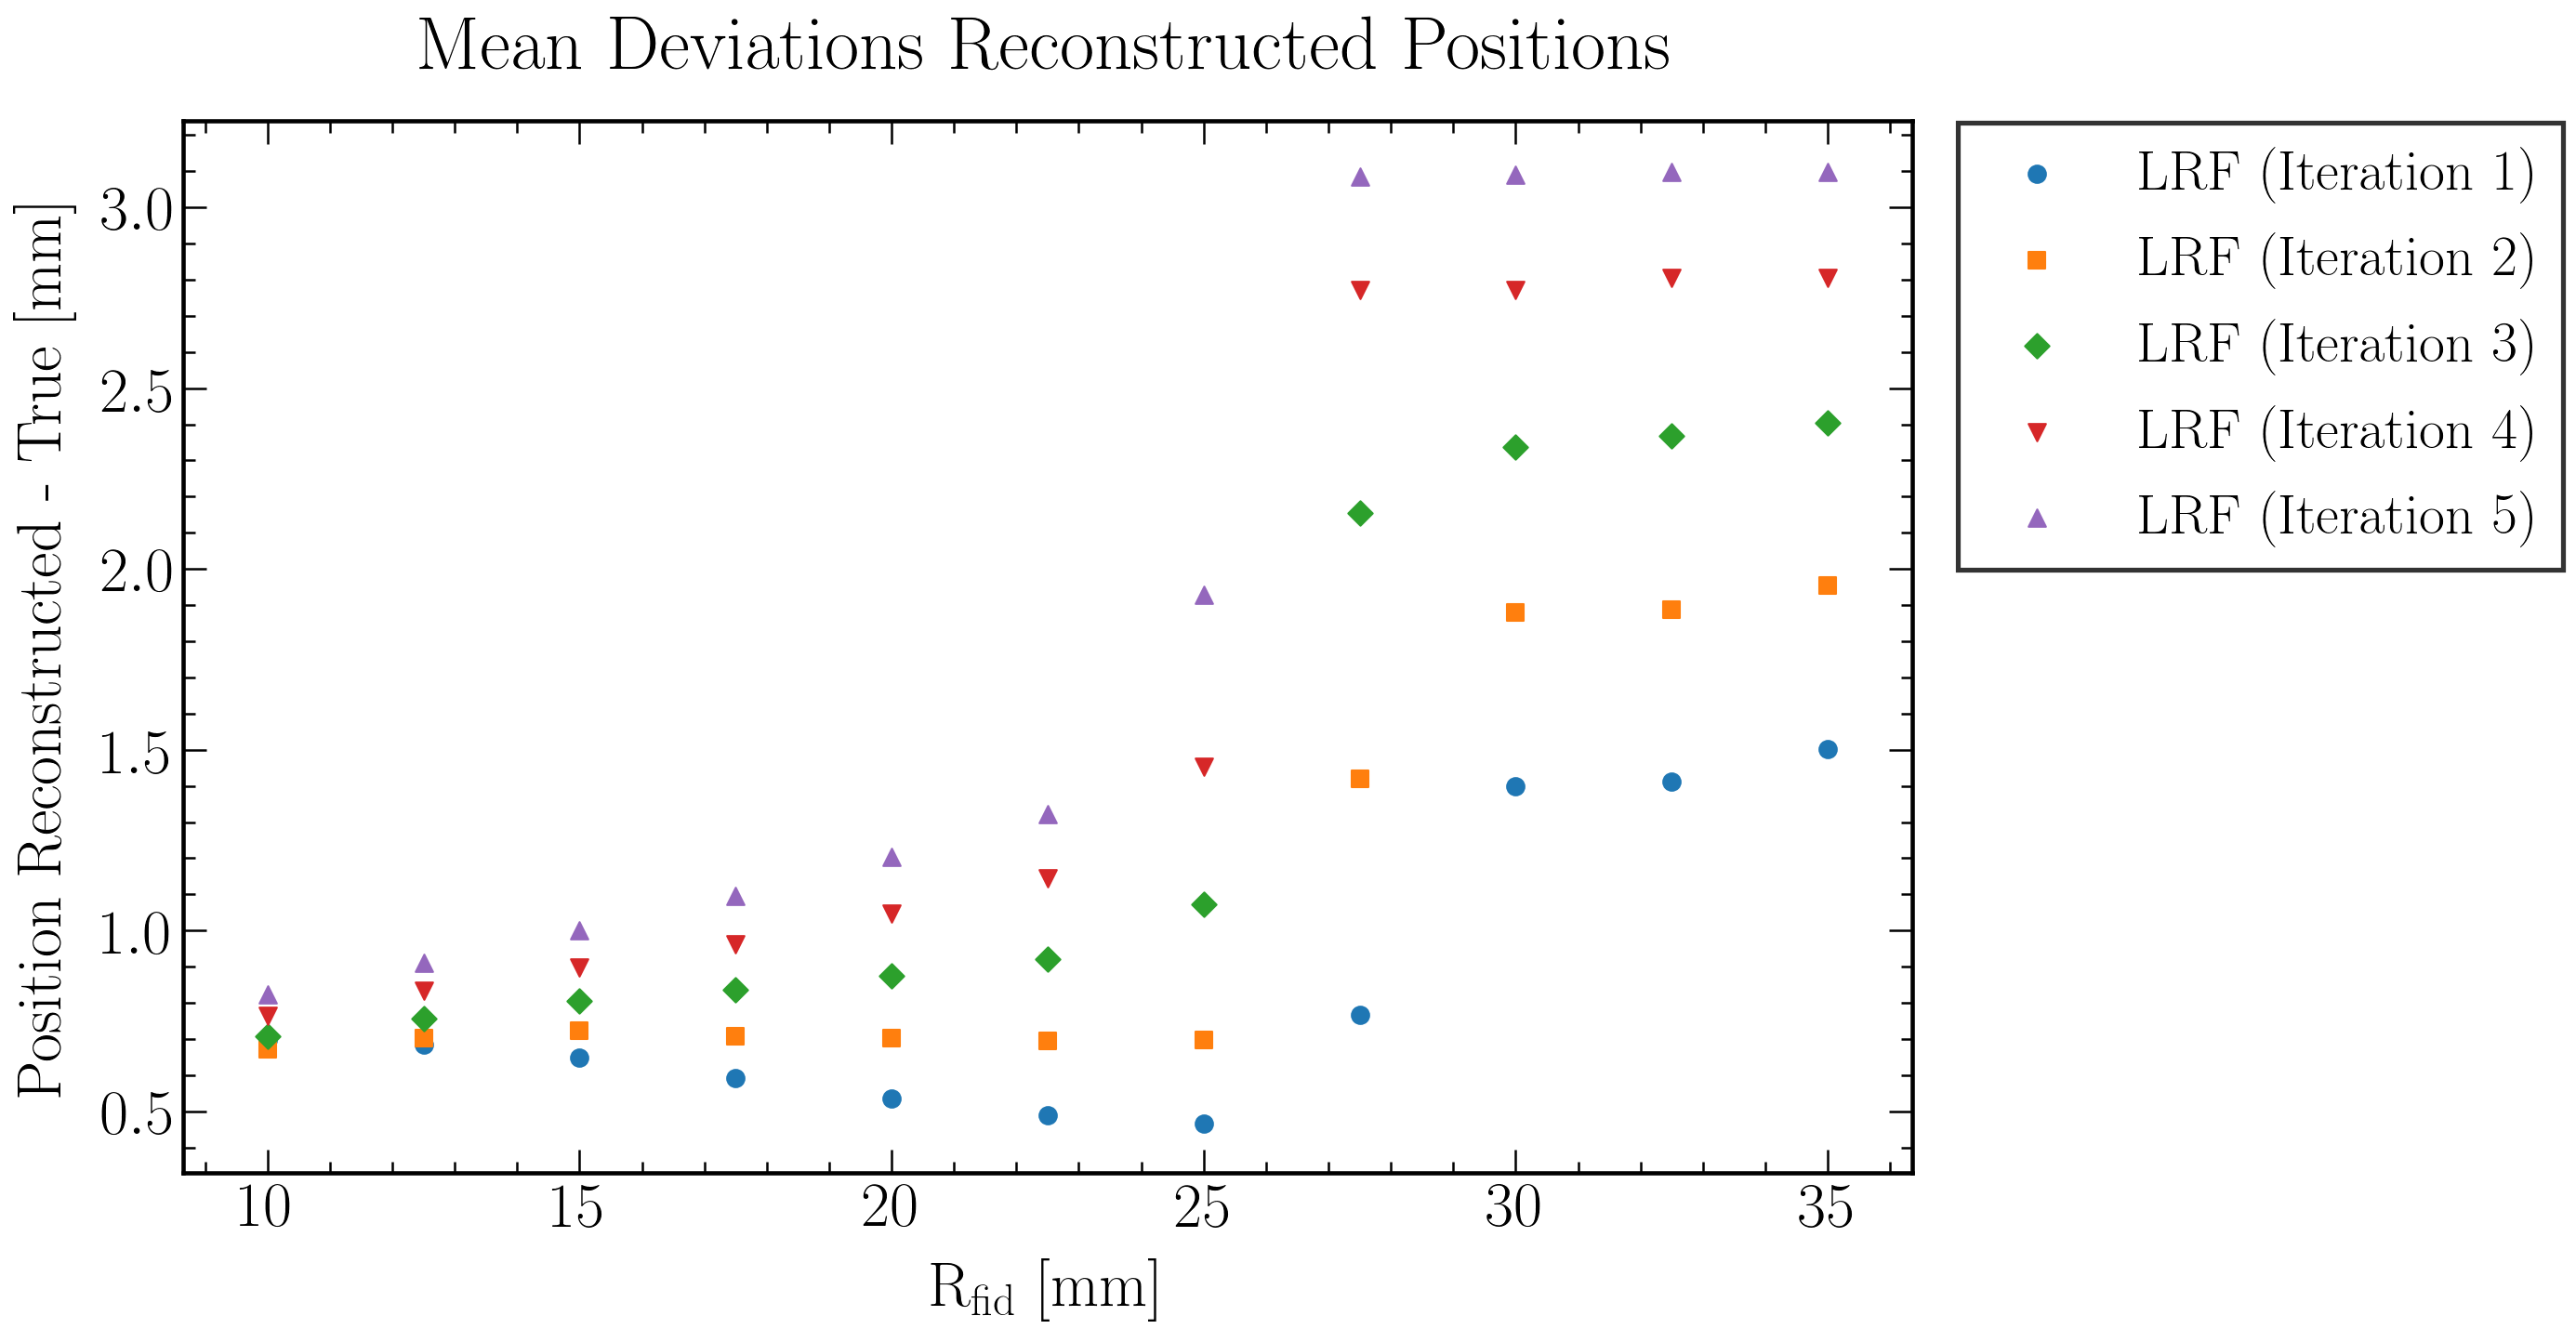

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

#############################################
## Plot specific settings and plot data
#############################################

# Data plot

x = df_Deviations_LRF_iteration_1['fid']
y = df_Deviations_LRF_iteration_1['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C0', marker = 'o', s = 80)

x = df_Deviations_LRF_iteration_2['fid']
y = df_Deviations_LRF_iteration_2['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C1', marker = 's', s = 80)

x = df_Deviations_LRF_iteration_3['fid']
y = df_Deviations_LRF_iteration_3['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C2', marker = 'D', s = 80)

x = df_Deviations_LRF_iteration_4['fid']
y = df_Deviations_LRF_iteration_4['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C3', marker = 'v', s = 80)

x = df_Deviations_LRF_iteration_5['fid']
y = df_Deviations_LRF_iteration_5['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C4', marker = '^', s = 80)

plt.ylabel('Position Reconstructed - True [mm]', fontsize = label_size, labelpad = label_pad)
plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Mean Deviations Reconstructed Positions', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig("Comparison_LRF_ReconstructedPosition_Deviations_Means.png", bbox_inches = "tight")
plt.show()

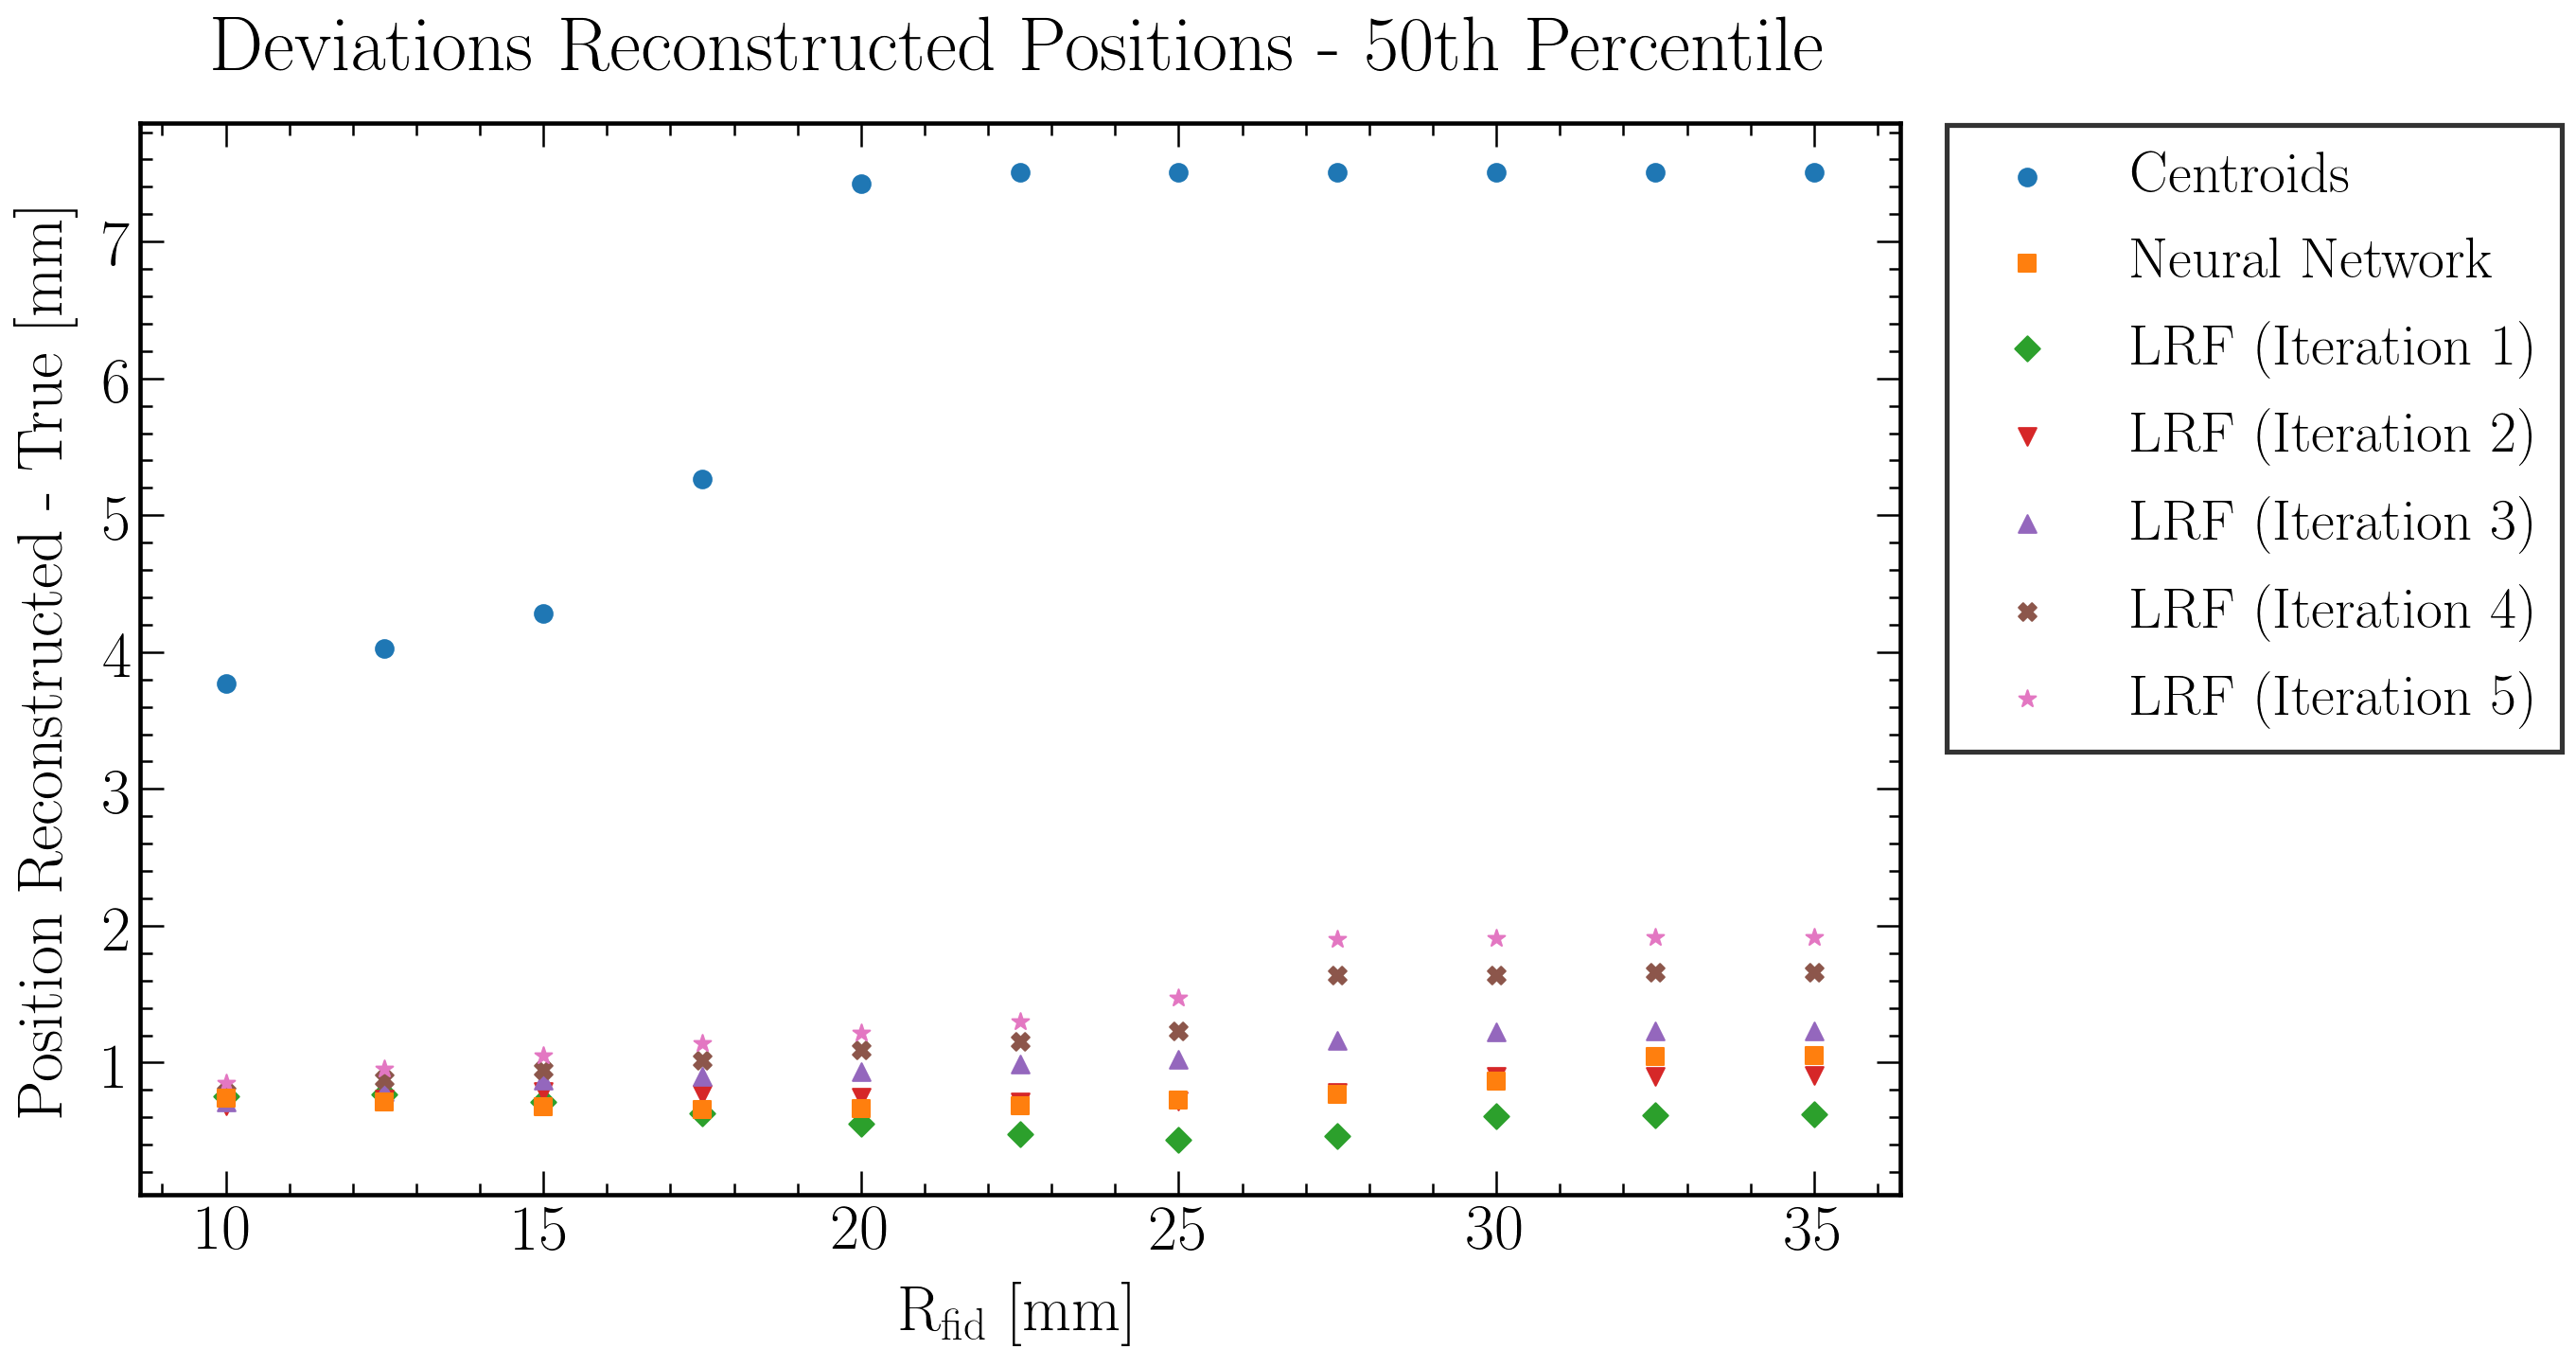

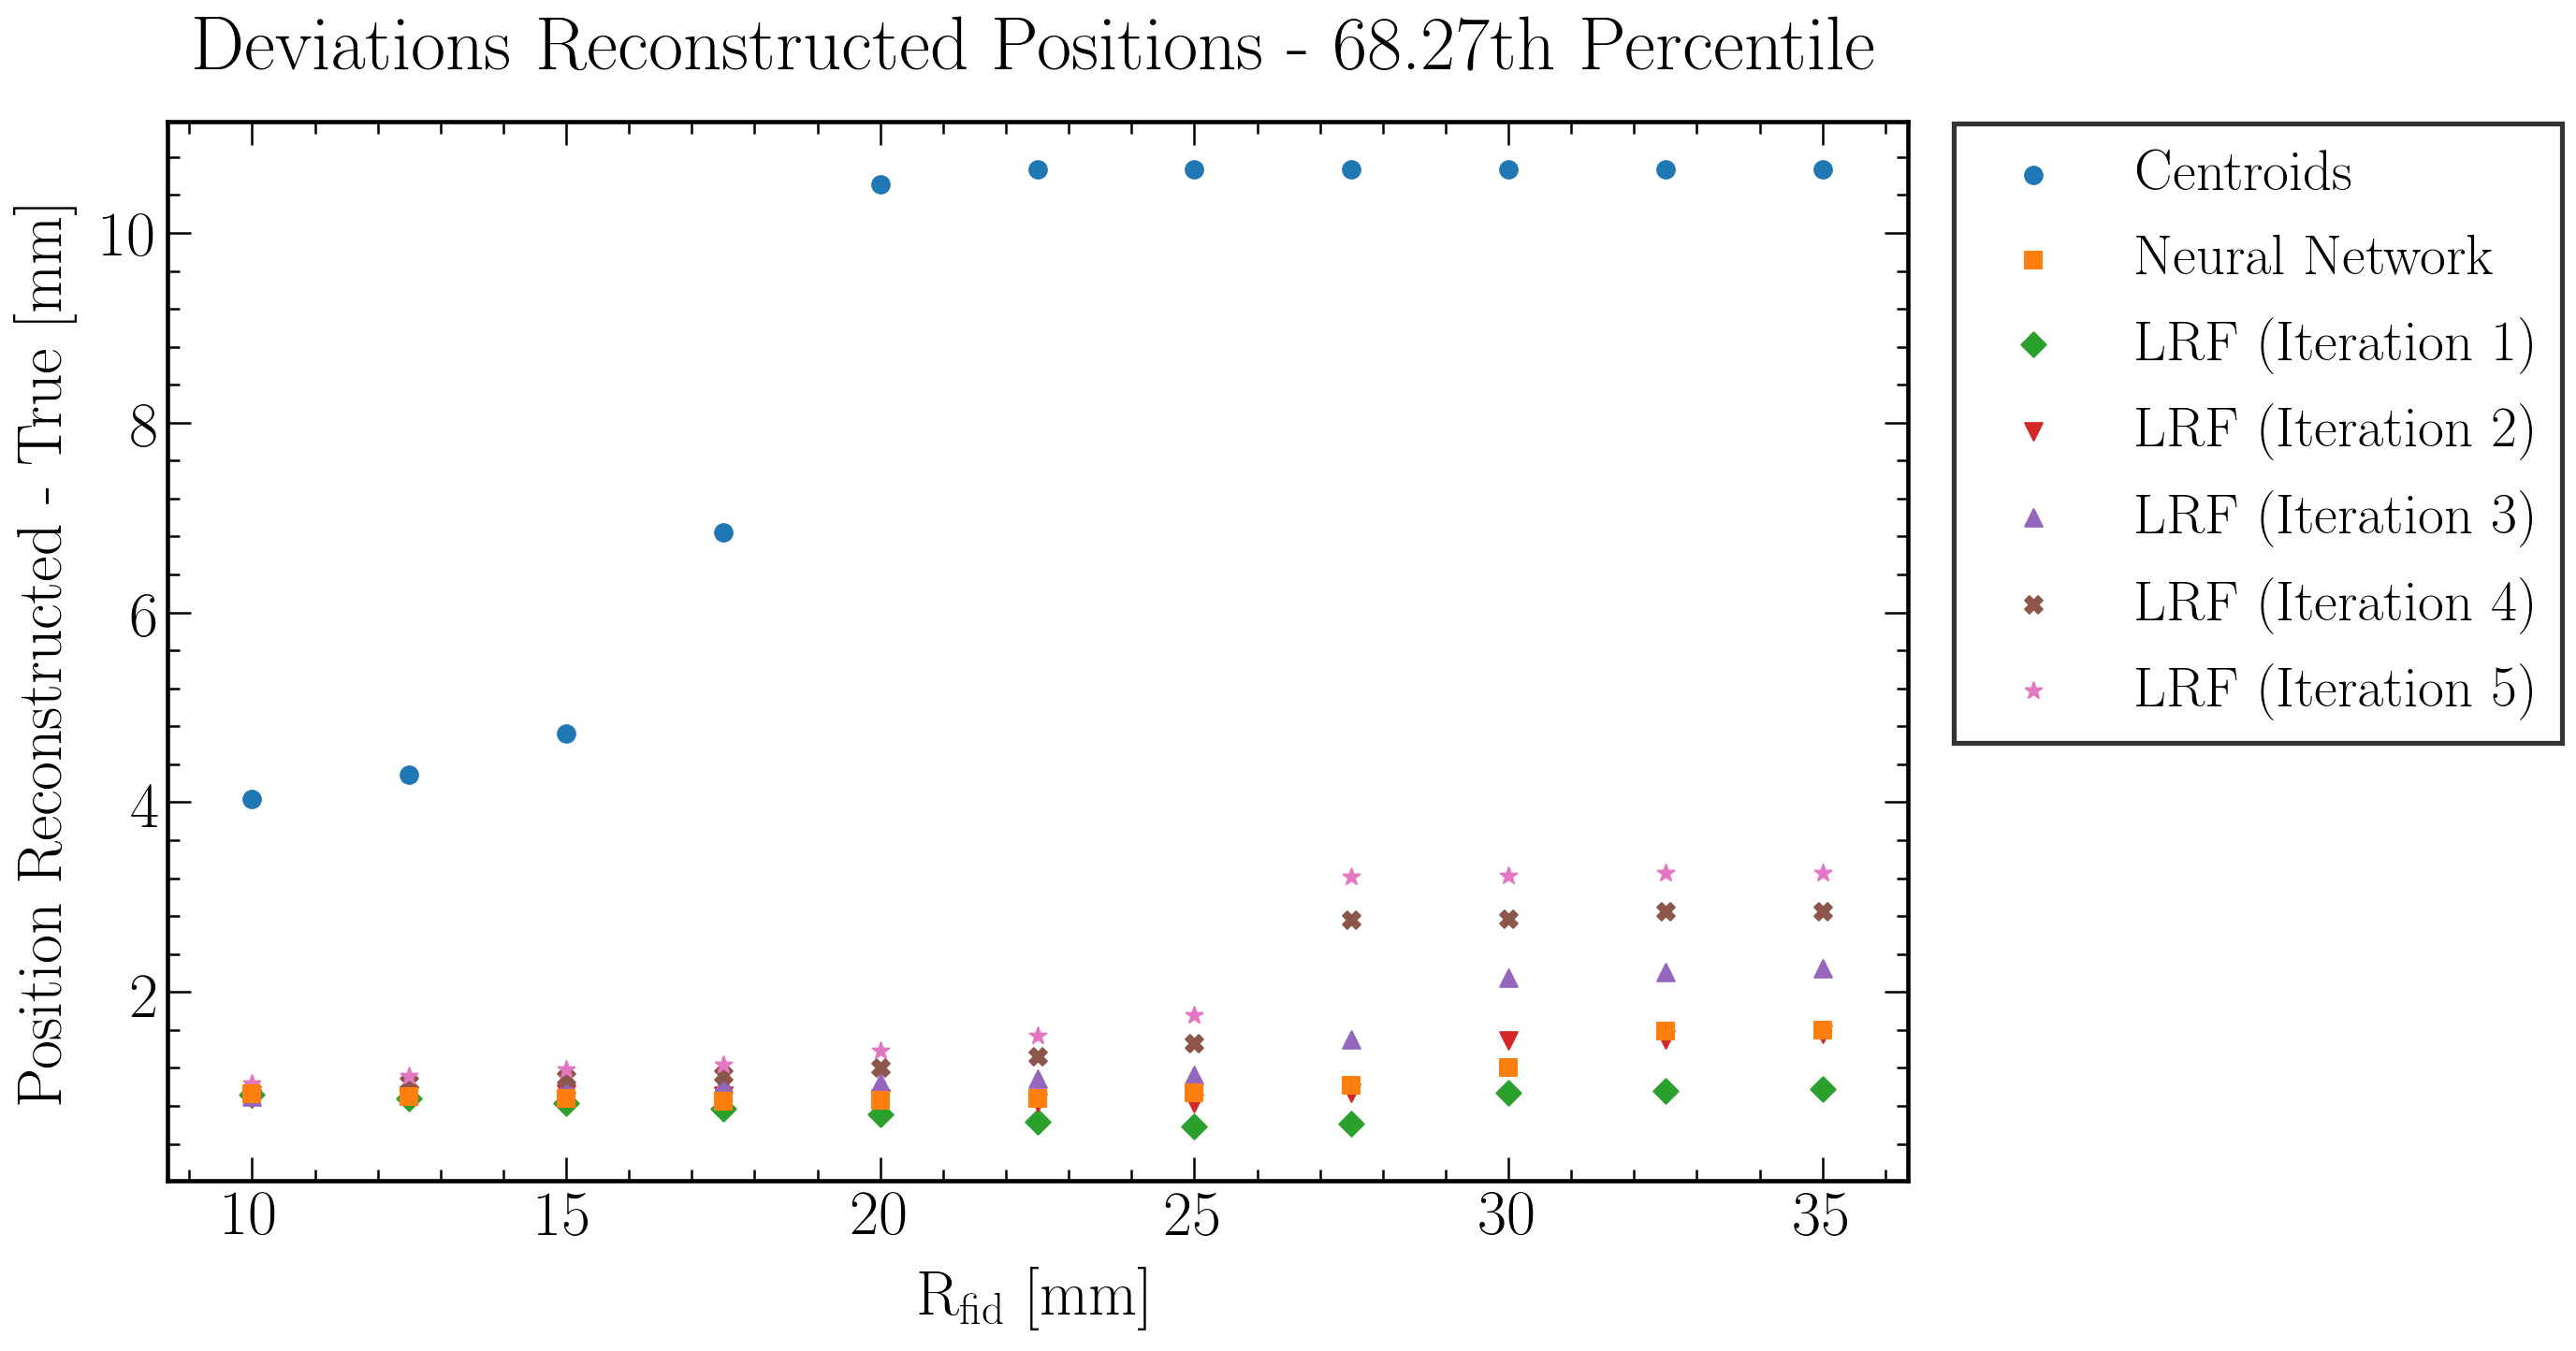

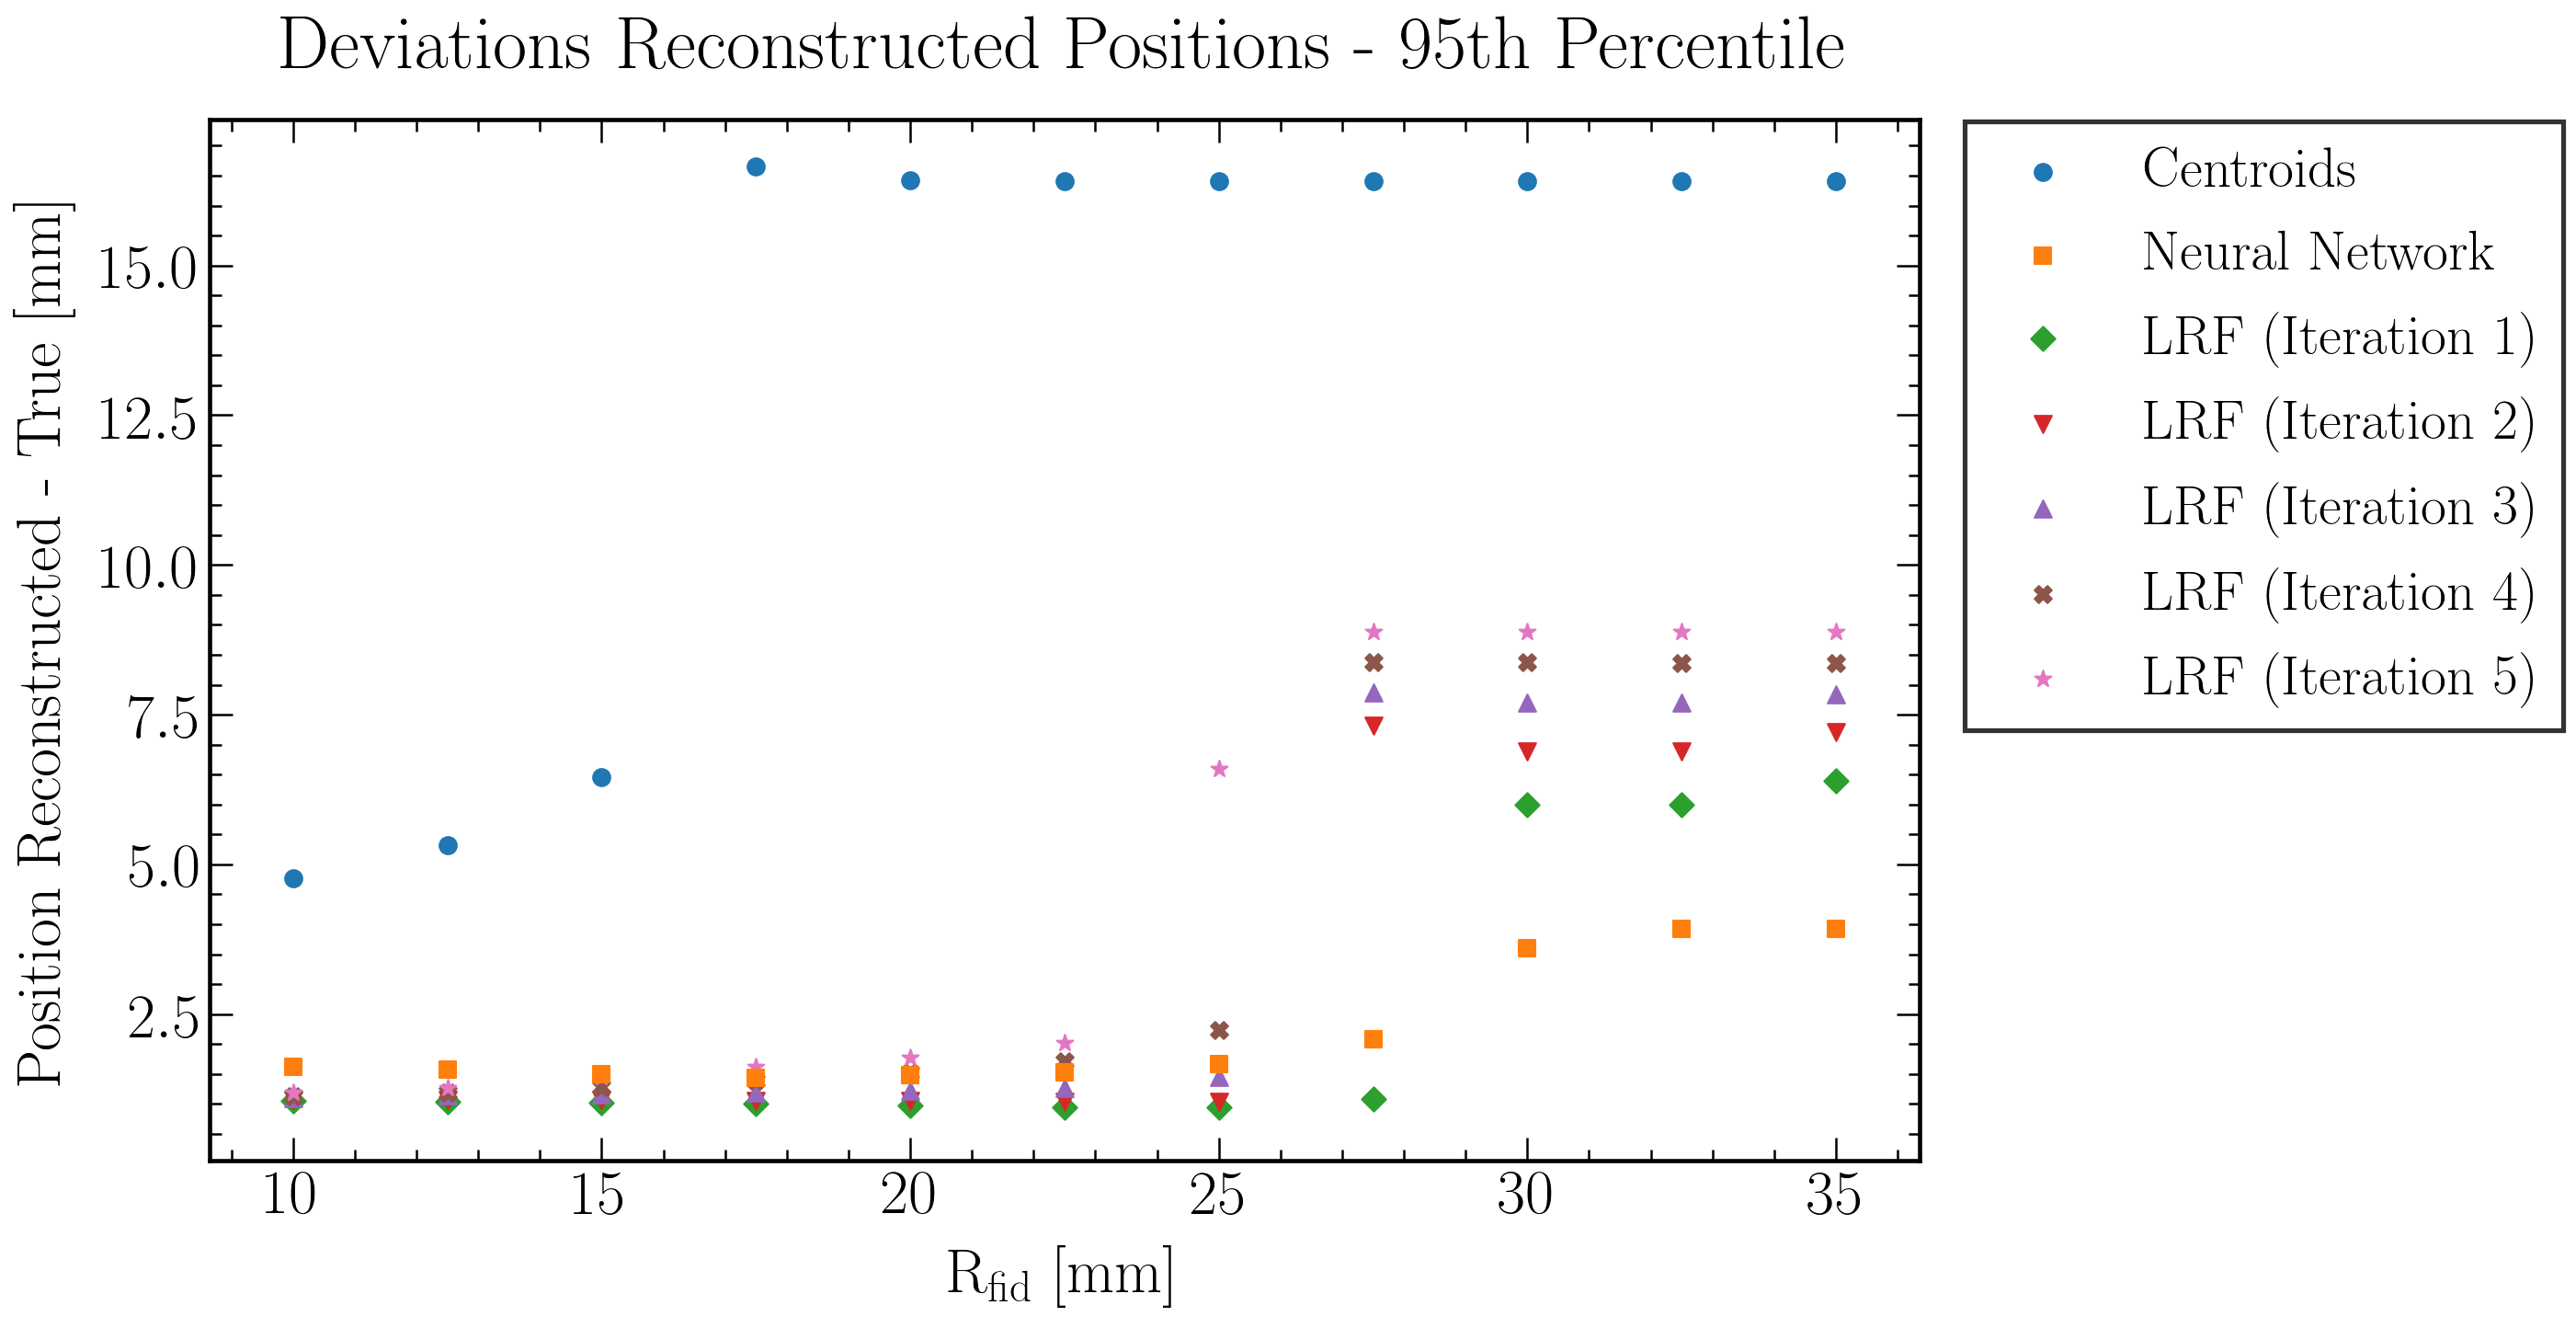

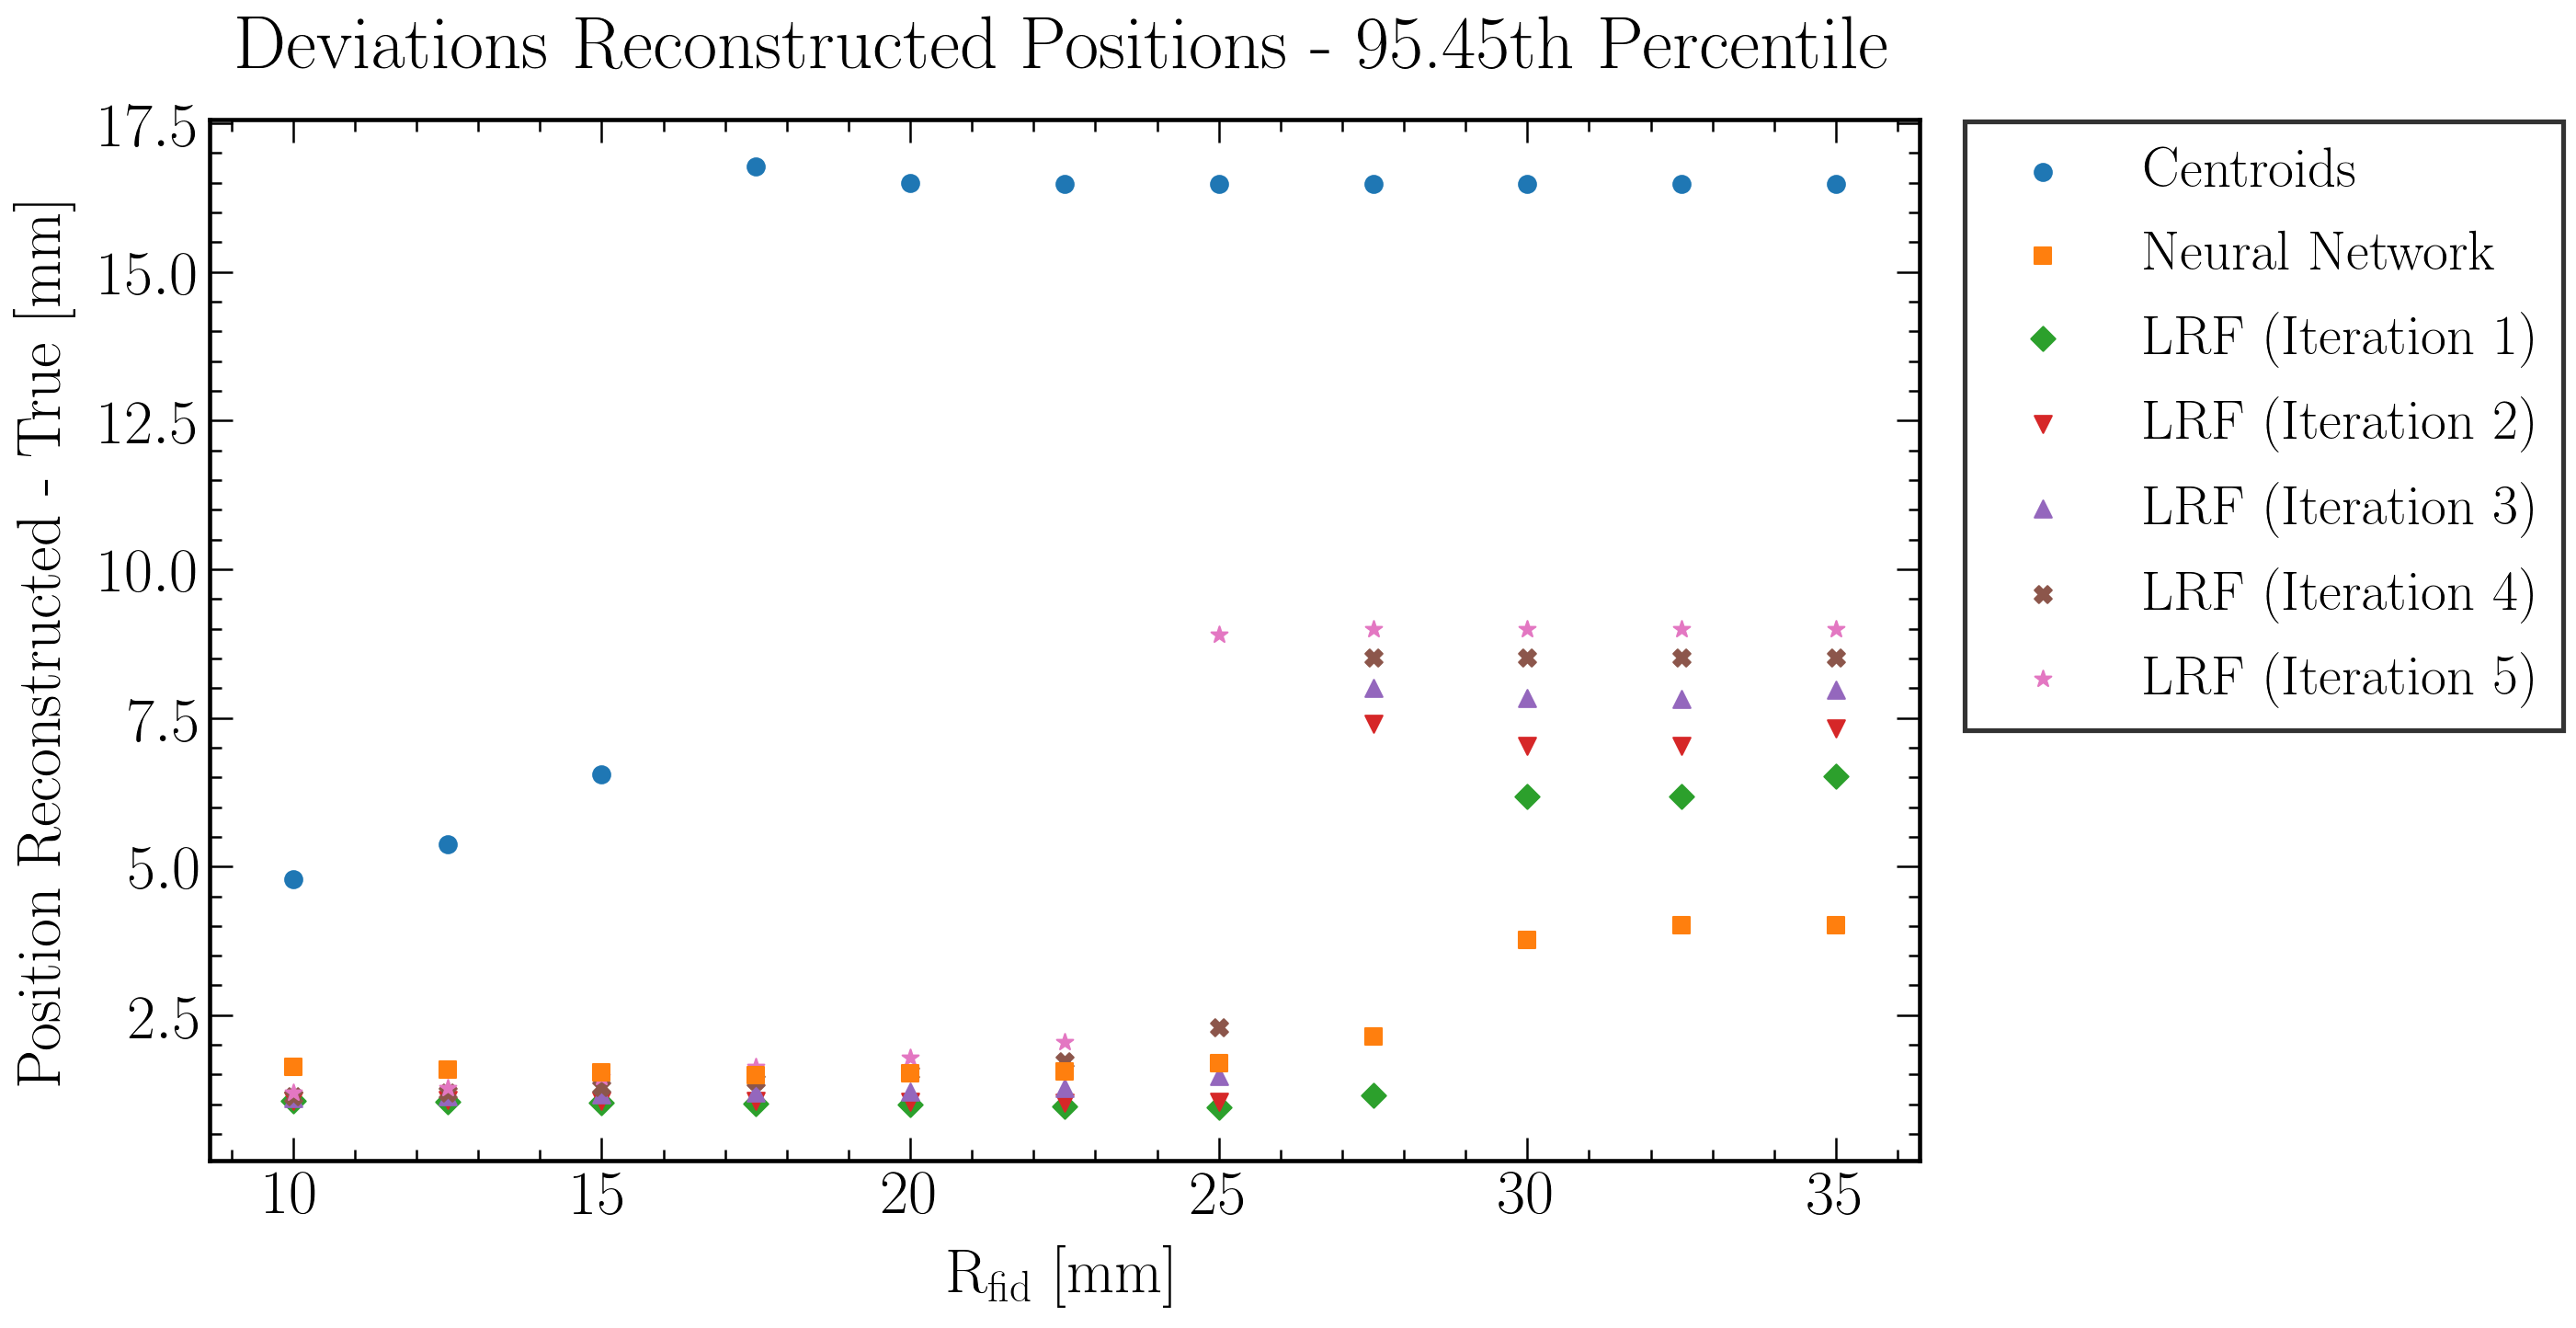

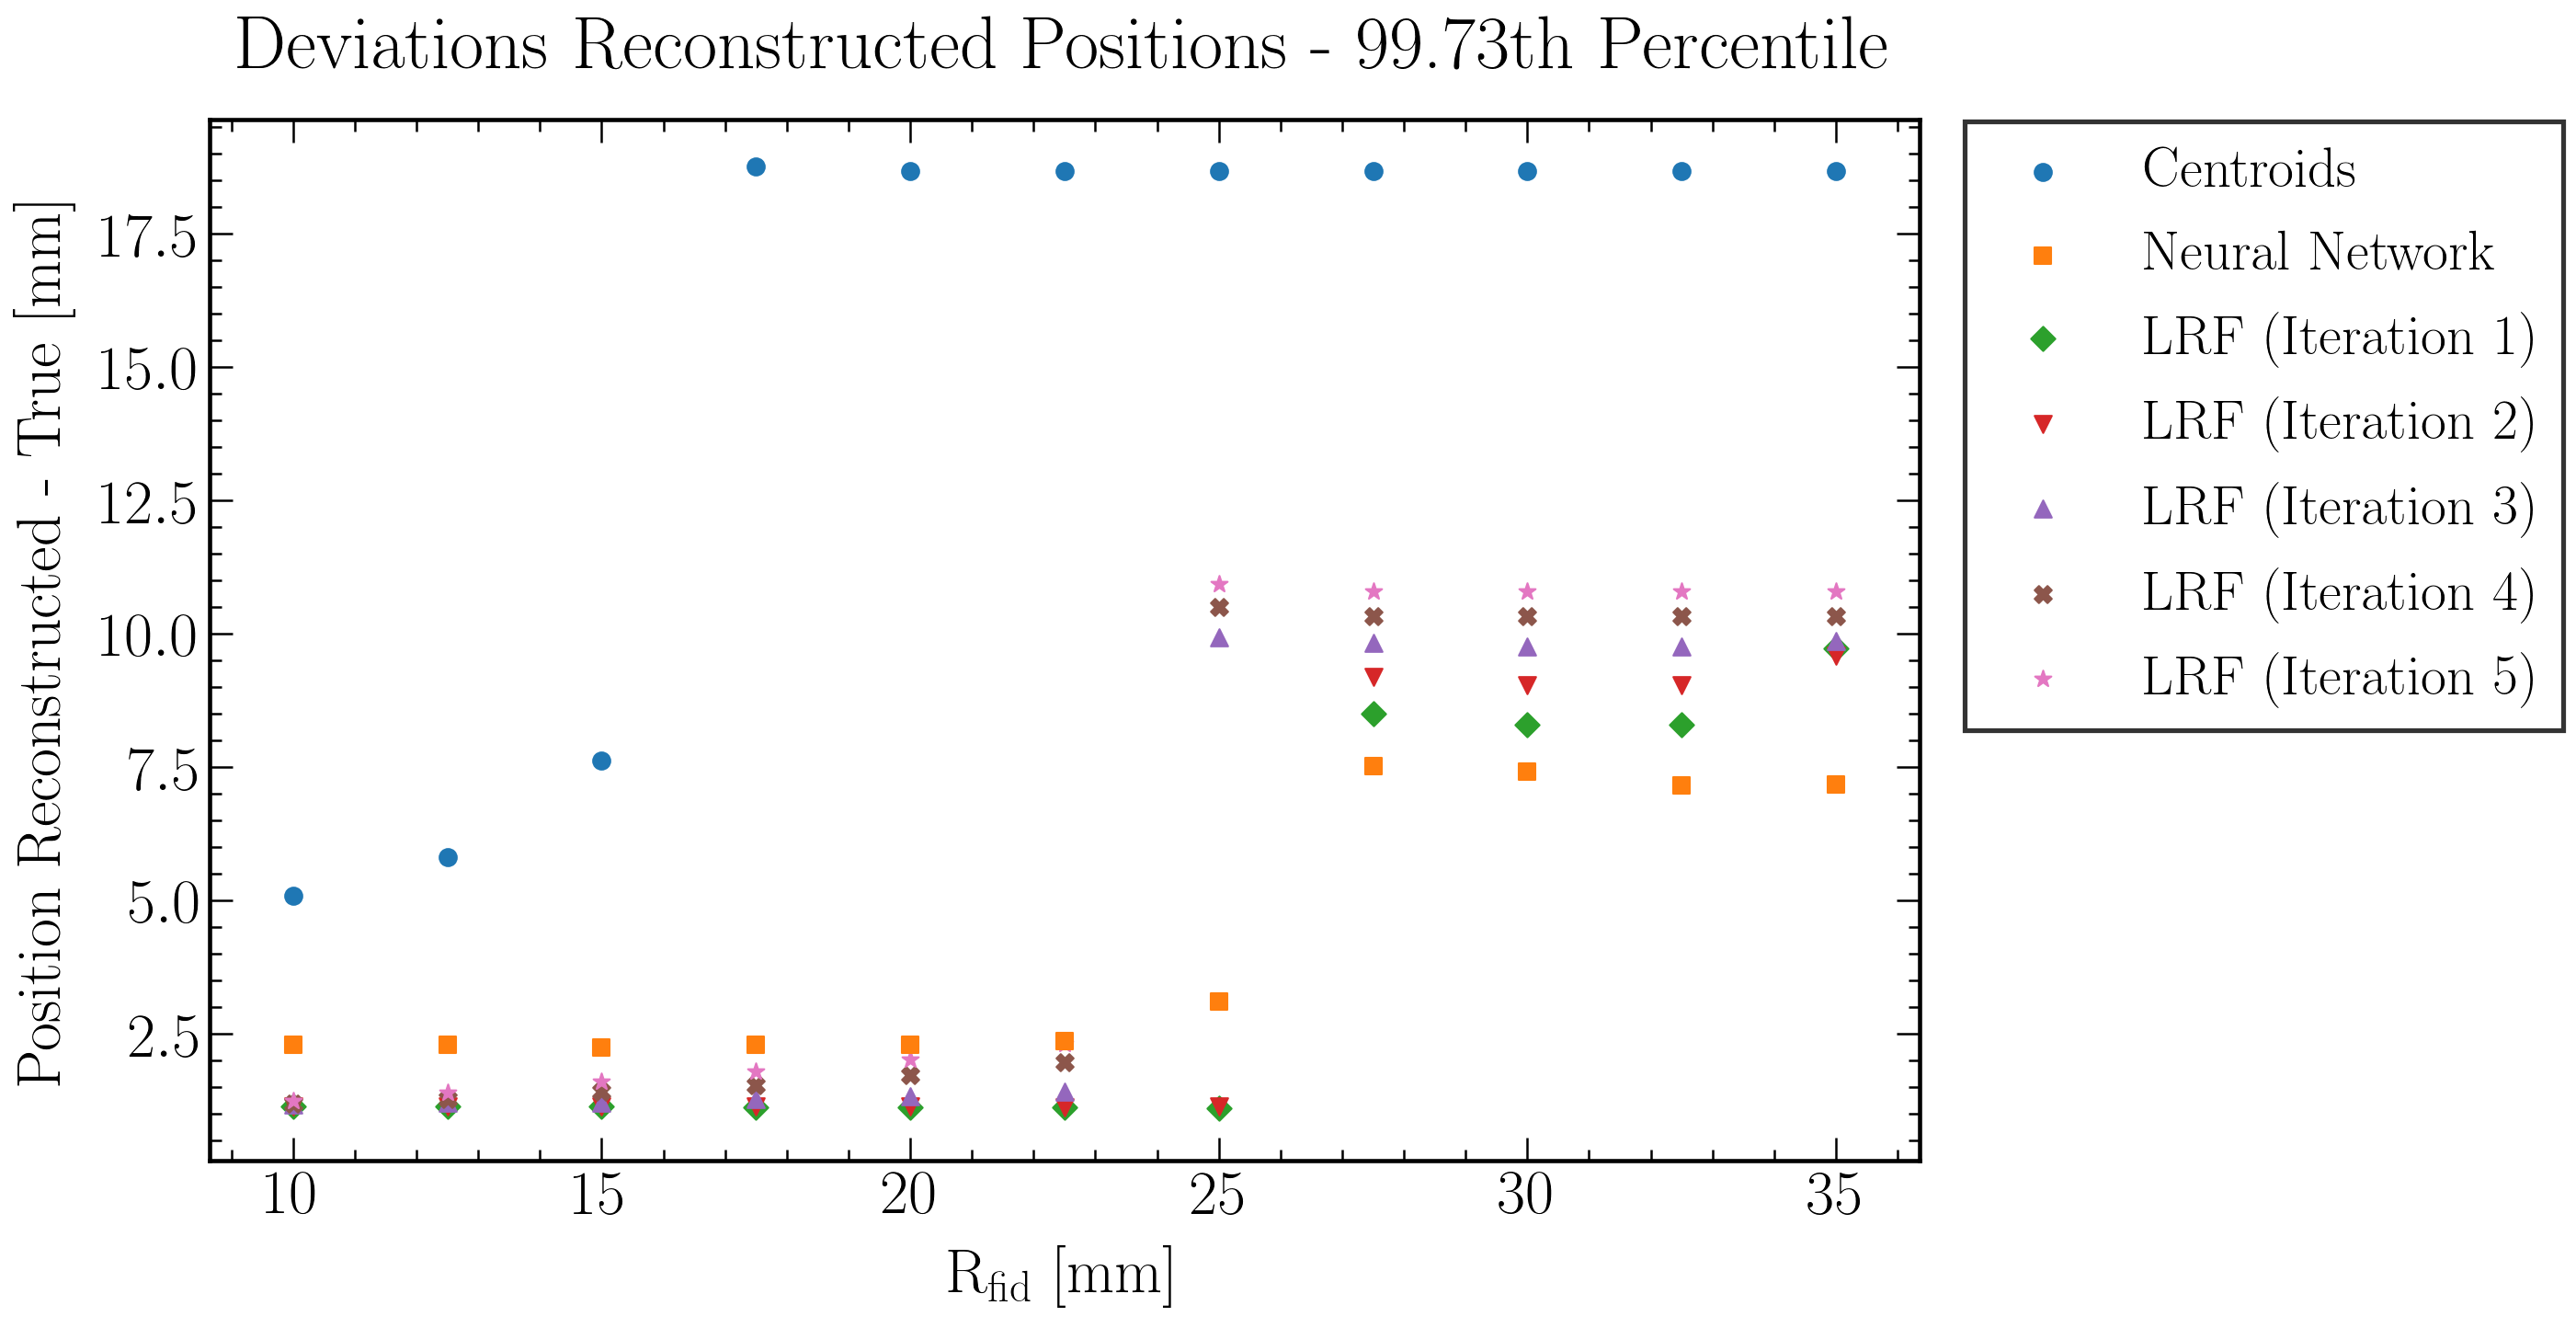

In [22]:
percentile_value_list = [50, 68.27, 95, 95.45, 99.73]

for percentile_value in percentile_value_list:

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Deviations_Centroids['fid']
    y = df_Deviations_Centroids['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

    x = df_Deviations_NN['fid']
    y = df_Deviations_NN['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

    x = df_Deviations_LRF_iteration_1['fid']
    y = df_Deviations_LRF_iteration_1['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

    x = df_Deviations_LRF_iteration_2['fid']
    y = df_Deviations_LRF_iteration_2['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

    x = df_Deviations_LRF_iteration_3['fid']
    y = df_Deviations_LRF_iteration_3['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

    x = df_Deviations_LRF_iteration_4['fid']
    y = df_Deviations_LRF_iteration_4['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

    x = df_Deviations_LRF_iteration_5['fid']
    y = df_Deviations_LRF_iteration_5['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

    plt.ylabel('Position Reconstructed - True [mm]', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Deviations Reconstructed Positions - '+str(percentile_value)+'th Percentile', fontsize = title_size, pad = title_pad)

    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_All_ReconstructedPosition_Deviations_"+str(percentile_value)+"Percentiles.png", bbox_inches = "tight")
    plt.show()

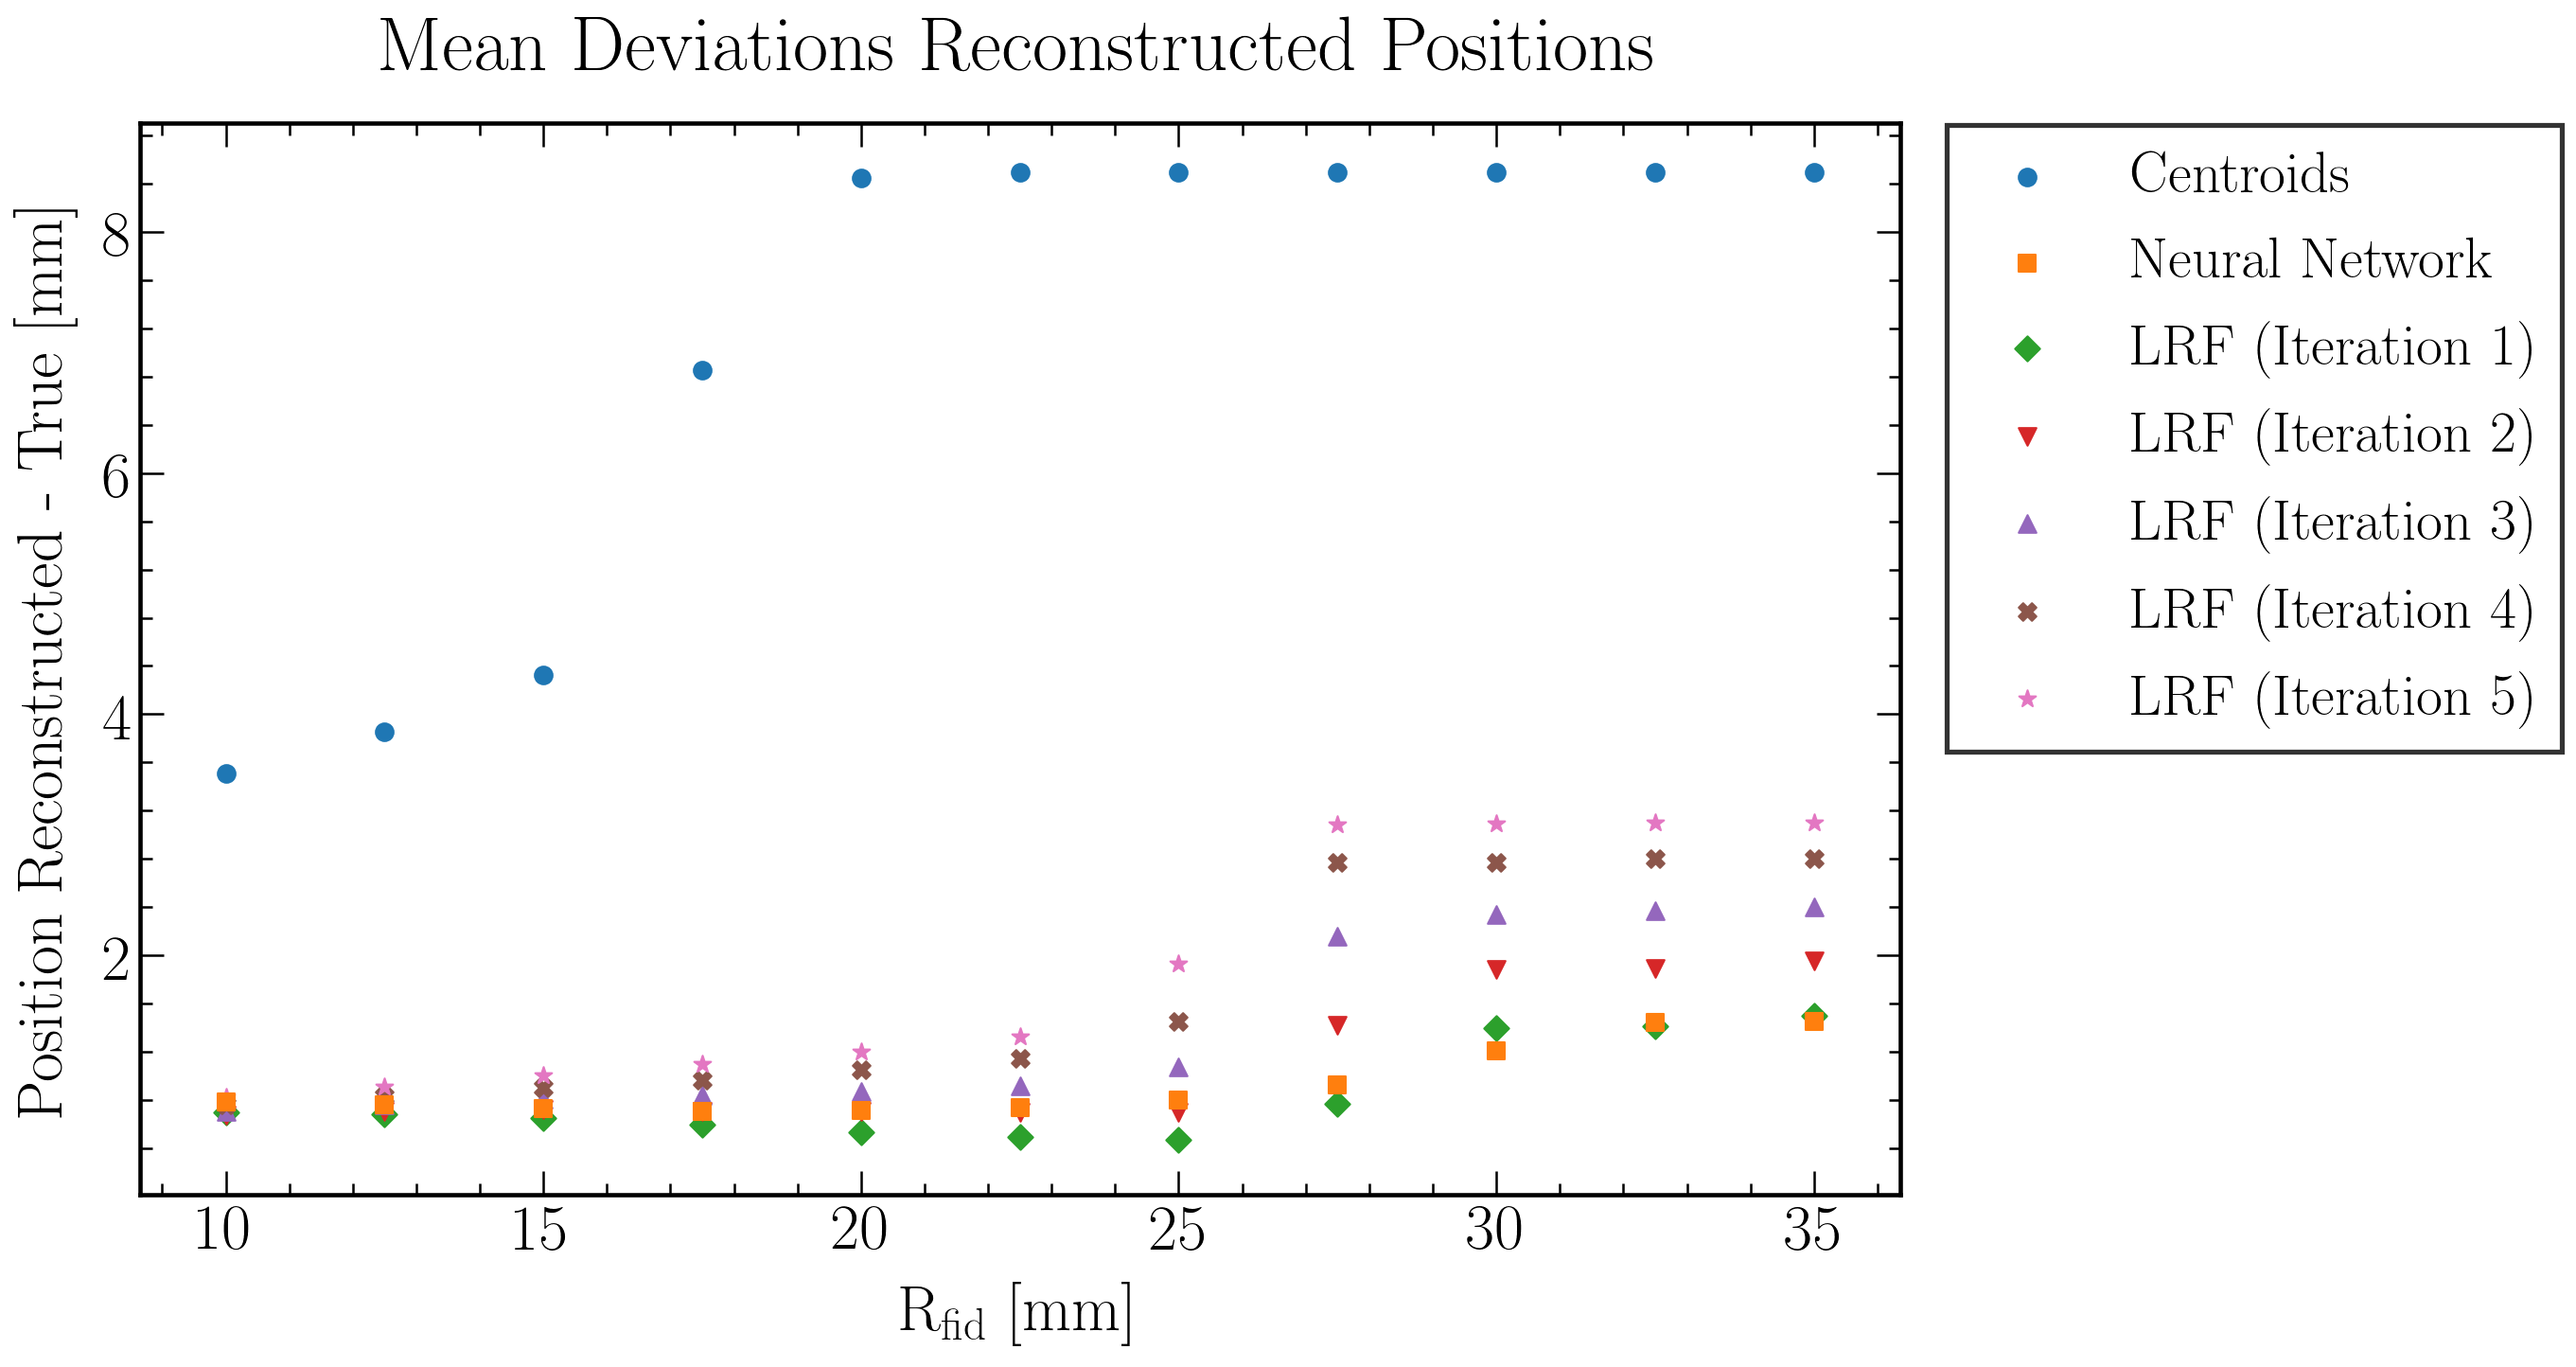

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

#############################################
## Plot specific settings and plot data
#############################################

# Data plot

x = df_Deviations_Centroids['fid']
y = df_Deviations_Centroids['delta_mean']
plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

x = df_Deviations_NN['fid']
y = df_Deviations_NN['delta_mean']
plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

x = df_Deviations_LRF_iteration_1['fid']
y = df_Deviations_LRF_iteration_1['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

x = df_Deviations_LRF_iteration_2['fid']
y = df_Deviations_LRF_iteration_2['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

x = df_Deviations_LRF_iteration_3['fid']
y = df_Deviations_LRF_iteration_3['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

x = df_Deviations_LRF_iteration_4['fid']
y = df_Deviations_LRF_iteration_4['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

x = df_Deviations_LRF_iteration_5['fid']
y = df_Deviations_LRF_iteration_5['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

plt.ylabel('Position Reconstructed - True [mm]', fontsize = label_size, labelpad = label_pad)
plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Mean Deviations Reconstructed Positions', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig("Comparison_All_ReconstructedPosition_Deviations_Means.png", bbox_inches = "tight")
plt.show()

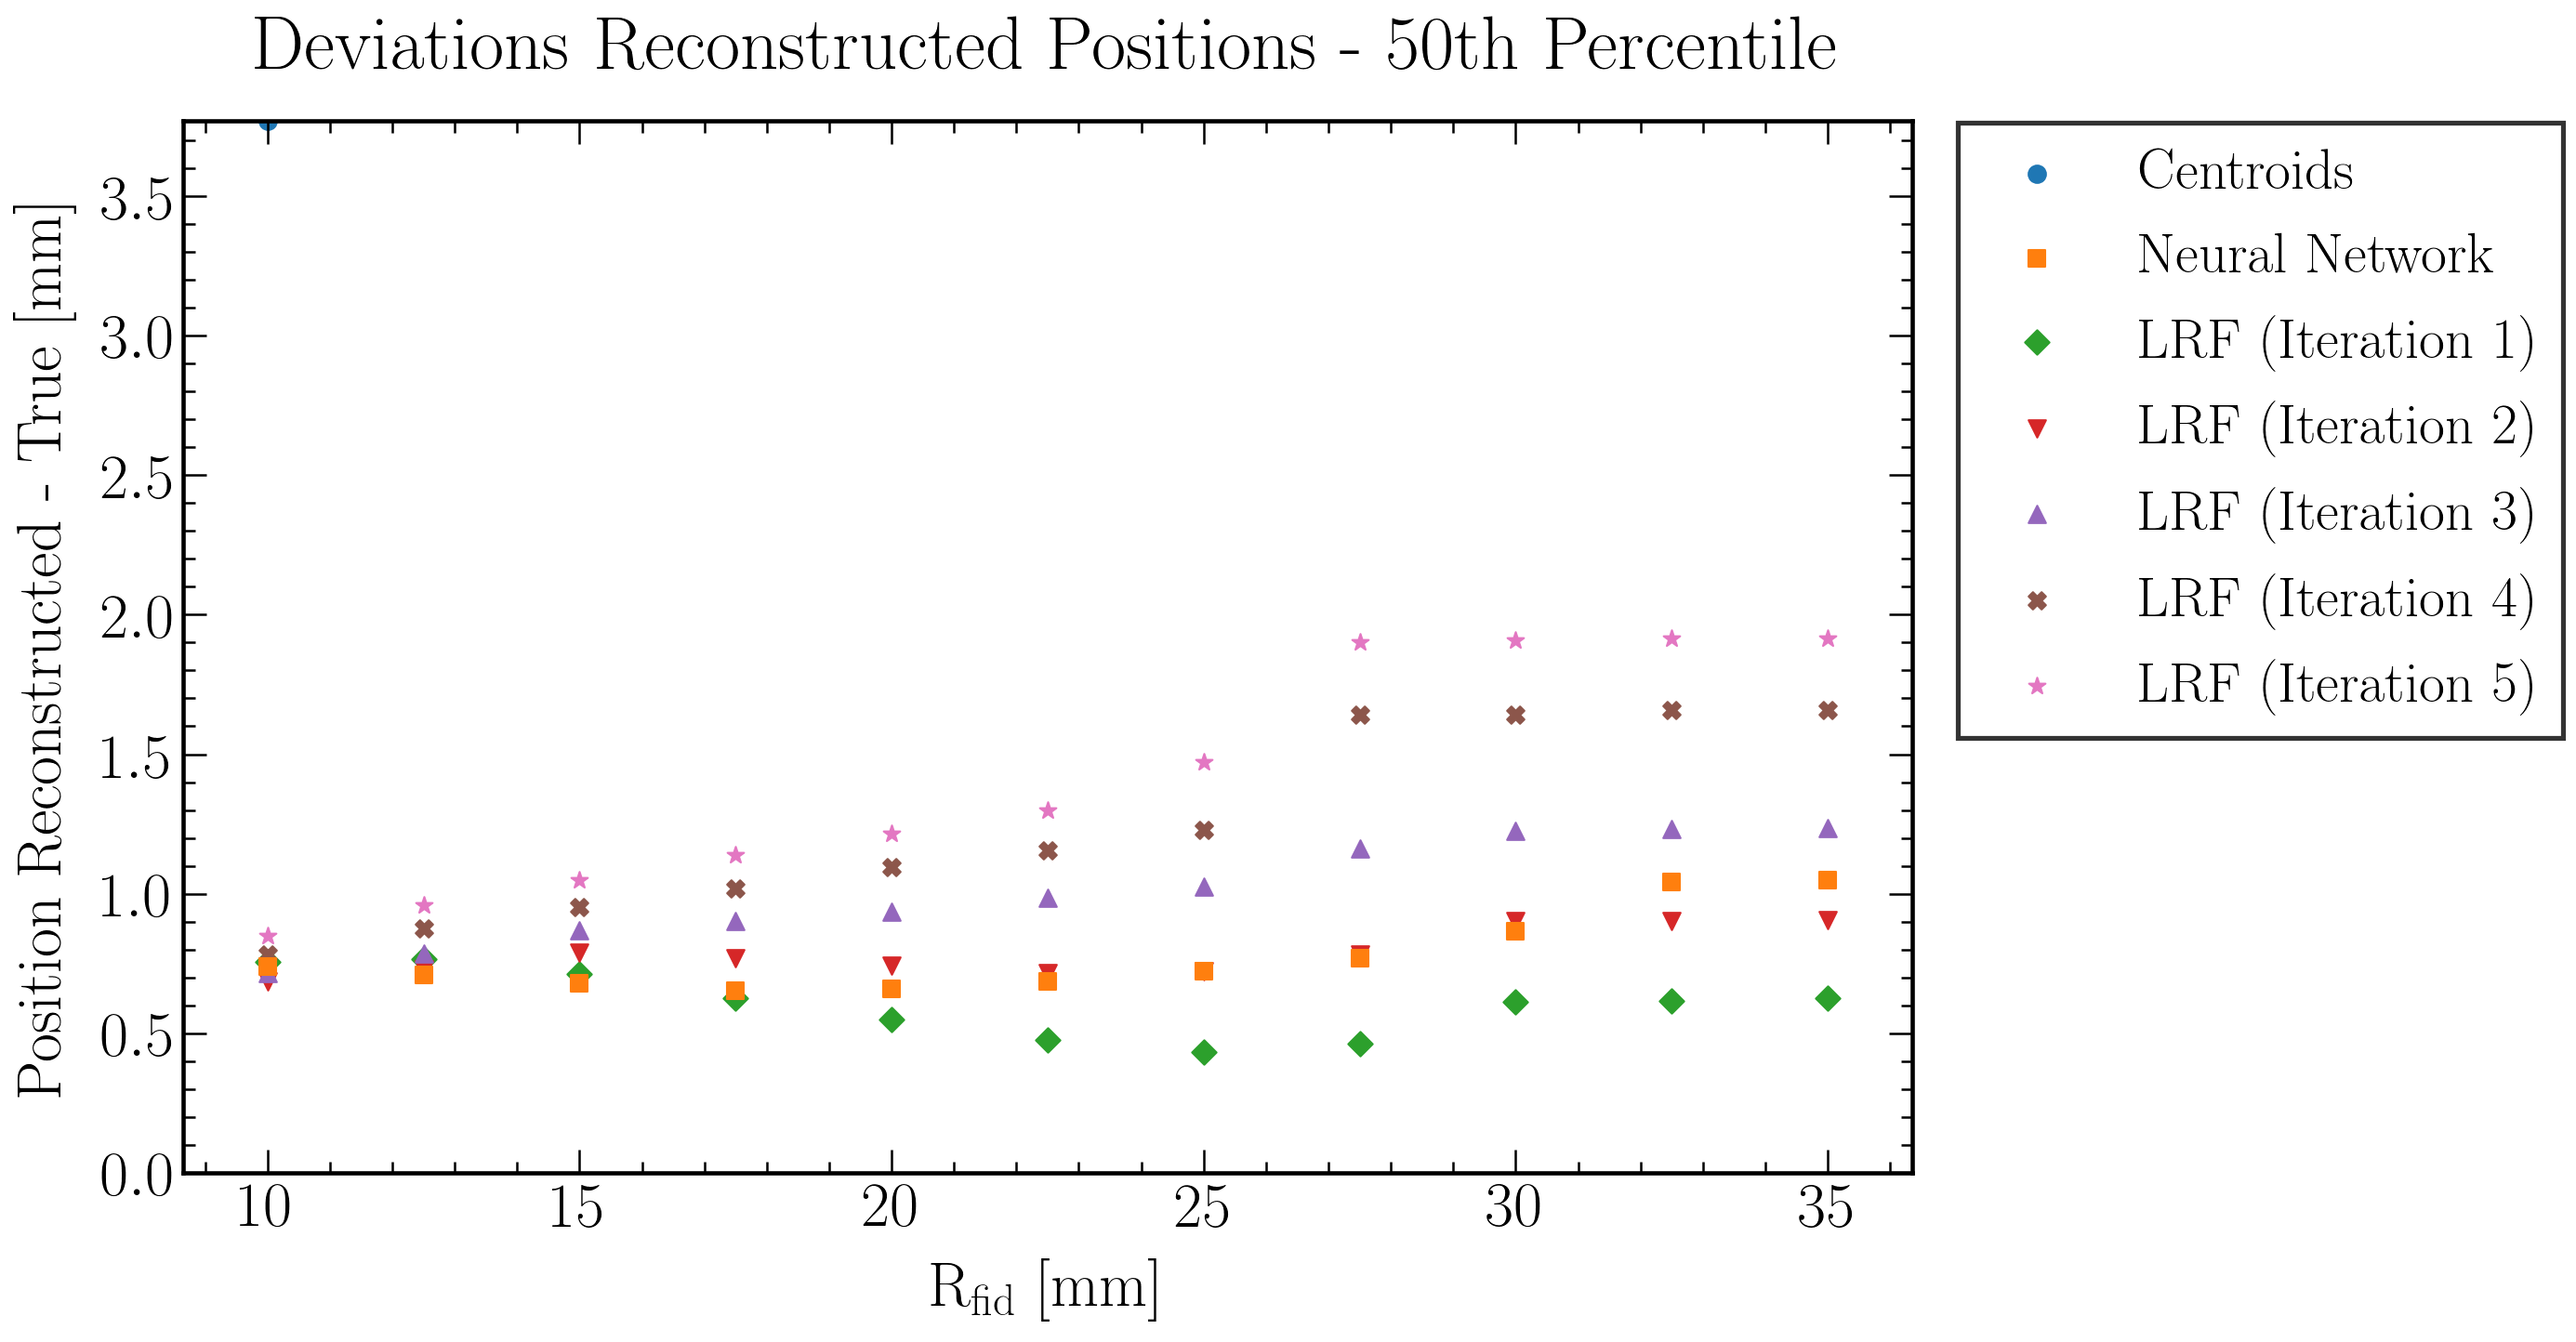

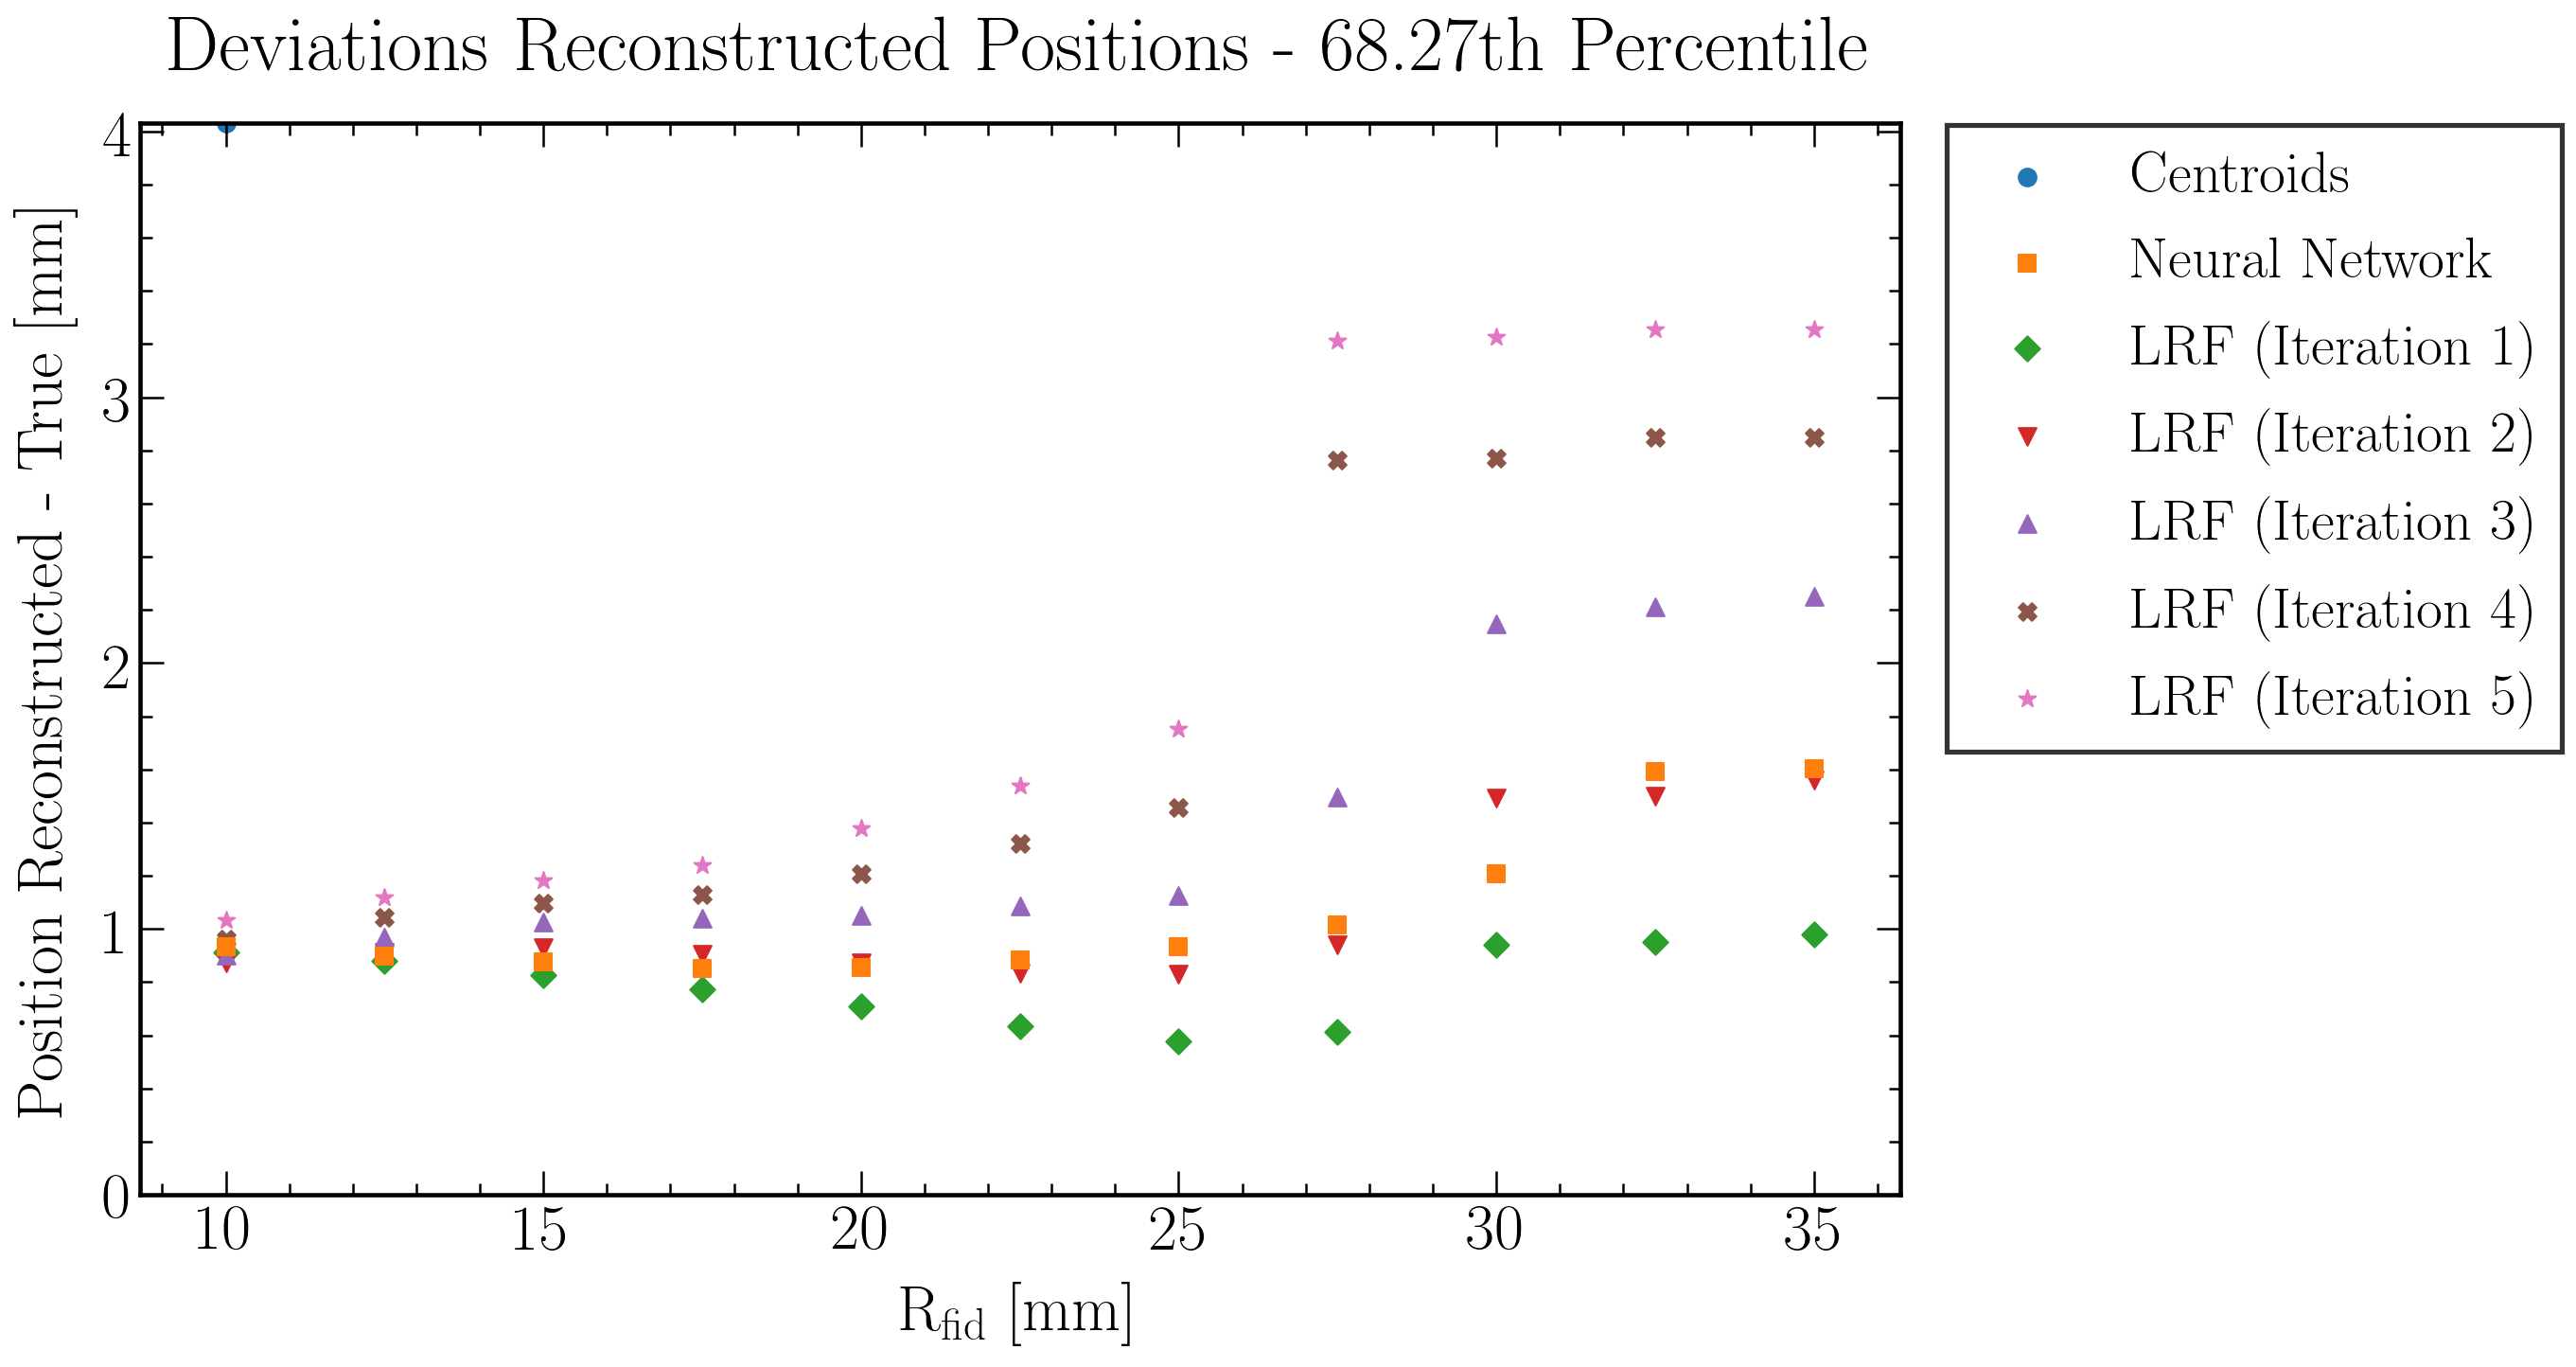

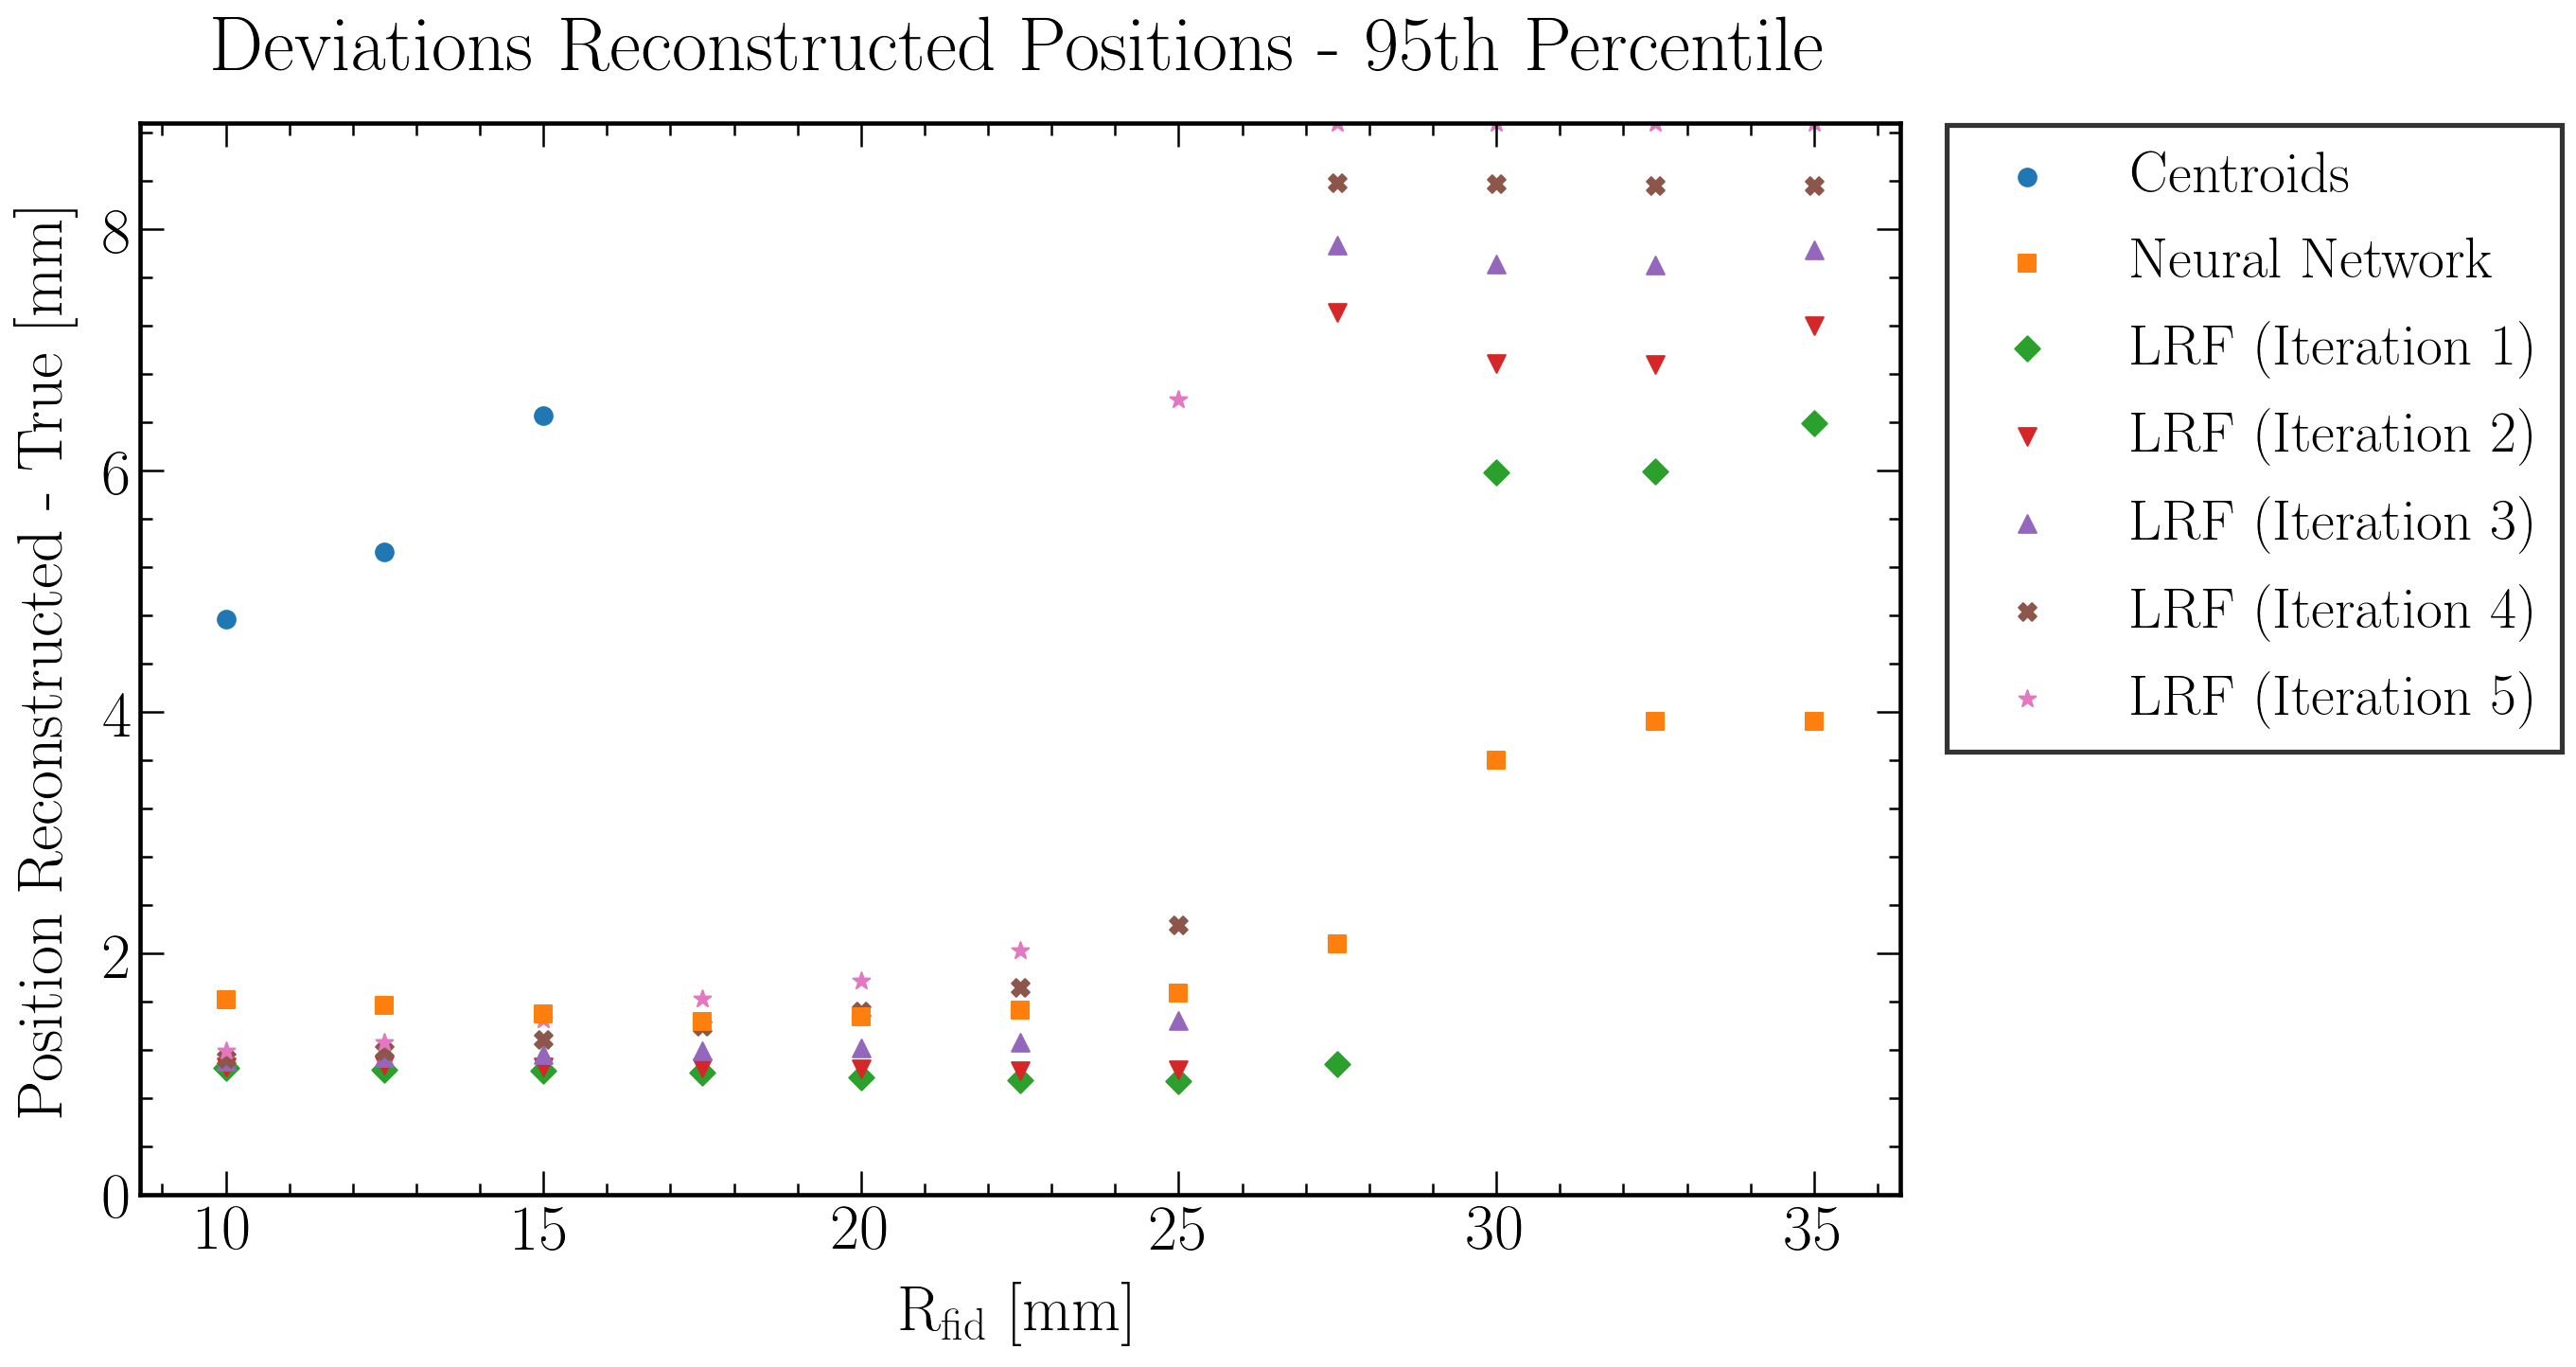

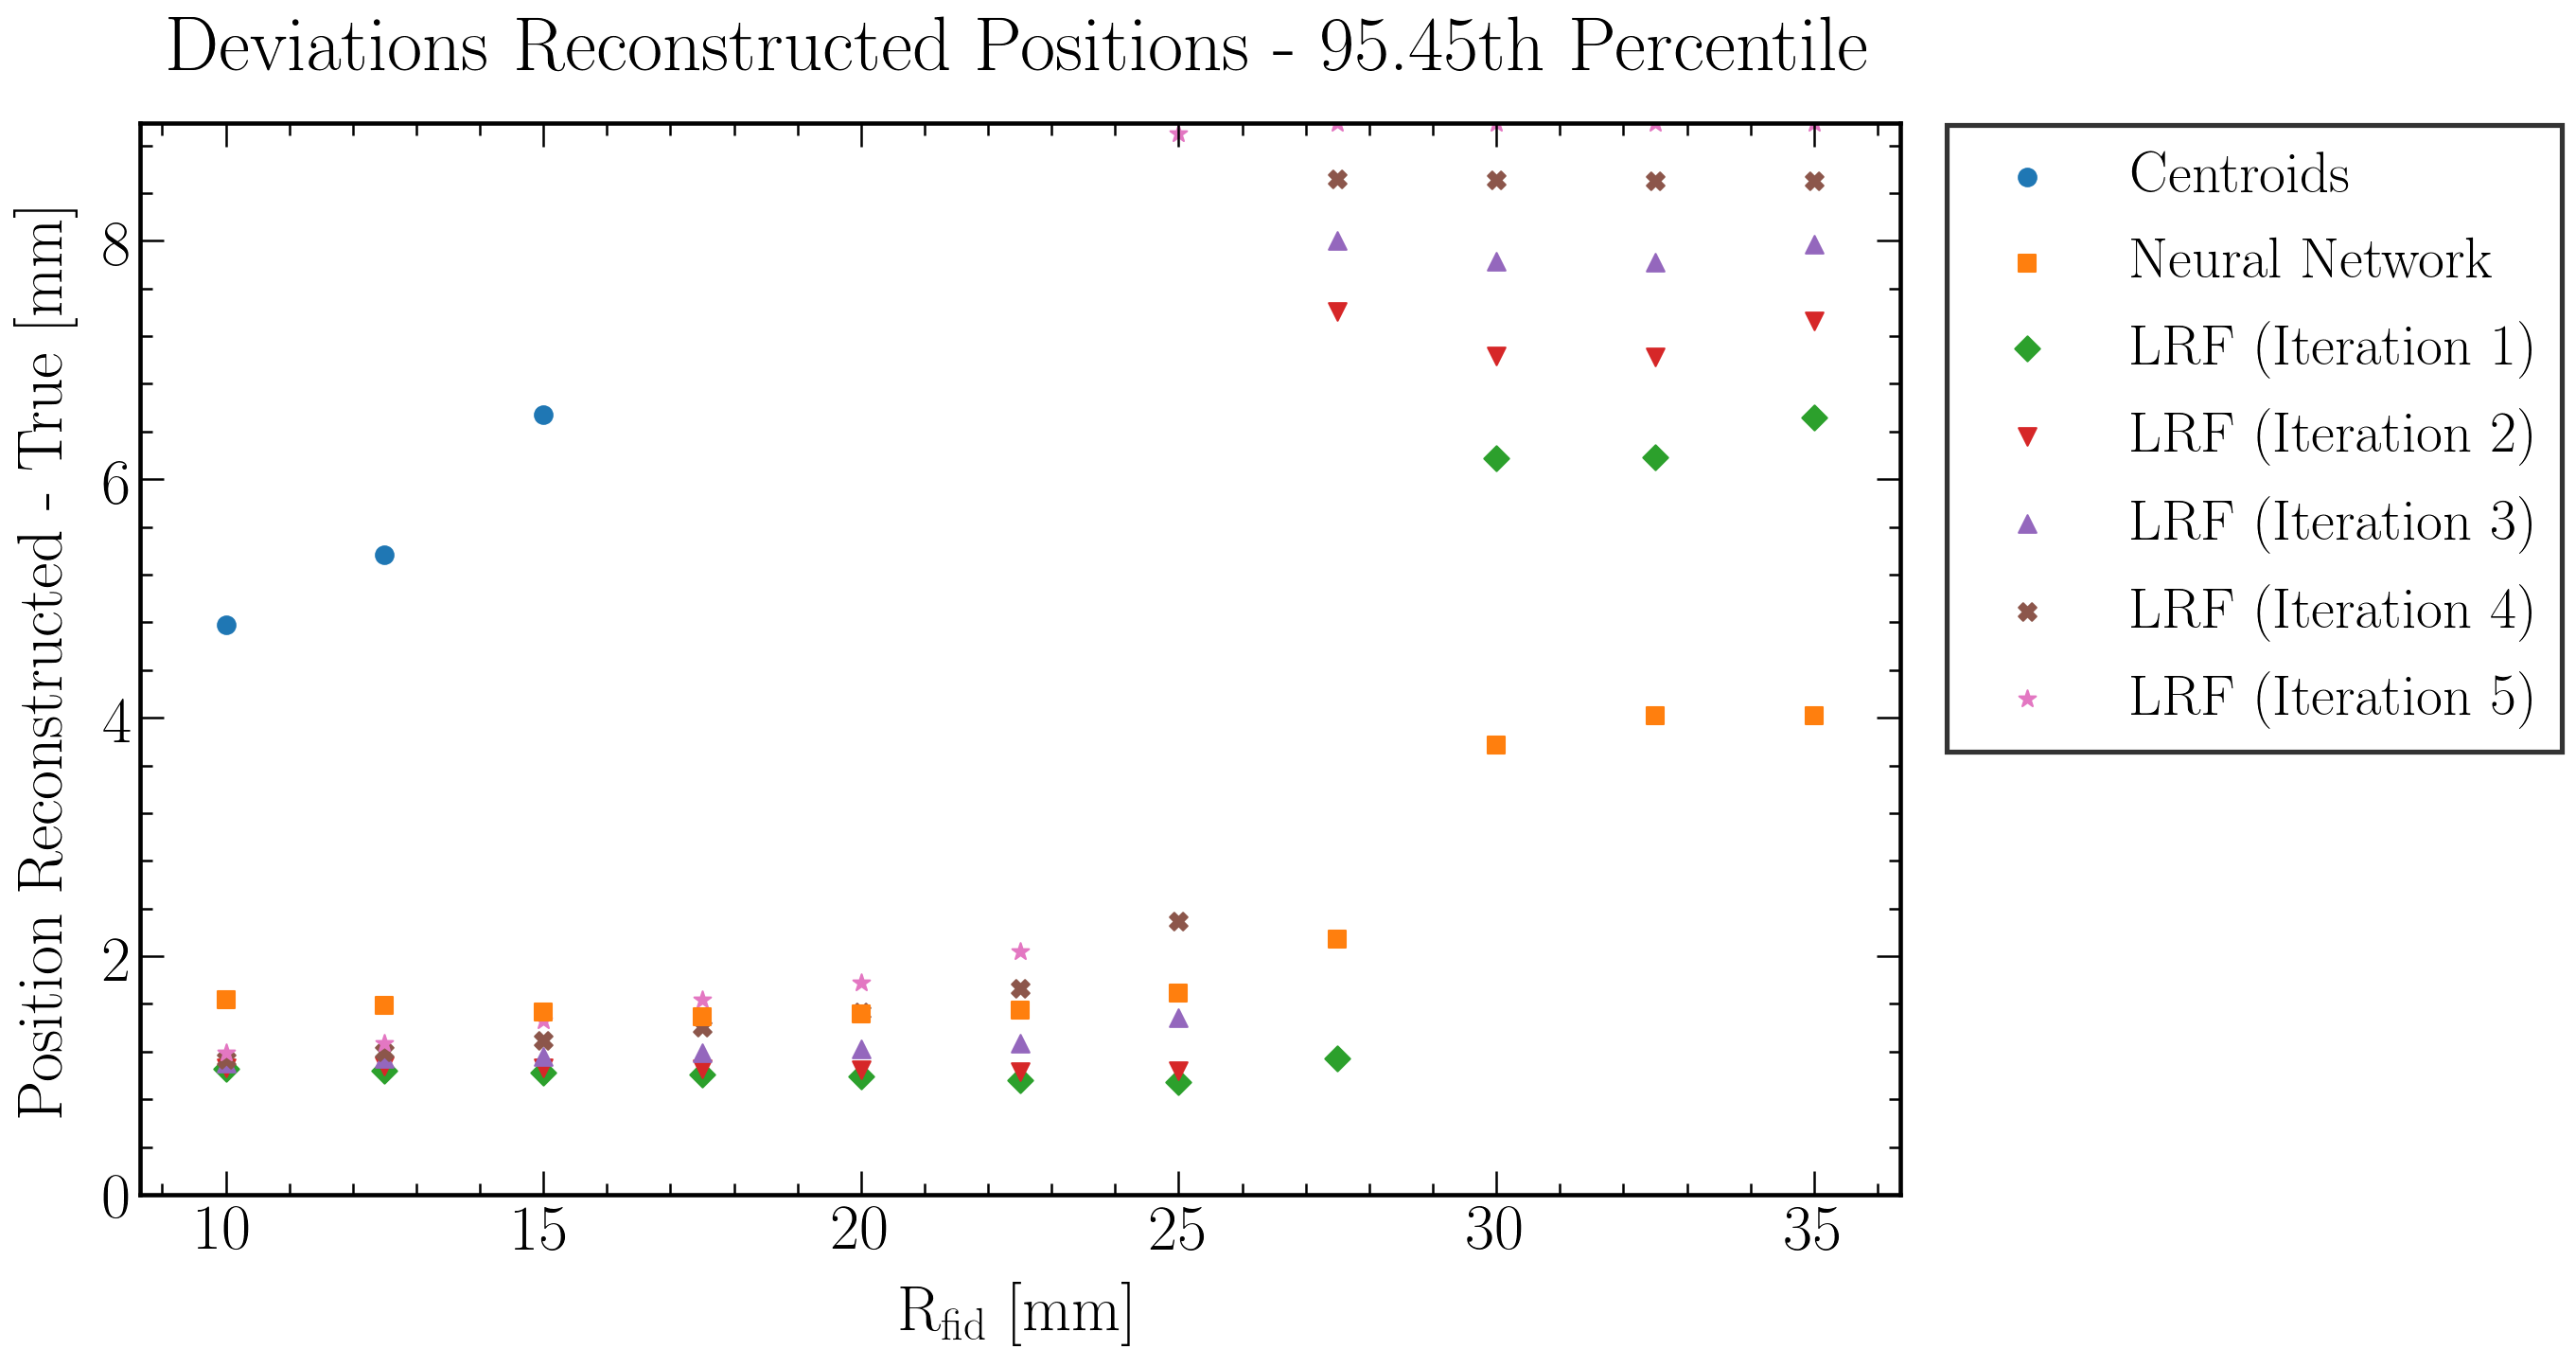

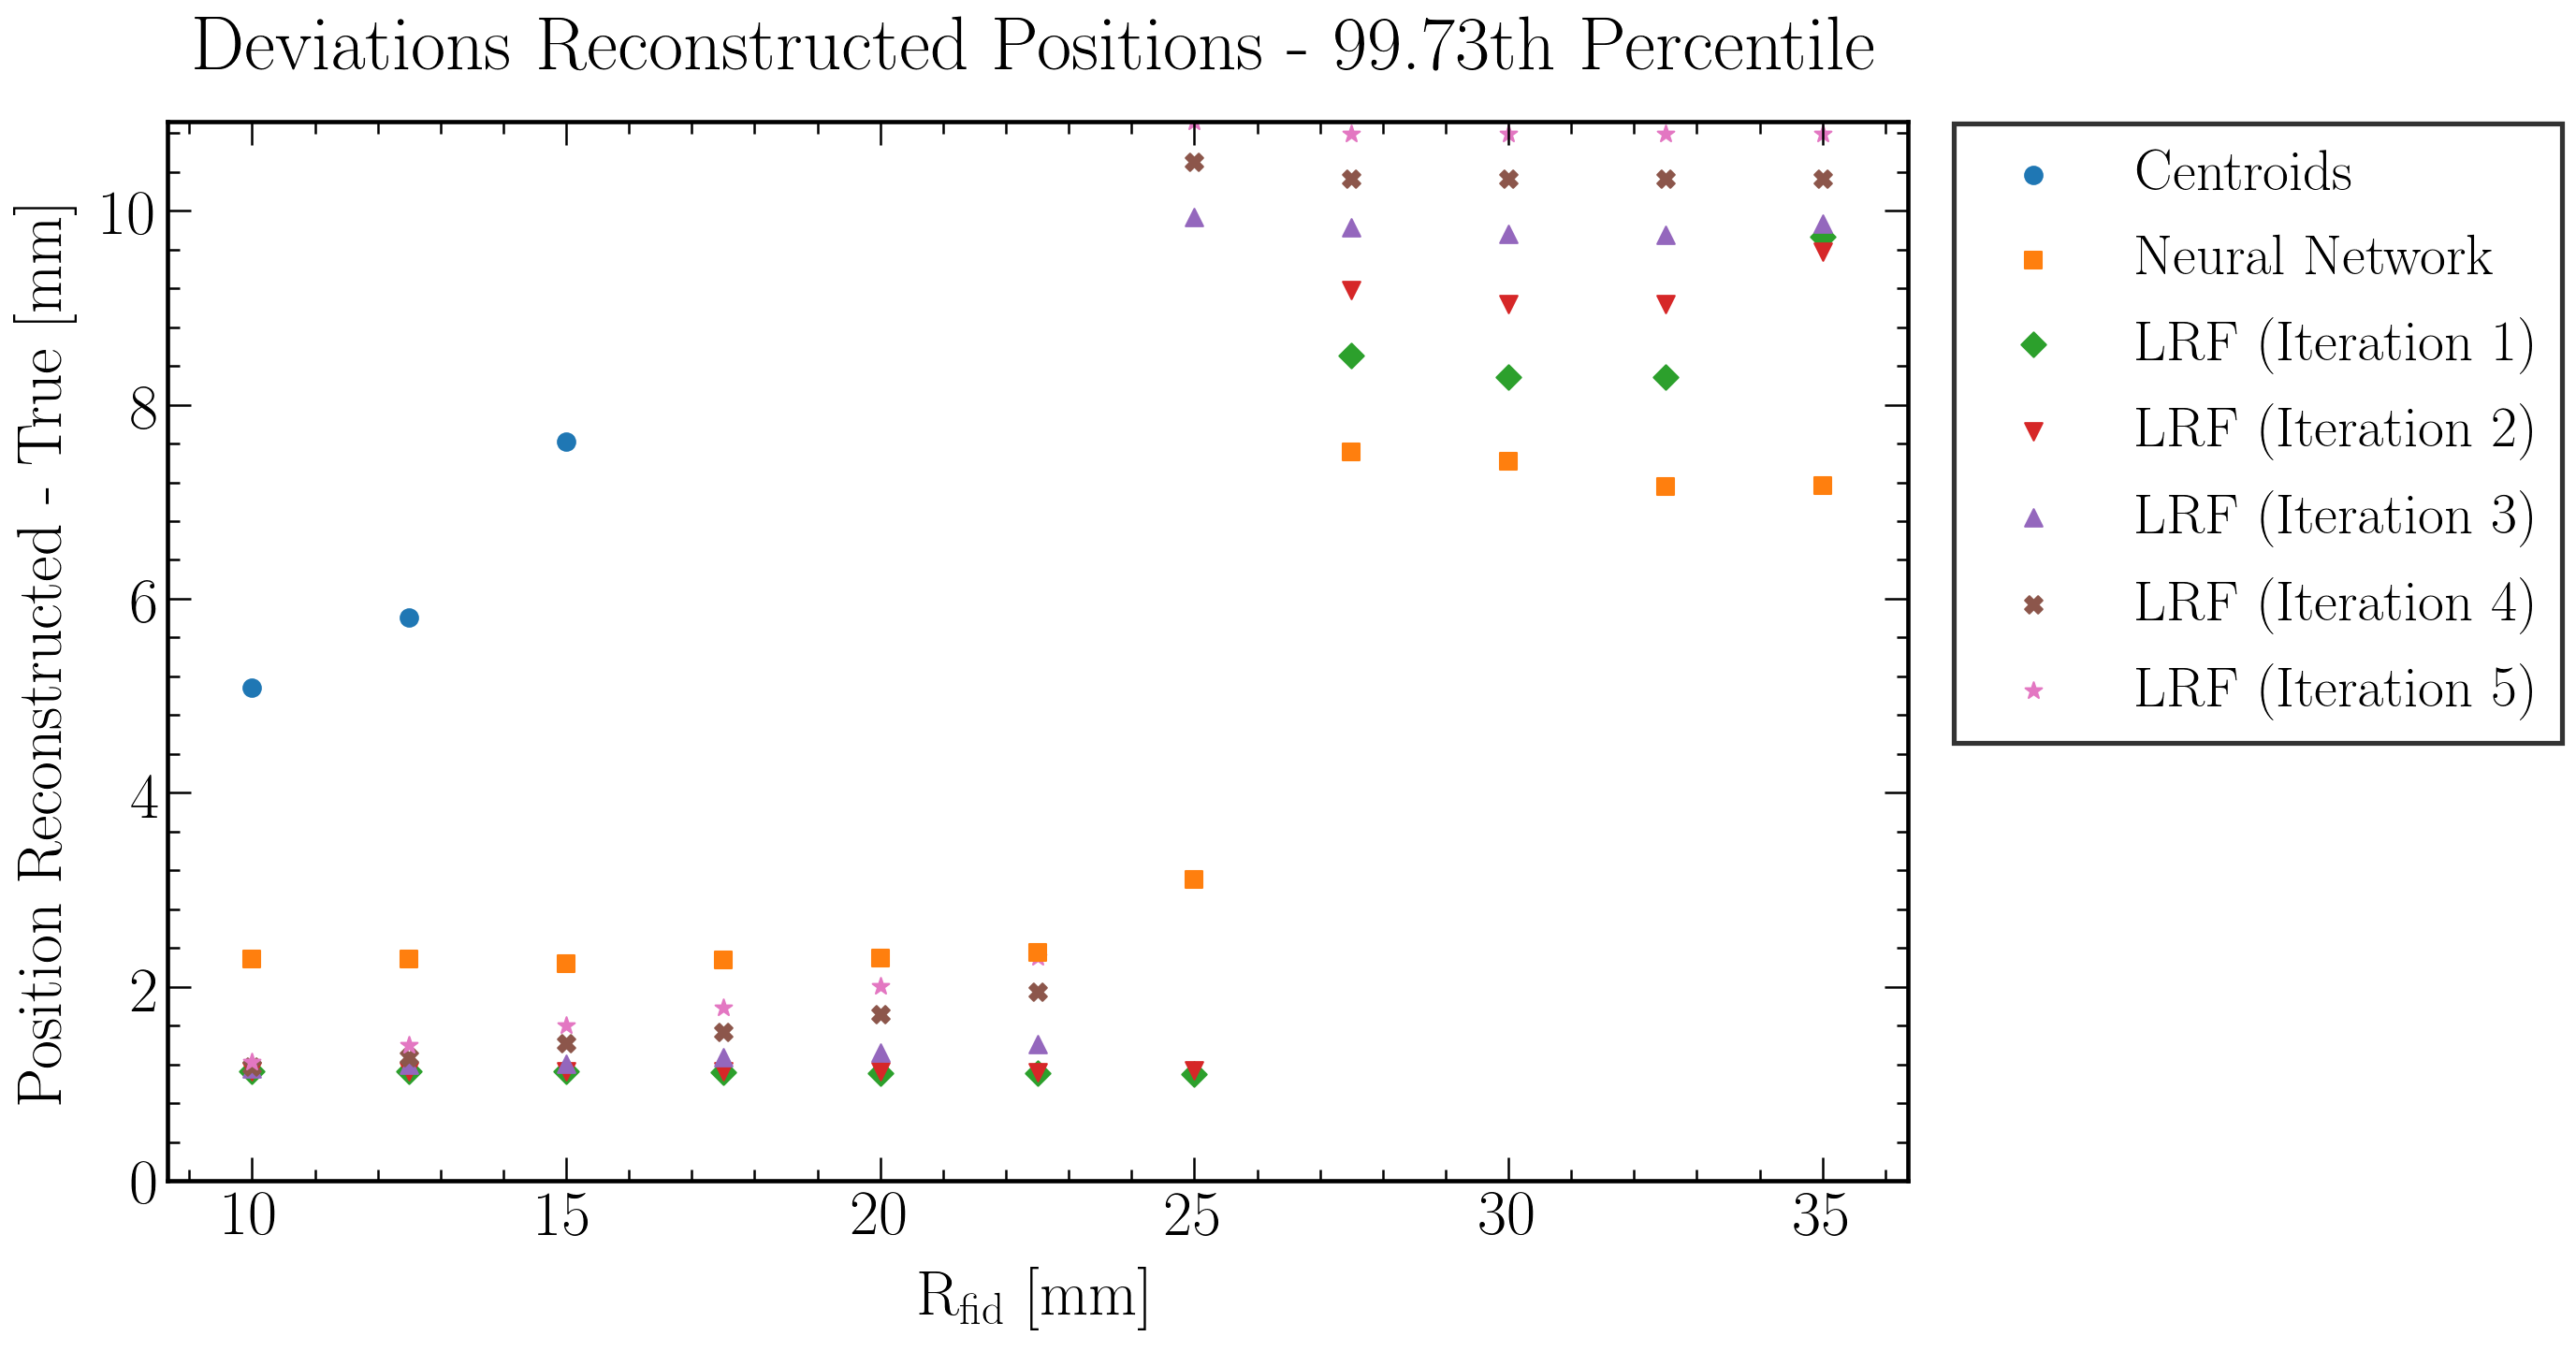

In [24]:
percentile_value_list = [50, 68.27, 95, 95.45, 99.73]

for percentile_value in percentile_value_list:

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Deviations_Centroids['fid']
    y = df_Deviations_Centroids['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

    x = df_Deviations_NN['fid']
    y = df_Deviations_NN['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

    x = df_Deviations_LRF_iteration_1['fid']
    y = df_Deviations_LRF_iteration_1['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

    x = df_Deviations_LRF_iteration_2['fid']
    y = df_Deviations_LRF_iteration_2['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

    x = df_Deviations_LRF_iteration_3['fid']
    y = df_Deviations_LRF_iteration_3['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

    x = df_Deviations_LRF_iteration_4['fid']
    y = df_Deviations_LRF_iteration_4['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

    x = df_Deviations_LRF_iteration_5['fid']
    y = df_Deviations_LRF_iteration_5['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

    plt.ylabel('Position Reconstructed - True [mm]', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Deviations Reconstructed Positions - '+str(percentile_value)+'th Percentile', fontsize = title_size, pad = title_pad)

    plt.ylim(0, max(df_Deviations_Centroids['delta_'+str(percentile_value)+'_percentile'].min(), 
    df_Deviations_LRF_iteration_5['delta_'+str(percentile_value)+'_percentile'].max()))
    
    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_All_ReconstructedPosition_Deviations_"+str(percentile_value)+"Percentiles_scaled.png", bbox_inches = "tight")
    plt.show()

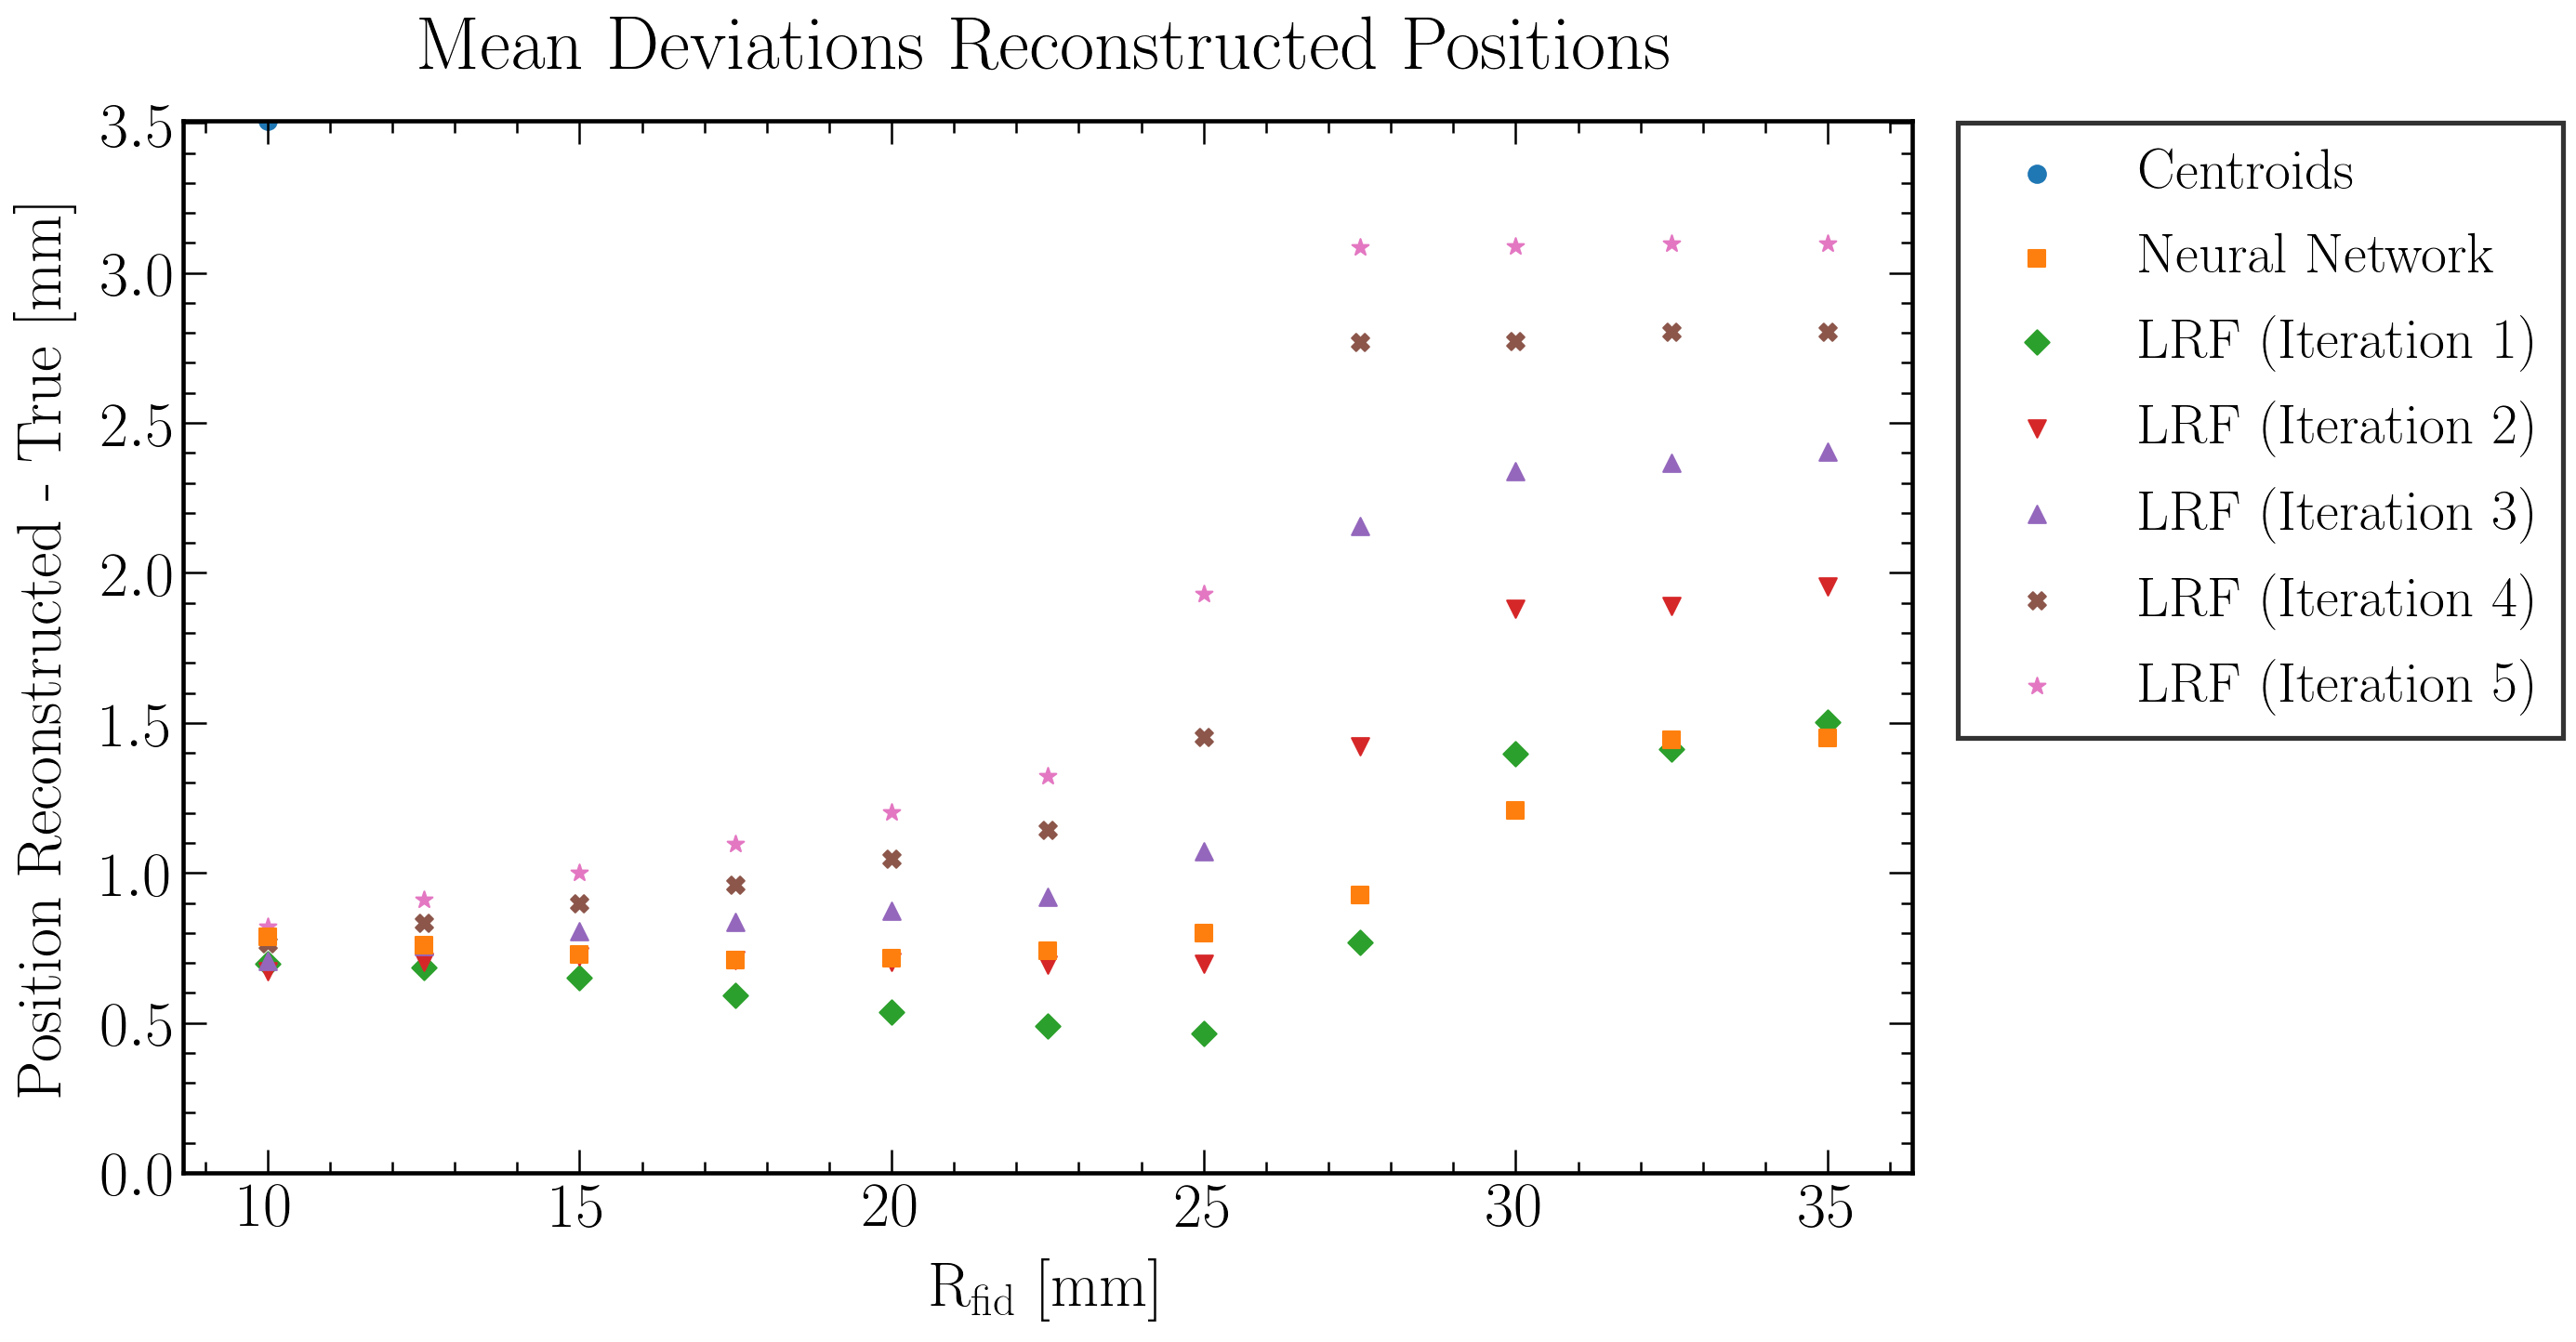

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

#############################################
## Plot specific settings and plot data
#############################################

# Data plot

x = df_Deviations_Centroids['fid']
y = df_Deviations_Centroids['delta_mean']
plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

x = df_Deviations_NN['fid']
y = df_Deviations_NN['delta_mean']
plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

x = df_Deviations_LRF_iteration_1['fid']
y = df_Deviations_LRF_iteration_1['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

x = df_Deviations_LRF_iteration_2['fid']
y = df_Deviations_LRF_iteration_2['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

x = df_Deviations_LRF_iteration_3['fid']
y = df_Deviations_LRF_iteration_3['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

x = df_Deviations_LRF_iteration_4['fid']
y = df_Deviations_LRF_iteration_4['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

x = df_Deviations_LRF_iteration_5['fid']
y = df_Deviations_LRF_iteration_5['delta_mean']
plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

plt.ylabel('Position Reconstructed - True [mm]', fontsize = label_size, labelpad = label_pad)
plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Mean Deviations Reconstructed Positions', fontsize = title_size, pad = title_pad)

plt.ylim(0, max(df_Deviations_Centroids['delta_mean'].min(), 
df_Deviations_LRF_iteration_5['delta_mean'].max()))

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig("Comparison_All_ReconstructedPosition_Deviations_Means_scaled.png", bbox_inches = "tight")
plt.show()

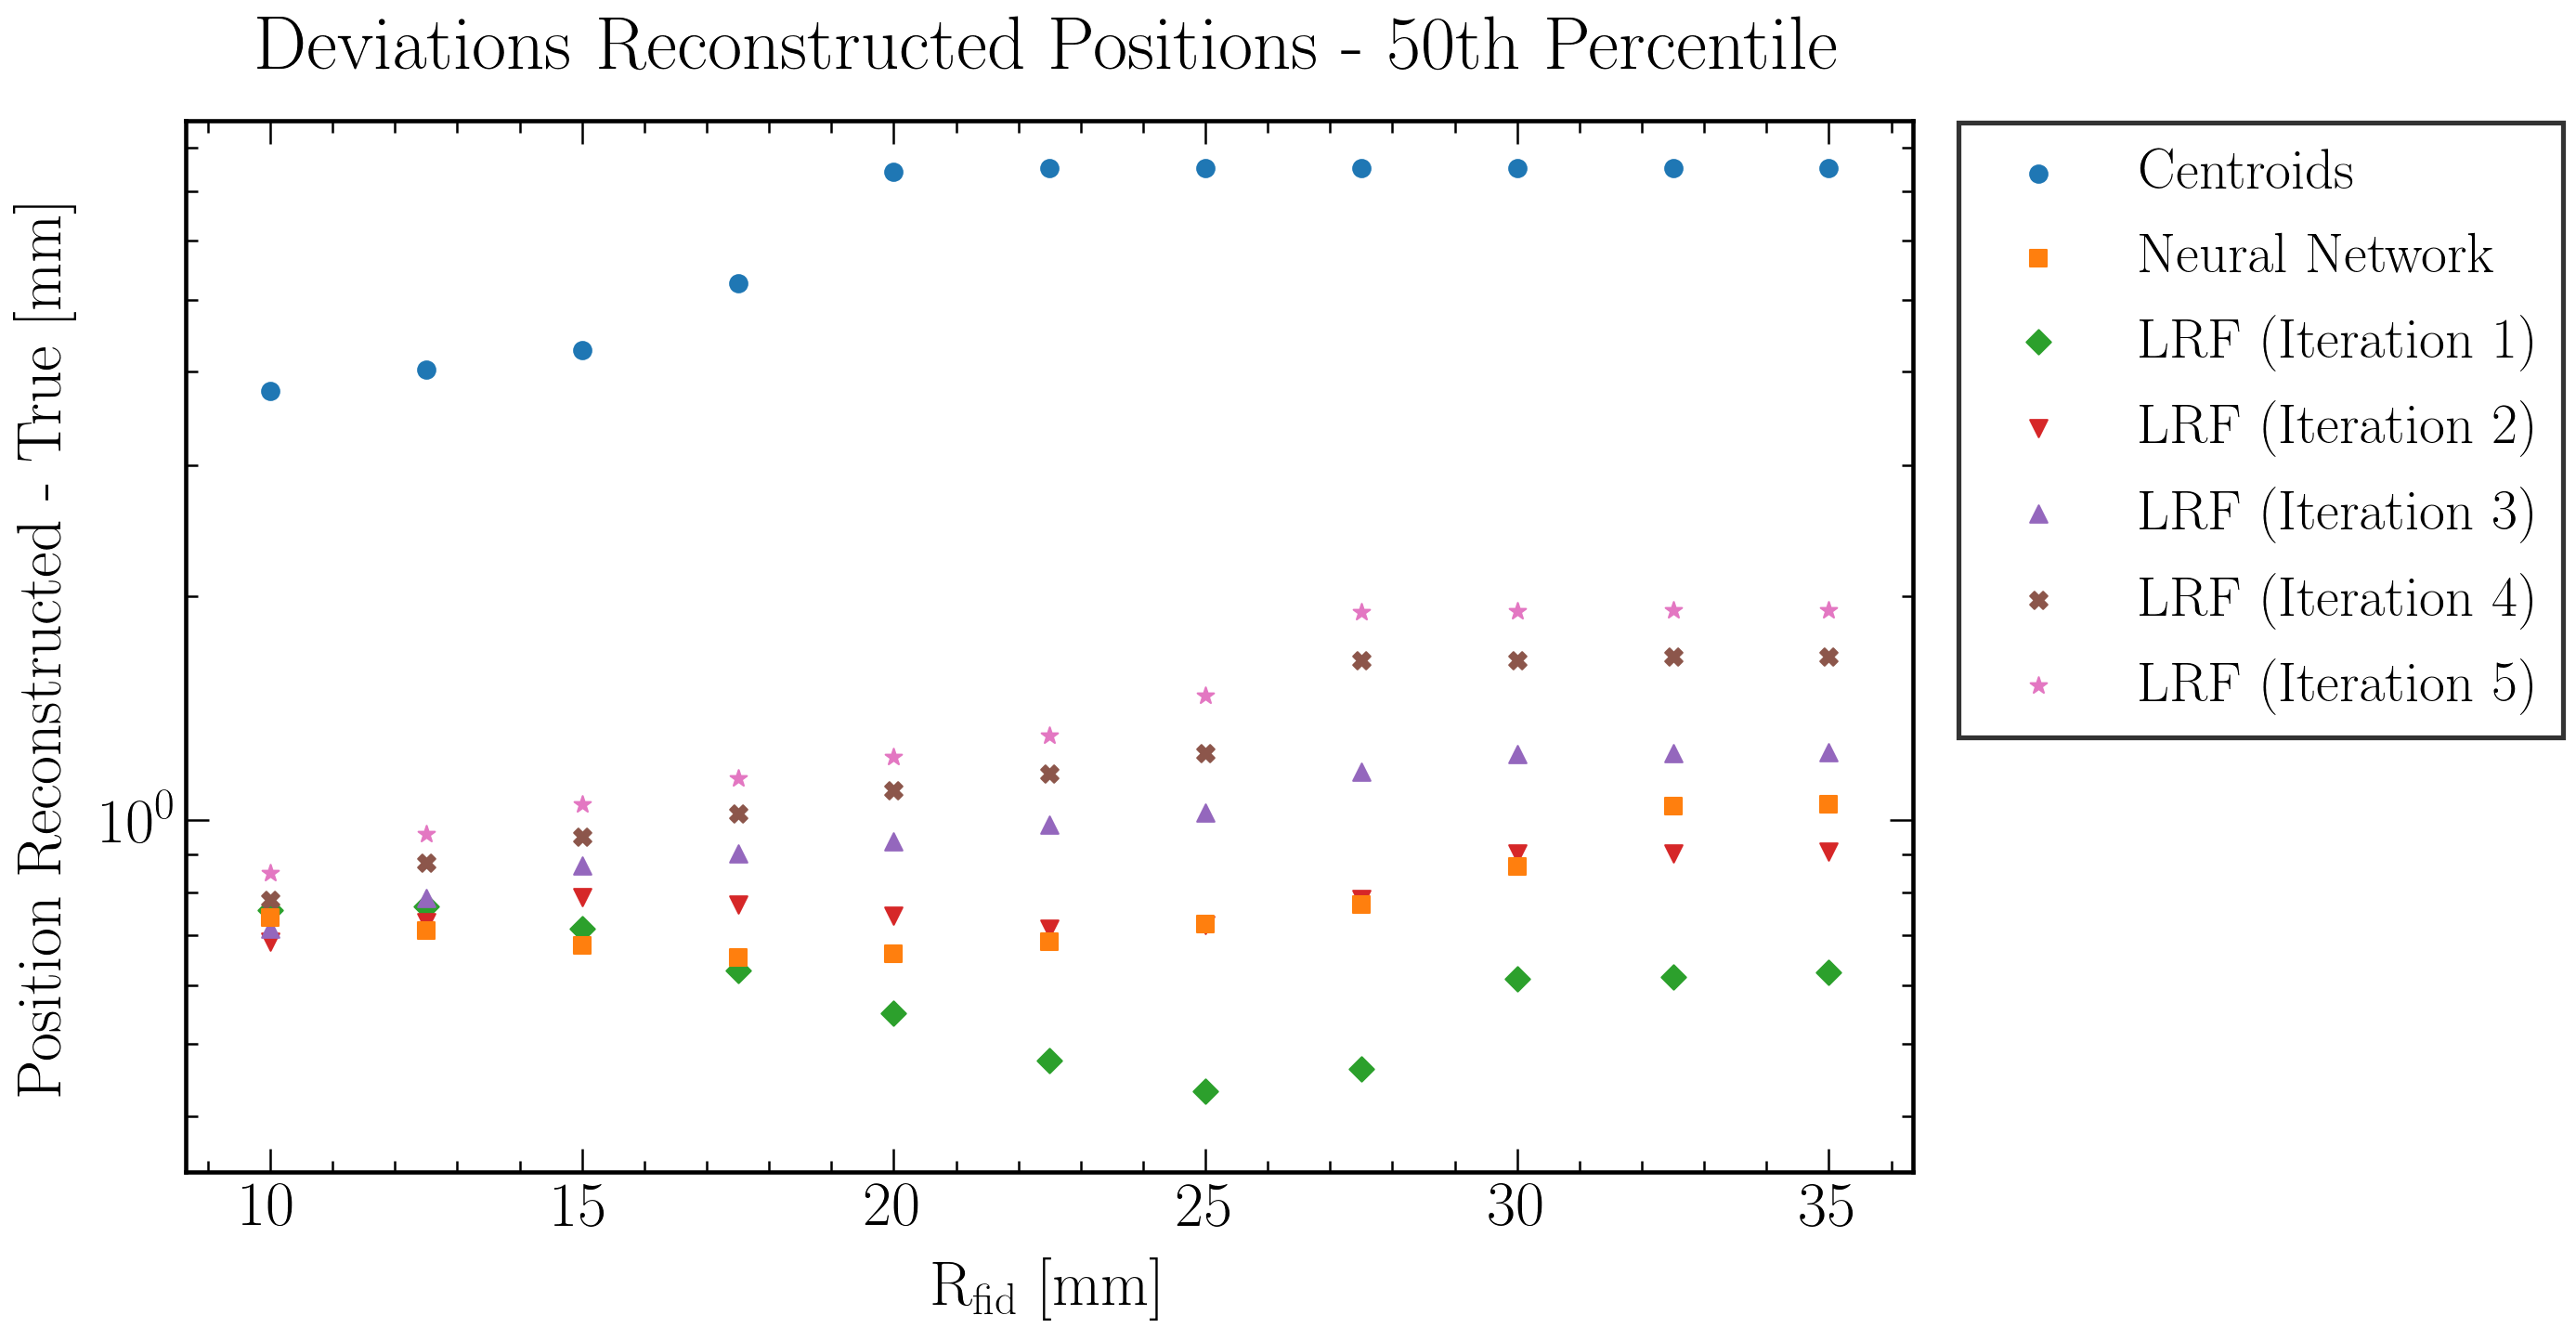

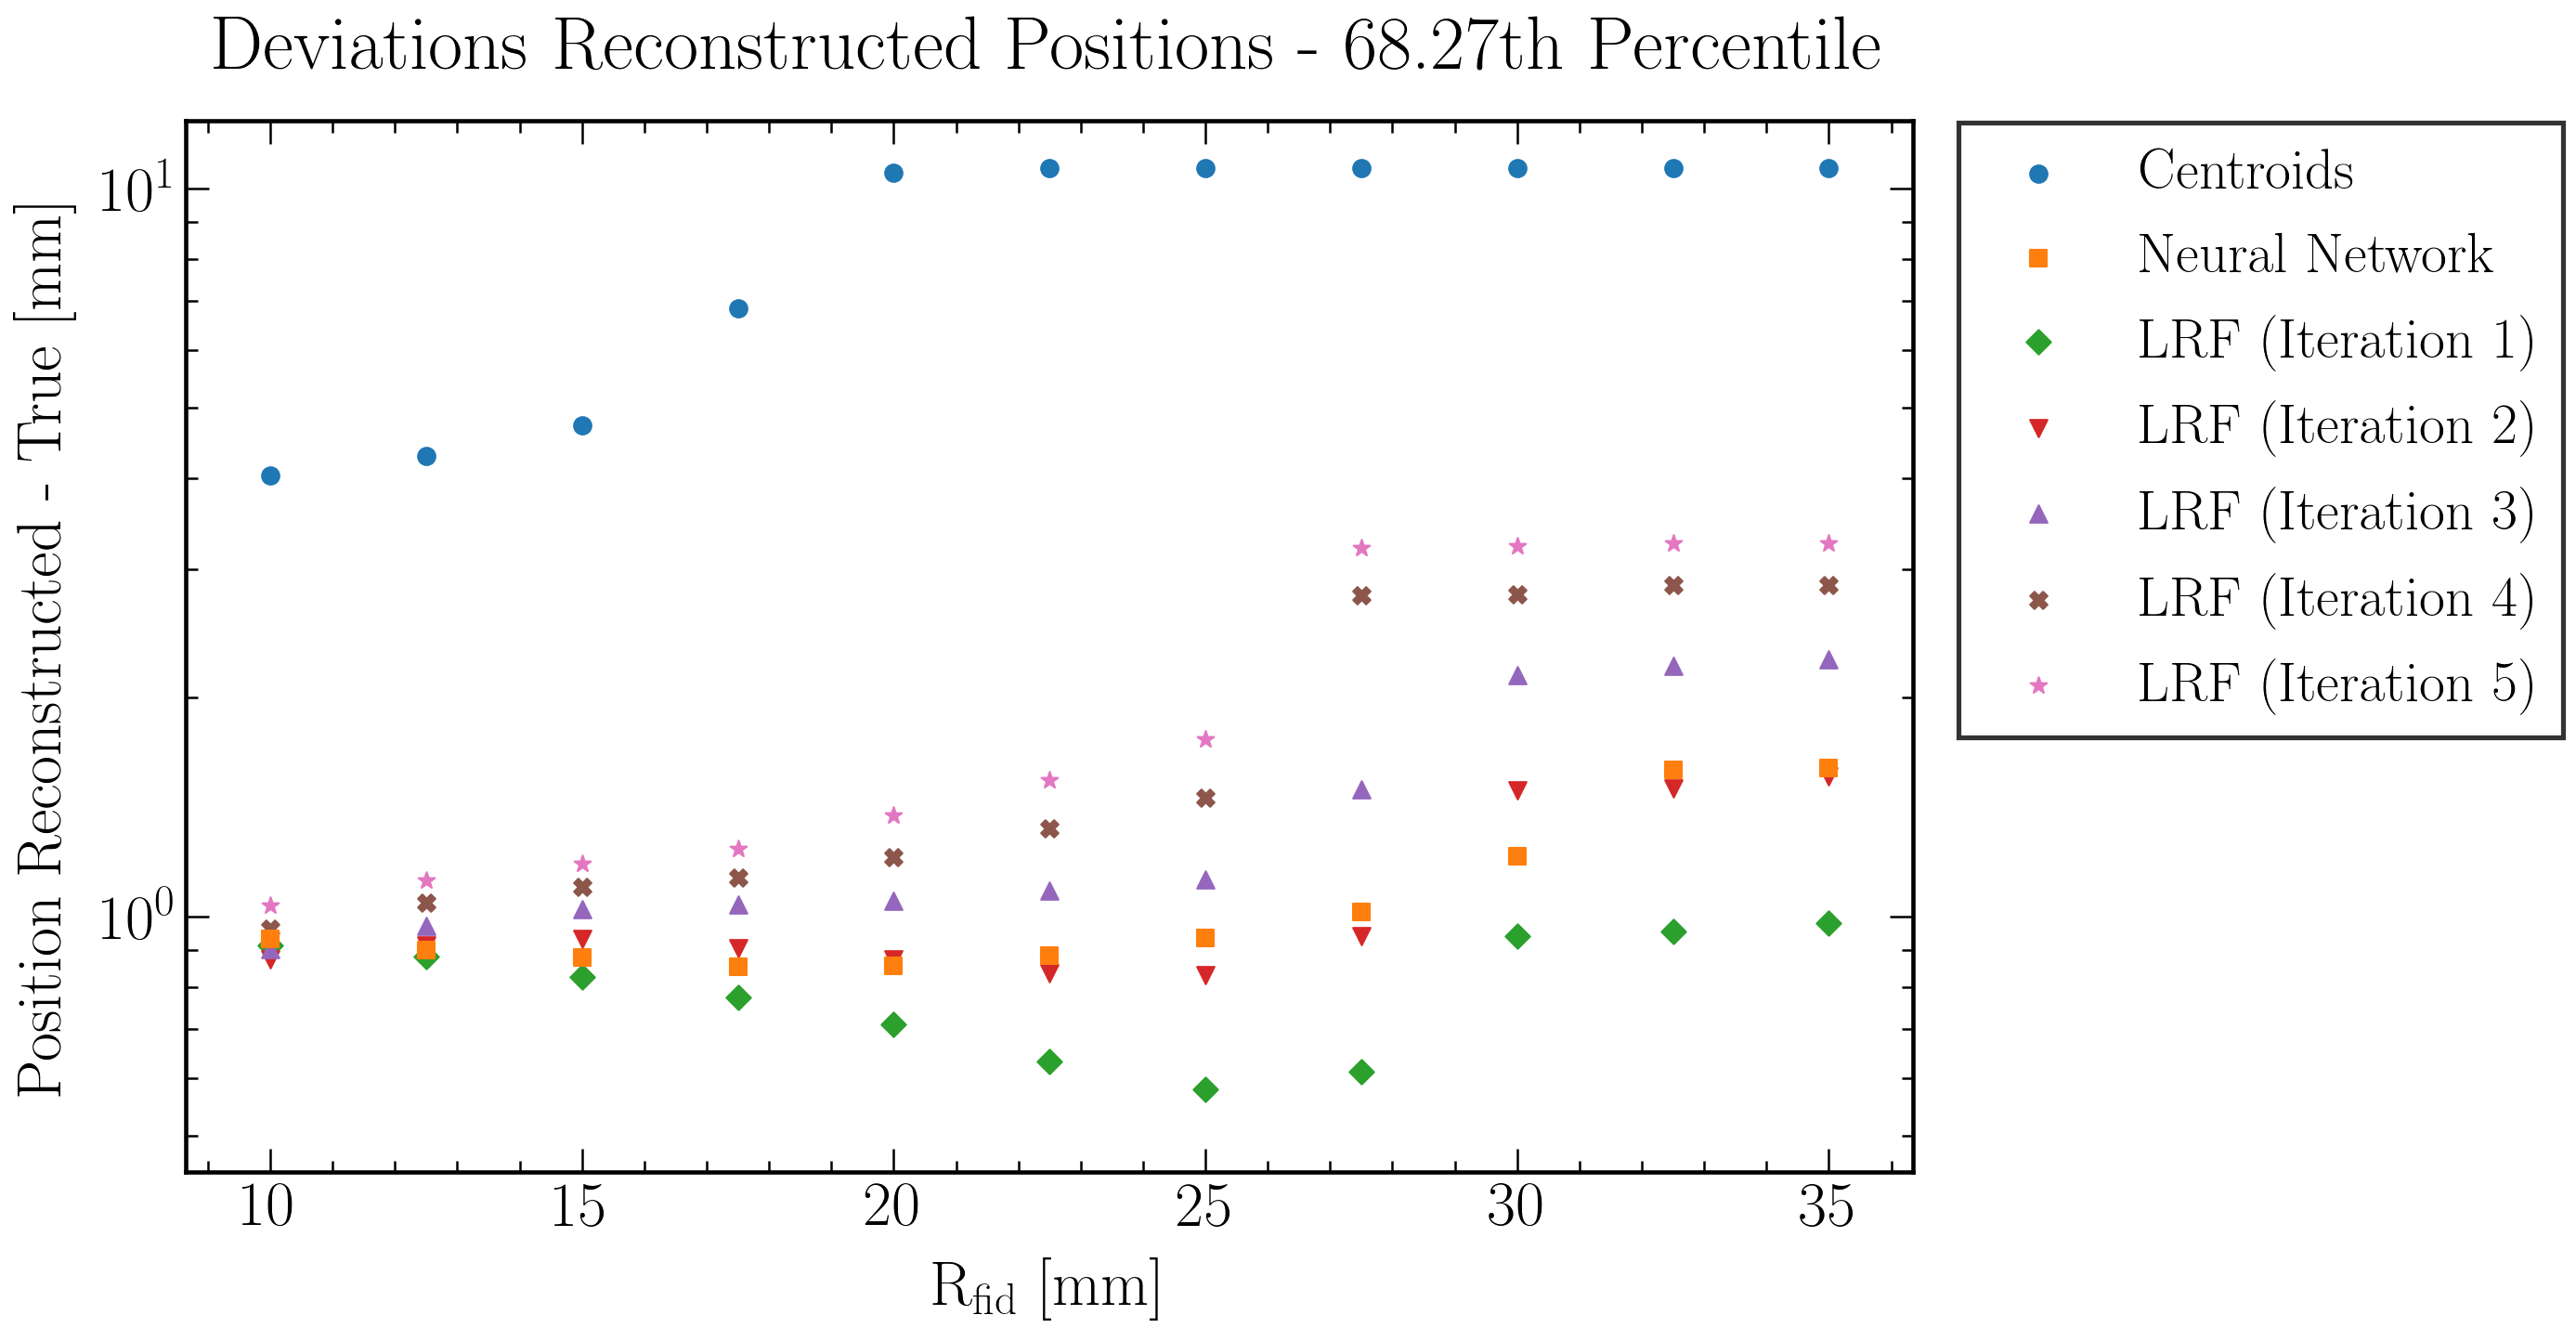

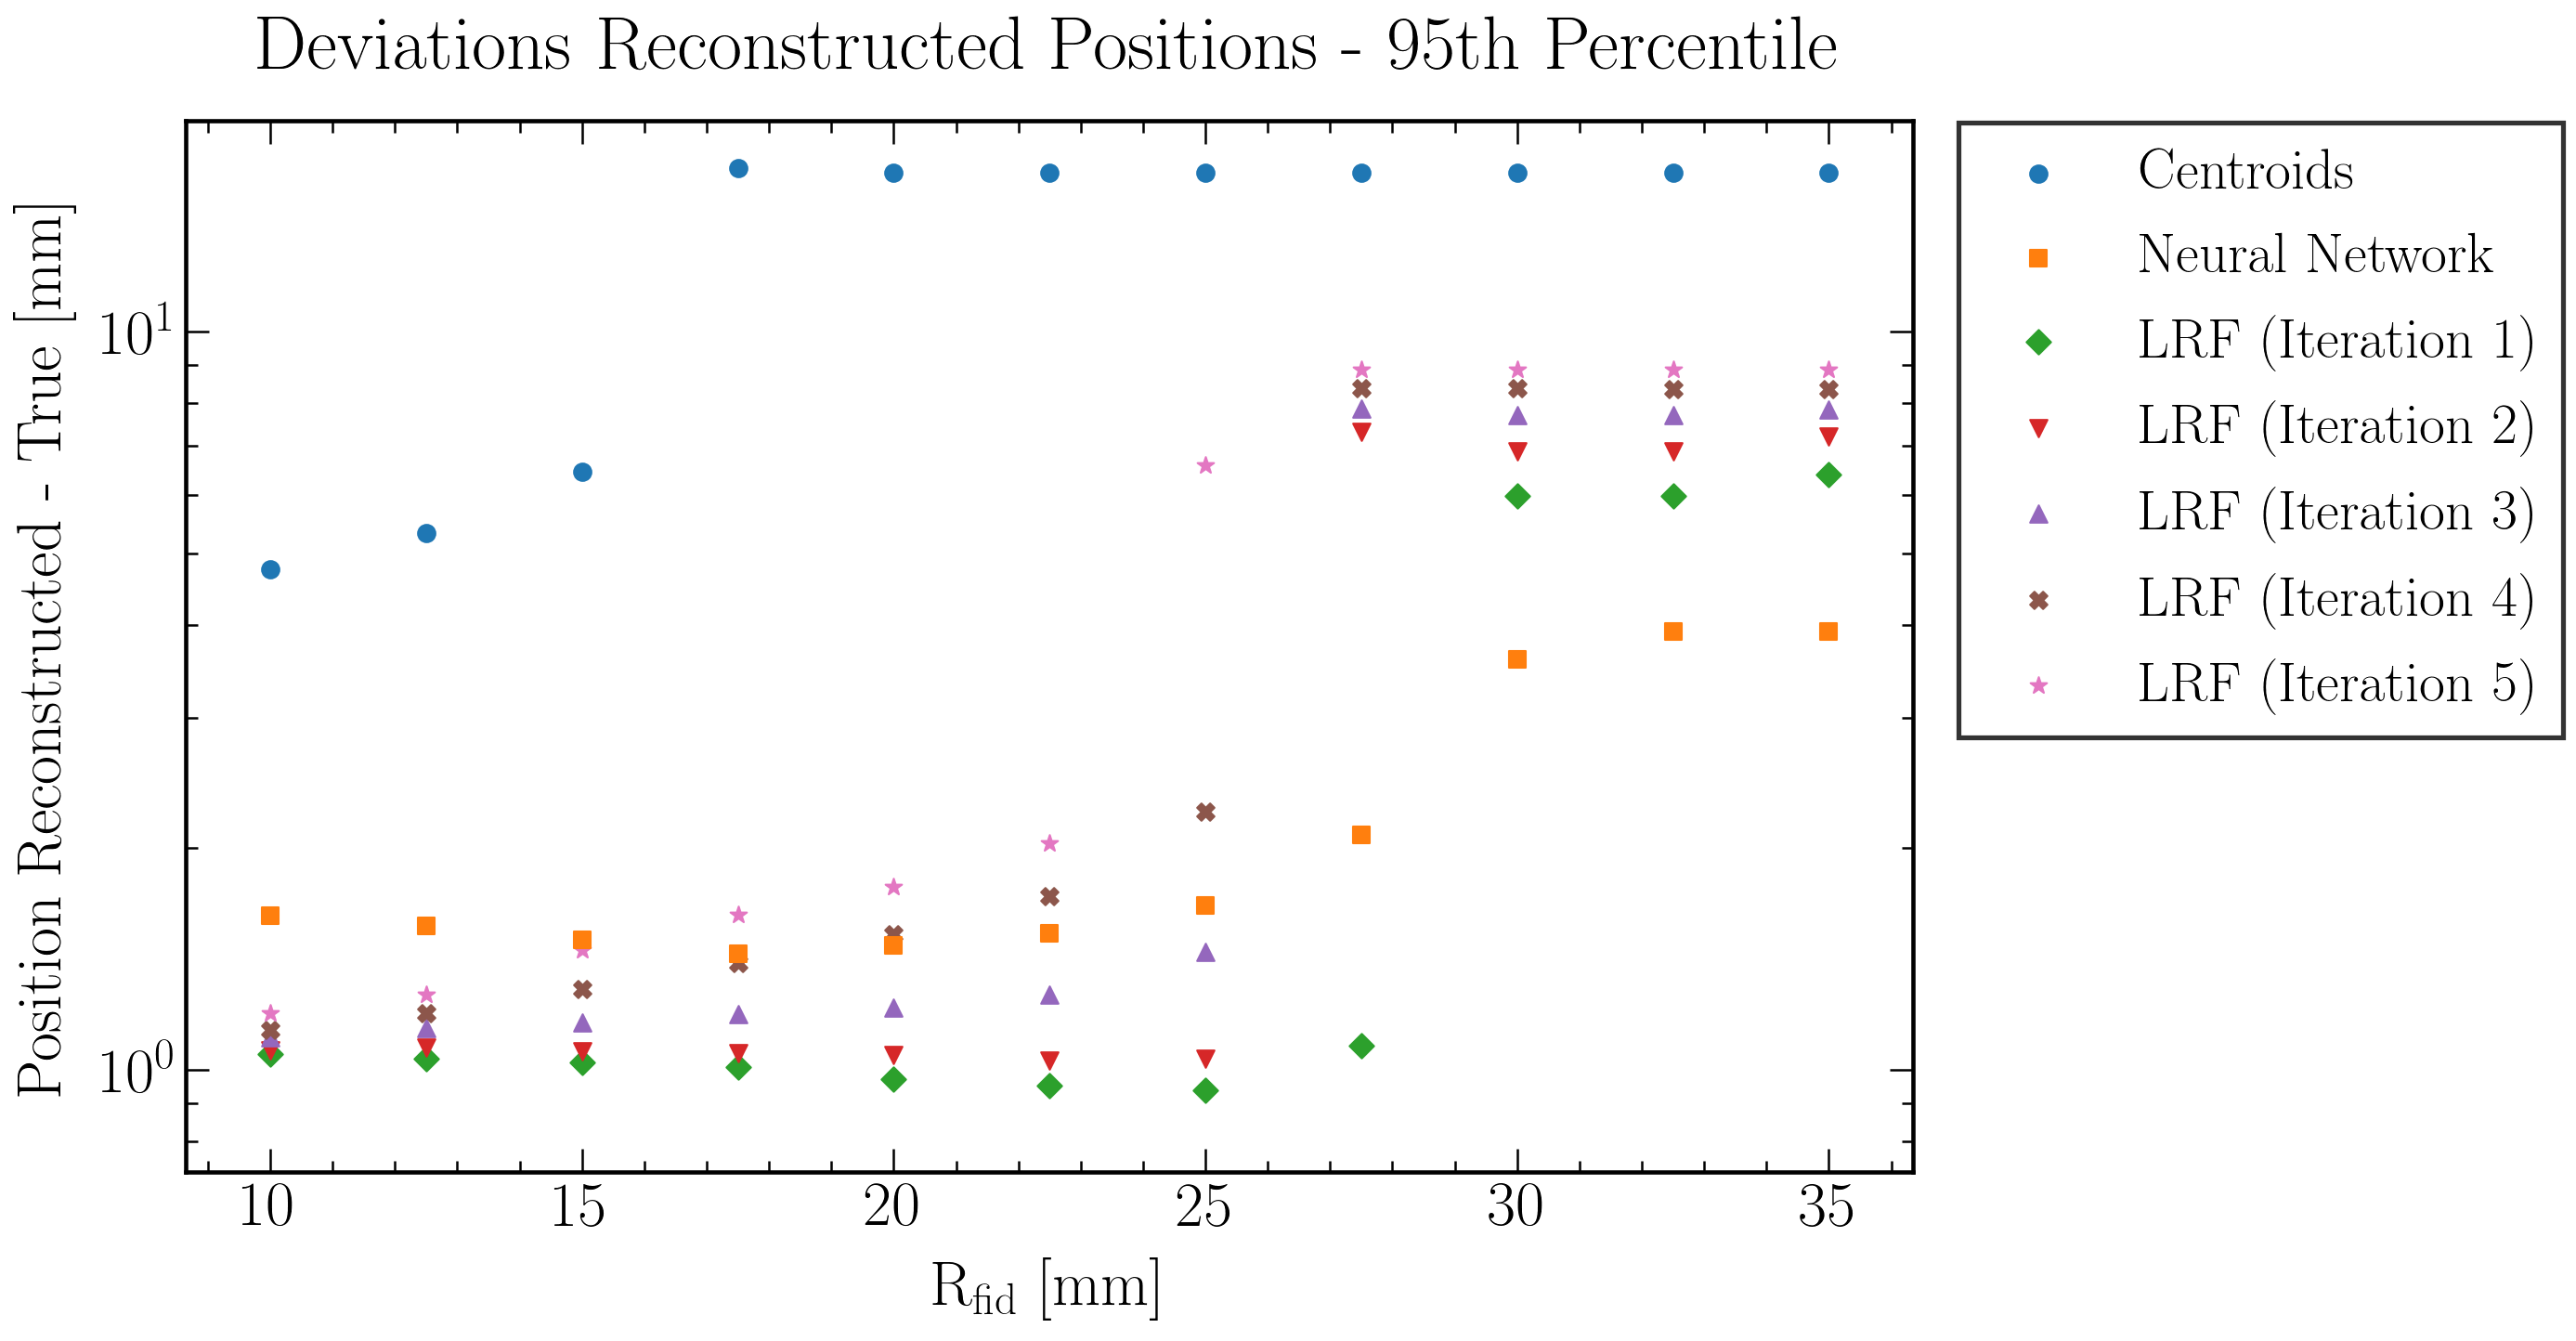

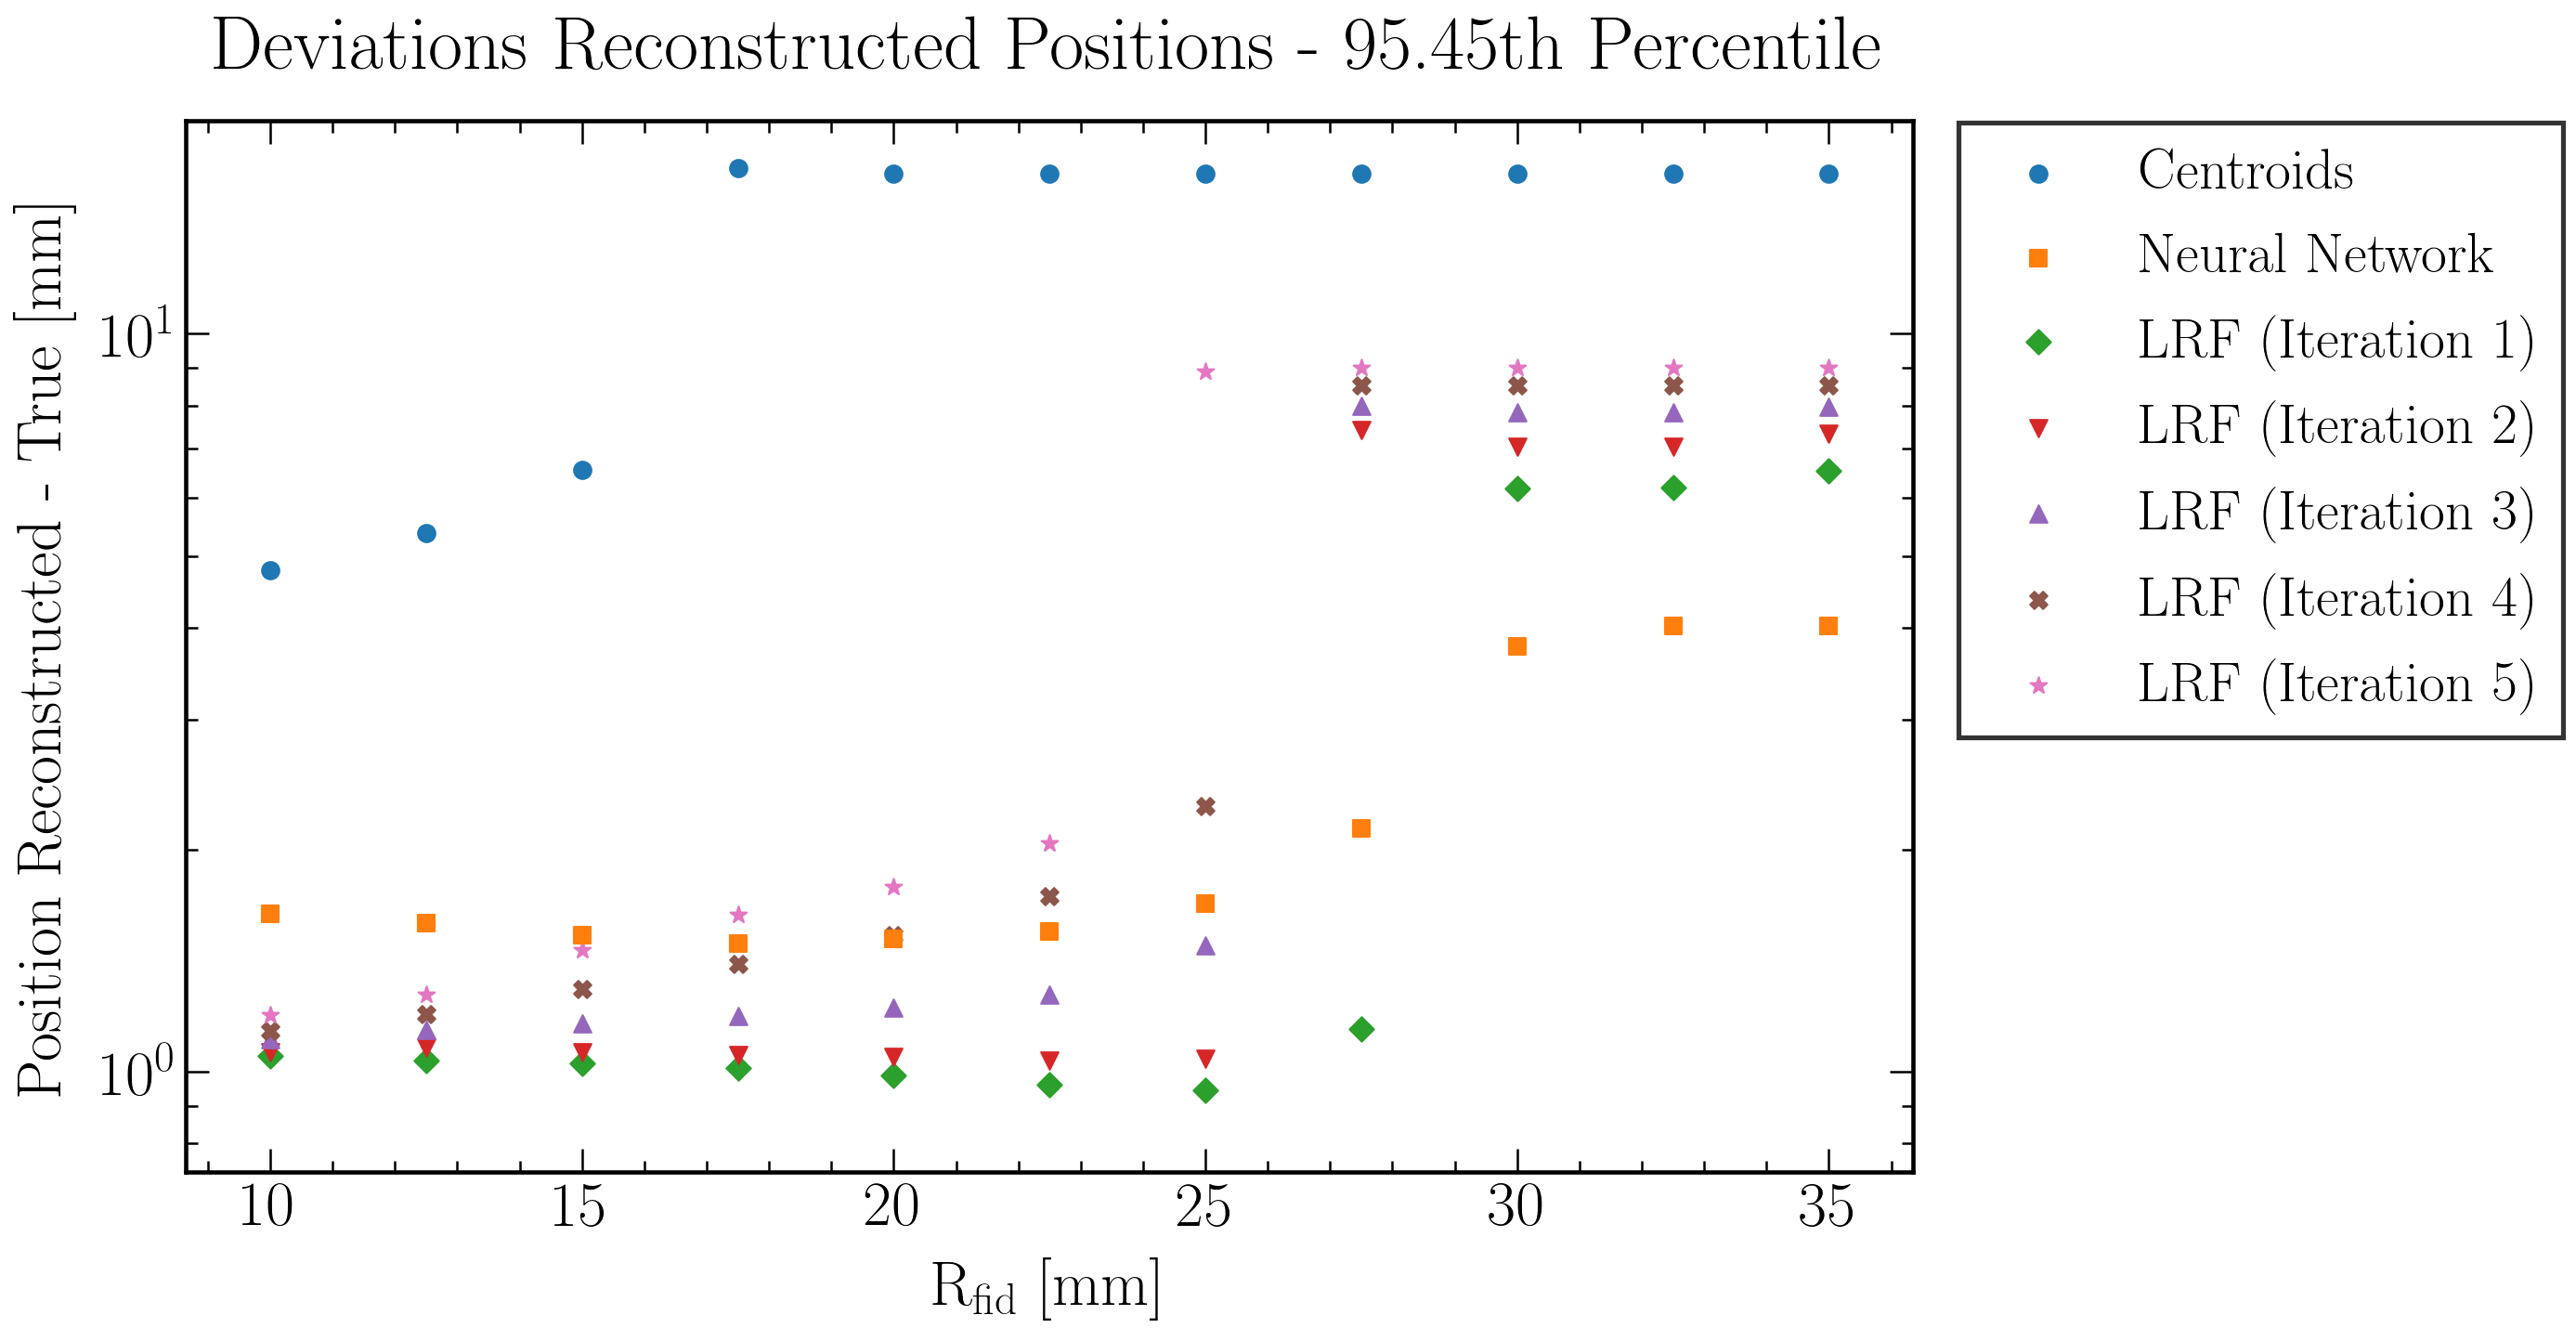

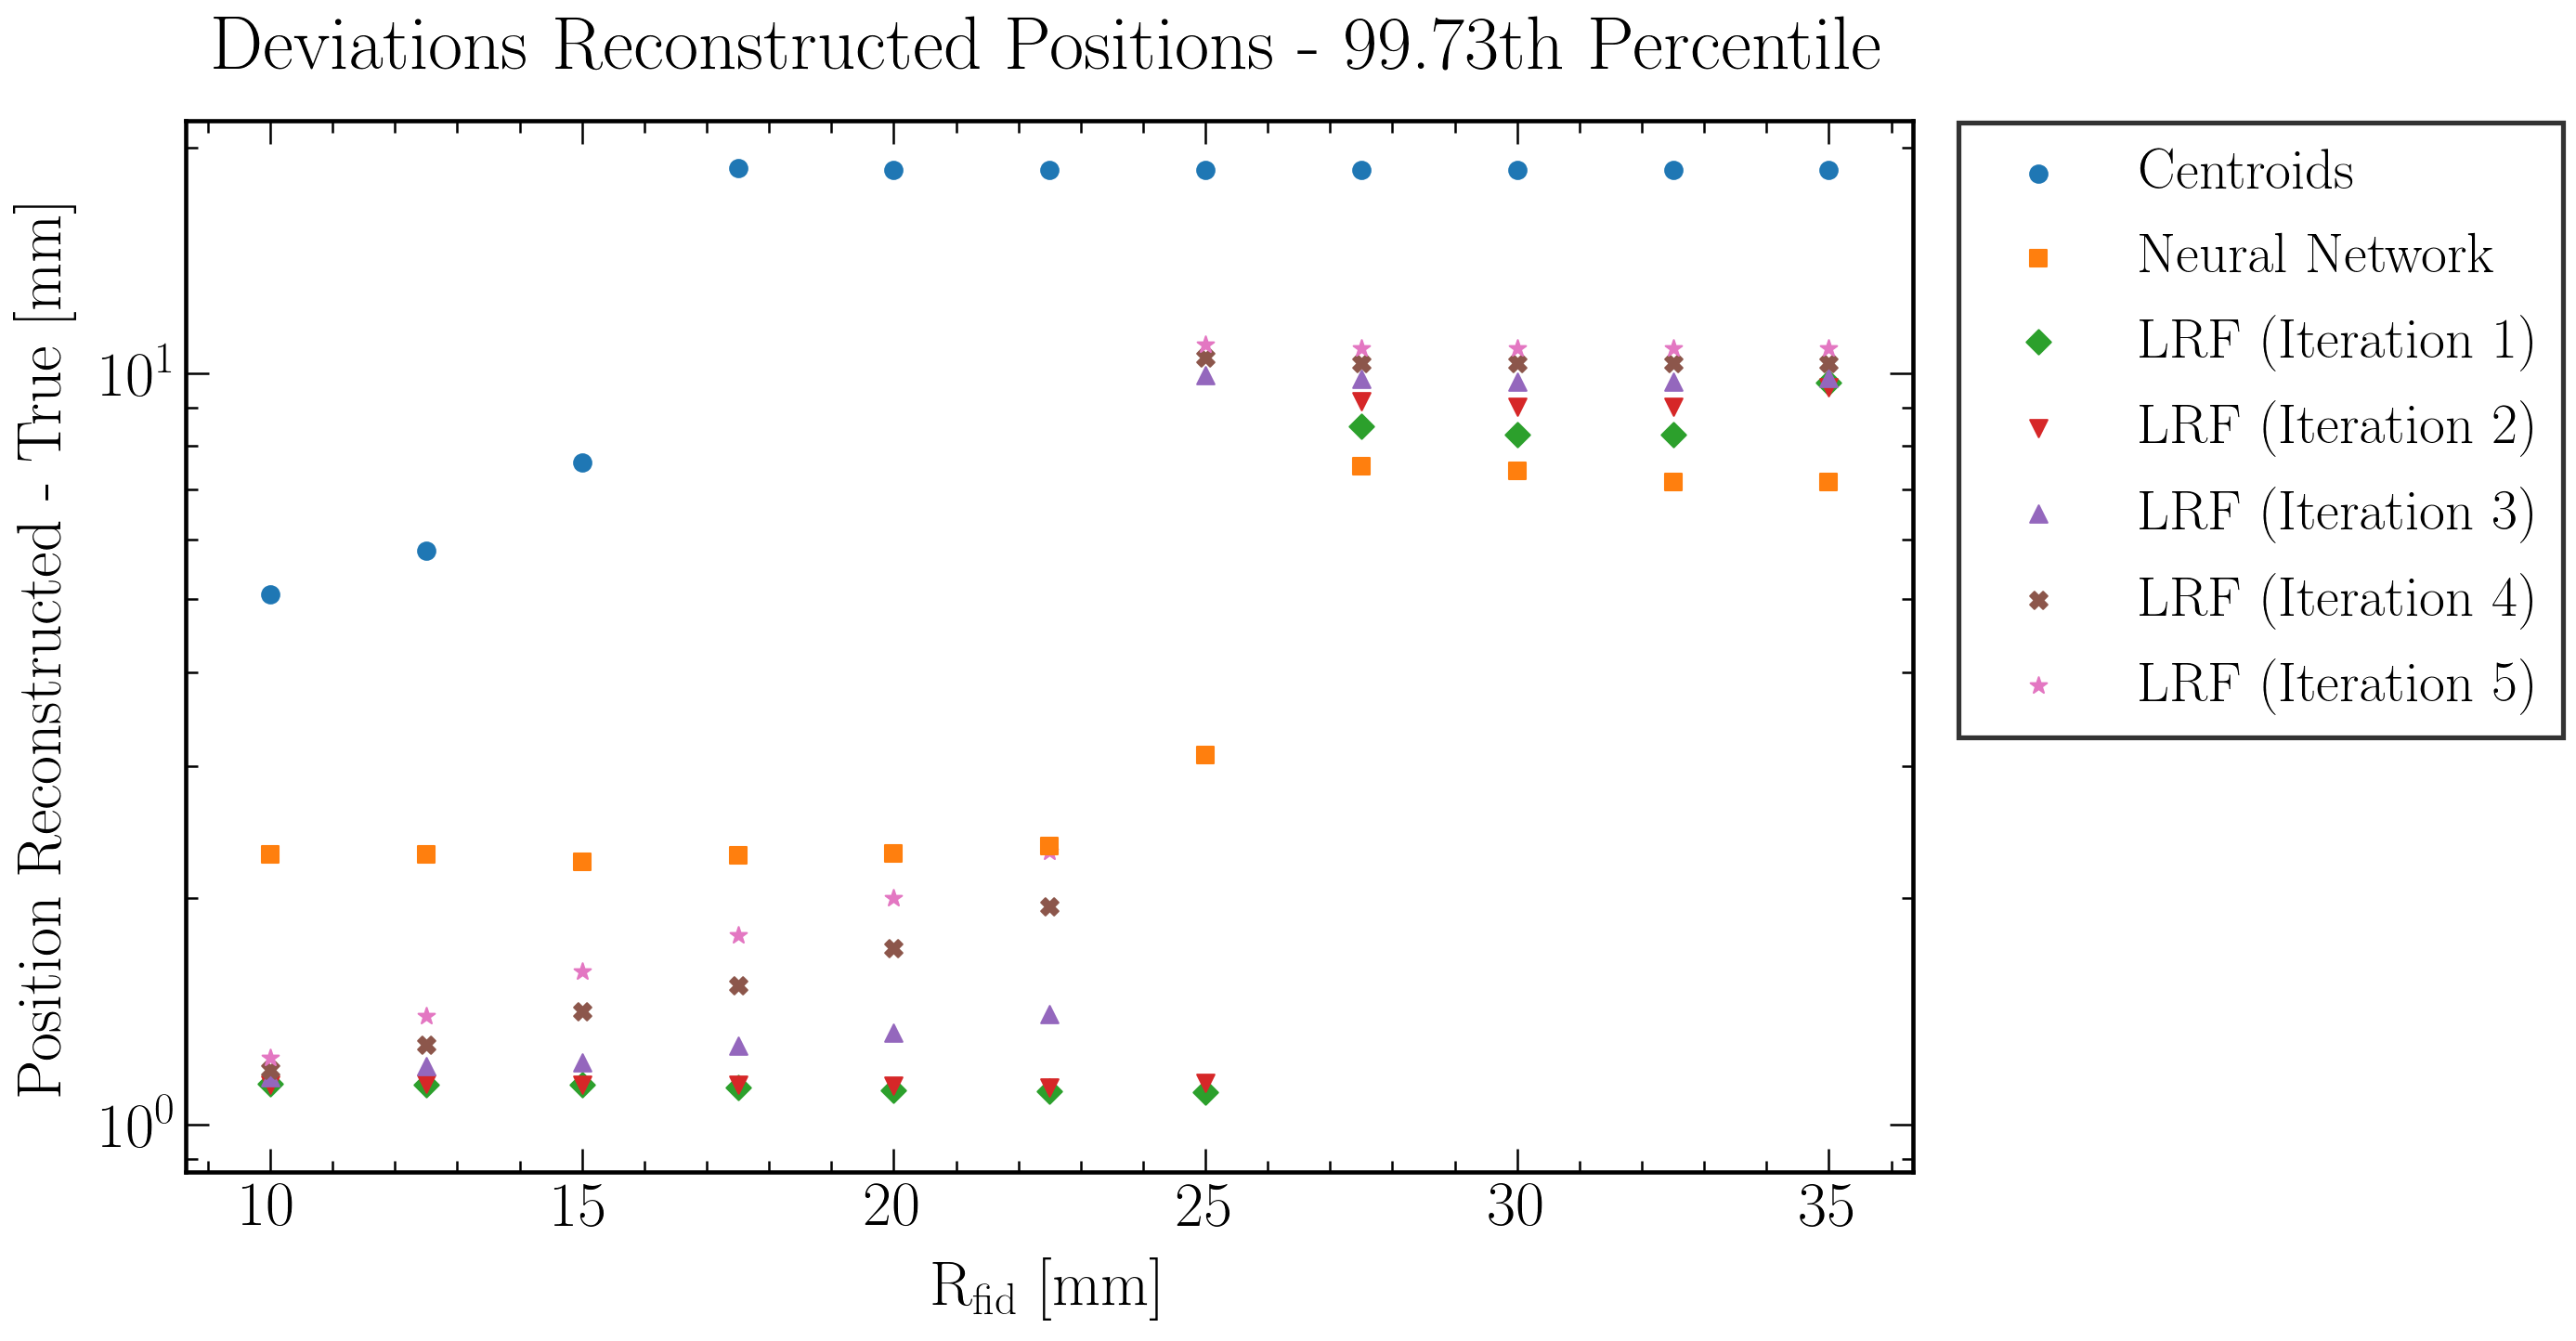

In [26]:
percentile_value_list = [50, 68.27, 95, 95.45, 99.73]

for percentile_value in percentile_value_list:

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Deviations_Centroids['fid']
    y = df_Deviations_Centroids['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

    x = df_Deviations_NN['fid']
    y = df_Deviations_NN['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

    x = df_Deviations_LRF_iteration_1['fid']
    y = df_Deviations_LRF_iteration_1['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

    x = df_Deviations_LRF_iteration_2['fid']
    y = df_Deviations_LRF_iteration_2['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

    x = df_Deviations_LRF_iteration_3['fid']
    y = df_Deviations_LRF_iteration_3['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

    x = df_Deviations_LRF_iteration_4['fid']
    y = df_Deviations_LRF_iteration_4['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

    x = df_Deviations_LRF_iteration_5['fid']
    y = df_Deviations_LRF_iteration_5['delta_'+str(percentile_value)+'_percentile']
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

    plt.ylabel('Position Reconstructed - True [mm]', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Deviations Reconstructed Positions - '+str(percentile_value)+'th Percentile', fontsize = title_size, pad = title_pad)

    plt.yscale('log')
    
    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_All_ReconstructedPosition_Deviations_"+str(percentile_value)+"Percentiles_log.png", bbox_inches = "tight")
    plt.show()

### Fiducialisation

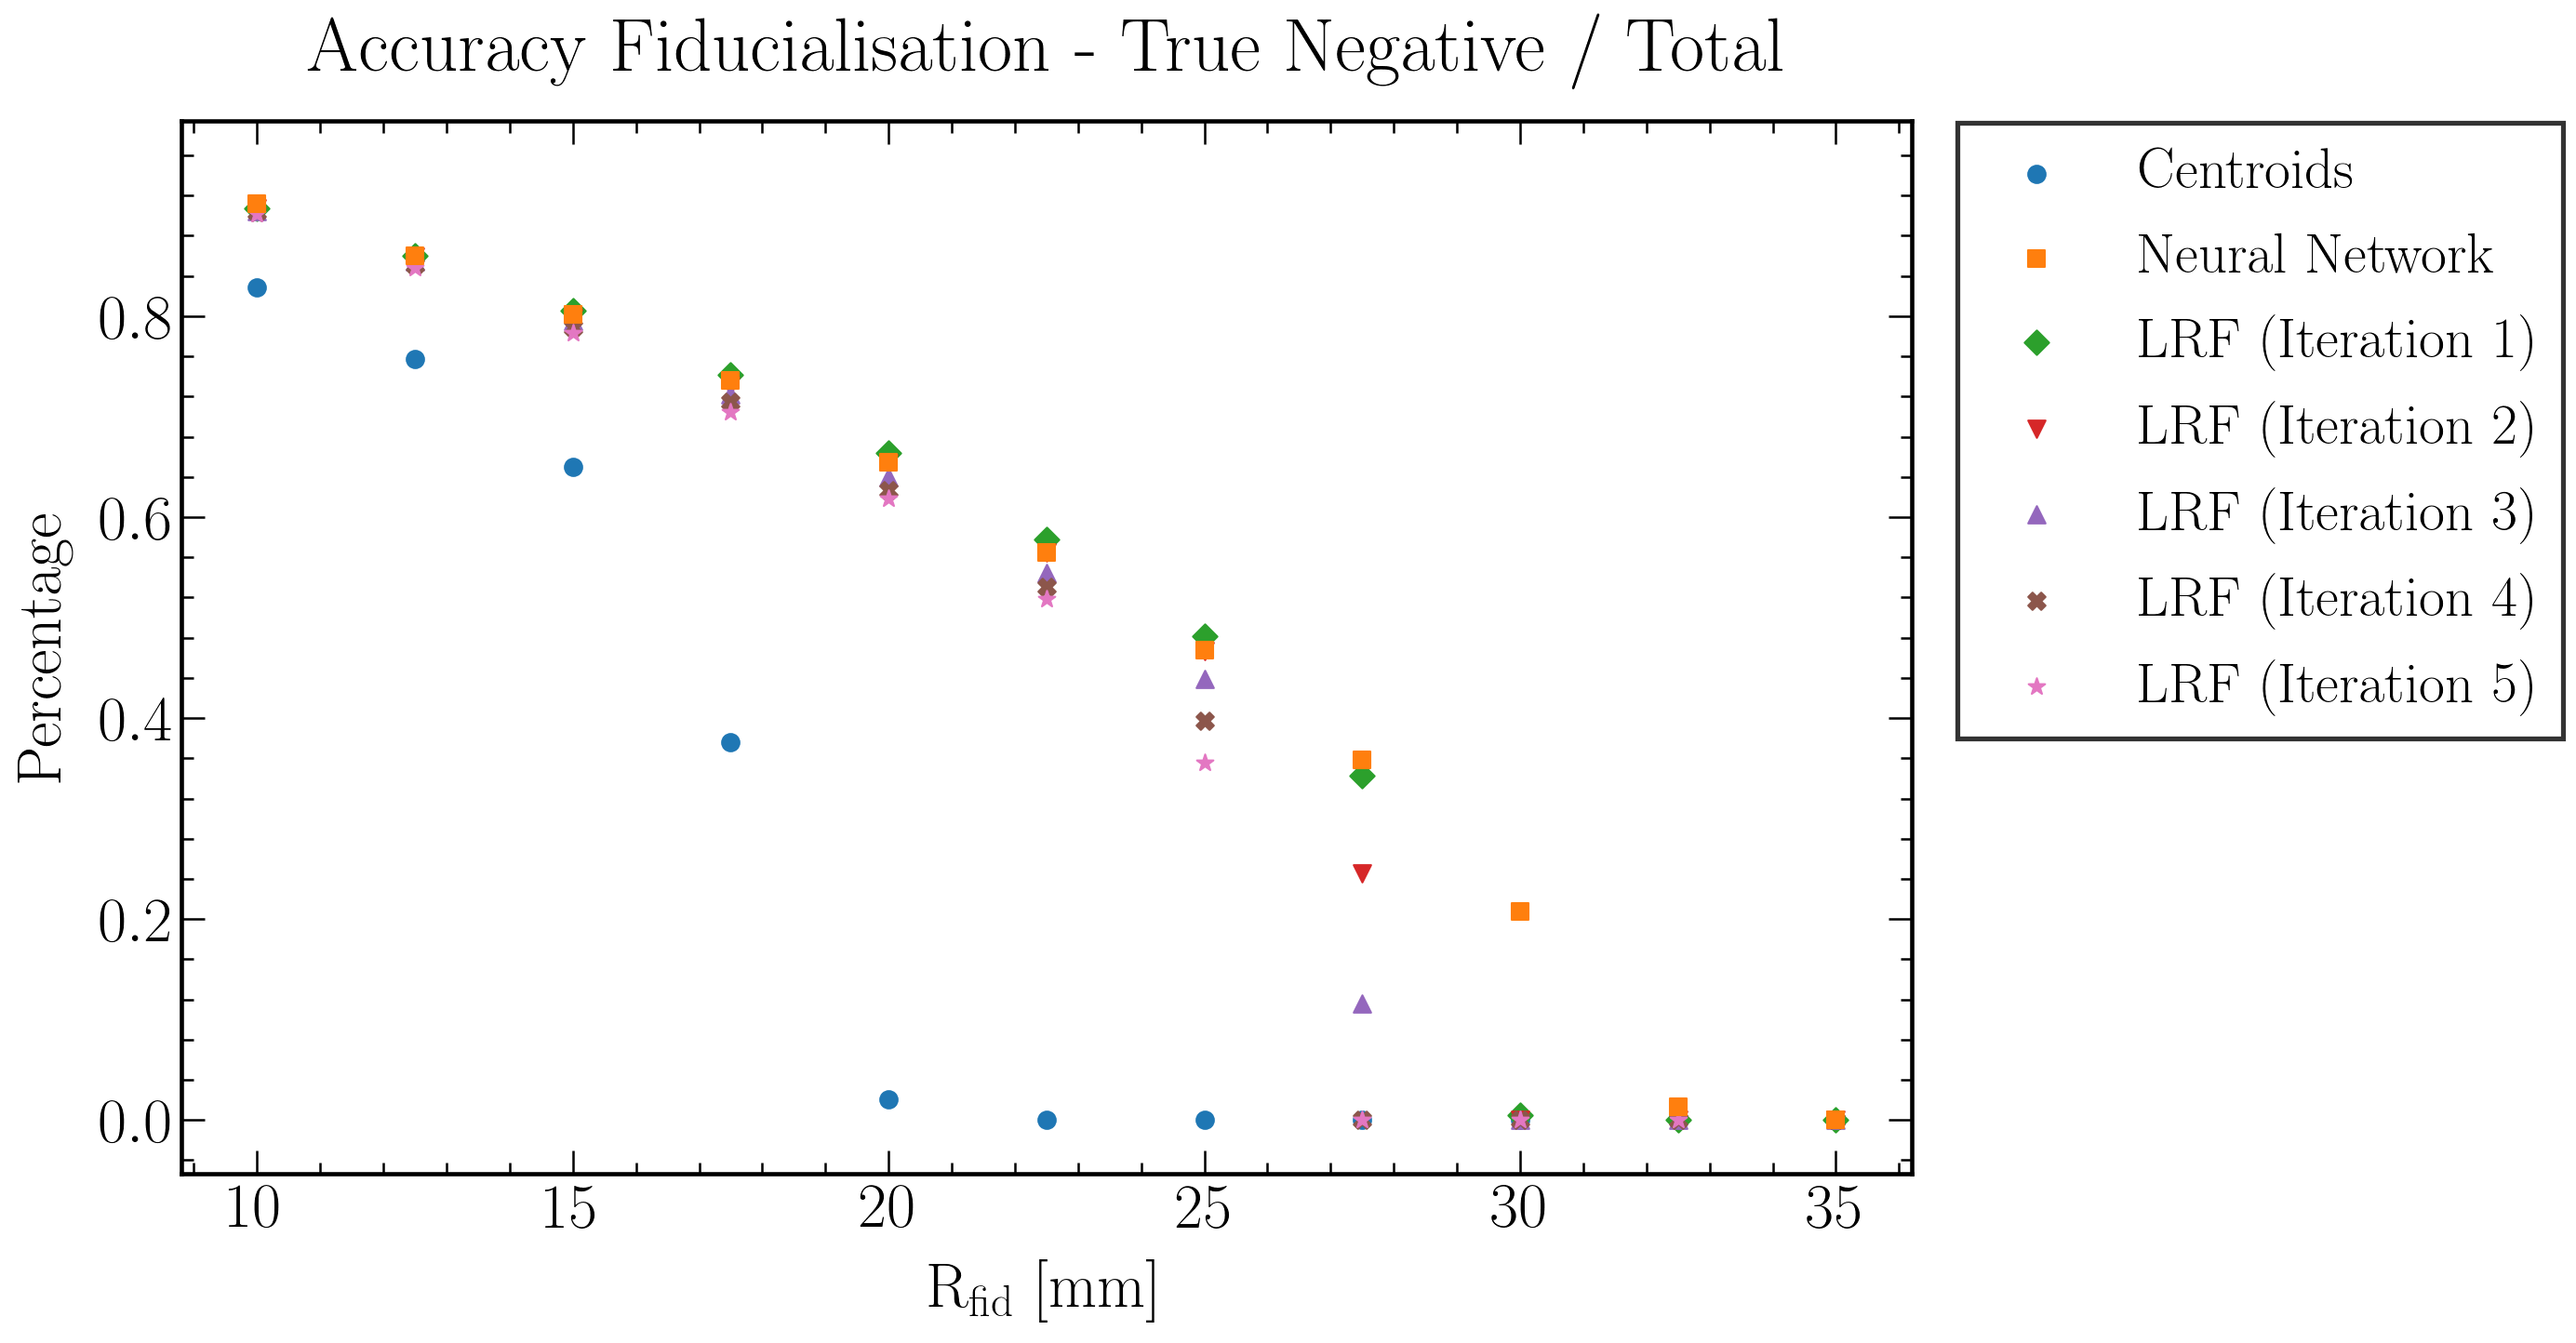

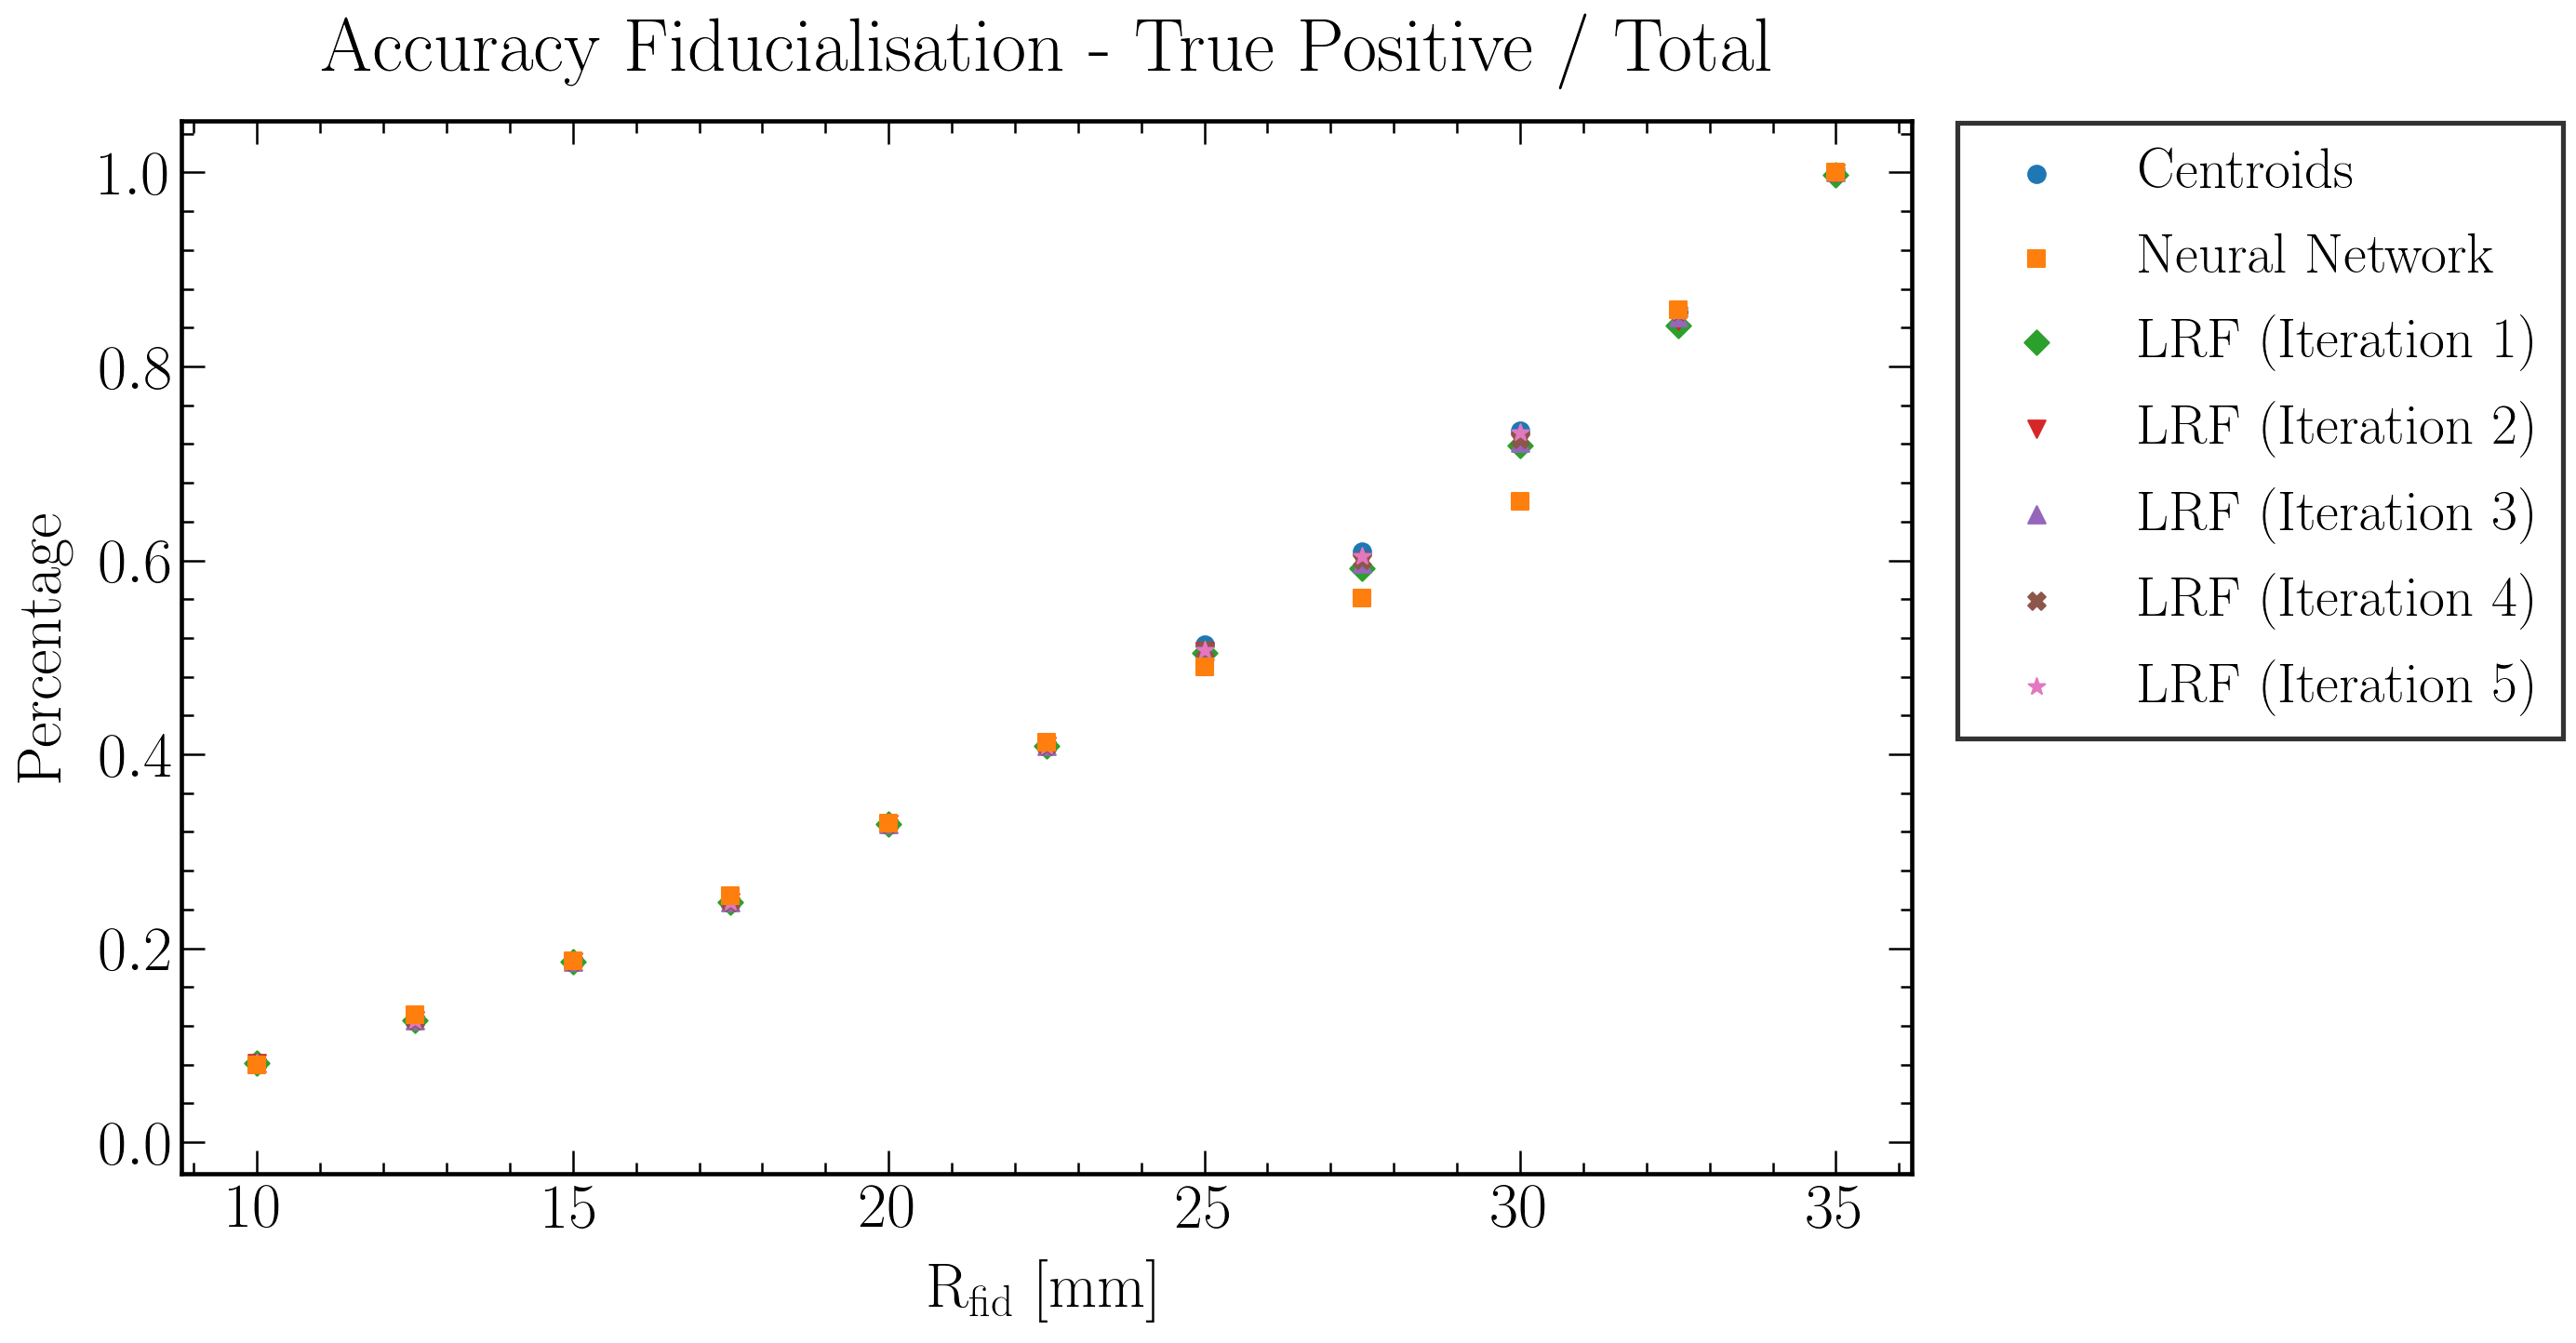

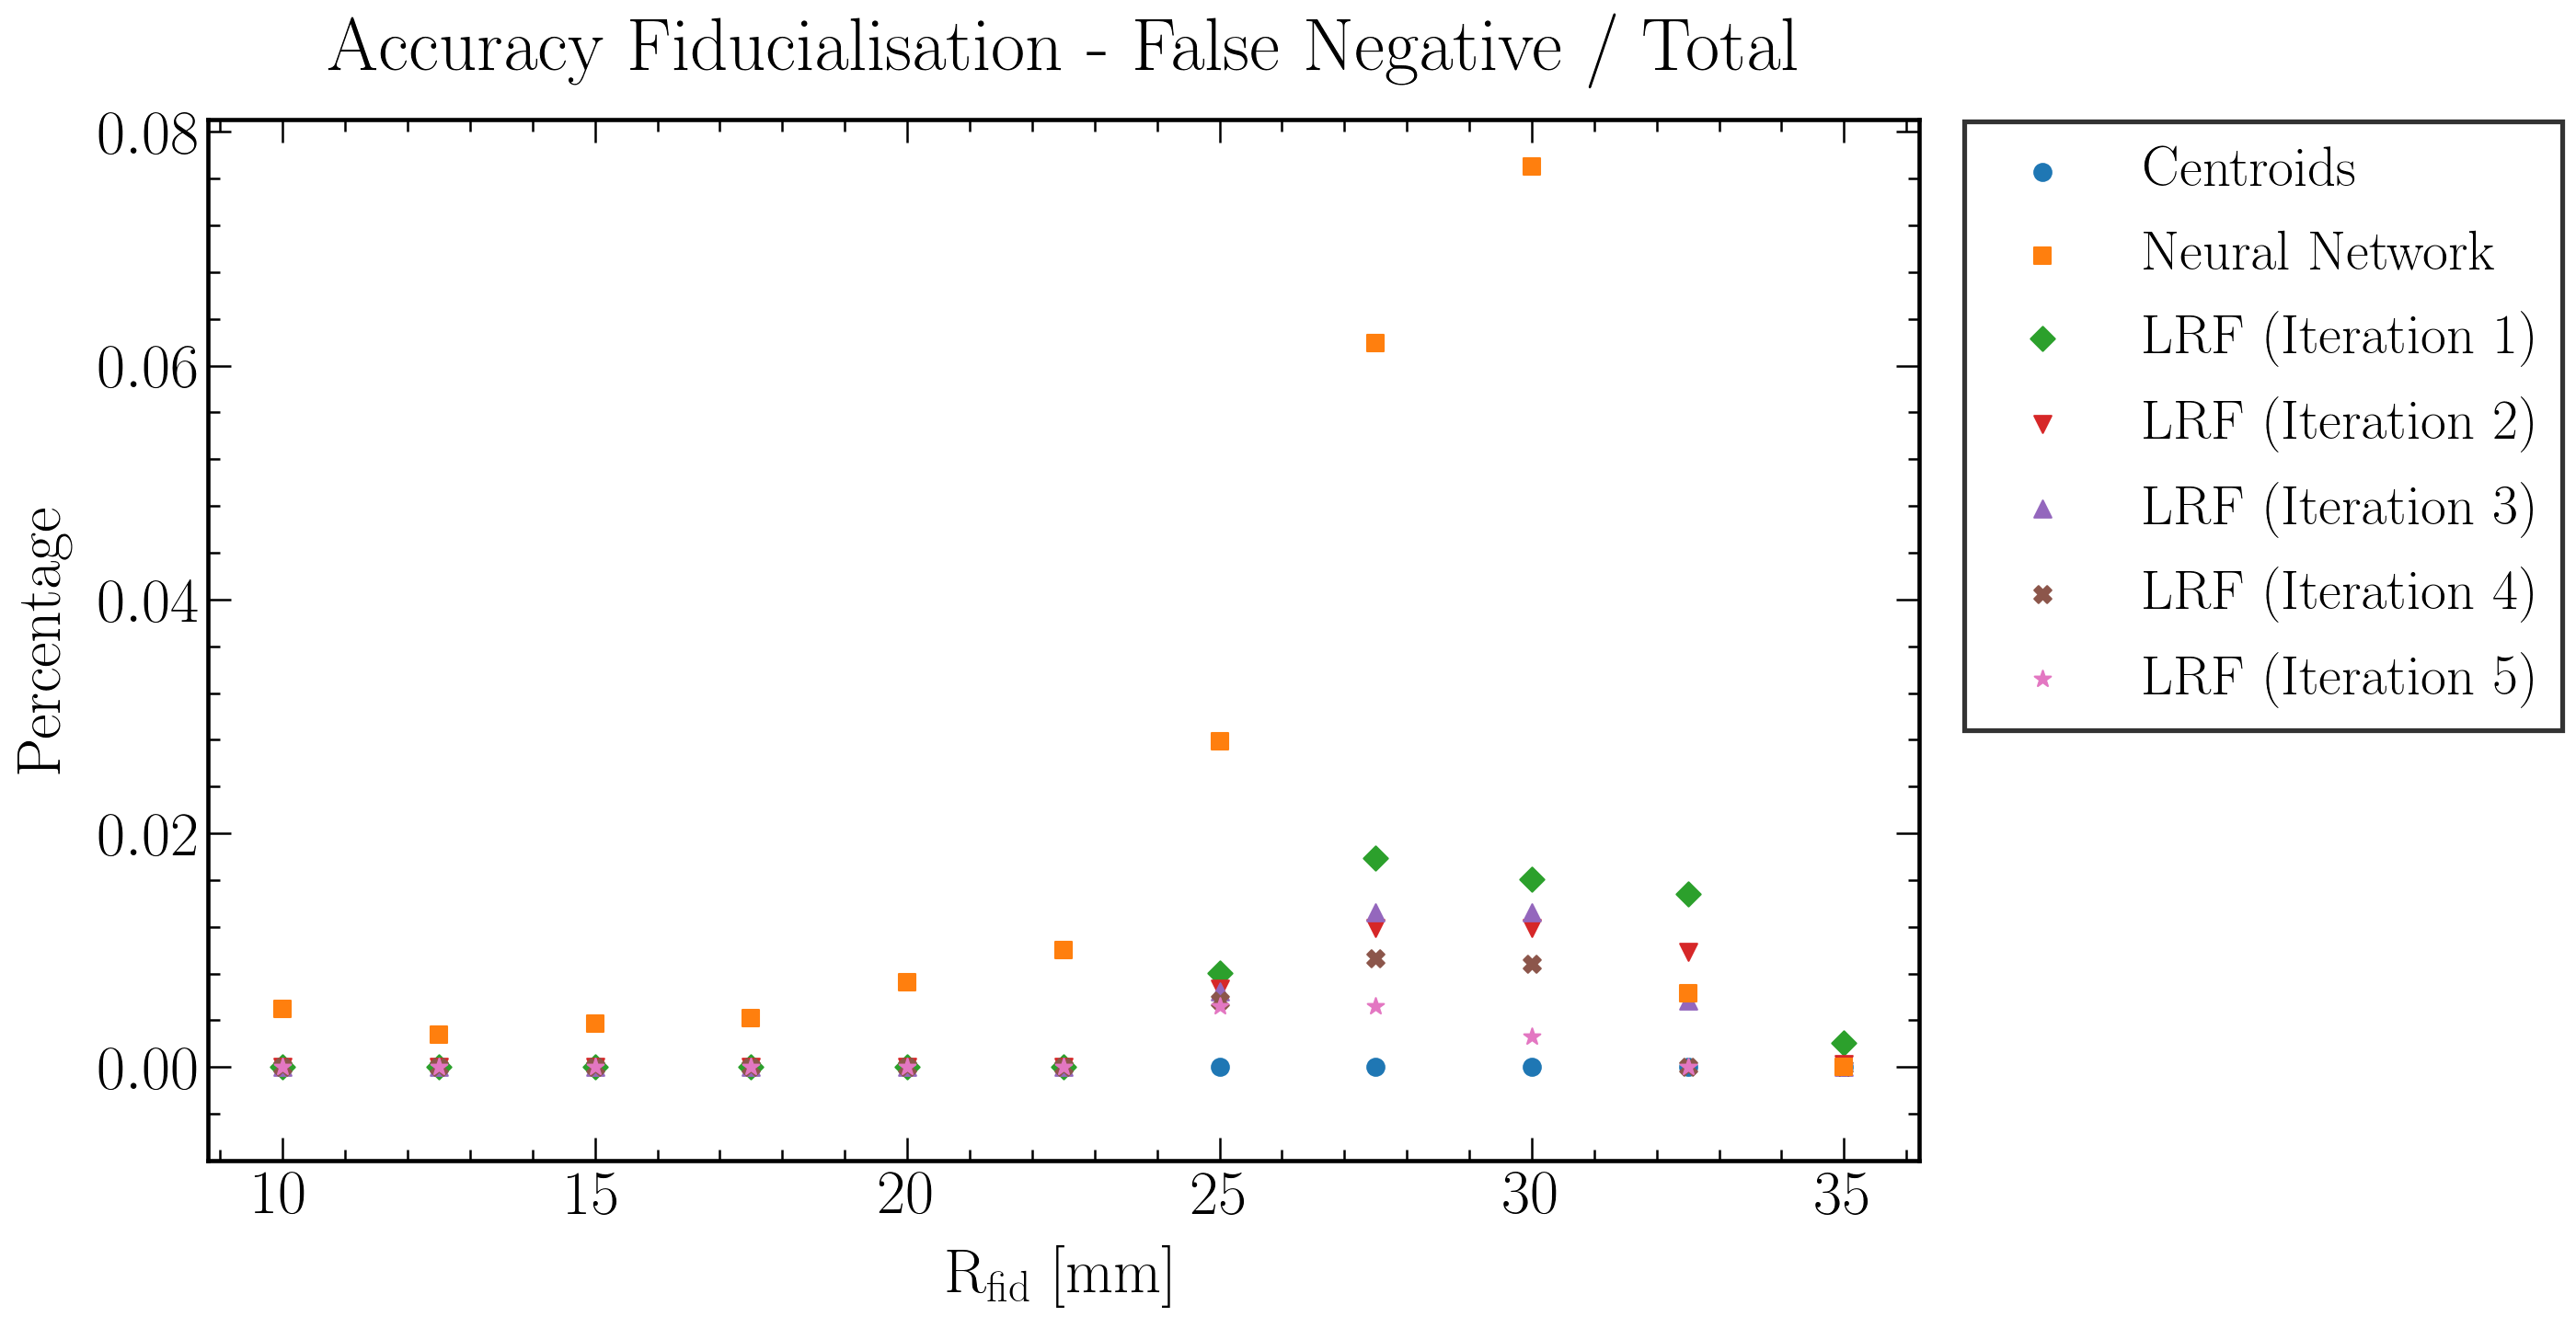

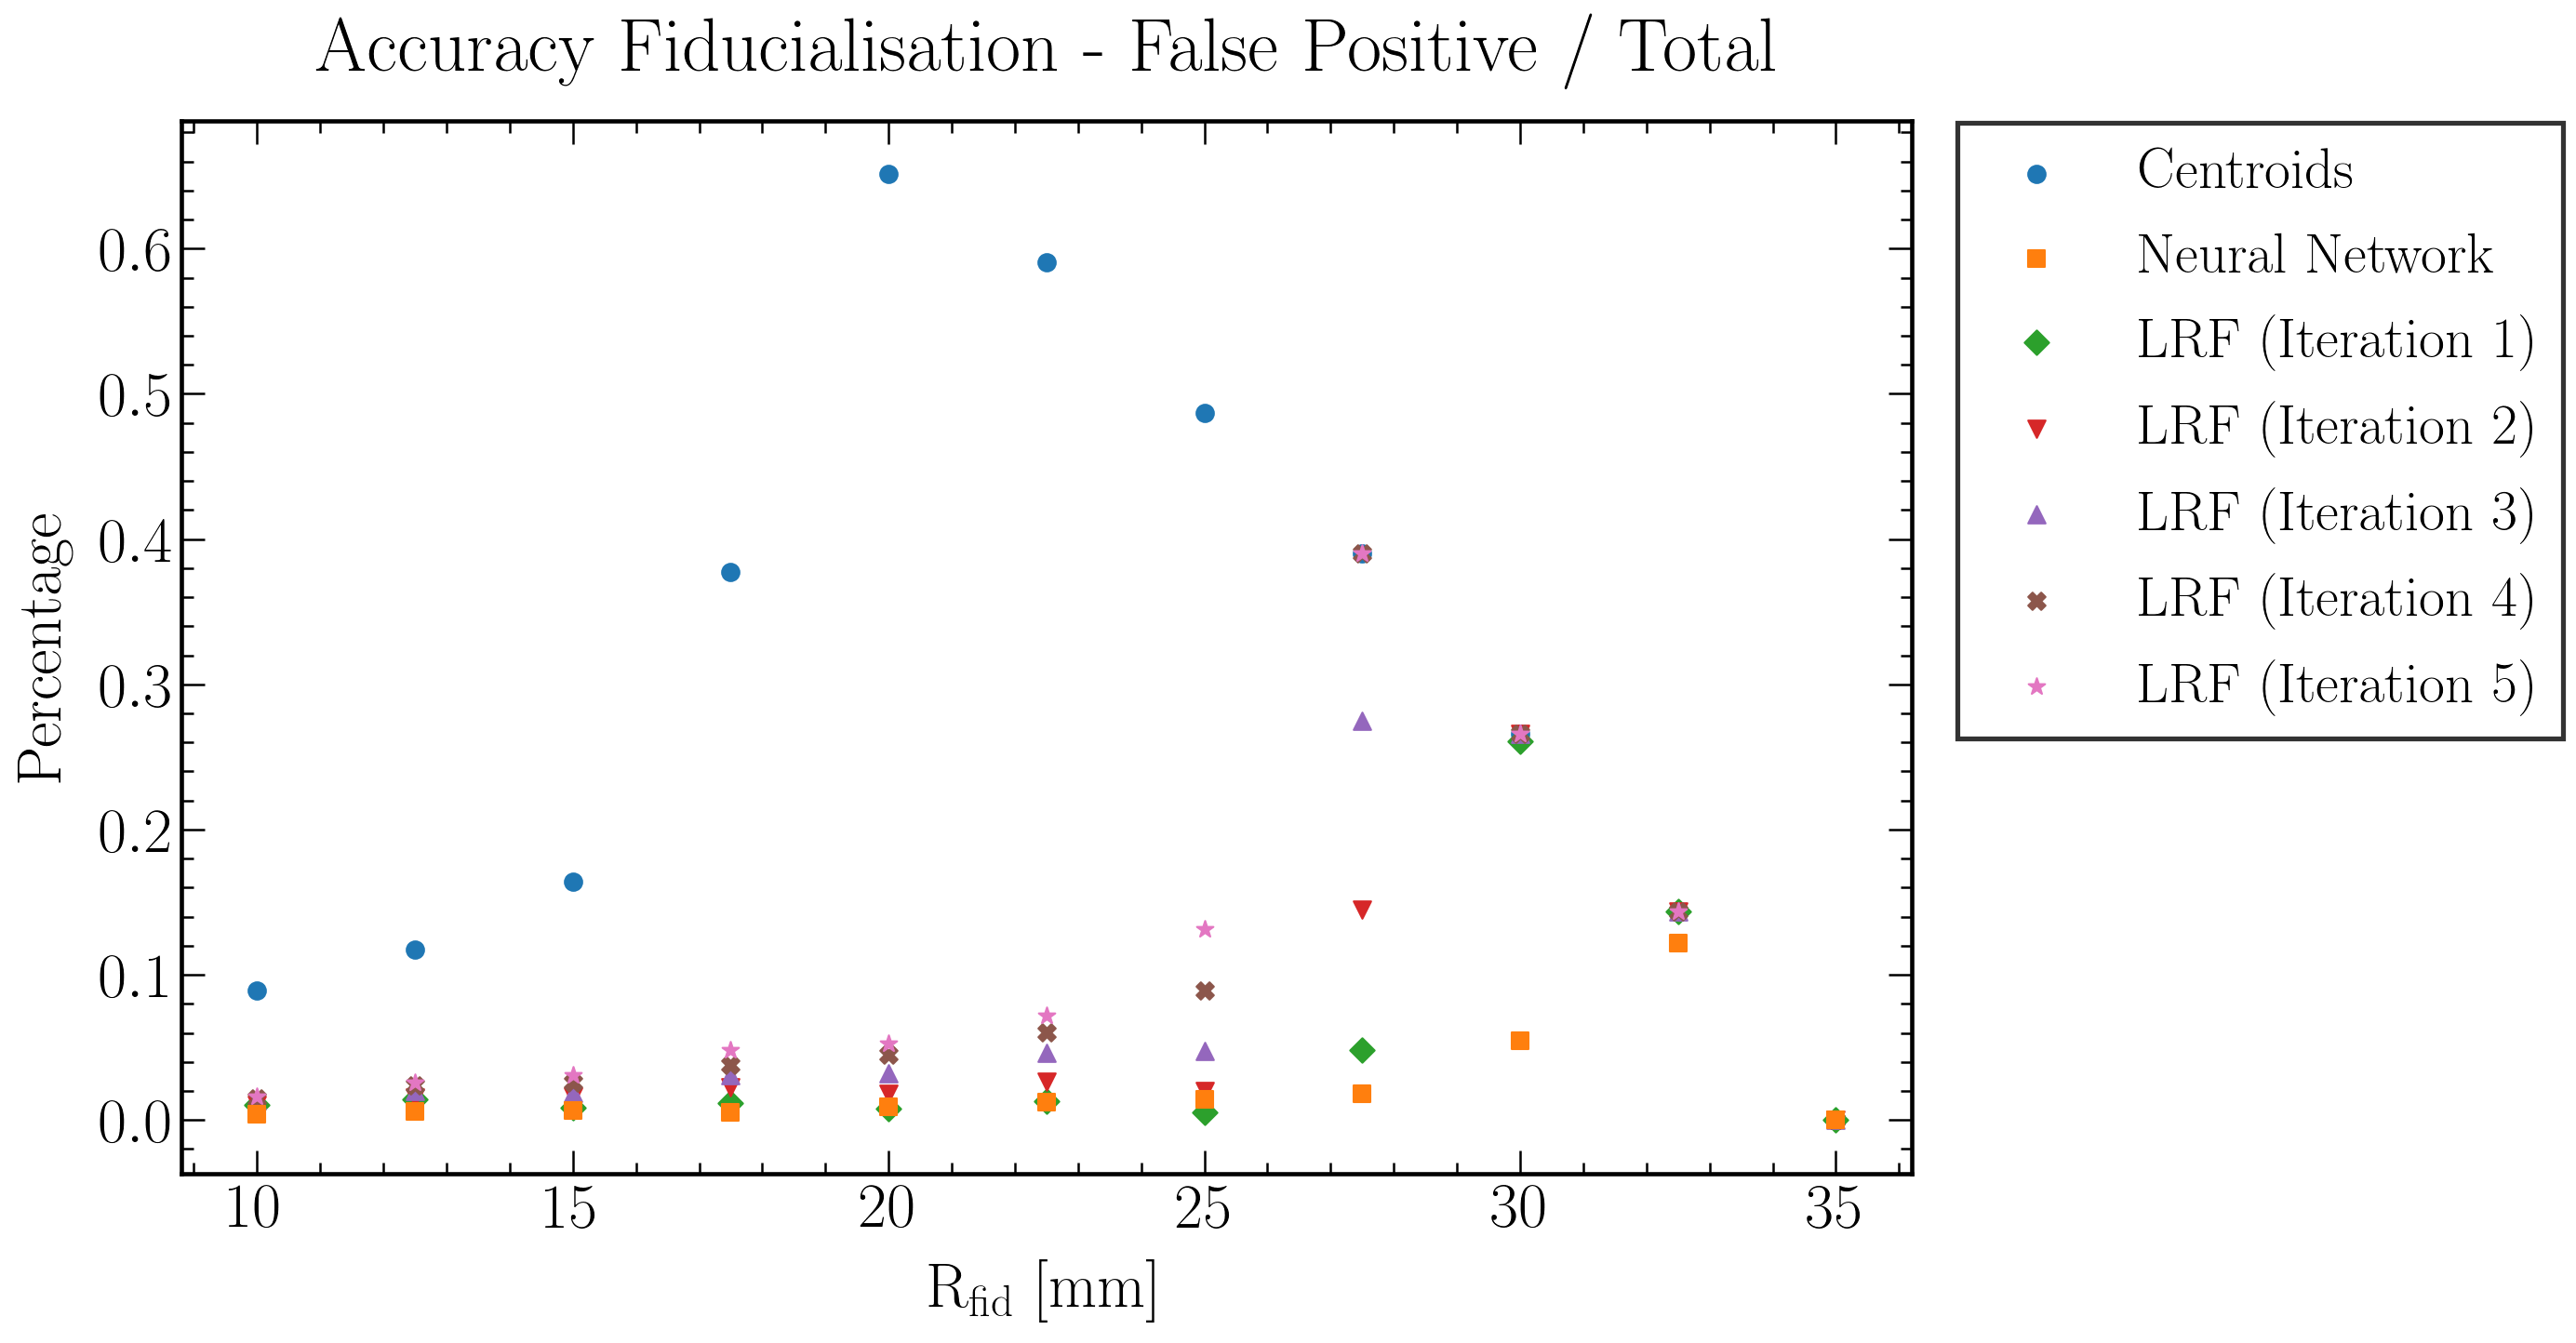

In [27]:
bool_bool_list = ['true_negative', 'true_positive', 'false_negative', 'false_positive']
bool_bool_string_list = ['True Negative / Total', 'True Positive / Total', 'False Negative / Total', 'False Positive / Total']

for i in range(len(bool_bool_list)):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Fiducialisation_Centroids['fid']
    y = df_Fiducialisation_Centroids[bool_bool_list[i]]/df_Fiducialisation_Centroids['total']
    plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

    x = df_Fiducialisation_NN['fid']
    y = df_Fiducialisation_NN[bool_bool_list[i]]/df_Fiducialisation_NN['total']
    plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

    x = df_Fiducialisation_LRF_iteration_1['fid']
    y = df_Fiducialisation_LRF_iteration_1[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_1['total']
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

    x = df_Fiducialisation_LRF_iteration_2['fid']
    y =df_Fiducialisation_LRF_iteration_2[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_2['total']
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

    x = df_Fiducialisation_LRF_iteration_3['fid']
    y = df_Fiducialisation_LRF_iteration_3[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_3['total']
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

    x = df_Fiducialisation_LRF_iteration_4['fid']
    y = df_Fiducialisation_LRF_iteration_4[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_4['total']
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

    x = df_Fiducialisation_LRF_iteration_5['fid']
    y = df_Fiducialisation_LRF_iteration_5[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_5['total']
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

    plt.ylabel('Percentage', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Accuracy Fiducialisation - '+bool_bool_string_list[i], fontsize = title_size, pad = title_pad)

    plt.xlim(8.8, 36.2)
    
    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_All_Goodness_fiducialisation_"+bool_bool_list[i]+"_of_total.png", bbox_inches = "tight")
    plt.show()

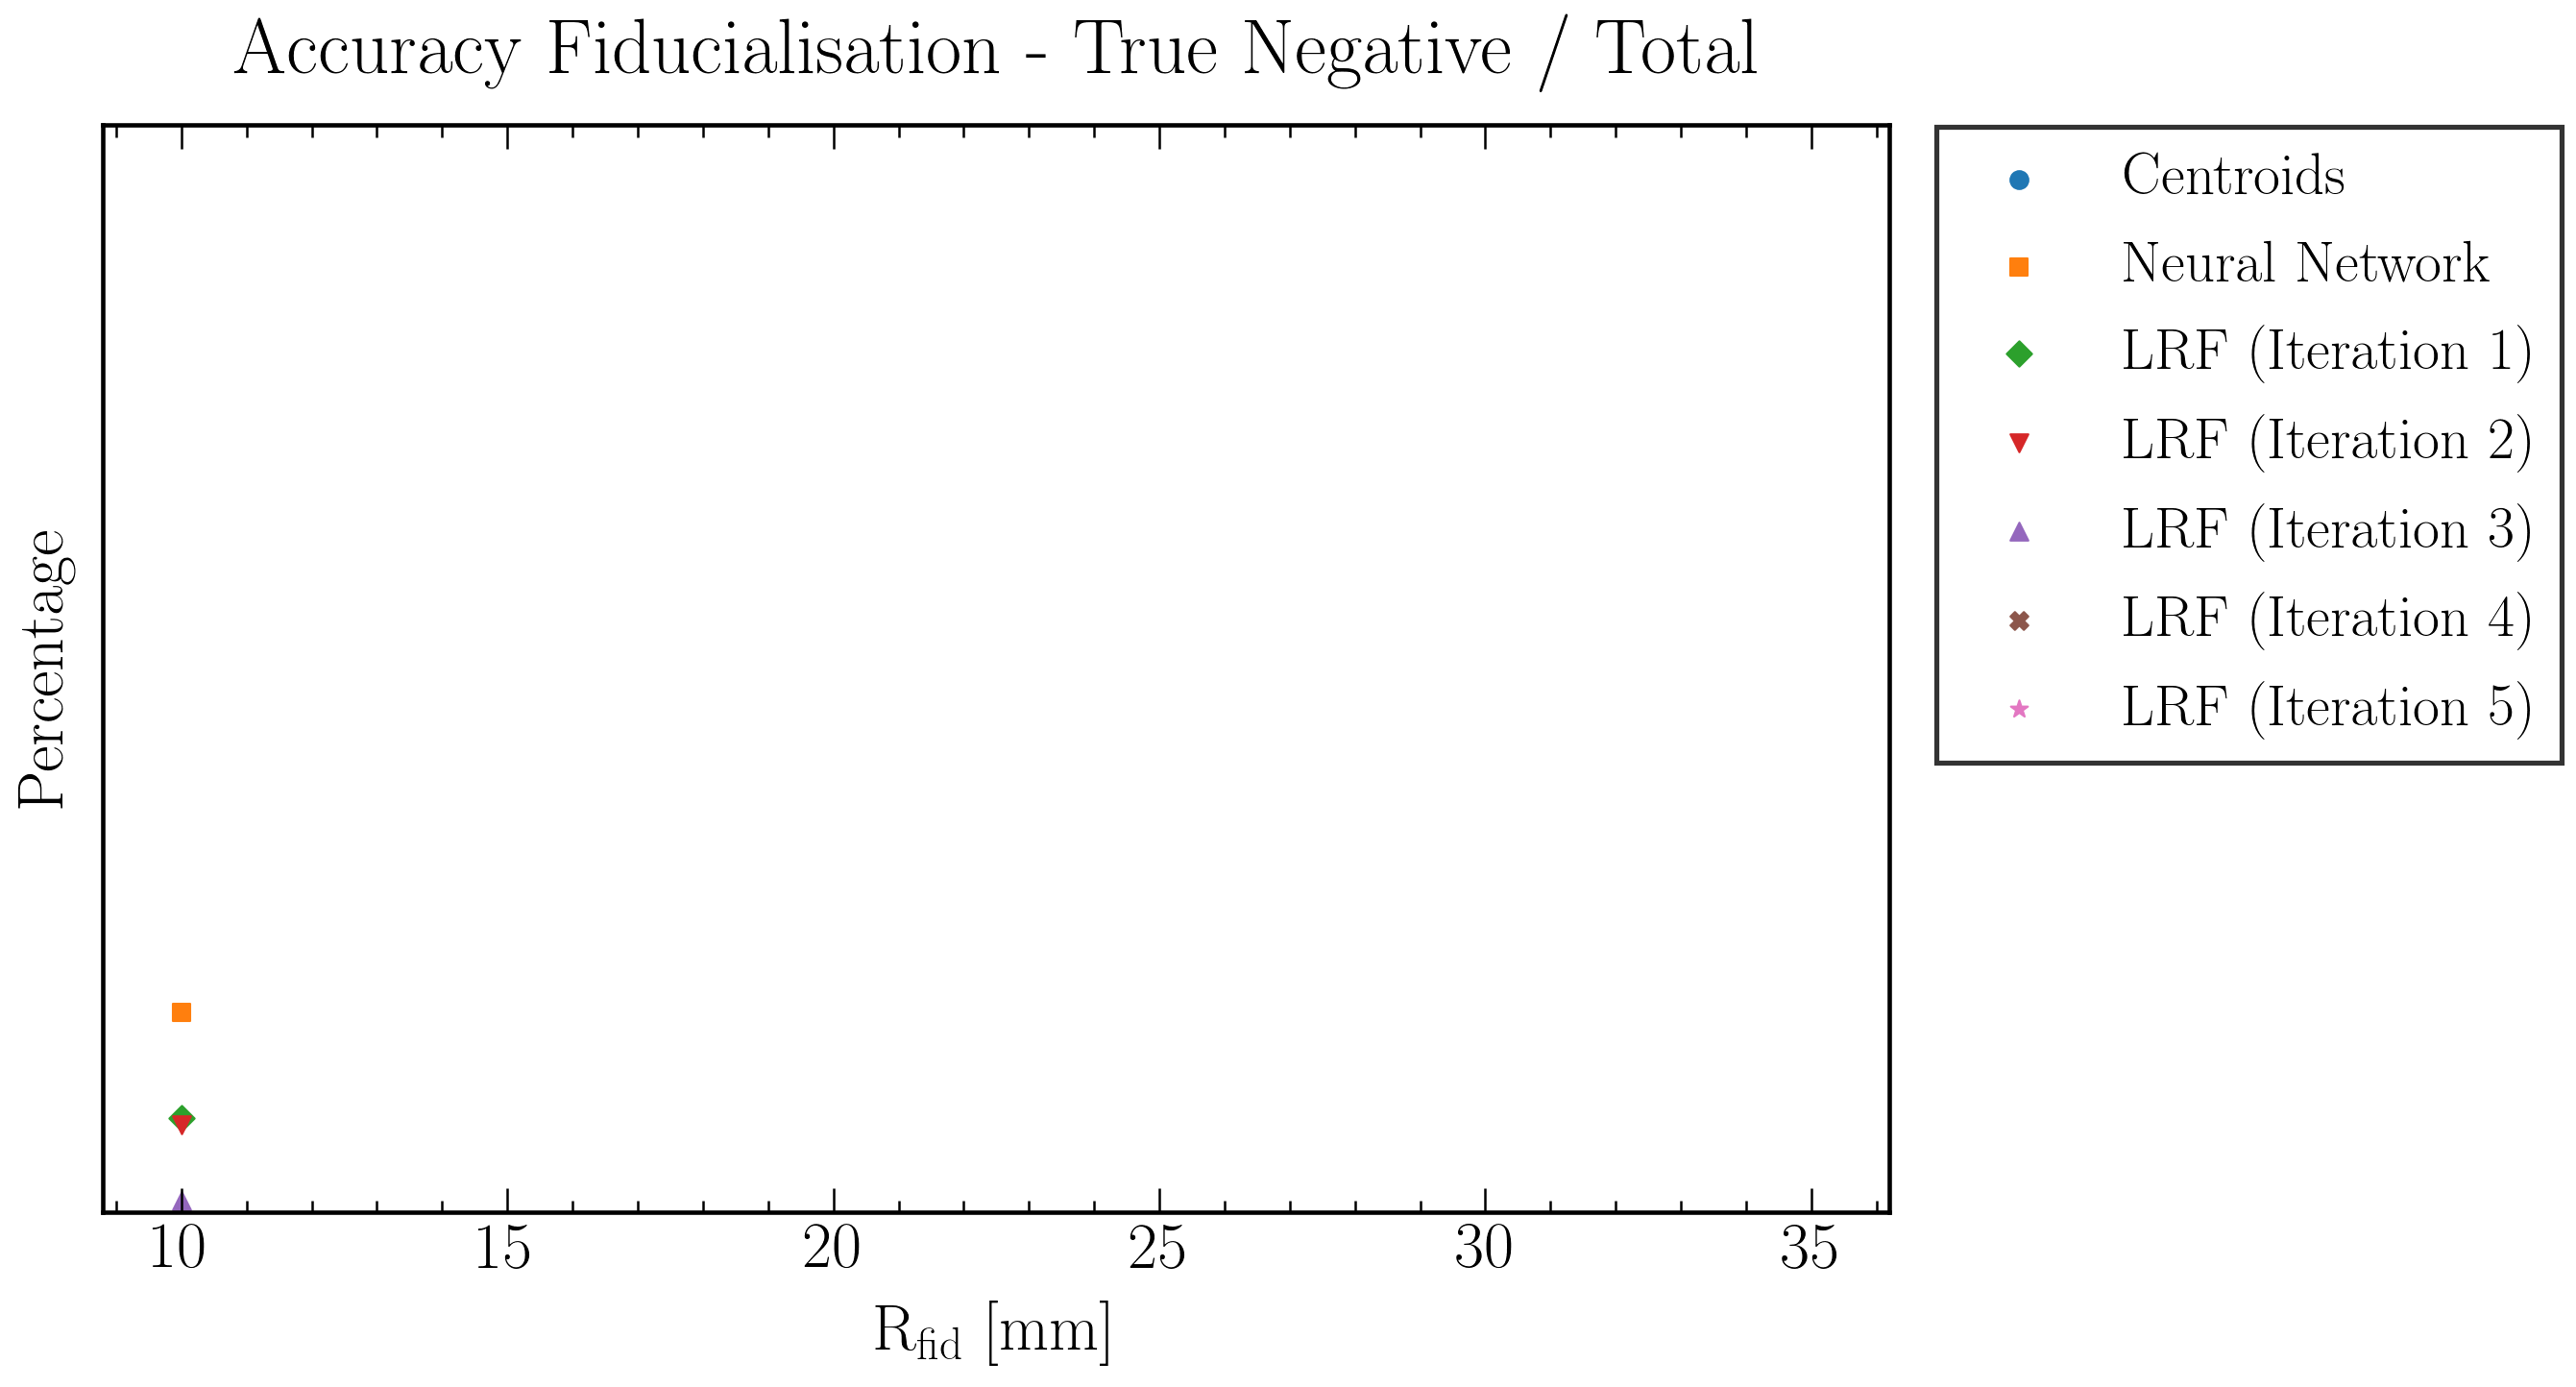

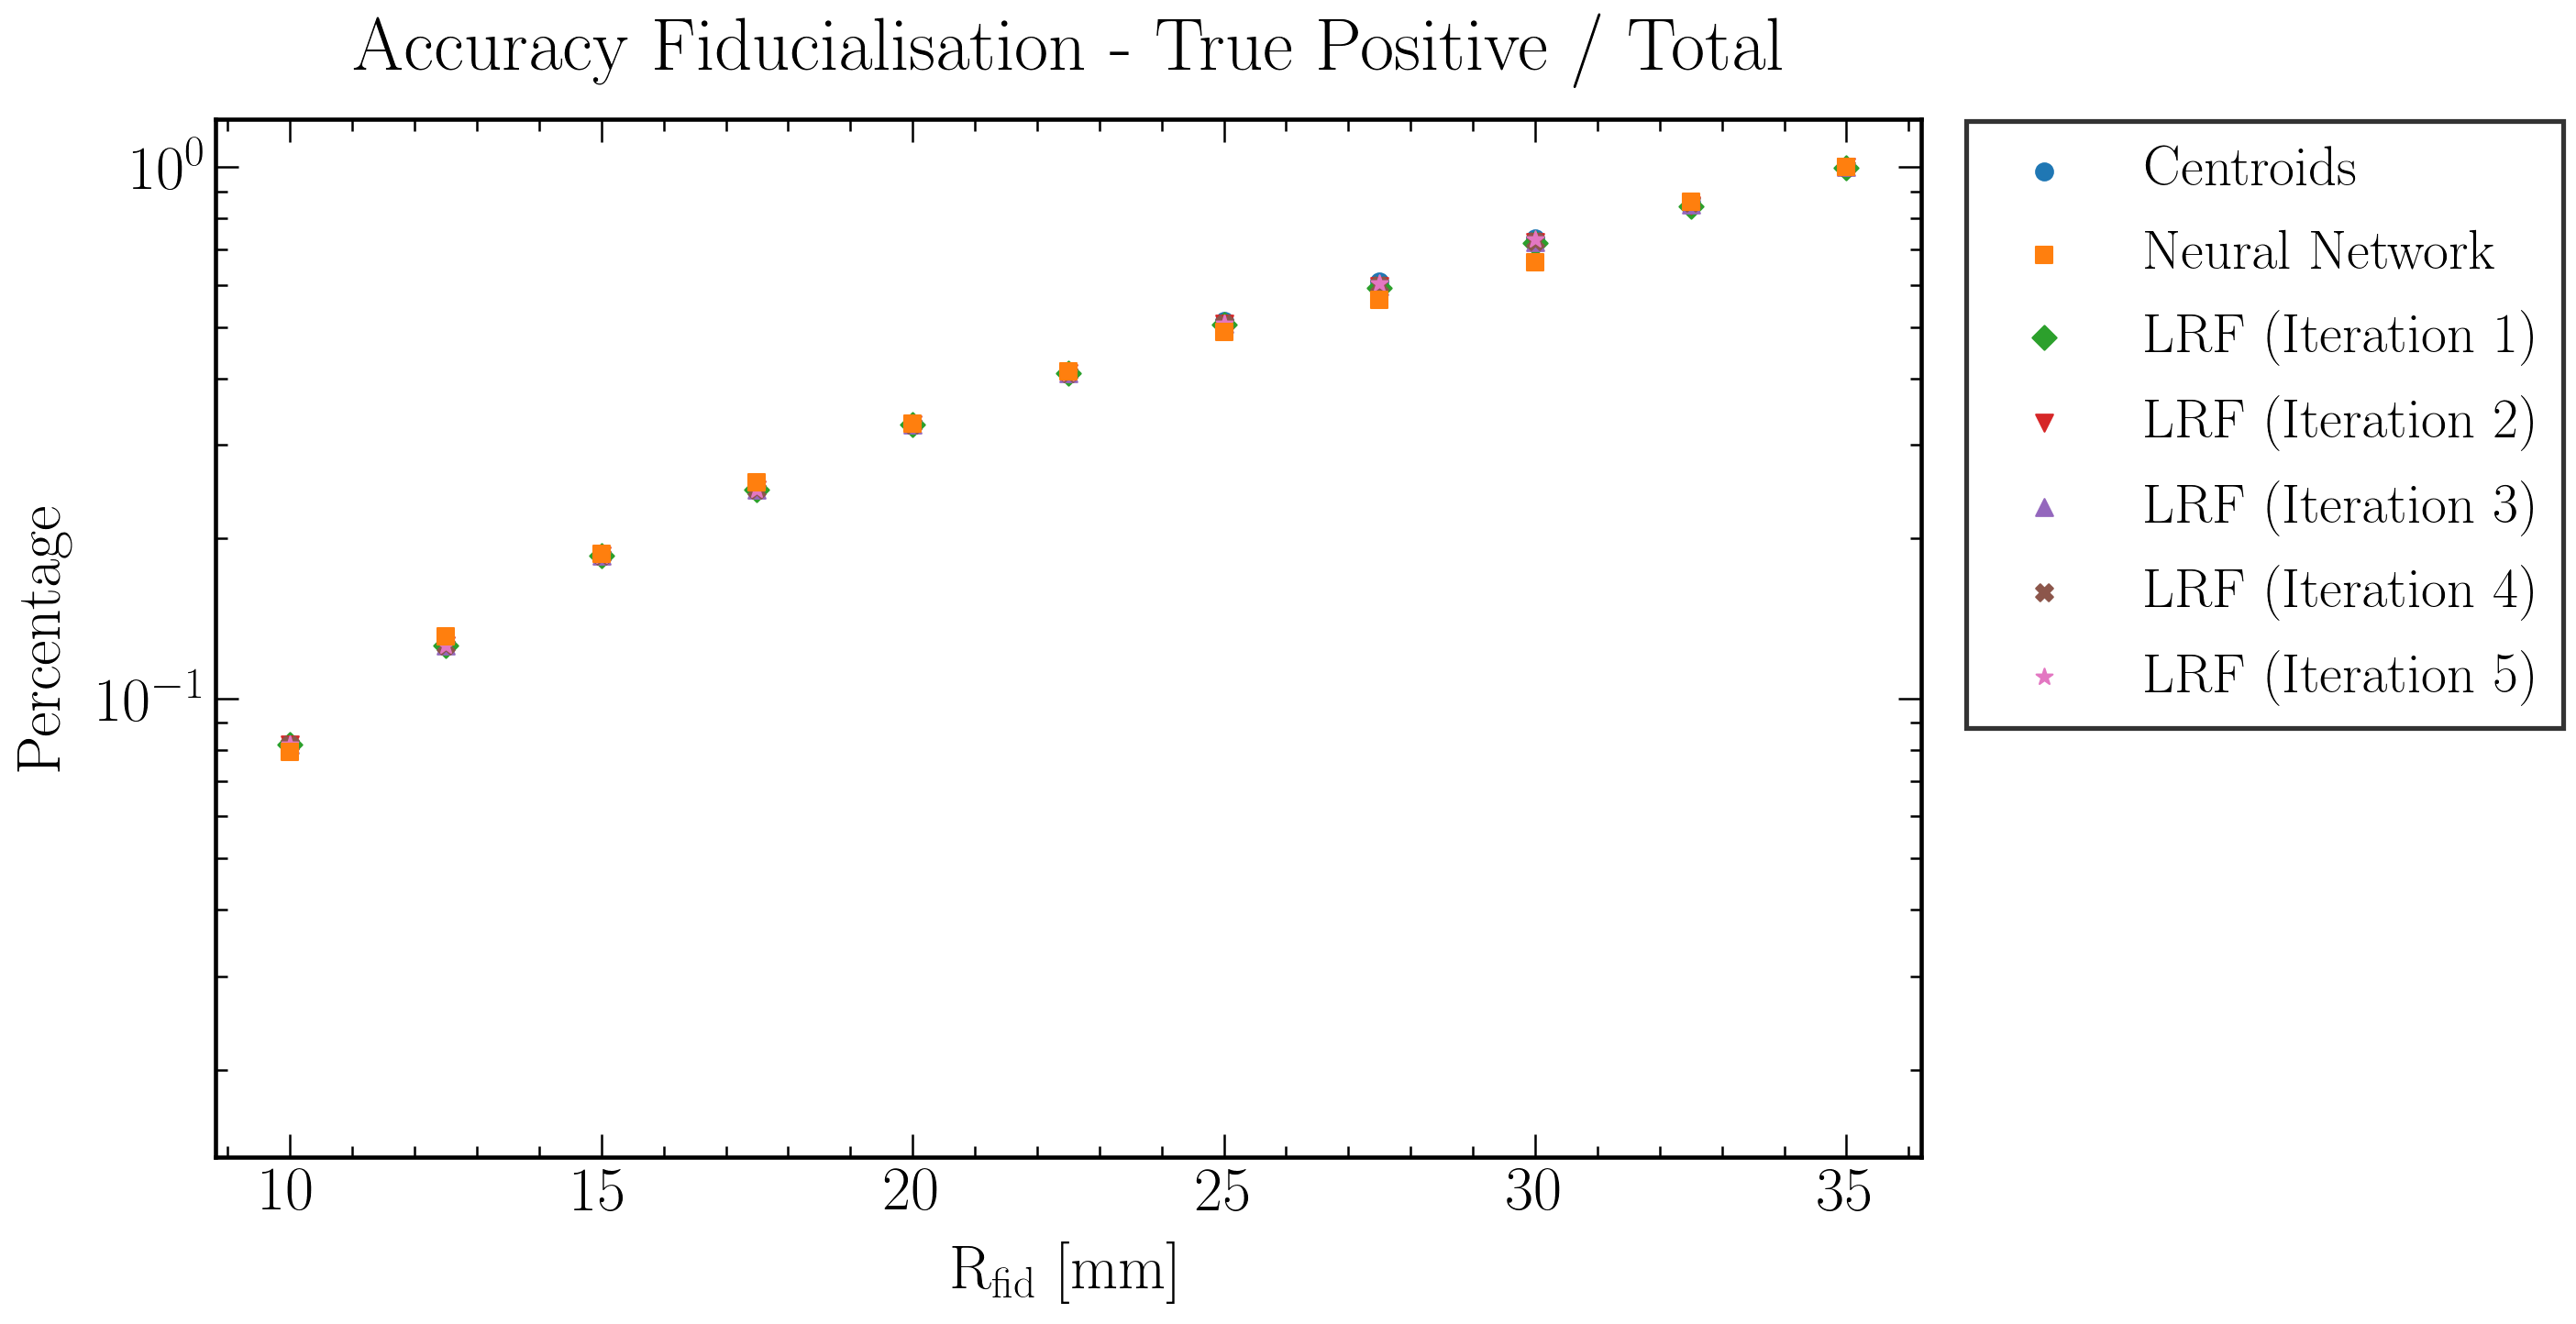

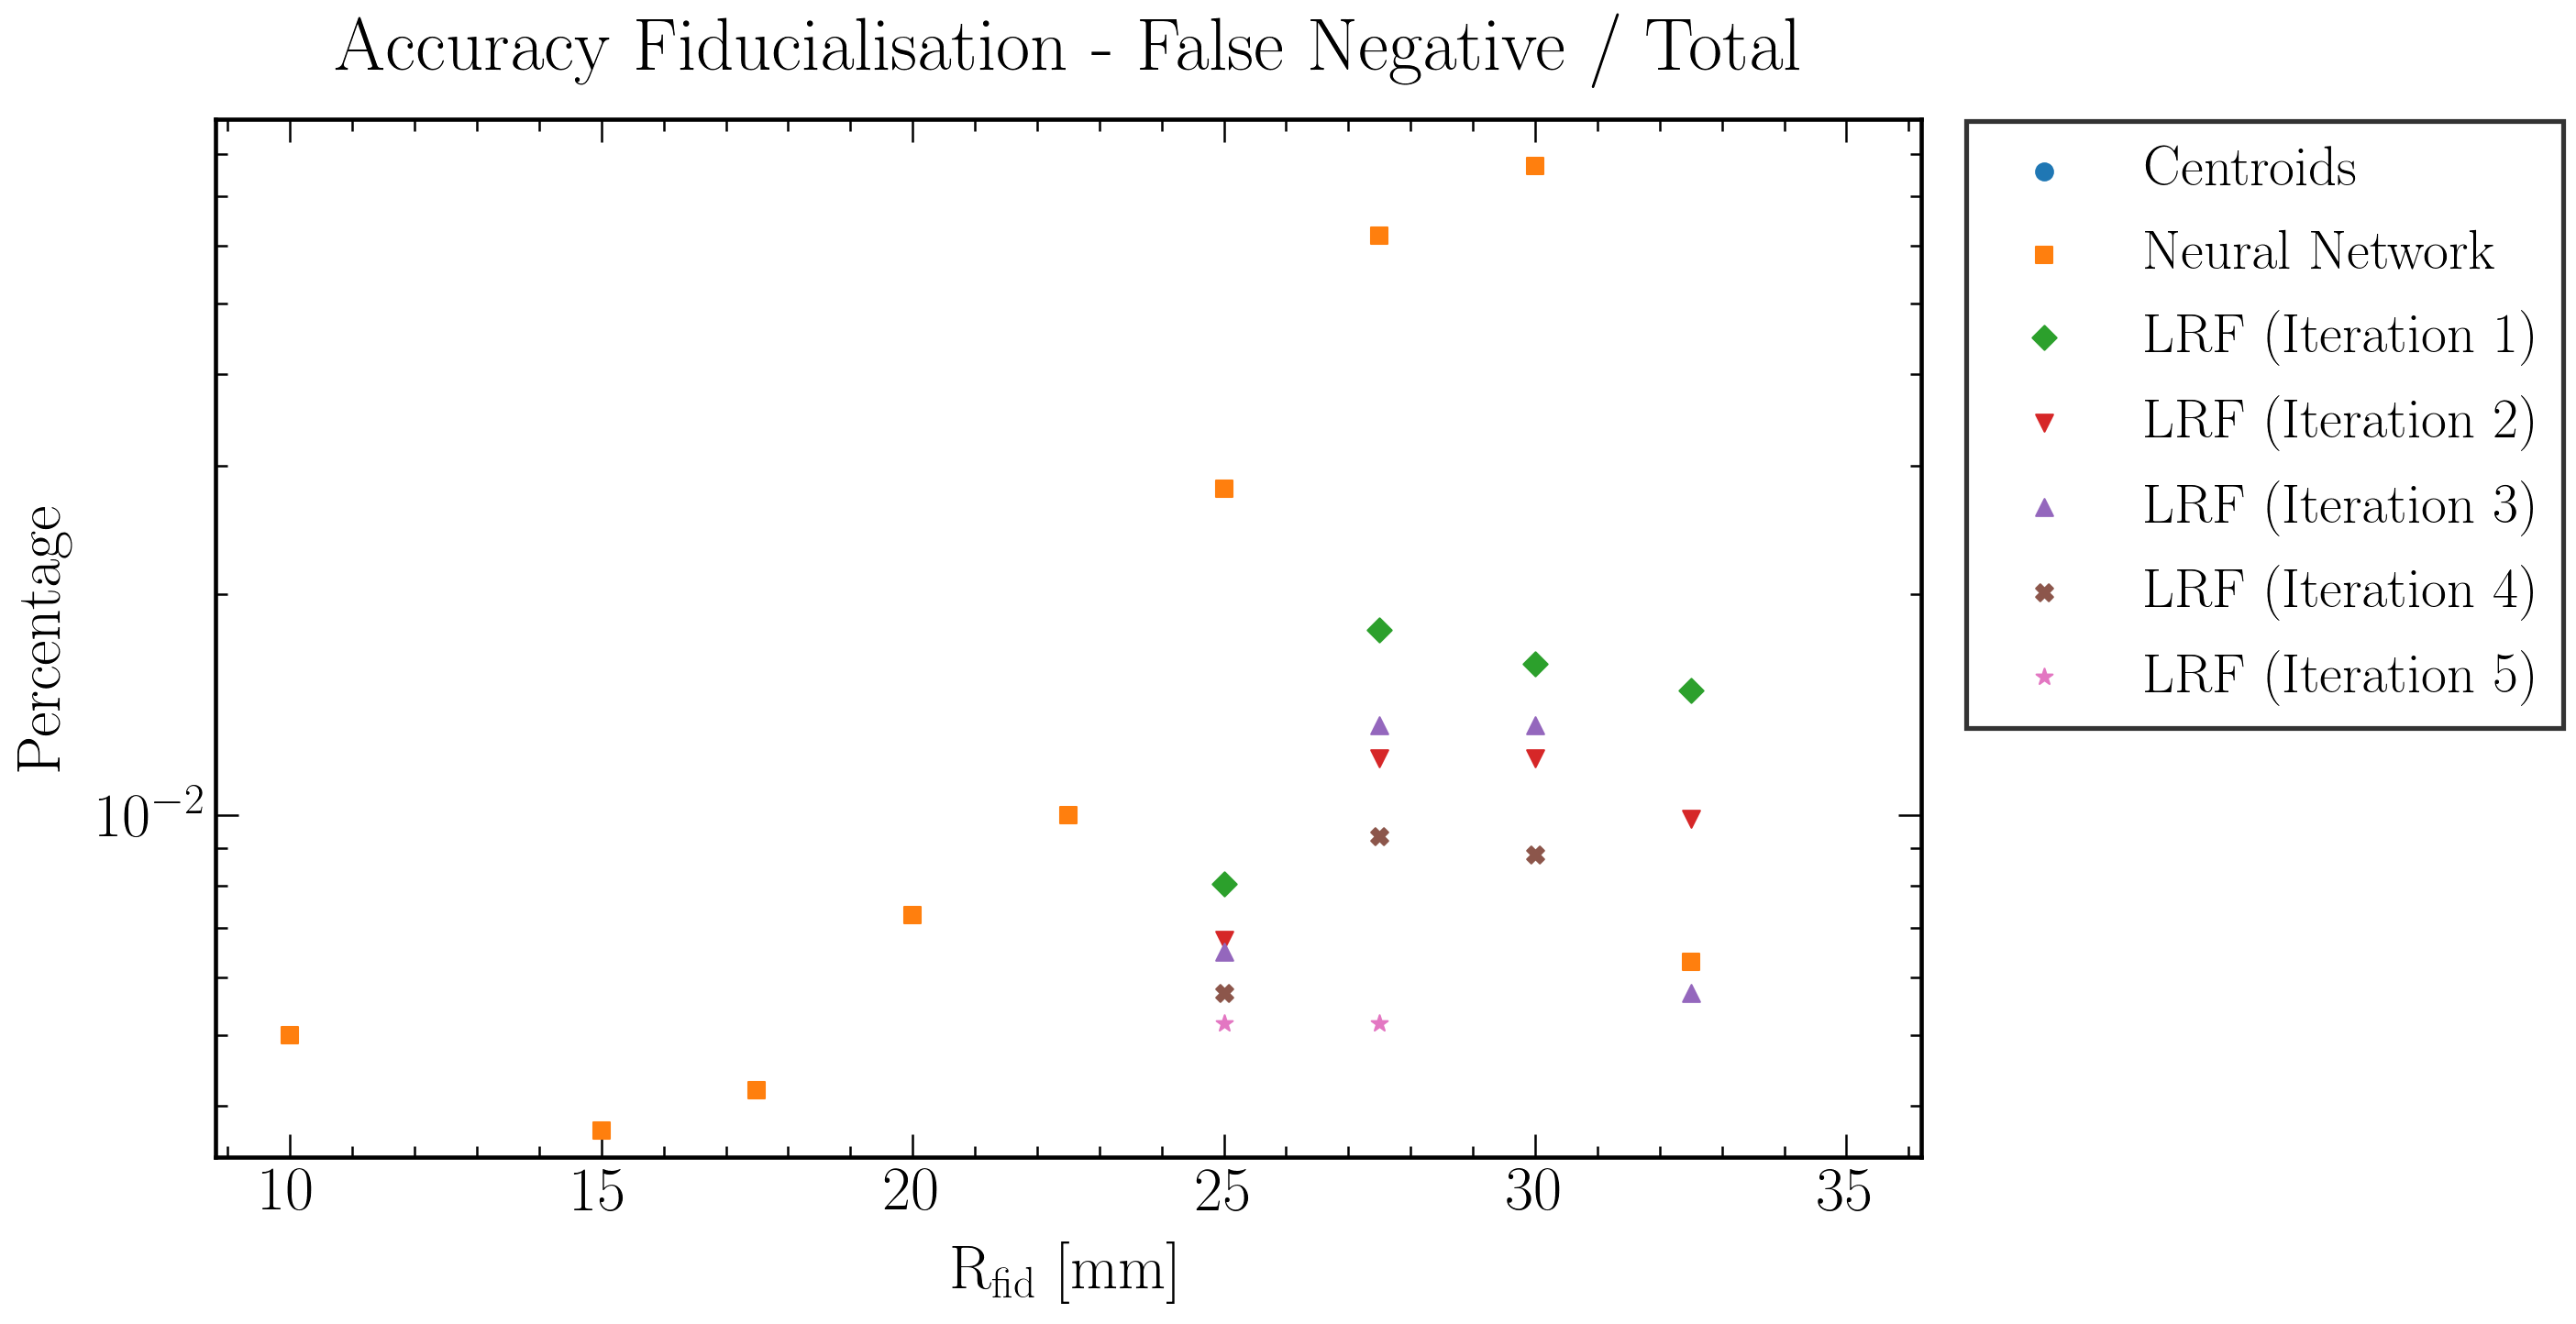

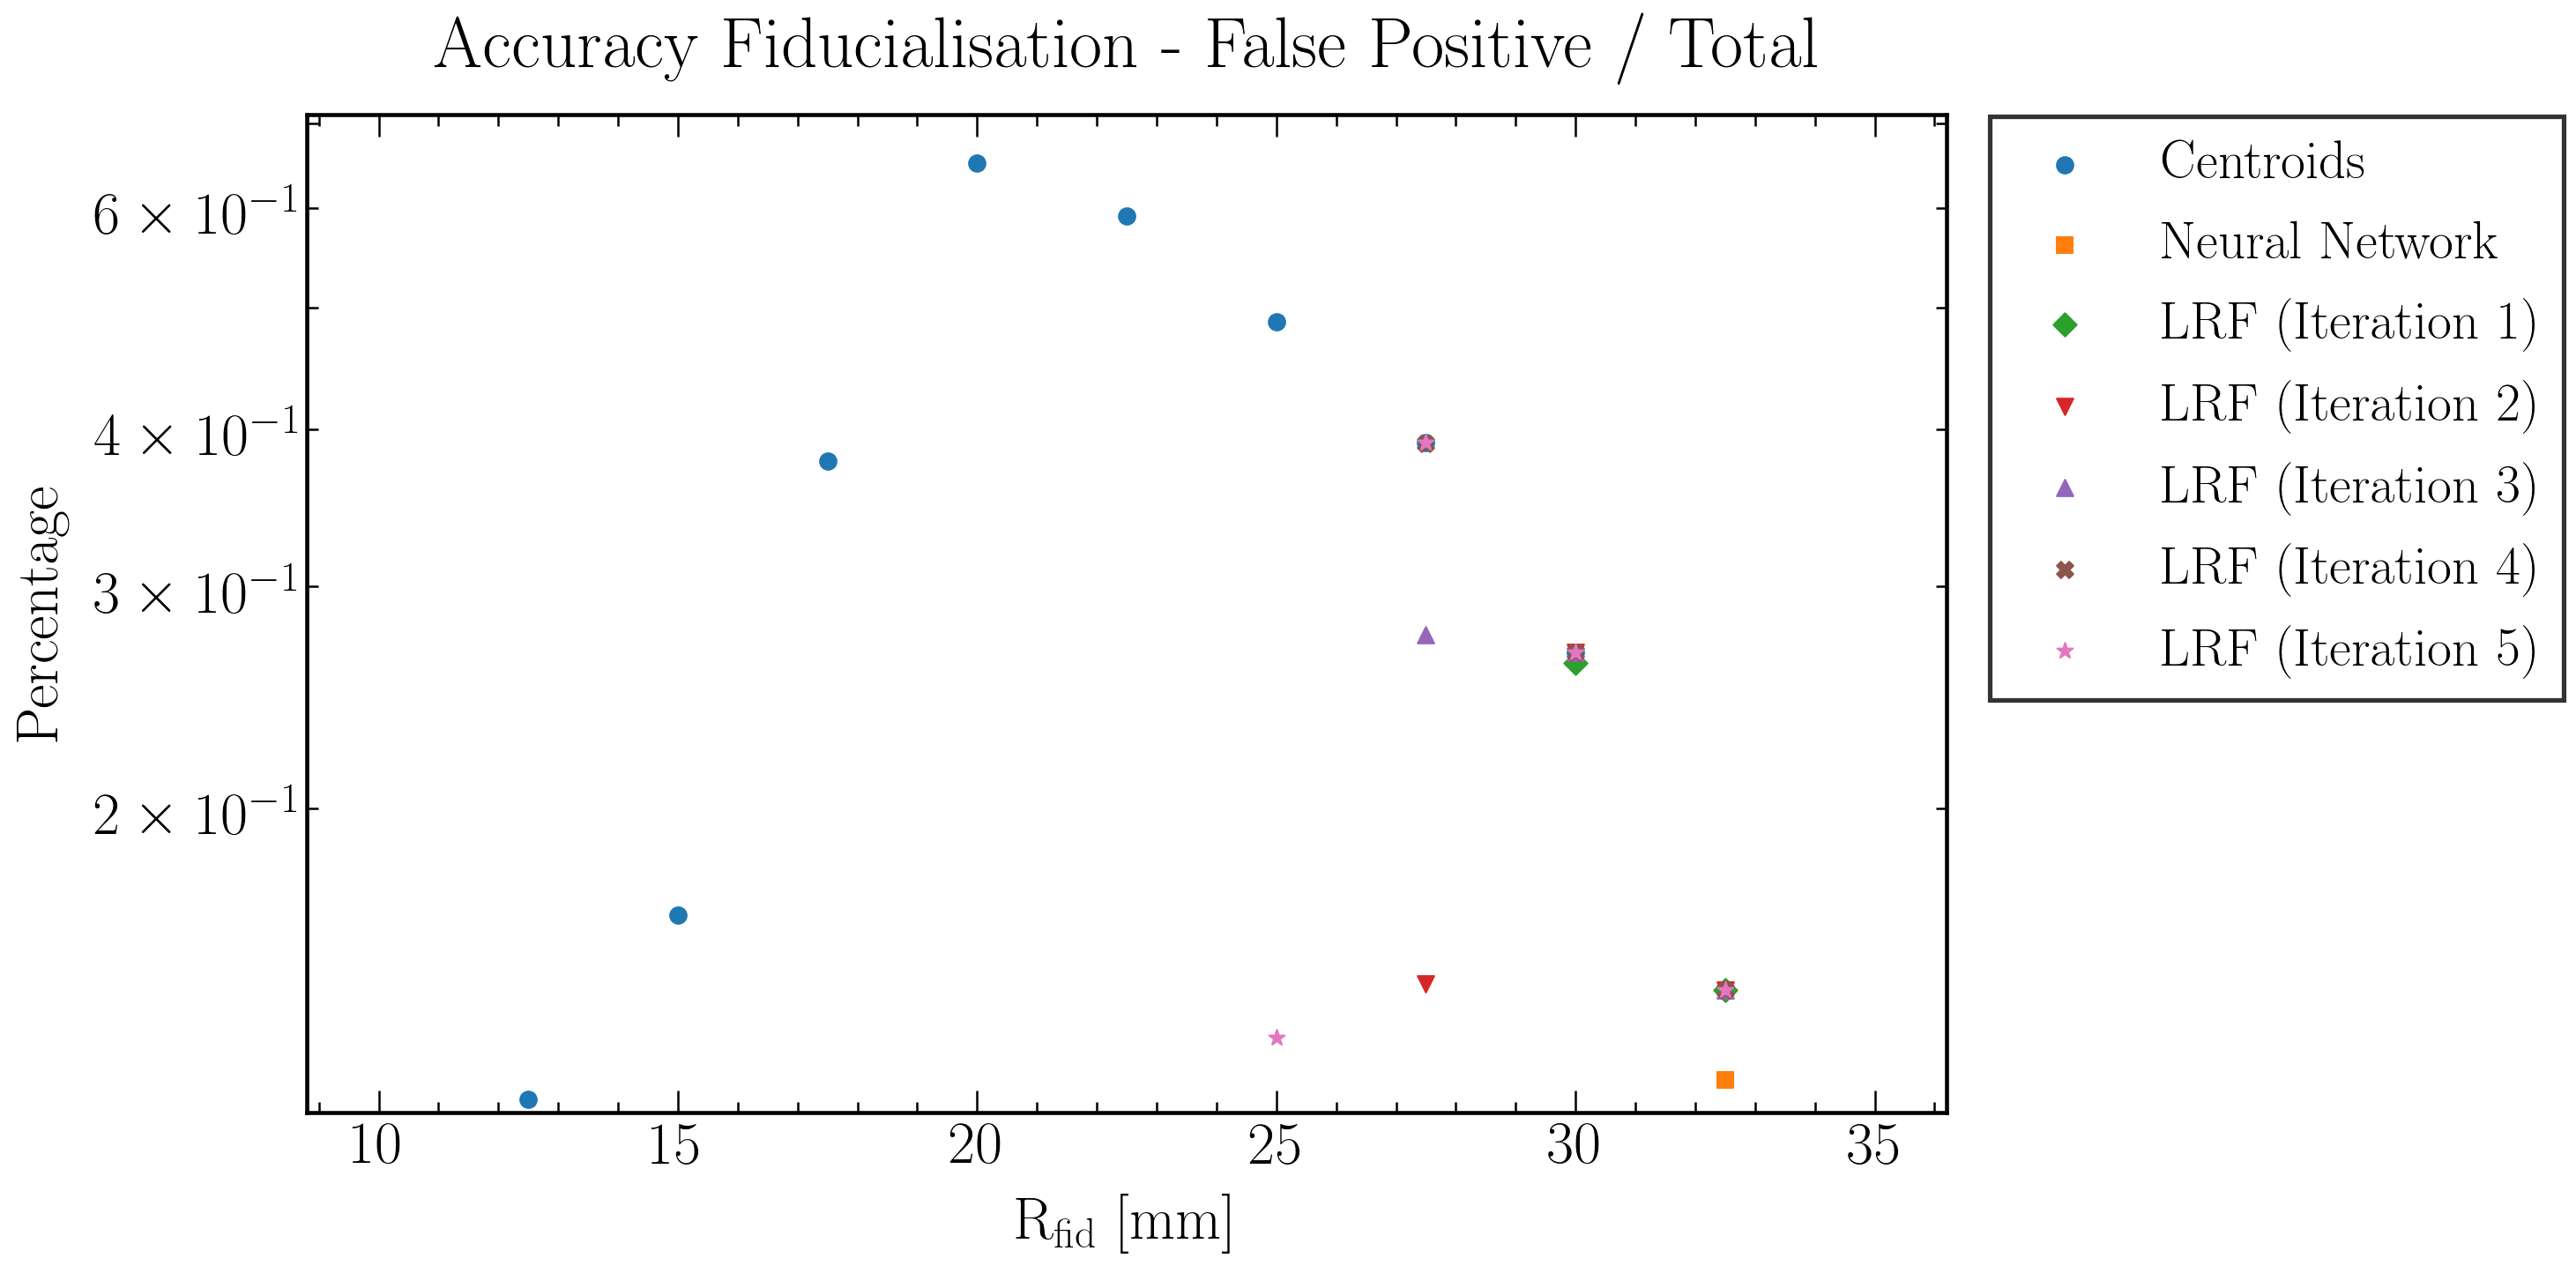

In [28]:
bool_bool_list = ['true_negative', 'true_positive', 'false_negative', 'false_positive']
bool_bool_string_list = ['True Negative / Total', 'True Positive / Total', 'False Negative / Total', 'False Positive / Total']

for i in range(len(bool_bool_list)):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Fiducialisation_Centroids['fid']
    y = df_Fiducialisation_Centroids[bool_bool_list[i]]/df_Fiducialisation_Centroids['total']
    plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

    x = df_Fiducialisation_NN['fid']
    y = df_Fiducialisation_NN[bool_bool_list[i]]/df_Fiducialisation_NN['total']
    plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

    x = df_Fiducialisation_LRF_iteration_1['fid']
    y = df_Fiducialisation_LRF_iteration_1[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_1['total']
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

    x = df_Fiducialisation_LRF_iteration_2['fid']
    y =df_Fiducialisation_LRF_iteration_2[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_2['total']
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

    x = df_Fiducialisation_LRF_iteration_3['fid']
    y = df_Fiducialisation_LRF_iteration_3[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_3['total']
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

    x = df_Fiducialisation_LRF_iteration_4['fid']
    y = df_Fiducialisation_LRF_iteration_4[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_4['total']
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

    x = df_Fiducialisation_LRF_iteration_5['fid']
    y = df_Fiducialisation_LRF_iteration_5[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_5['total']
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

    plt.ylabel('Percentage', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Accuracy Fiducialisation - '+bool_bool_string_list[i], fontsize = title_size, pad = title_pad)

    plt.xlim(8.8, 36.2)
    plt.yscale('log')
    
    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_All_Goodness_fiducialisation_"+bool_bool_list[i]+"_of_total_log.png", bbox_inches = "tight")
    plt.show()

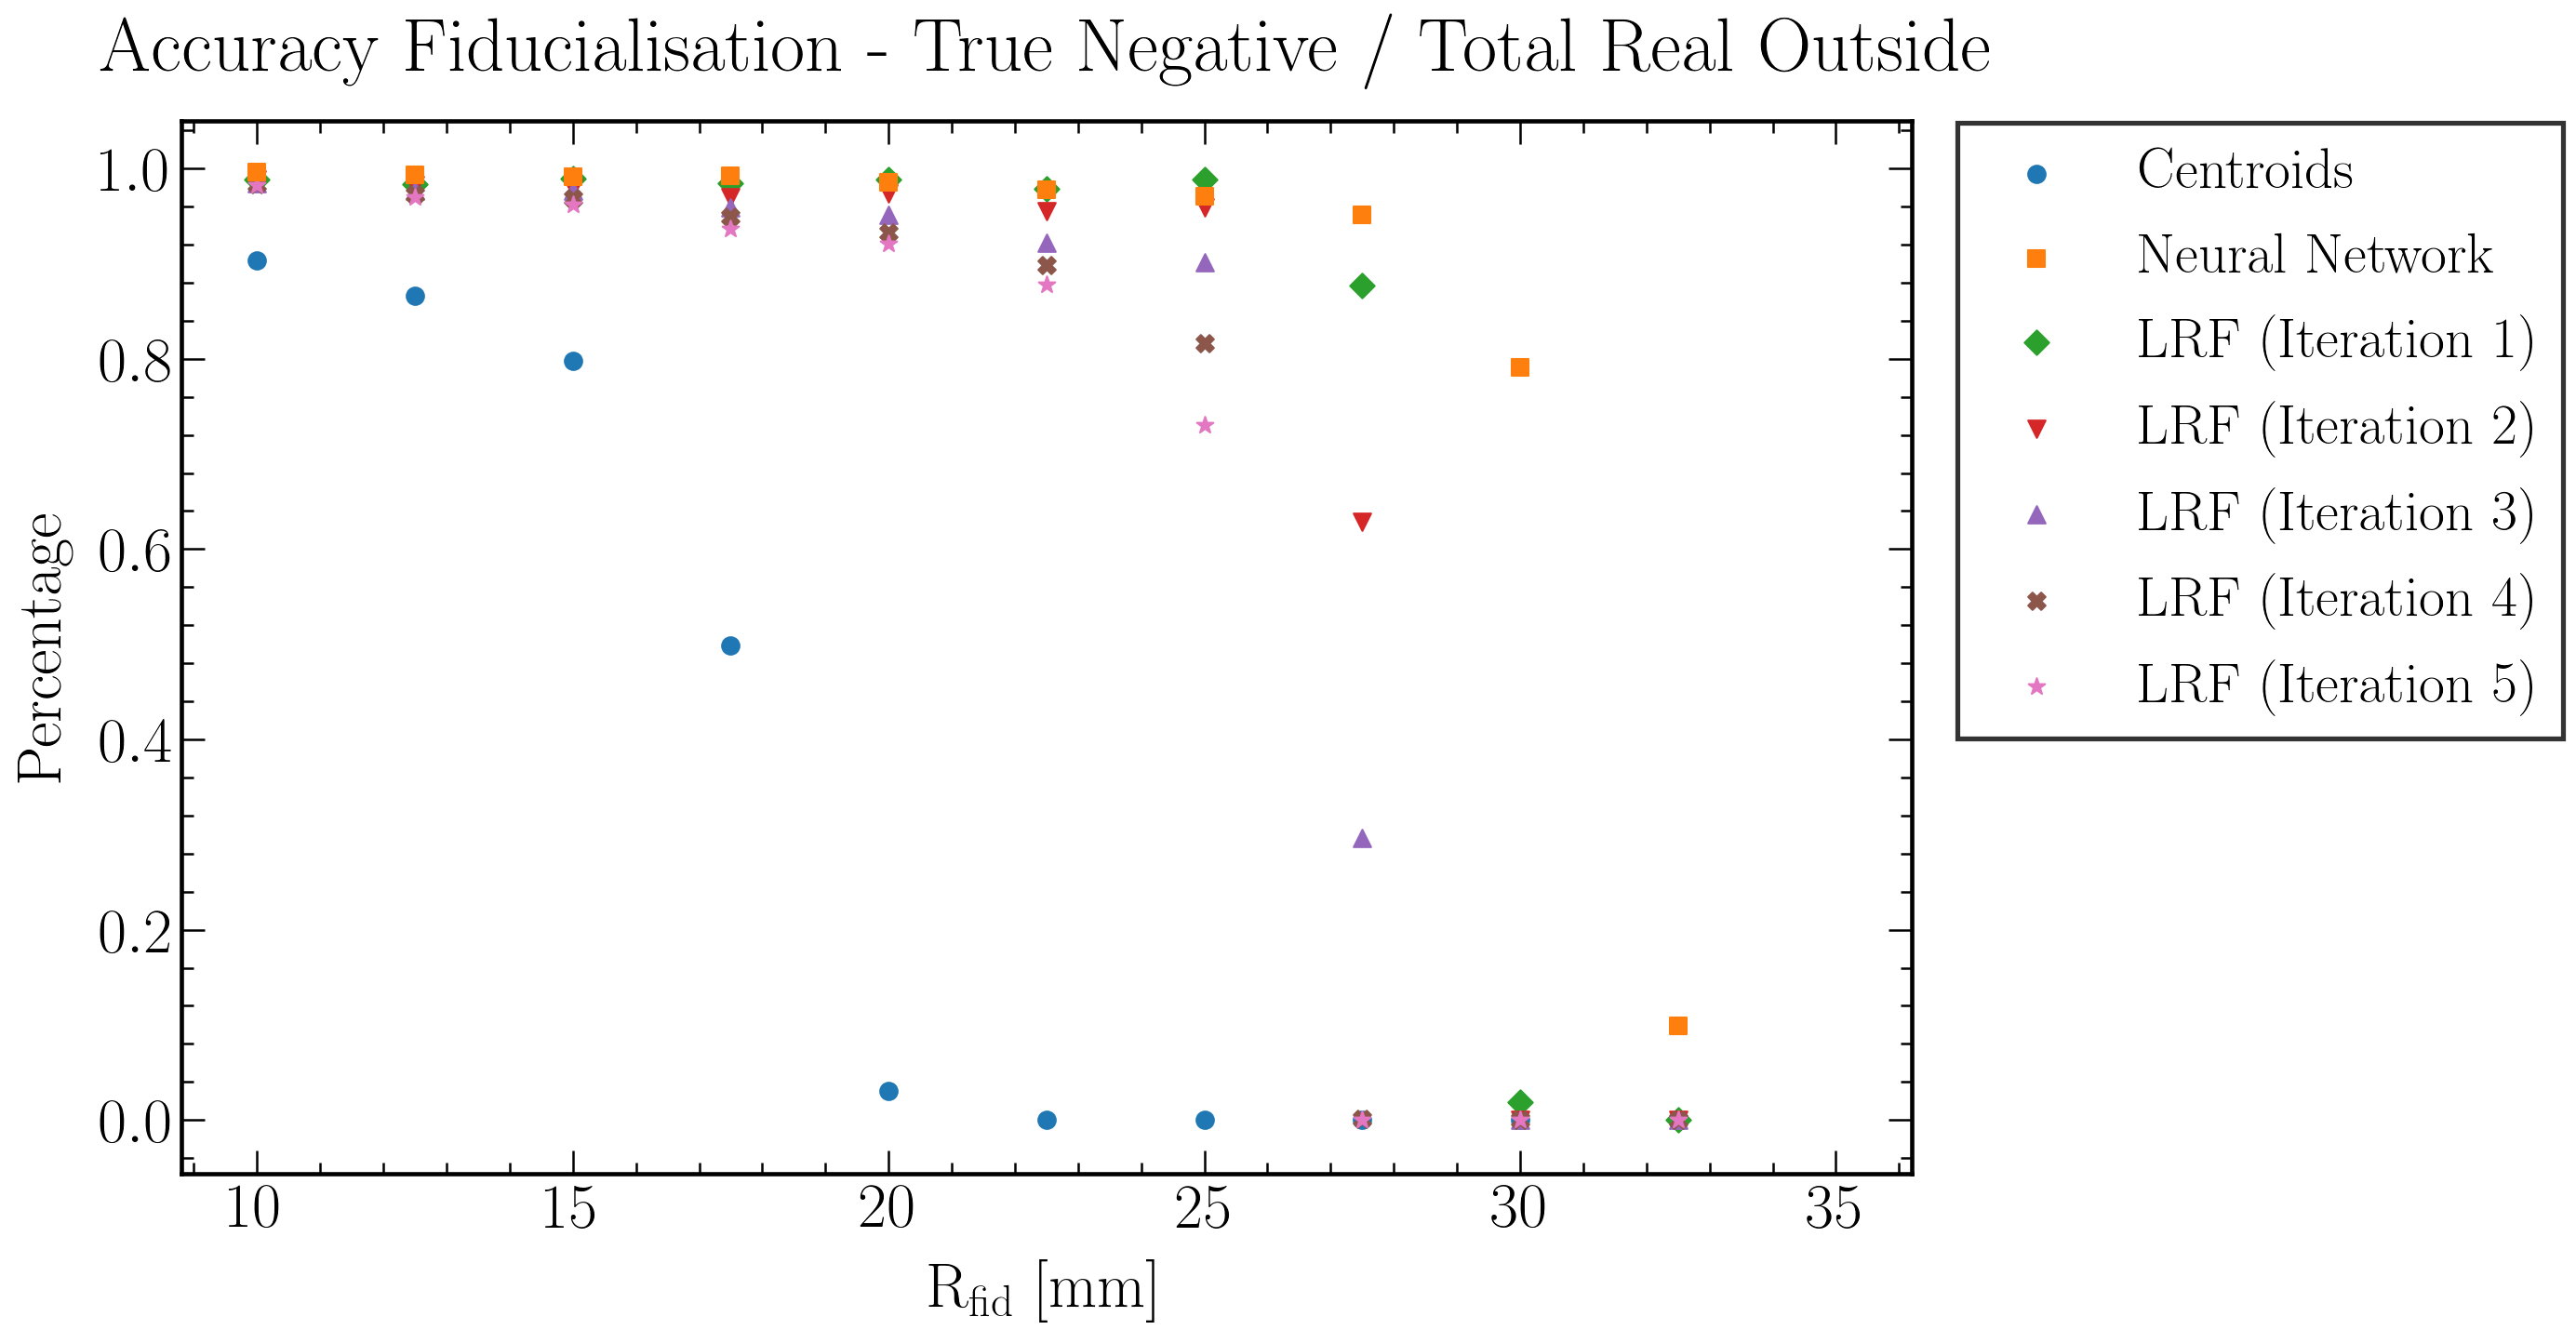

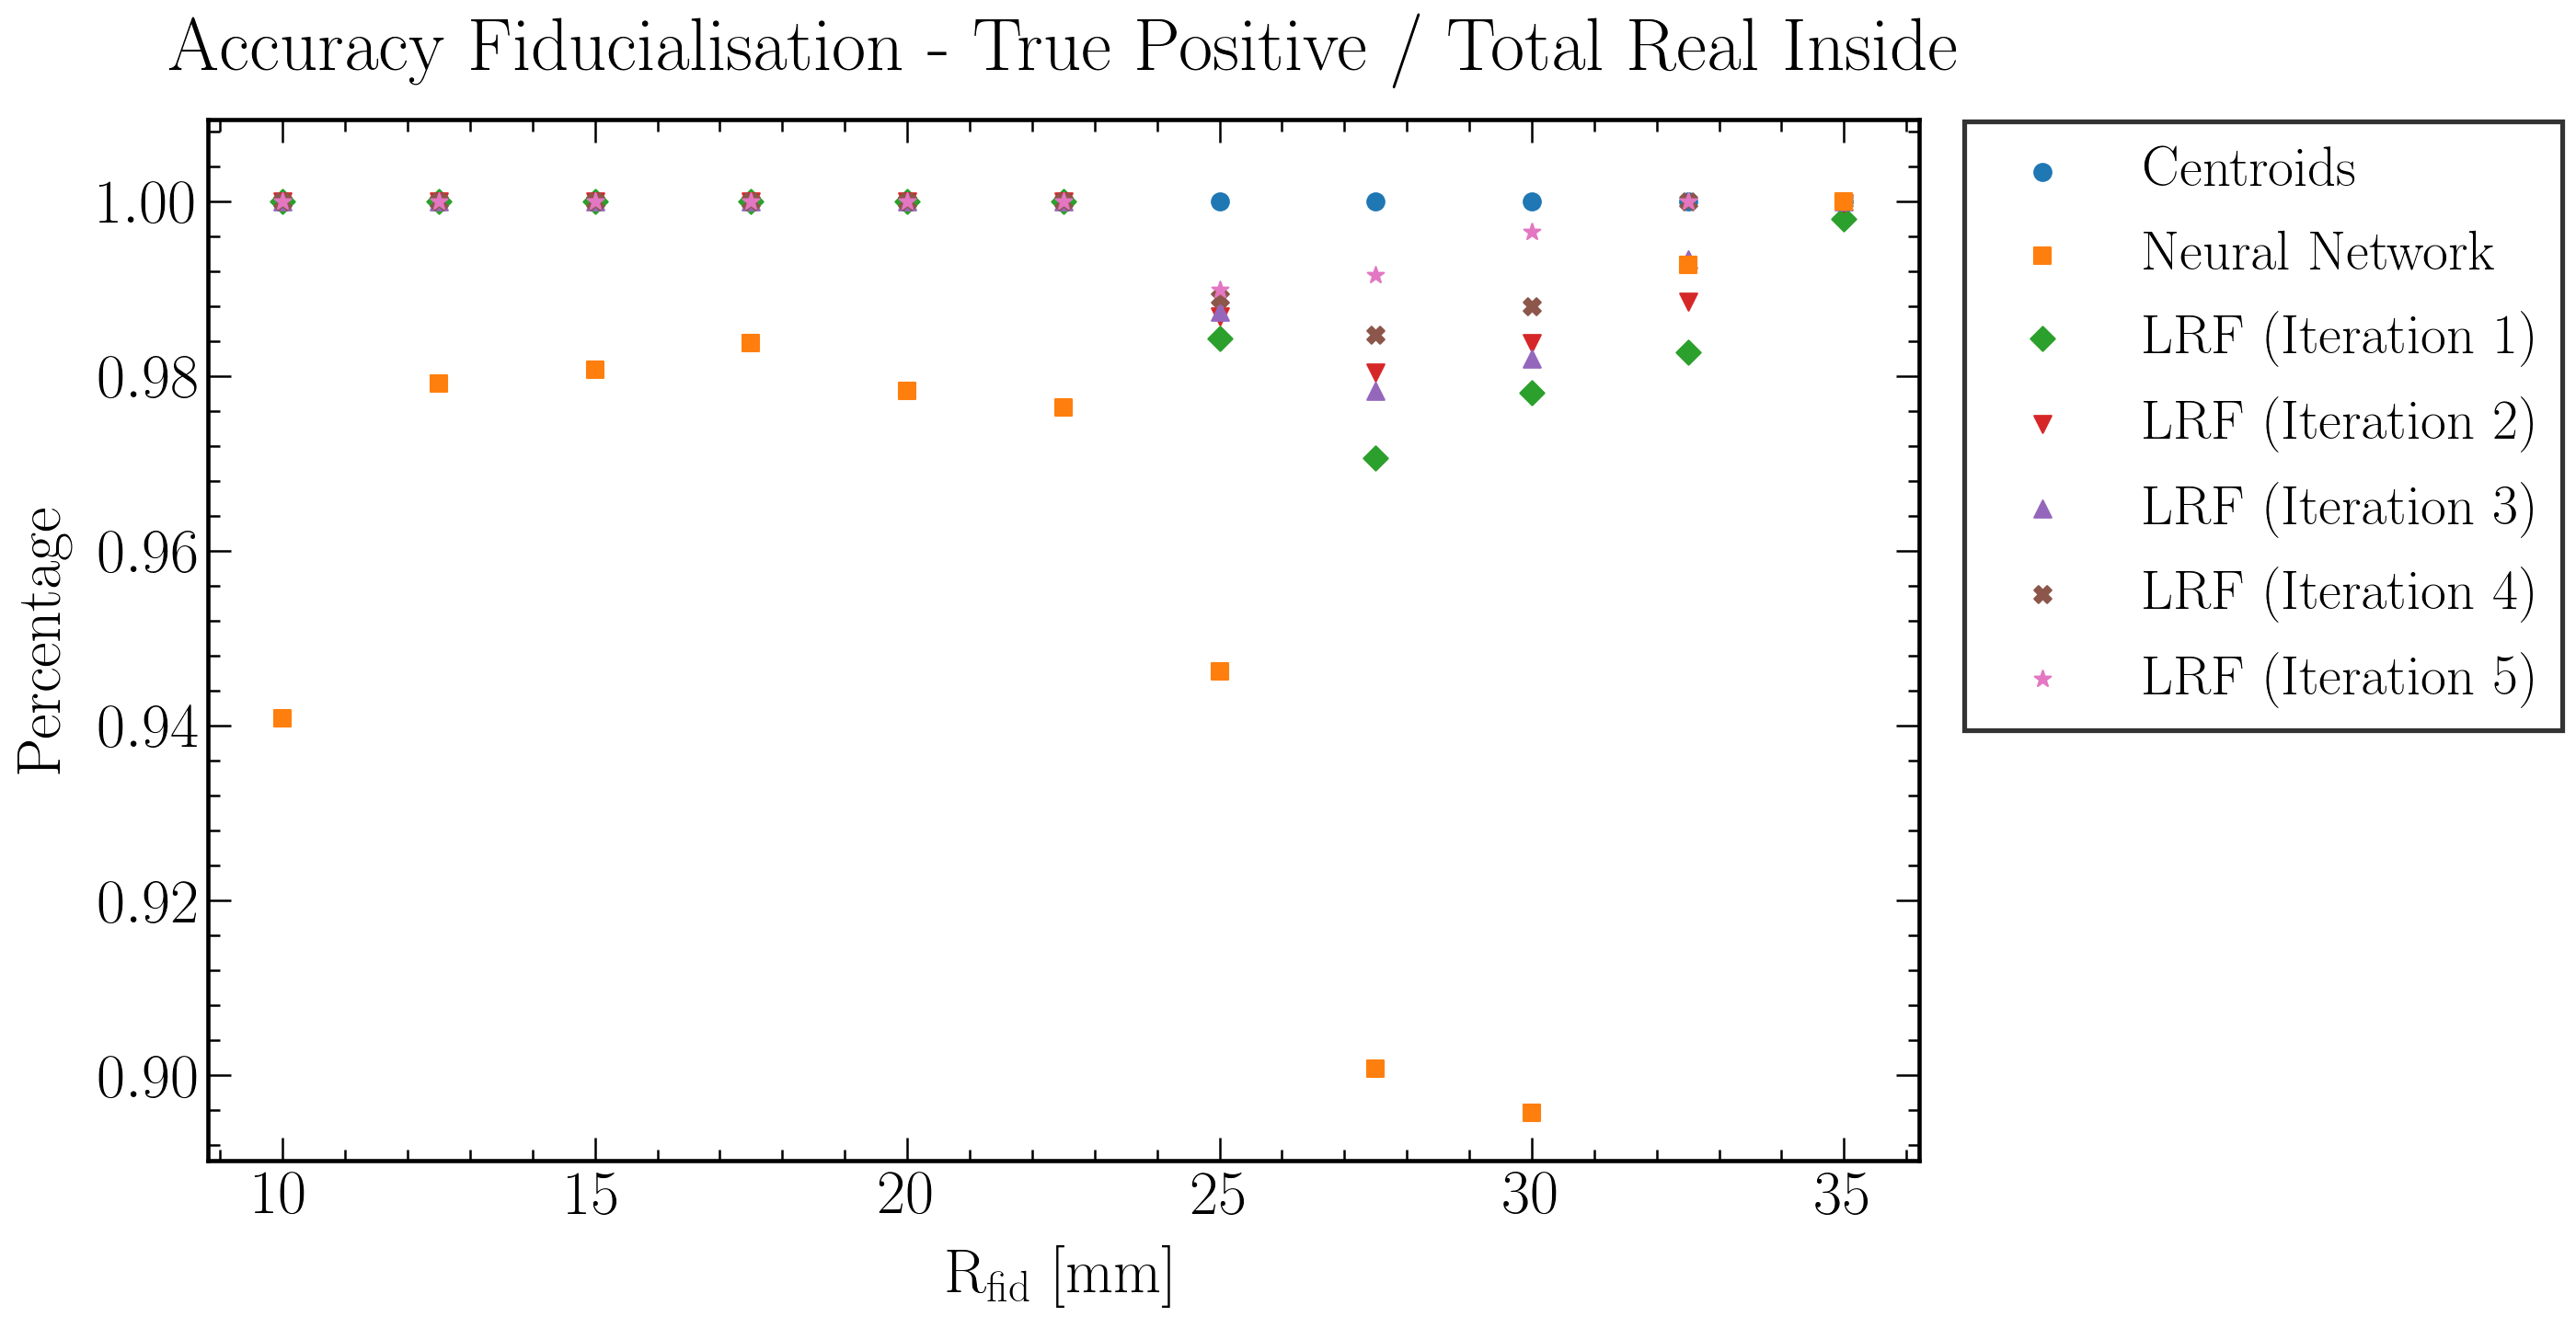

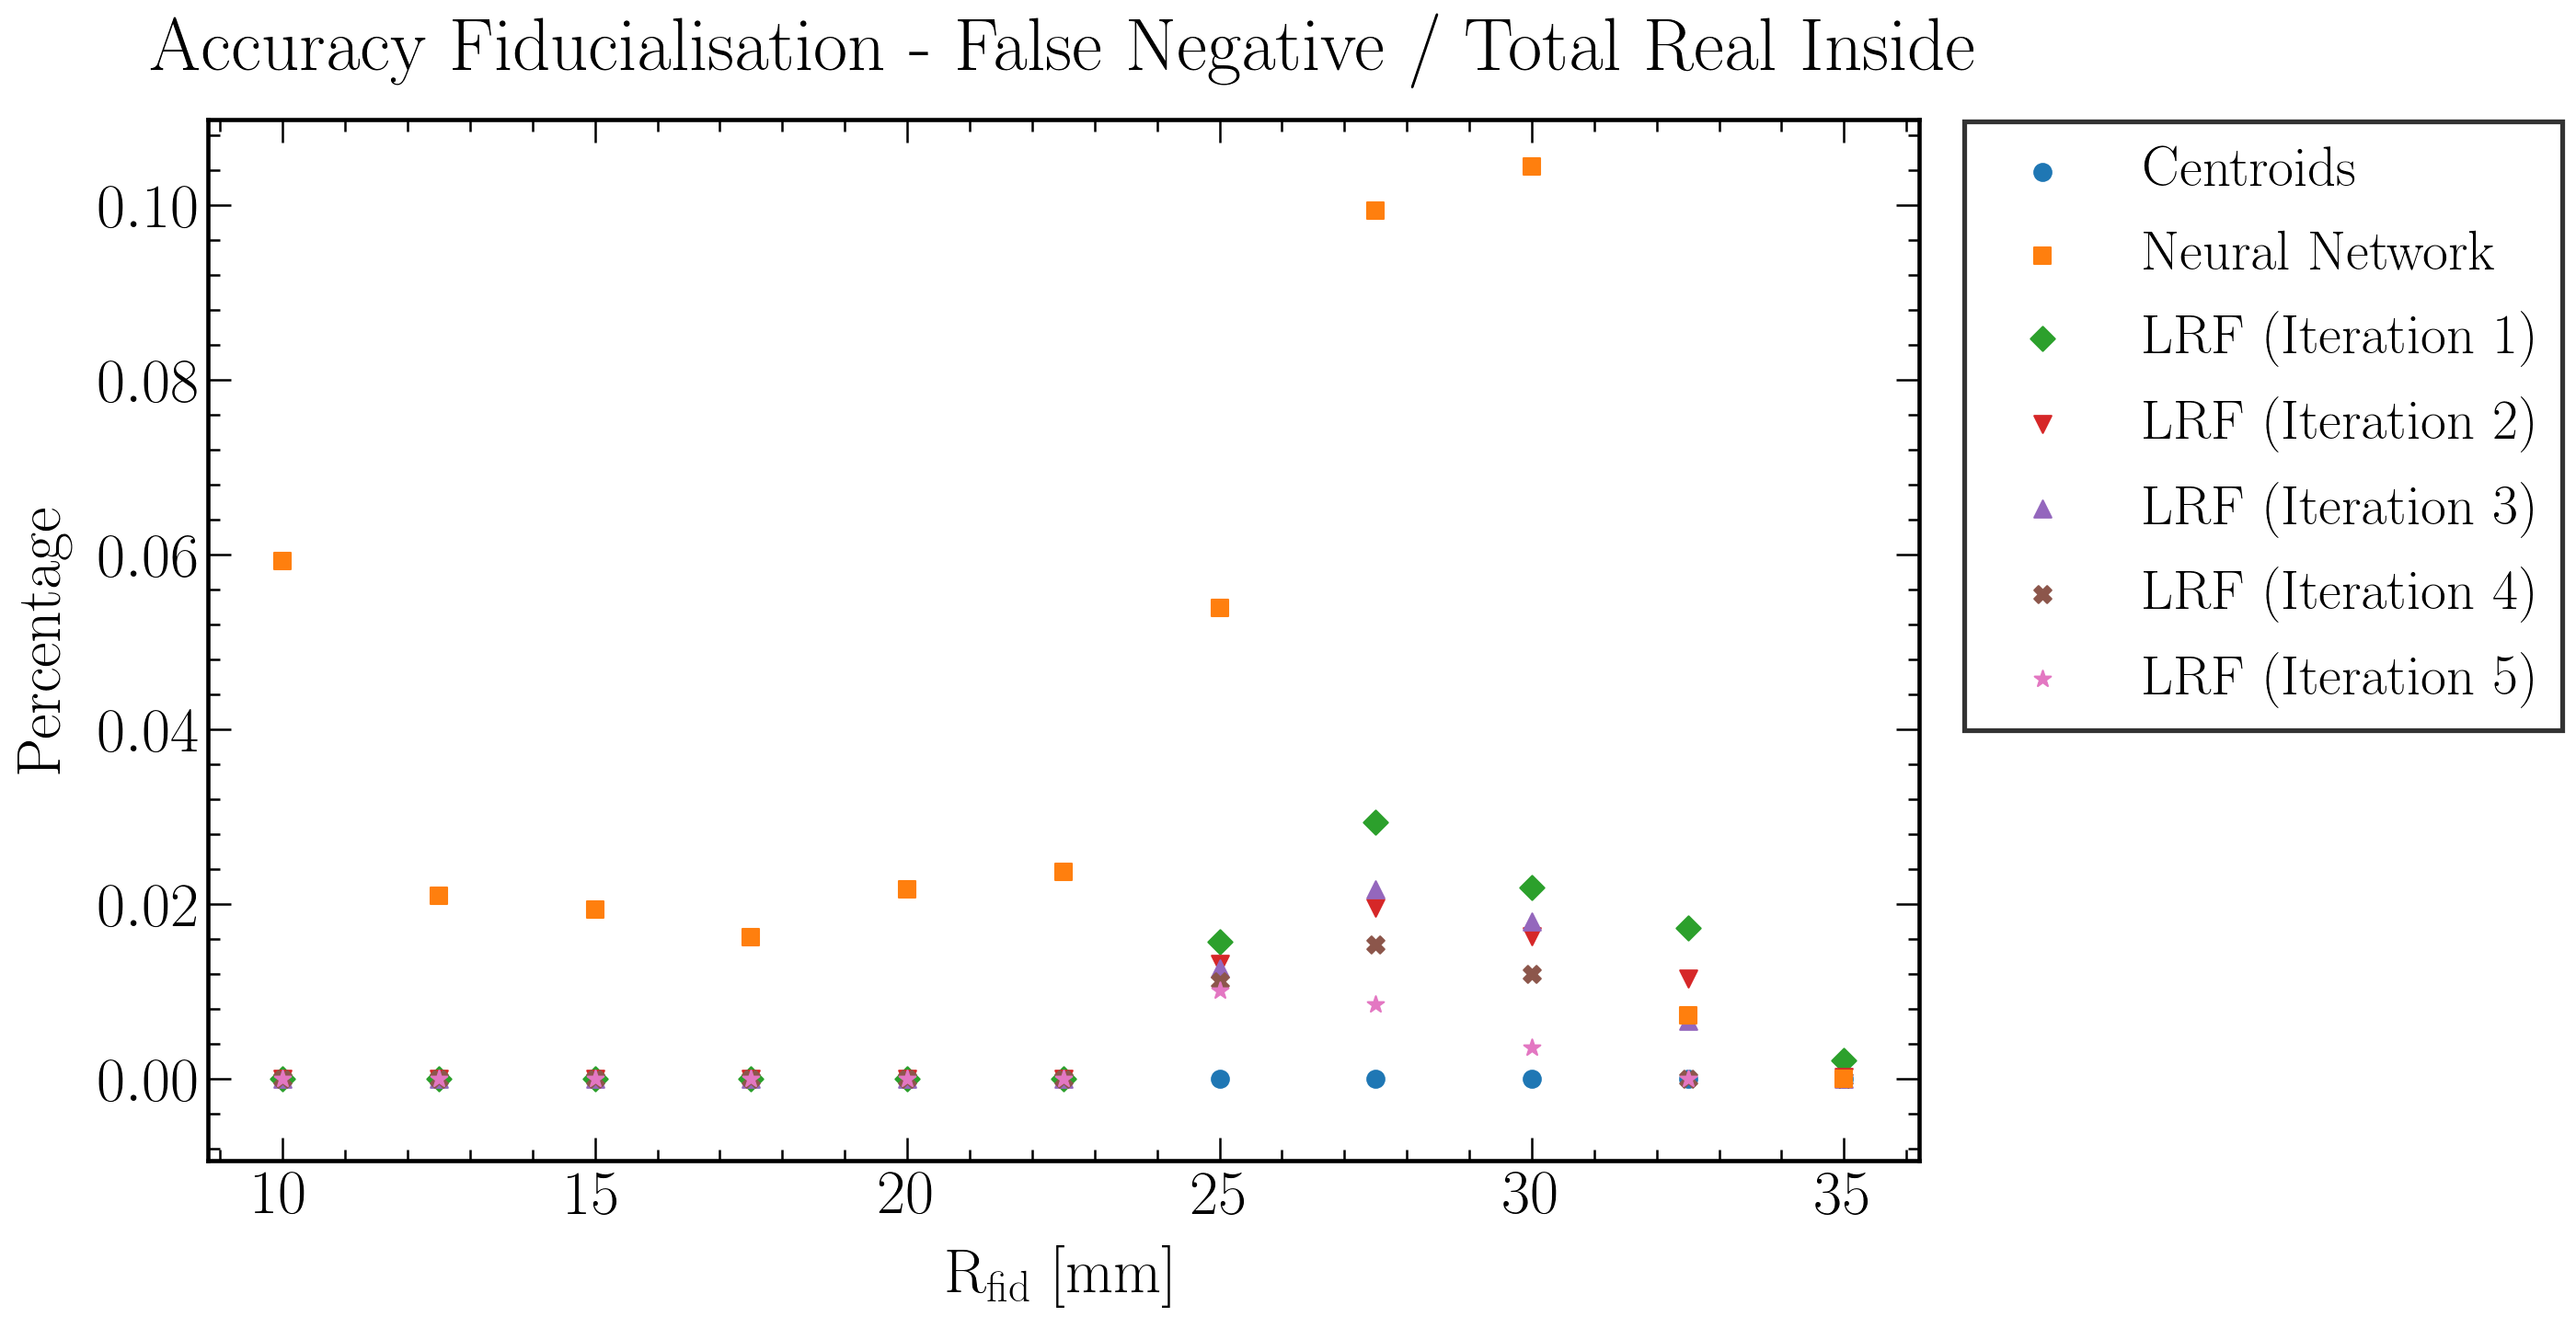

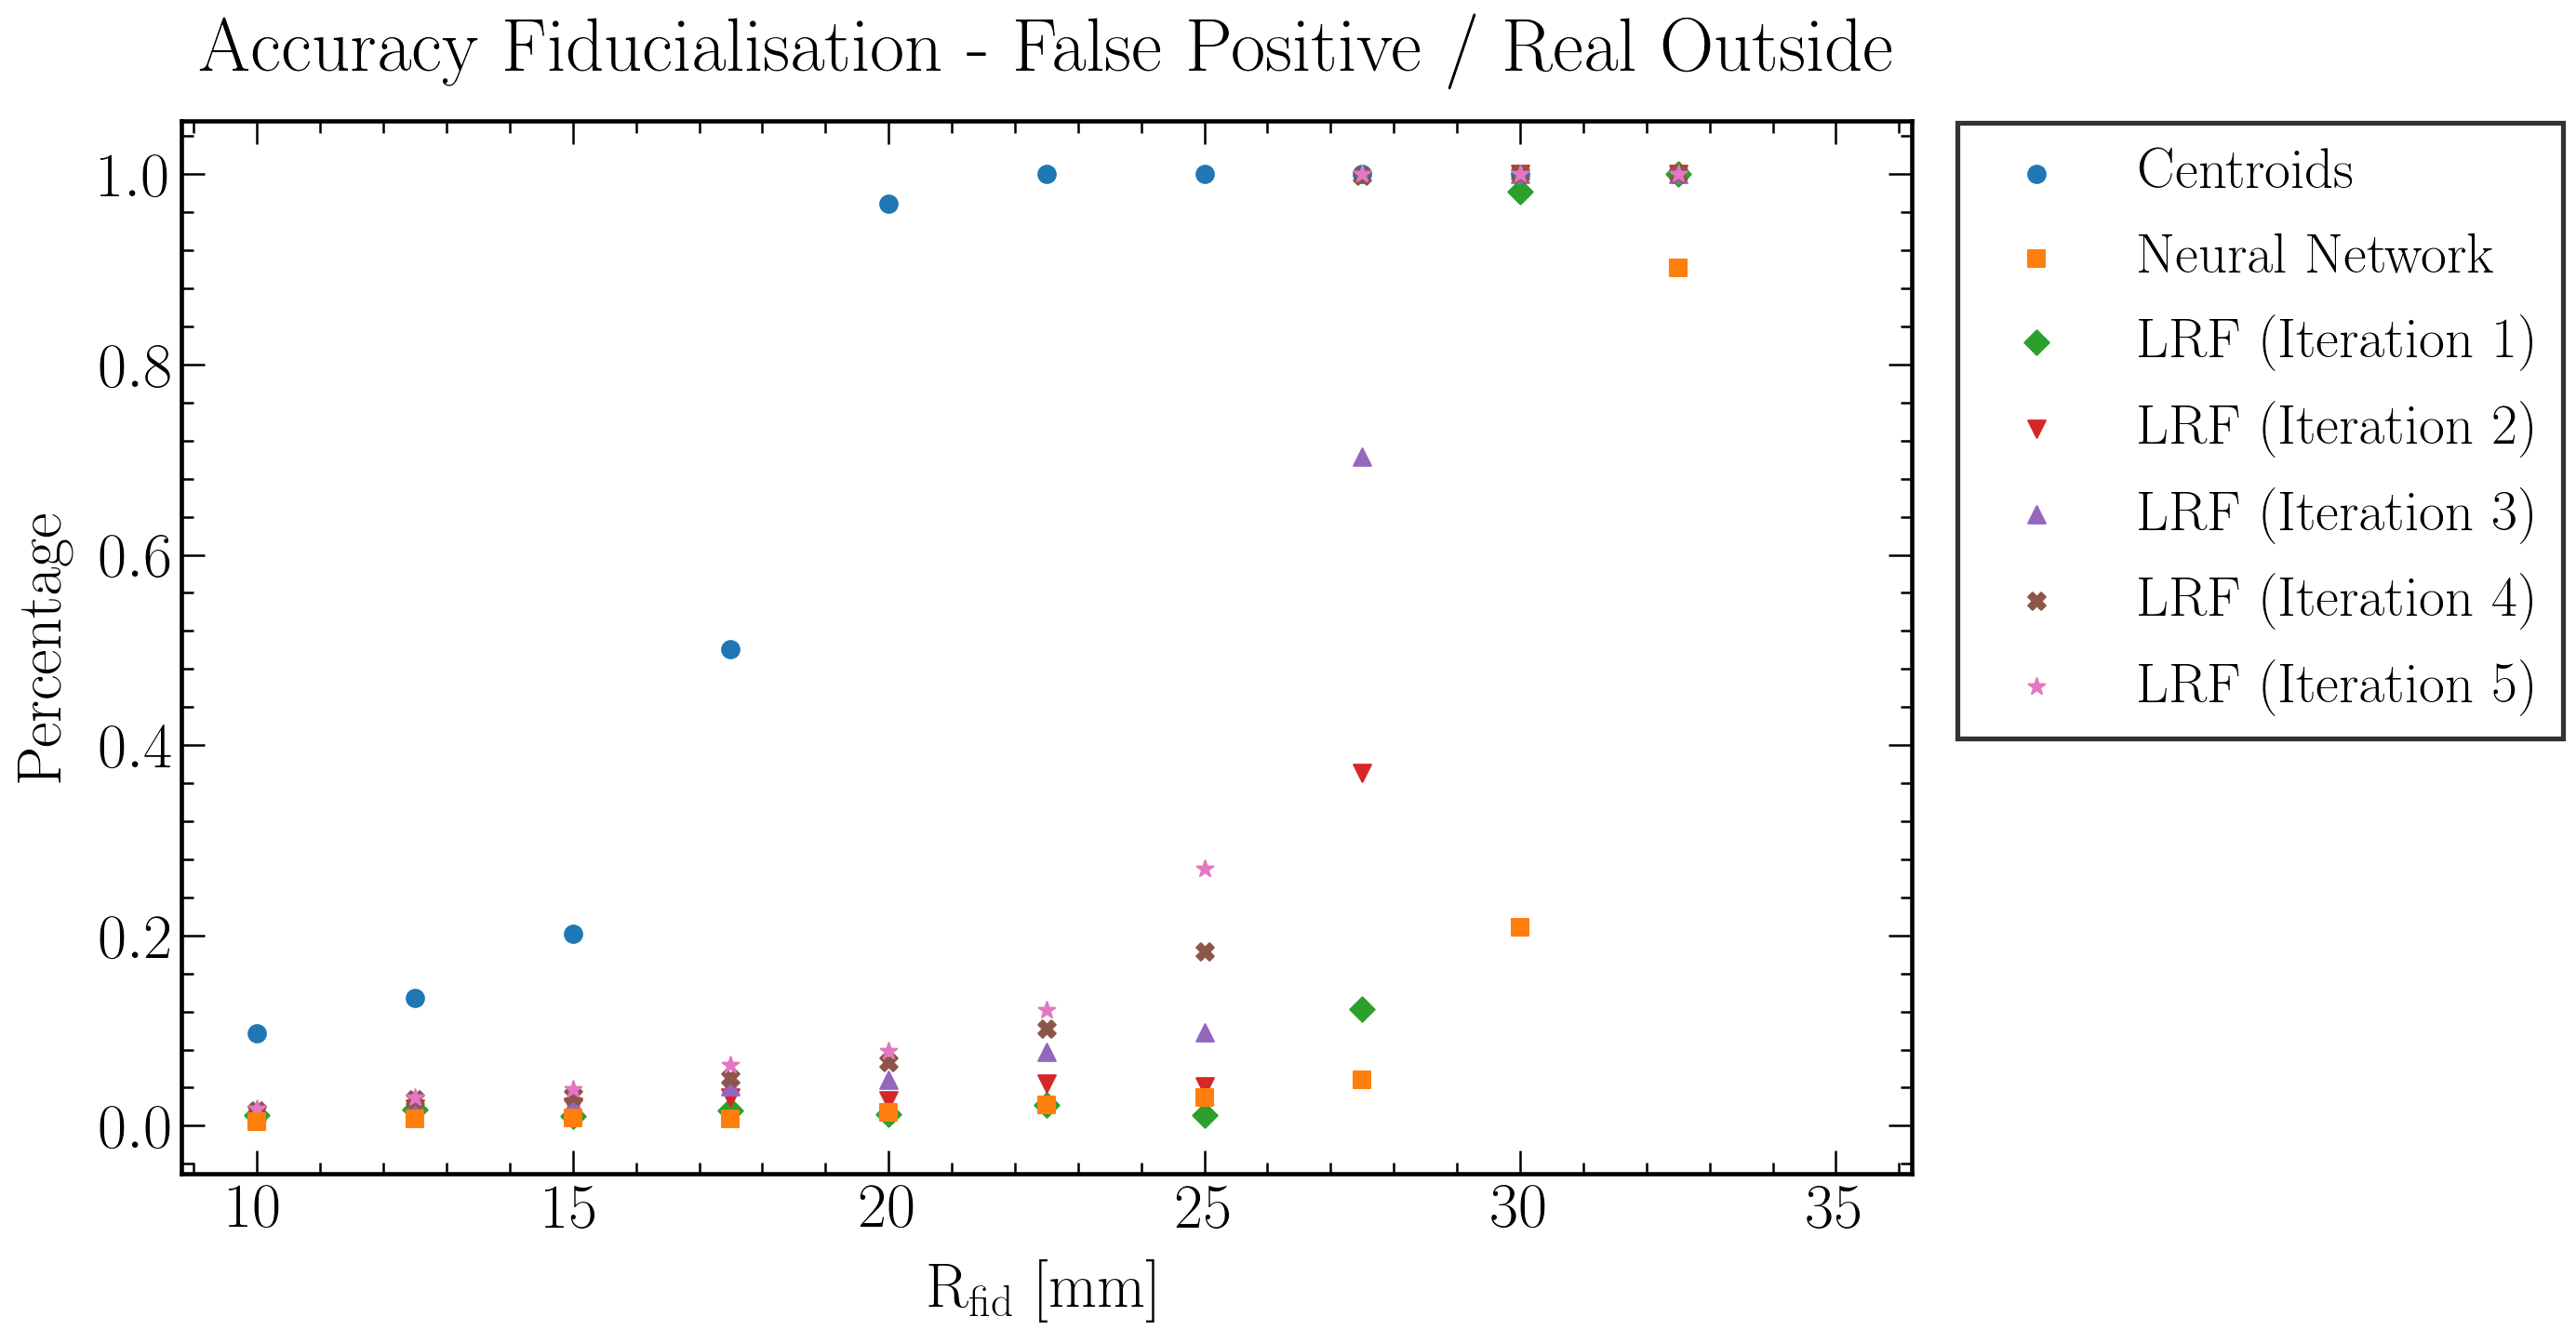

In [29]:
bool_bool_list = ['true_negative', 'true_positive', 'false_negative', 'false_positive']
bool_bool_string_list = ['True Negative / Total Real Outside', 'True Positive / Total Real Inside', 'False Negative / Total Real Inside', 'False Positive / Real Outside']
norm_list = ['true_outside', 'true_inside', 'true_inside', 'true_outside']

for i in range(len(bool_bool_list)):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Fiducialisation_Centroids['fid']
    y = df_Fiducialisation_Centroids[bool_bool_list[i]]/df_Fiducialisation_Centroids[norm_list[i]]
    plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

    x = df_Fiducialisation_NN['fid']
    y = df_Fiducialisation_NN[bool_bool_list[i]]/df_Fiducialisation_NN[norm_list[i]]
    plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

    x = df_Fiducialisation_LRF_iteration_1['fid']
    y = df_Fiducialisation_LRF_iteration_1[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_1[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

    x = df_Fiducialisation_LRF_iteration_2['fid']
    y =df_Fiducialisation_LRF_iteration_2[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_2[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

    x = df_Fiducialisation_LRF_iteration_3['fid']
    y = df_Fiducialisation_LRF_iteration_3[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_3[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

    x = df_Fiducialisation_LRF_iteration_4['fid']
    y = df_Fiducialisation_LRF_iteration_4[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_4[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

    x = df_Fiducialisation_LRF_iteration_5['fid']
    y = df_Fiducialisation_LRF_iteration_5[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_5[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

    plt.ylabel('Percentage', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Accuracy Fiducialisation - '+bool_bool_string_list[i], fontsize = title_size, pad = title_pad)

    plt.xlim(8.8, 36.2)
    
    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_All_Goodness_fiducialisation_"+bool_bool_list[i]+"_normed.png", bbox_inches = "tight")
    plt.show()

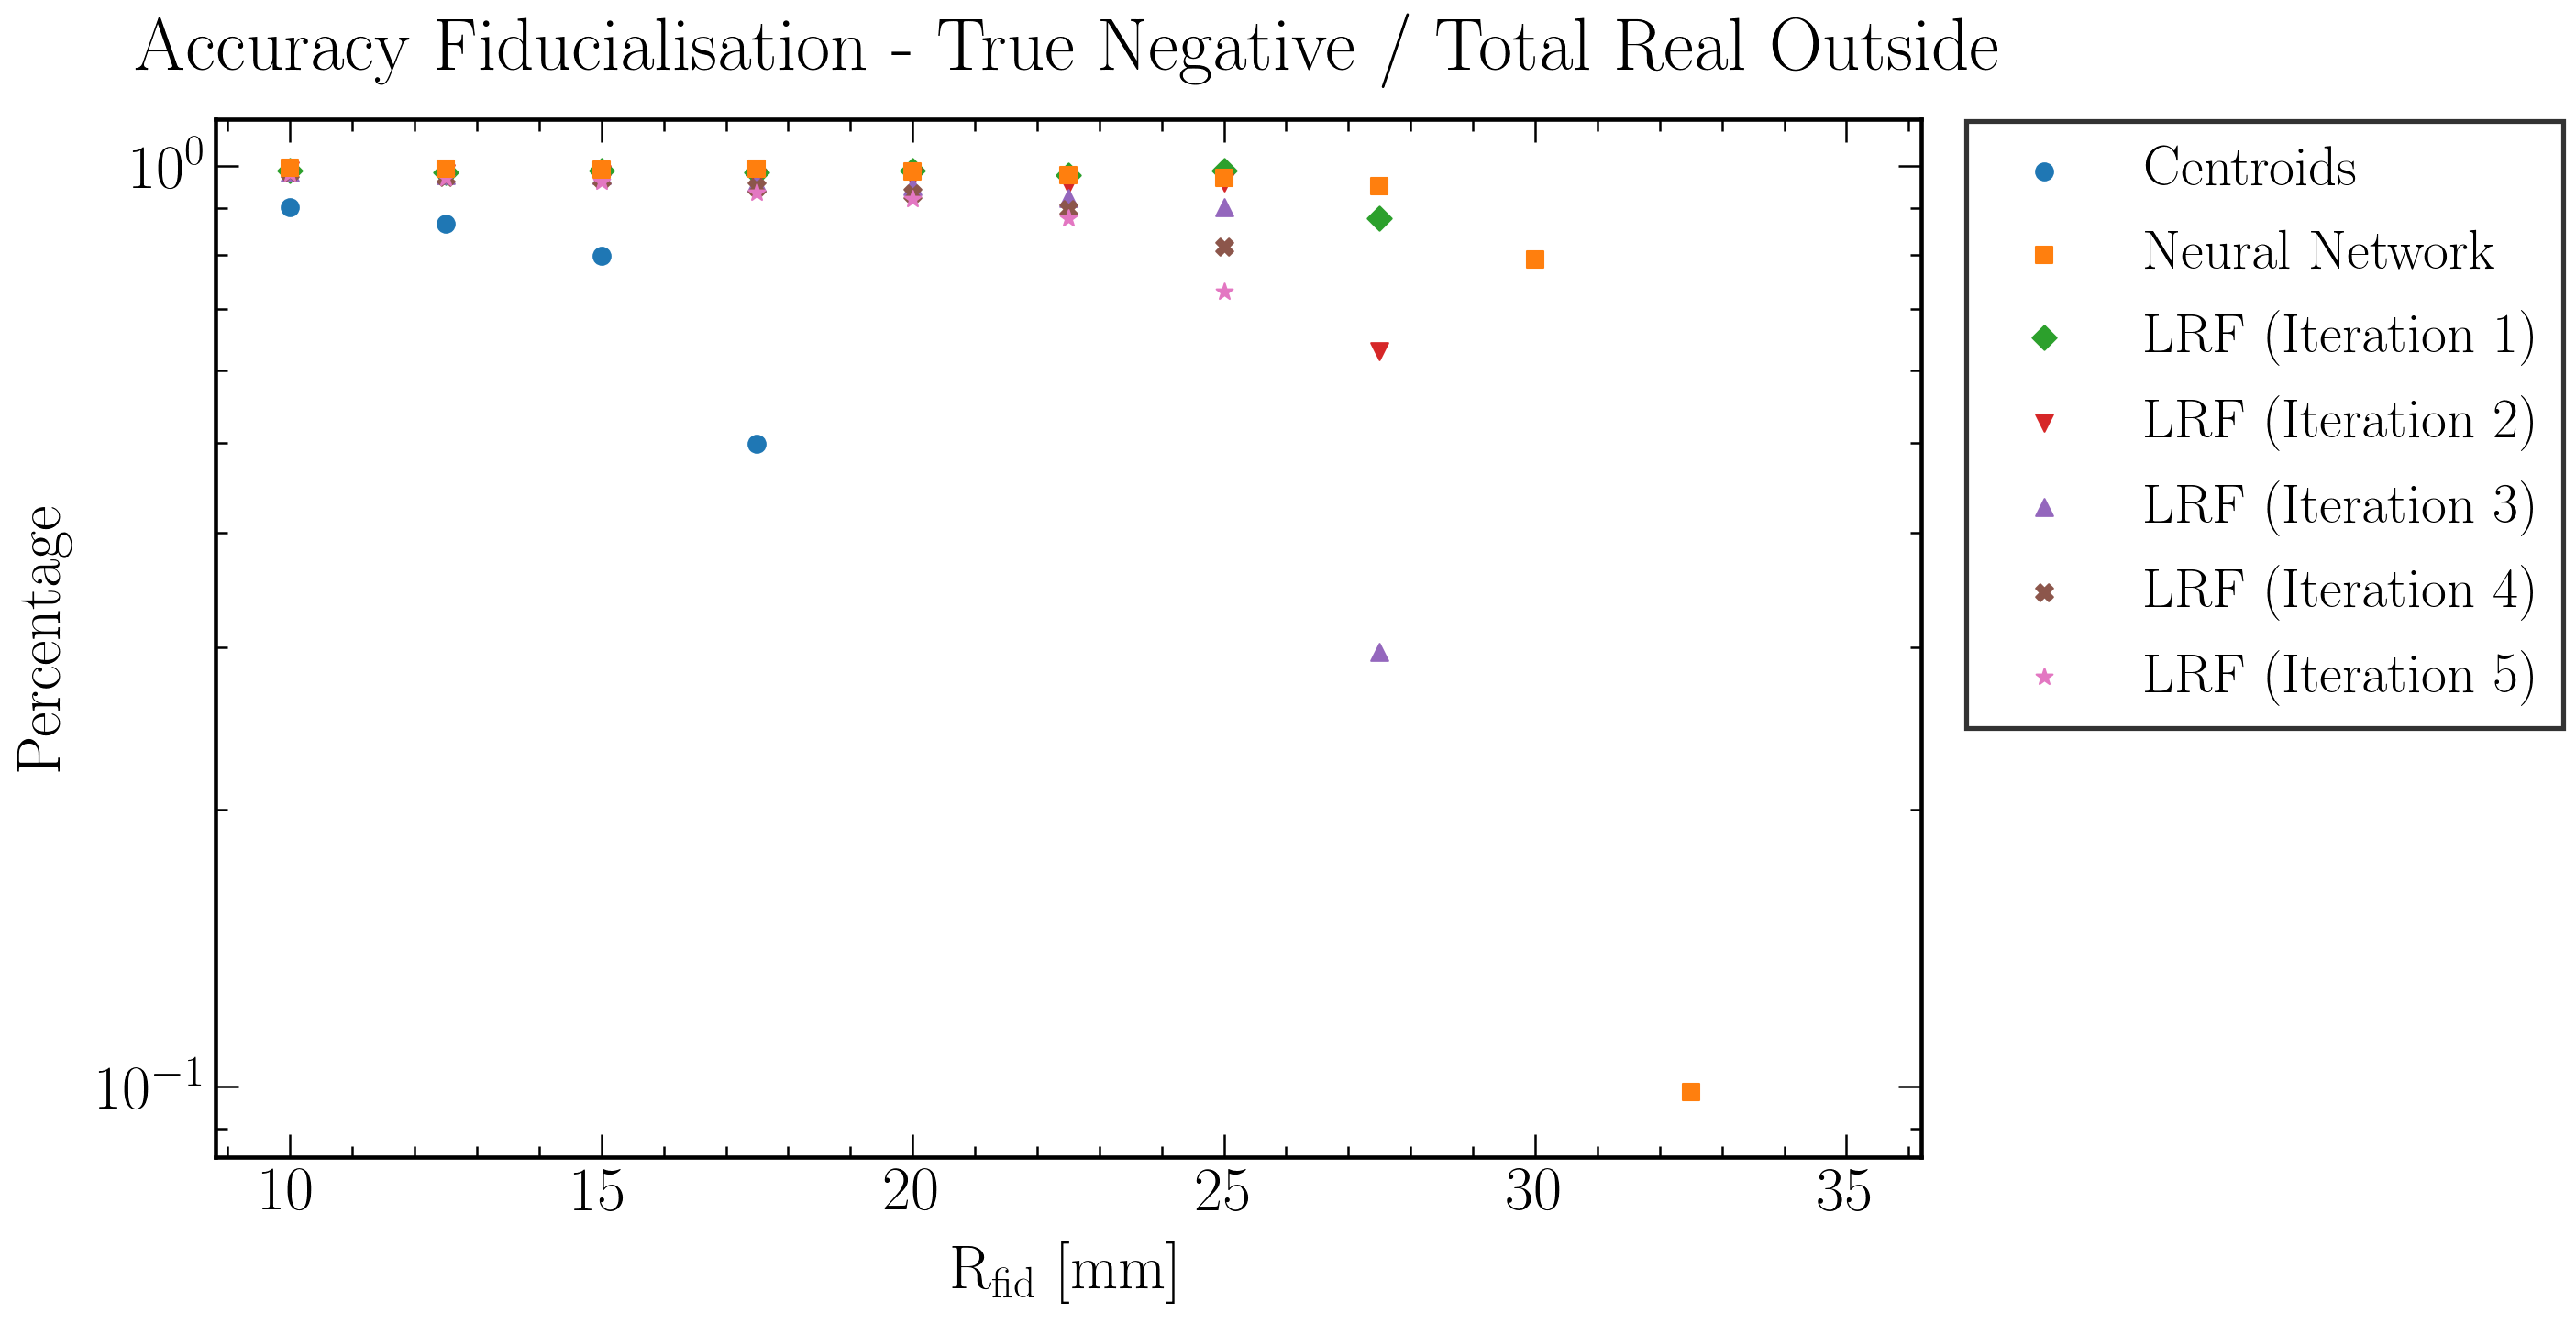

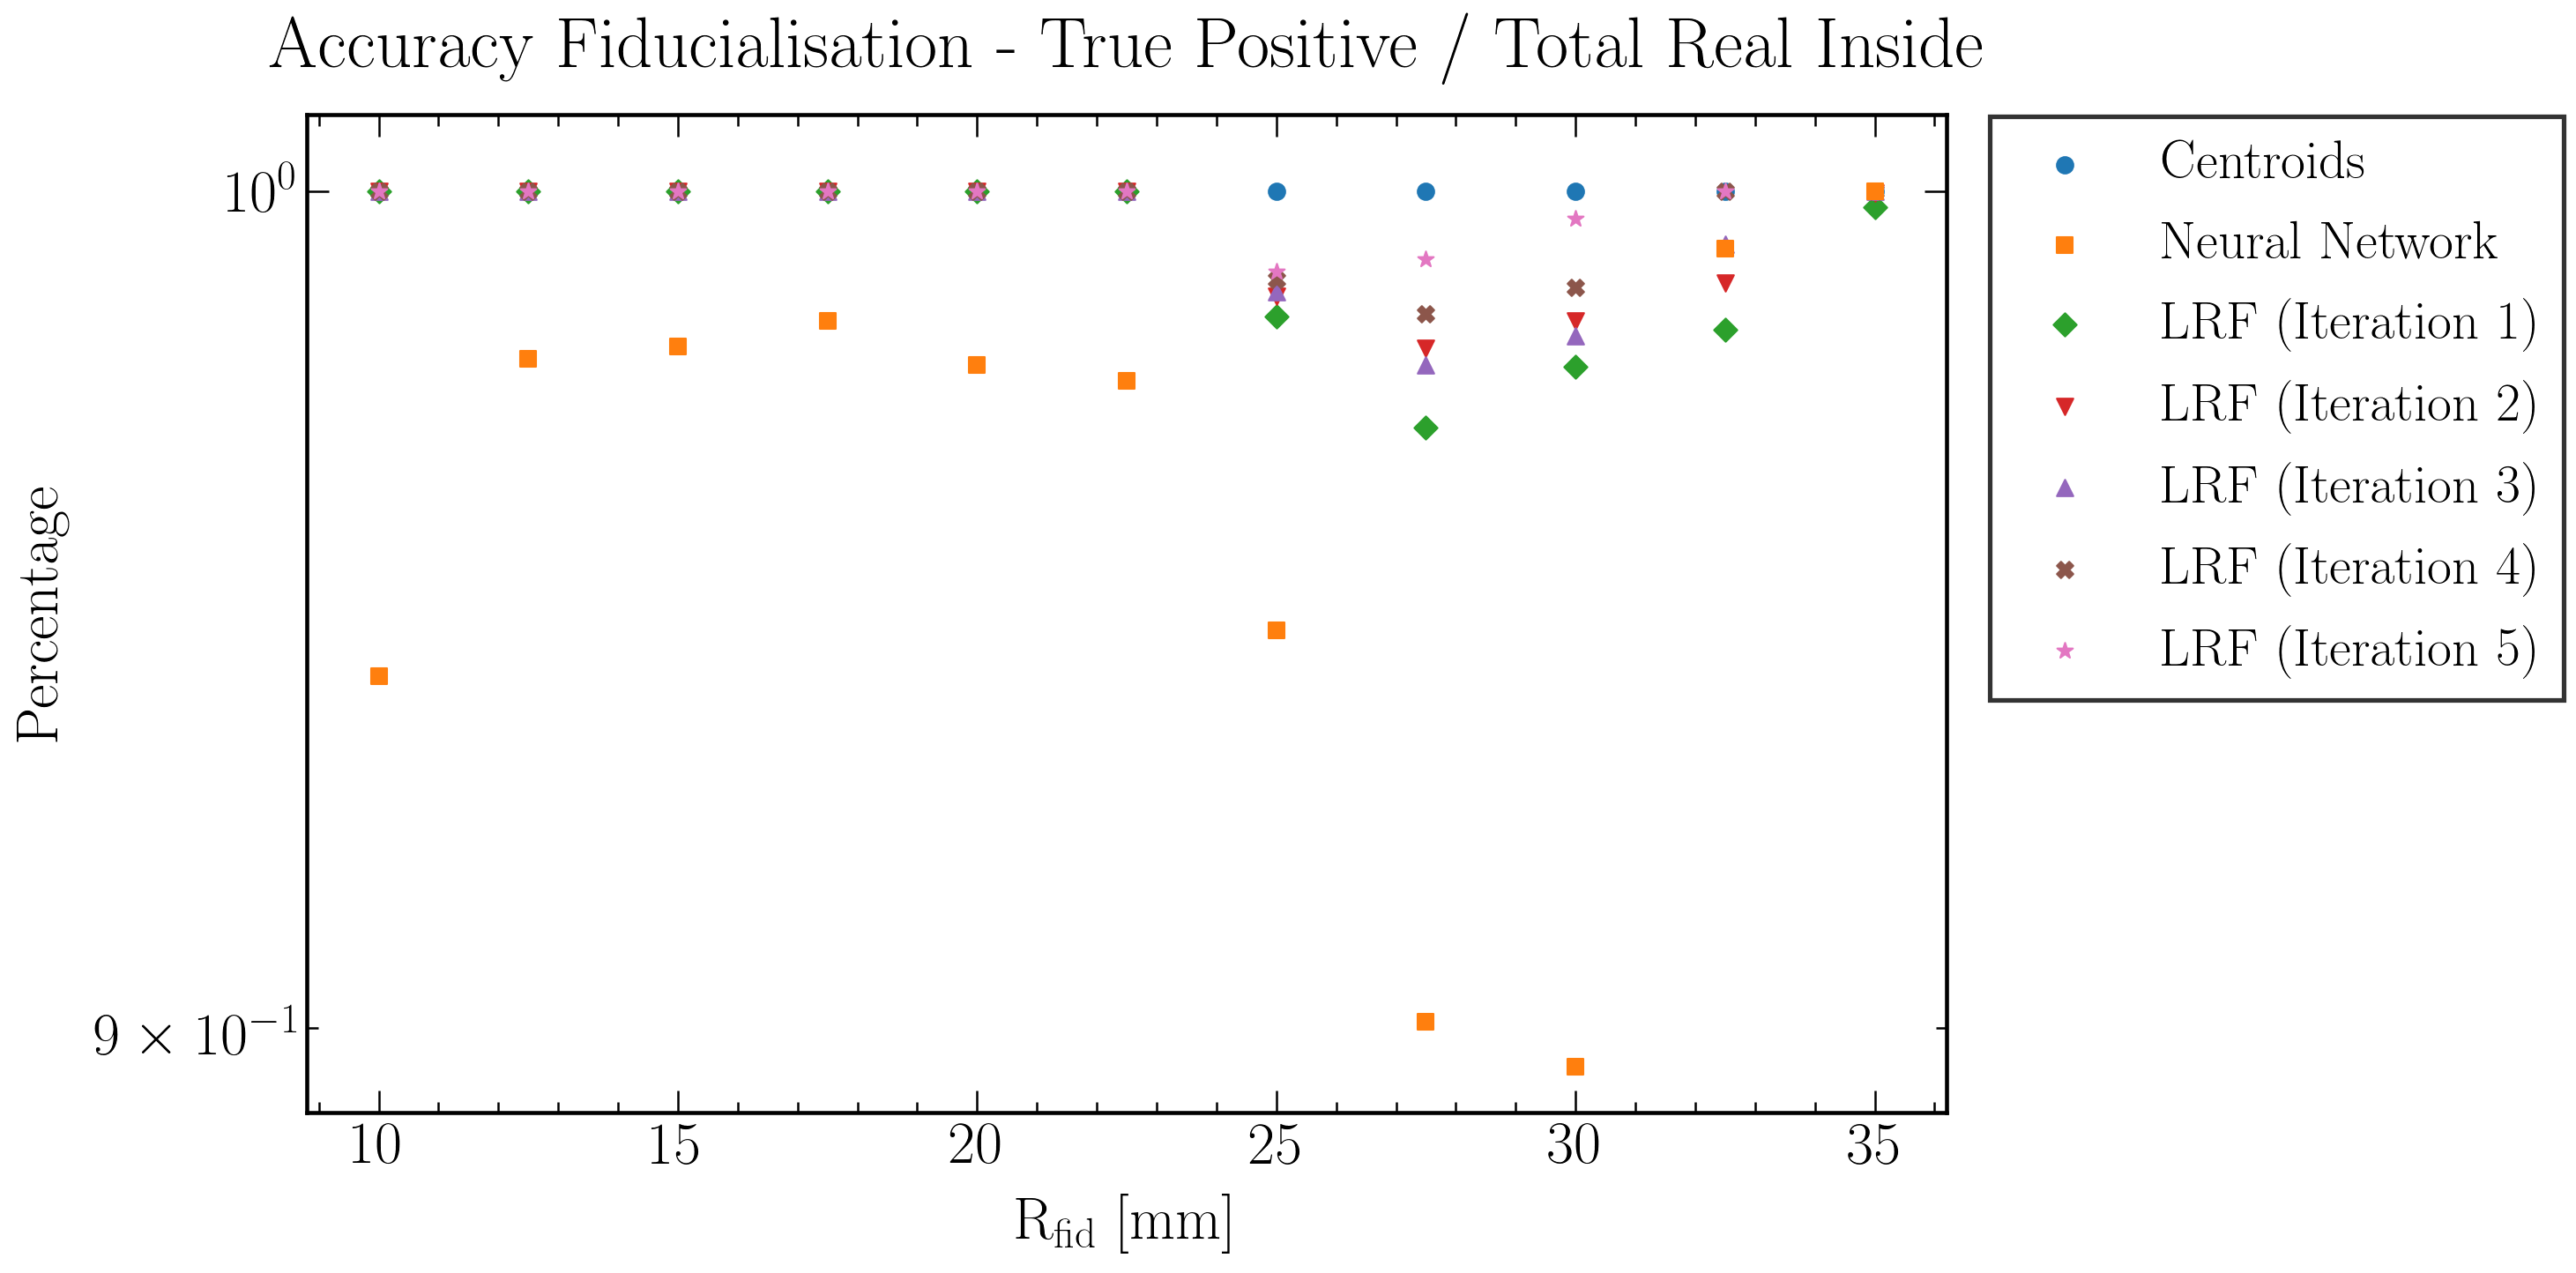

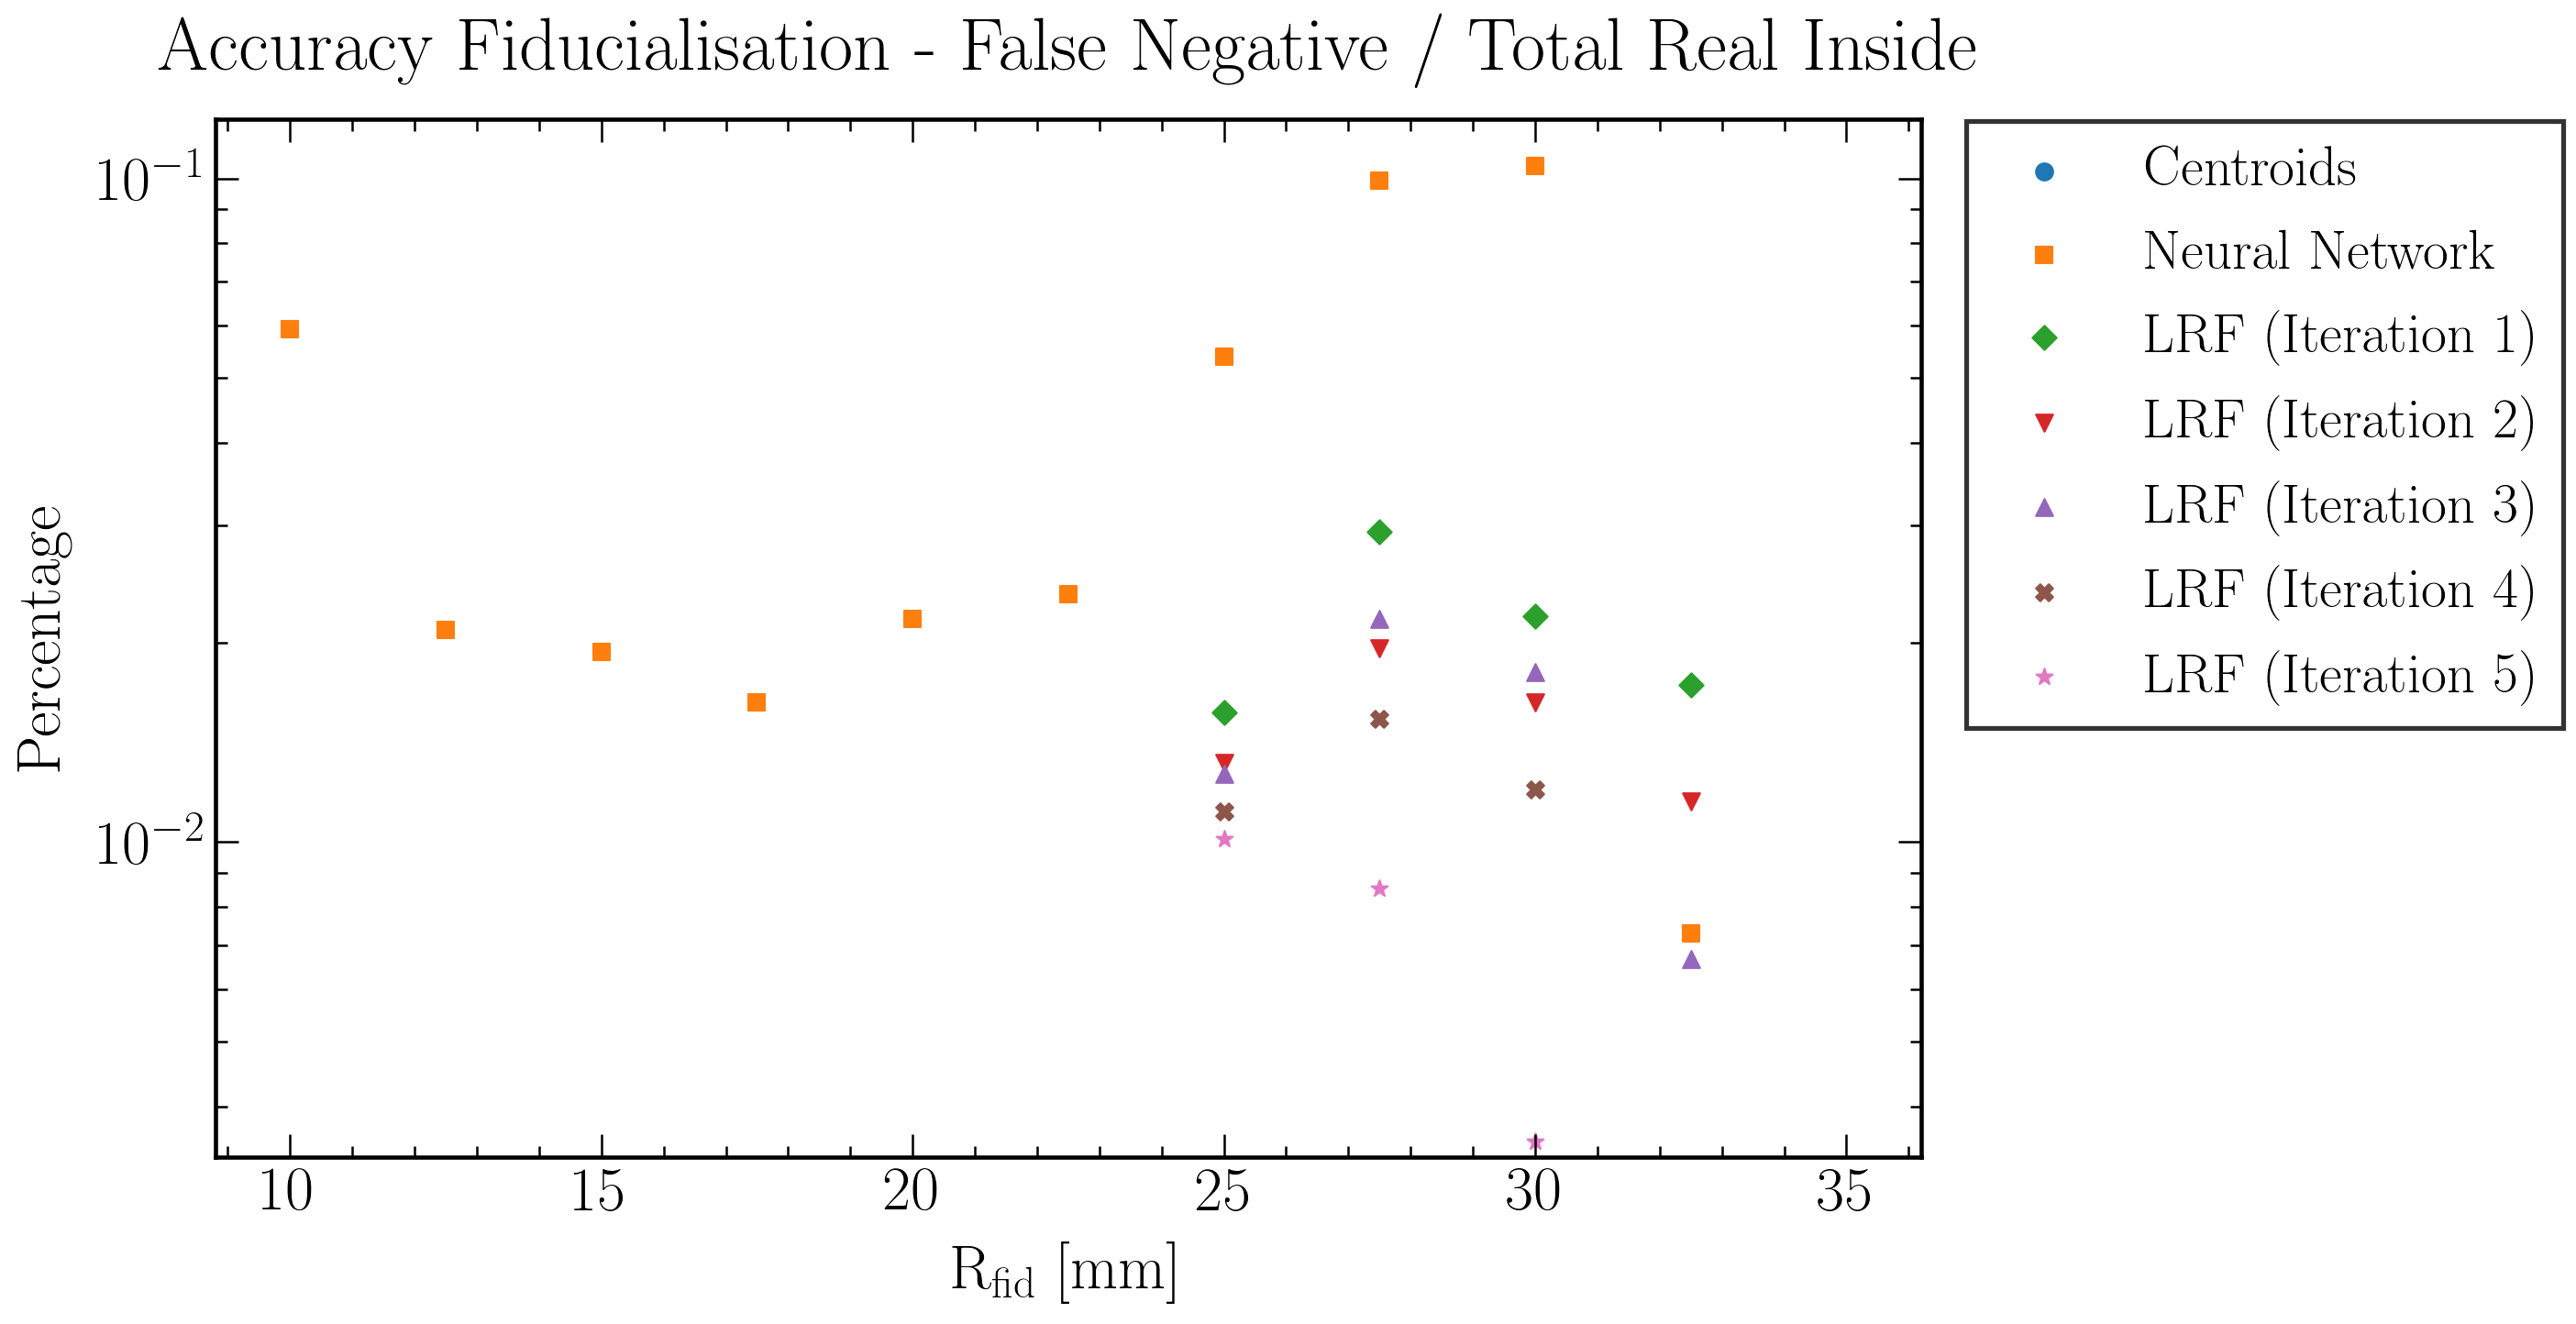

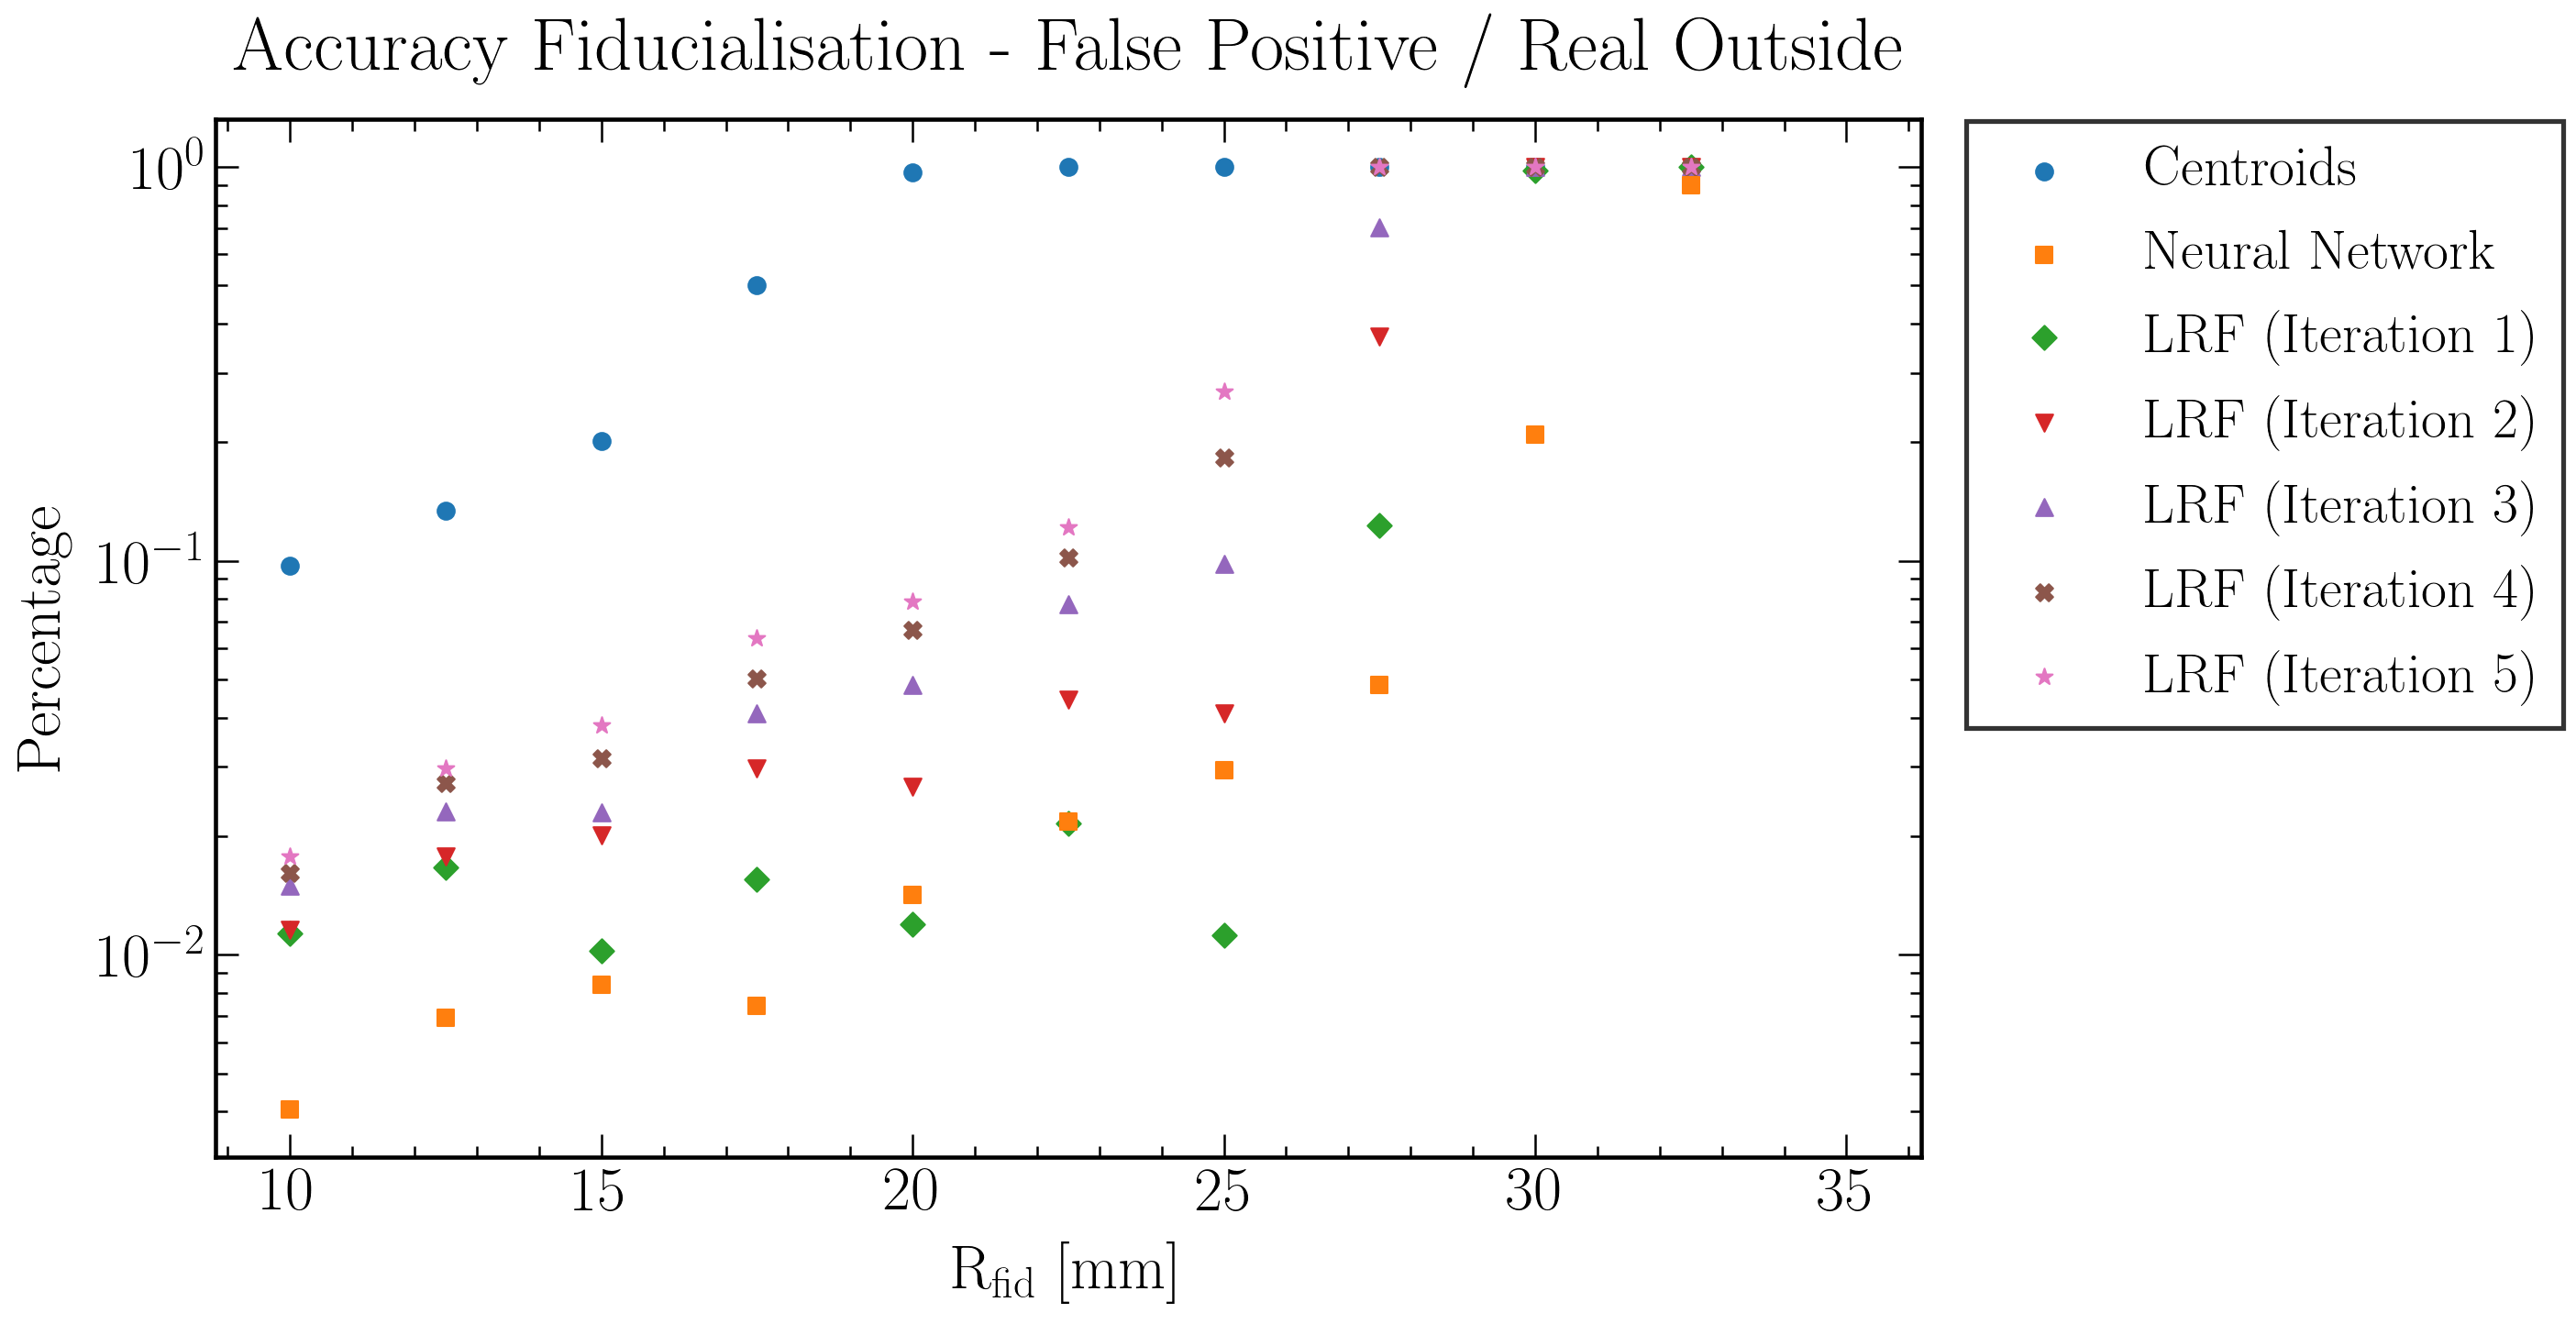

In [30]:
bool_bool_list = ['true_negative', 'true_positive', 'false_negative', 'false_positive']
bool_bool_string_list = ['True Negative / Total Real Outside', 'True Positive / Total Real Inside', 'False Negative / Total Real Inside', 'False Positive / Real Outside']
norm_list = ['true_outside', 'true_inside', 'true_inside', 'true_outside']

for i in range(len(bool_bool_list)):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    x = df_Fiducialisation_Centroids['fid']
    y = df_Fiducialisation_Centroids[bool_bool_list[i]]/df_Fiducialisation_Centroids[norm_list[i]]
    plt.scatter(x, y, label = 'Centroids', color = 'C0', marker = 'o', s = 80)

    x = df_Fiducialisation_NN['fid']
    y = df_Fiducialisation_NN[bool_bool_list[i]]/df_Fiducialisation_NN[norm_list[i]]
    plt.scatter(x, y, label = 'Neural Network', color = 'C1', marker = 's', s = 80, zorder = 12)

    x = df_Fiducialisation_LRF_iteration_1['fid']
    y = df_Fiducialisation_LRF_iteration_1[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_1[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 1)', color = 'C2', marker = 'D', s = 80)

    x = df_Fiducialisation_LRF_iteration_2['fid']
    y =df_Fiducialisation_LRF_iteration_2[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_2[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 2)', color = 'C3', marker = 'v', s = 80)

    x = df_Fiducialisation_LRF_iteration_3['fid']
    y = df_Fiducialisation_LRF_iteration_3[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_3[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 3)', color = 'C4', marker = '^', s = 80)

    x = df_Fiducialisation_LRF_iteration_4['fid']
    y = df_Fiducialisation_LRF_iteration_4[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_4[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 4)', color = 'C5', marker = 'X', s = 80)

    x = df_Fiducialisation_LRF_iteration_5['fid']
    y = df_Fiducialisation_LRF_iteration_5[bool_bool_list[i]]/df_Fiducialisation_LRF_iteration_5[norm_list[i]]
    plt.scatter(x, y, label = 'LRF (Iteration 5)', color = 'C6', marker = '*', s = 80)

    plt.ylabel('Percentage', fontsize = label_size, labelpad = label_pad)
    plt.xlabel('$\mathrm{R}_{\mathrm{fid}}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.title('Accuracy Fiducialisation - '+bool_bool_string_list[i], fontsize = title_size, pad = title_pad)

    plt.xlim(8.8, 36.2)
    plt.yscale('log')
    
    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig("Comparison_All_Goodness_fiducialisation_"+bool_bool_list[i]+"_normed_log.png", bbox_inches = "tight")
    plt.show()